In [ ]:
# Copyright (c) 2025, ETH Zurich

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import scipy.ndimage
from tqdm import tqdm
import spekpy as spk
import h5py

from scipy import interpolate

from scipy.interpolate import griddata
from scipy import interpolate
import scipy.constants as cnst

from scipy.interpolate import griddata

In [2]:
rave_sim_dir = Path('../rave-sim')
simulations_dir = Path('<PATH_TO_STORE_SIMULATIONS>')
scratch_dir = simulations_dir

sys.path.insert(0, str(rave_sim_dir / "nist_lookup"))
from nist_lookup.xraydb_plugin import xray_delta_beta

In [3]:
sys.path.insert(0, str(rave_sim_dir / "big-wave"))
import multisim
import config
import util
import propagation


In [4]:
def calculate_G1_height(eng):
    # constants
    h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
    c_0 = 299792458 # speed of light in m / s
    eV_to_joule = 1.602176634*10**(-19)
    N_A = 6.02214086 * 10**23 #[1/mol]
    
    lambda_ = h * c_0 / (eng*eV_to_joule)
    delta_diff = xray_delta_beta('Si', 2.34, eng)[0]
    height = np.pi  * lambda_ / (2*np.pi * delta_diff)

    return height


def signal_retrieval_least_squares(data, period=None, axis=-1):
    if axis != -1:
        data = np.moveaxis(data, axis, -1)

    nsteps = data.shape[-1]

    if period is None:
        period = nsteps

    phi = np.linspace(0, 2 * np.pi * nsteps / (period), nsteps, endpoint=False)
    M = np.c_[np.sin(phi), np.cos(phi), np.ones(nsteps)]
    res, chi2, _rank, _sing_vals = np.linalg.lstsq(M, data.reshape((-1, nsteps)).T, rcond=-1)

    res = res.T.reshape((*data.shape[:-1], -1))

    dabs = res[...,2]
    dphase = -np.arctan2(res[...,0], res[...,1])
    dvis = np.sqrt(res[...,0]**2 + res[...,1]**2) / dabs

    # normalization to the total number of counts
    dabs *= nsteps

    return dabs, dphase, dvis, np.nanmean(chi2)


def calculate_pixel_intensity(x, fringe, pxEdges, statistics = 'sum'):
    fringeStats = stats.binned_statistic(x, fringe, bins=pxEdges, statistic = statistics)
    return fringeStats.statistic

def perform_binned_signal_retrieval(x, wf, pxSize, nrSteps, plot_curve = True):
    leftSide = np.arange(0-pxSize/2, np.min(x), -pxSize)
    rightSide = np.arange(0 + pxSize/2, np.max(x), pxSize)
    pxEdges = np.concatenate([np.flip(leftSide), rightSide])
    int_px = []
    for i in range(nrSteps):
        int_px.append(calculate_pixel_intensity(x, wf[i,:], pxEdges))
    int_px = np.asarray(int_px)

    trans, phase, vis, _ = signal_retrieval_least_squares(int_px, period = nrSteps, axis = 0)
    if plot_curve:
        plot_curves(trans, phase, vis, pxEdges)
    return int_px, trans, phase, vis, pxEdges

def plot_curves(trans, phase, vis, pxEdges):

    fig, axs = plt.subplots(figsize=(15,6), sharex = True, nrows = 1, ncols = 2)
    axs[0].plot(pxEdges[1:], trans, label = 'Transmission')
    axs[0].set_title('Transmission')
    axs[1].plot(pxEdges[1:], vis, label = 'Visibility')
    axs[1].set_title('Visibility')

def perform_binning(x, wf, pxSize):
    leftSide = np.arange(0-pxSize/2, np.min(x), -pxSize)
    rightSide = np.arange(0 + pxSize/2, np.max(x), pxSize)
    pxEdges = np.concatenate([np.flip(leftSide), rightSide])
    int_px = calculate_pixel_intensity(x, wf, pxEdges, statistics = 'mean')
    return int_px
    
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def calculate_SNR(wavefronts, detector_x, phase_steps):
    summed_wf = np.zeros_like(wavefronts[0][0])
        
    for point in wavefronts:
        wf, x_point, eng = point
        
        summed_wf += wf

    return summed_wf

def get_subdict(dict_, idx):
    sub_dict = {}
    for key in dict_.keys():
        sub_dict[key] = dict_[key][idx]
    return sub_dict

def calc_Vis_theoretical(eng, Edes,m):
    V = 2/np.pi * np.abs(np.sin(np.pi / 2 * Edes / eng)**2 * np.sin(m * np.pi / 2 * Edes / eng))
    return V

def mu_h2o(eng):
    lambda_ = h * c_0 / (eng*eV_to_joule)
    beta = xray_delta_beta('H2O', 1.0, eng)[1]
    return 4 * np.pi / lambda_ * beta

In [5]:
# constants
h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
c_0 = 299792458 # speed of light in m / s
eV_to_joule = 1.602176634*10**(-19)
N_A = 6.02214086 * 10**23 #[1/mol]
E_des = 46000

lambda_ = h * c_0 / (E_des*eV_to_joule)
p2 = 4.2*10**(-6)
p0 = p1 = p2

Dn_3 = 3*p2**2/(2*lambda_) / 2

z_g0 = 0.218
z_g1 = z_g0 + Dn_3
z_g2 = z_g0 + 2*Dn_3
z_detector = z_g2 + 0.01

h0 = h2 = 180e-6
h1 = 59e-6

print("Z0: ", z_g0)
print("Z1: ", z_g1)
print("Z2: ", z_g2)
print("Z Detector: ", z_detector)

print(Dn_3)

Z0:  0.218
Z1:  0.7088528810878921
Z2:  1.1997057621757843
Z Detector:  1.2097057621757843
0.49085288108789216


In [6]:
N = 2**26
max_energy = 70000
dx = propagation.max_dx(z_g0, 200e-6, N, propagation.convert_energy_wavelength(max_energy))

In [7]:
s = spk.Spek(kvp=70, dk = 0.1, th = 10) # Create a spectrum
s.multi_filter((('Be', 0.15), ('Al', 3))) # Create a spectrum
k, f = s.get_spectrum(edges=True) # Get the spectrum

energyRange = [4000, 70000]
dE = 100
filtering = 0.000

energies = np.arange(5, 70+0.1, 0.1)*1e3


tube_spectrum_txt = interpolate.interp1d(k*1e3, f, fill_value = 'extrapolate')
spec_txt = tube_spectrum_txt(energies)

with h5py.File('../spectra/spectrum_70_spekpy_filtered_3mmAl.h5', 'w') as h5:
    h5.create_dataset('pdf', data =  spec_txt/ np.sum(spec_txt))
    h5.create_dataset('energy', data = energies)

path_to_spectrum = os.path.abspath('../spectra/spectrum_70_spekpy_filtered_3mmAl.h5')

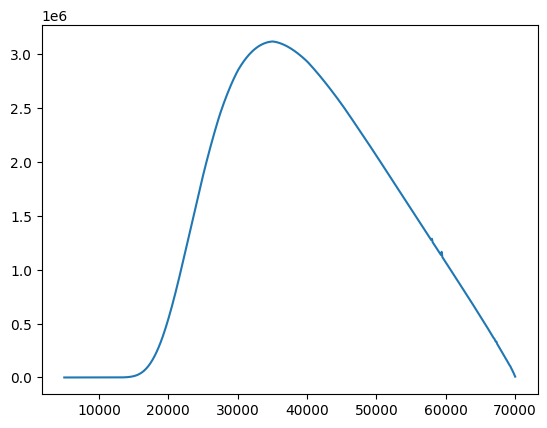

In [8]:
plt.plot(energies, spec_txt)

In [9]:
structure_shift = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

notebook_dir = os.getcwd()
path_to_models = os.path.abspath(os.path.join(notebook_dir, "..", "grating__modells/Models_Voids"))


grid_path_g0 = [os.path.join(path_to_models, 'Void_X_LIGA_25.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_50.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_75.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_100.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_250.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_300.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_450.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_500.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_650.npy'),
                os.path.join(path_to_models, 'Void_X_LIGA_700.npy'),
               ]
                
source_sizes = np.array([10, 50, 100, 150, 200])*1e-6

dx_g0 = 1.8852001559756422e-08
dz_g0 = 180e-6 / 20

In [10]:
len(grid_path_g0) * len(source_sizes)

50

In [ ]:
for grid_path in grid_path_g0:
    for ss in source_sizes:

        config_dict = {
                    "sim_params": {
                        "N": N,
                        "dx": dx,
                        "z_detector": z_g2 + 500e-6,
                        "detector_size": 0.004,
                        "detector_pixel_size_x": 1e-7,
                        "detector_pixel_size_y": 1.0,
                        "chunk_size": 256 * 1024 * 1024 // 16,  # use 256MB chunks
                    },
                    "use_disk_vector": False,
                    "save_final_u_vectors": False,
                    "dtype": "c8",
                    "multisource": {
                        "type": "points",
                        "energy_range": [11000, 70000],
                        "x_range": [-ss.item(), ss.item()],
                        "z": 0.0,
                        "nr_source_points": 200,
                        "seed": 1,
                        "spectrum": path_to_spectrum,
                    },
                    "elements": [
                        {
                            "type": "sample",
                            "z_start": z_g0,
                            "pixel_size_x": dx_g0,
                            "pixel_size_z": dz_g0,
                            "grid_path": grid_path,
                            "materials": [["Au", 19.32],["C5H8O2", 1.19]],
                            "x_positions": [0.0],
                        },
                        {
                            "type": "grating",
                            "pitch": 4.2*1e-6,
                            "dc": [1.0, 1.0],
                            "z_start": z_g0 + 180*1e-6,
                            "thickness": 500*1e-6 - h0,
                            "nr_steps": 1,
                            "x_positions": [0.0],
                            "substrate_thickness": 0.0,
                            "mat_a": ["C", 2.26],
                            "mat_b": None,
                            "mat_substrate": None
                        },           
                        {
                            "type": "grating",
                            "pitch": p1,
                            "dc": [0.5, 0.5],
                            "z_start": z_g1,
                            "thickness": h1,
                            "nr_steps": 10,
                            "x_positions": [0.0],
                            "substrate_thickness": 200 * 1e-6 - h1,
                            "mat_a": ["Si", 2.34],
                            "mat_b": None,
                            "mat_substrate": ["Si", 2.34],
                        },
                        {
                            "type": "grating",
                            "pitch": p2,
                            "dc": [0.5, 0.5],
                            "z_start": z_g2,
                            "thickness": h2,
                            "nr_steps": 30,
                            "x_positions": (np.arange(5) * p2/5).tolist(),
                            "substrate_thickness": 500*1e-6 - h2,
                            "mat_a": ["C5H8O2", 1.19],
                            "mat_b": ["Au", 19.32],
                            "mat_substrate": ["C", 2.26],
                        },
                    ],
            }
        sim_path = multisim.setup_simulation(config_dict, Path("."), simulations_dir)

        for i in tqdm(range(200)):
            os.system(f"CUDA_VISIBLE_DEVICES=1 ../rave-sim/fast-wave/build-Release/fastwave -s {i} {sim_path}")

2024-04-23 08:28:07,017 INFO: Setting up simulation
2024-04-23 08:28:18,352 INFO: Finished setting up simulation in /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935
  0%|                                                                                                         | 0/200 [00:00<?, ?it/s]

[2024-04-23 08:28:18.385] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000000
[2024-04-23 08:28:18.751] [info] Simulating optical element 1/4
[2024-04-23 08:28:19.290] [info] Elapsed time for optical element: 538.7943 ms
[2024-04-23 08:28:19.290] [info] Simulating optical element 2/4
[2024-04-23 08:28:19.314] [info] Elapsed time for optical element: 24.402464 ms
[2024-04-23 08:28:19.335] [info] Simulating optical element 3/4
[2024-04-23 08:28:19.612] [info] Elapsed time for optical element: 277.13788 ms
[2024-04-23 08:28:19.636] [info] Simulating optical element 4/4
[2024-04-23 08:28:20.423] [info] Elapsed time for optical element: 787.01917 ms
[2024-04-23 08:28:20.424] [info] Running phase step 2/5
[2024-04-23 08:28:20.426] [info] Simulating optical element 4/4
[2024-04-23 08:28:21.215] [info] Elapsed time for optical element: 788.127 ms
[2024-04-23 08:28:21.216] [info] Running phase step 3/5
[2024-04-23 08:28:21.218] [info] Simulatin

  0%|▍                                                                                                | 1/200 [00:05<17:30,  5.28s/it]

[2024-04-23 08:28:23.598] [info] Elapsed time for optical element: 793.11395 ms
[2024-04-23 08:28:23.600] [info] Simulation finished in 5.214800358 seconds
[2024-04-23 08:28:23.666] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000001
[2024-04-23 08:28:24.014] [info] Simulating optical element 1/4
[2024-04-23 08:28:24.548] [info] Elapsed time for optical element: 533.8654 ms
[2024-04-23 08:28:24.548] [info] Simulating optical element 2/4
[2024-04-23 08:28:24.573] [info] Elapsed time for optical element: 24.807104 ms
[2024-04-23 08:28:24.594] [info] Simulating optical element 3/4
[2024-04-23 08:28:24.880] [info] Elapsed time for optical element: 285.8967 ms
[2024-04-23 08:28:24.905] [info] Simulating optical element 4/4
[2024-04-23 08:28:25.716] [info] Elapsed time for optical element: 811.53064 ms
[2024-04-23 08:28:25.717] [info] Running phase step 2/5
[2024-04-23 08:28:25.719] [info] Simulating optical element 4/4
[2024-04-23 08:28:26.

  1%|▉                                                                                                | 2/200 [00:10<17:43,  5.37s/it]

[2024-04-23 08:28:29.033] [info] Elapsed time for optical element: 833.6464 ms
[2024-04-23 08:28:29.035] [info] Simulation finished in 5.369325307 seconds
[2024-04-23 08:28:29.090] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000002
[2024-04-23 08:28:29.407] [info] Simulating optical element 1/4
[2024-04-23 08:28:29.947] [info] Elapsed time for optical element: 540.0499 ms
[2024-04-23 08:28:29.947] [info] Simulating optical element 2/4
[2024-04-23 08:28:29.972] [info] Elapsed time for optical element: 24.56464 ms
[2024-04-23 08:28:29.992] [info] Simulating optical element 3/4
[2024-04-23 08:28:30.271] [info] Elapsed time for optical element: 278.18393 ms
[2024-04-23 08:28:30.295] [info] Simulating optical element 4/4
[2024-04-23 08:28:31.089] [info] Elapsed time for optical element: 793.7431 ms
[2024-04-23 08:28:31.090] [info] Running phase step 2/5
[2024-04-23 08:28:31.092] [info] Simulating optical element 4/4
[2024-04-23 08:28:31.90

  2%|█▍                                                                                               | 3/200 [00:16<17:32,  5.34s/it]

[2024-04-23 08:28:34.338] [info] Elapsed time for optical element: 815.0189 ms
[2024-04-23 08:28:34.341] [info] Simulation finished in 5.250793501 seconds
[2024-04-23 08:28:34.411] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000003
[2024-04-23 08:28:34.730] [info] Simulating optical element 1/4
[2024-04-23 08:28:35.278] [info] Elapsed time for optical element: 547.6048 ms
[2024-04-23 08:28:35.278] [info] Simulating optical element 2/4
[2024-04-23 08:28:35.305] [info] Elapsed time for optical element: 27.17296 ms
[2024-04-23 08:28:35.327] [info] Simulating optical element 3/4
[2024-04-23 08:28:35.625] [info] Elapsed time for optical element: 297.99054 ms
[2024-04-23 08:28:35.650] [info] Simulating optical element 4/4
[2024-04-23 08:28:36.502] [info] Elapsed time for optical element: 851.3785 ms
[2024-04-23 08:28:36.503] [info] Running phase step 2/5
[2024-04-23 08:28:36.505] [info] Simulating optical element 4/4
[2024-04-23 08:28:37.35

  2%|█▉                                                                                               | 4/200 [00:21<17:44,  5.43s/it]

[2024-04-23 08:28:39.912] [info] Elapsed time for optical element: 851.99384 ms
[2024-04-23 08:28:39.914] [info] Simulation finished in 5.502943459 seconds
[2024-04-23 08:28:39.981] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000004
[2024-04-23 08:28:40.311] [info] Simulating optical element 1/4
[2024-04-23 08:28:40.873] [info] Elapsed time for optical element: 561.6968 ms
[2024-04-23 08:28:40.873] [info] Simulating optical element 2/4
[2024-04-23 08:28:40.900] [info] Elapsed time for optical element: 27.48272 ms
[2024-04-23 08:28:40.923] [info] Simulating optical element 3/4
[2024-04-23 08:28:41.220] [info] Elapsed time for optical element: 297.07056 ms
[2024-04-23 08:28:41.245] [info] Simulating optical element 4/4
[2024-04-23 08:28:42.091] [info] Elapsed time for optical element: 845.6213 ms
[2024-04-23 08:28:42.092] [info] Running phase step 2/5
[2024-04-23 08:28:42.094] [info] Simulating optical element 4/4
[2024-04-23 08:28:42.9

  2%|██▍                                                                                              | 5/200 [00:27<17:53,  5.51s/it]

[2024-04-23 08:28:45.522] [info] Elapsed time for optical element: 860.2048 ms
[2024-04-23 08:28:45.524] [info] Simulation finished in 5.543071753 seconds
[2024-04-23 08:28:45.617] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000005
[2024-04-23 08:28:46.014] [info] Simulating optical element 1/4
[2024-04-23 08:28:46.582] [info] Elapsed time for optical element: 567.7539 ms
[2024-04-23 08:28:46.582] [info] Simulating optical element 2/4
[2024-04-23 08:28:46.610] [info] Elapsed time for optical element: 27.519968 ms
[2024-04-23 08:28:46.633] [info] Simulating optical element 3/4
[2024-04-23 08:28:46.929] [info] Elapsed time for optical element: 296.9318 ms
[2024-04-23 08:28:46.954] [info] Simulating optical element 4/4
[2024-04-23 08:28:47.817] [info] Elapsed time for optical element: 862.4062 ms
[2024-04-23 08:28:47.818] [info] Running phase step 2/5
[2024-04-23 08:28:47.820] [info] Simulating optical element 4/4
[2024-04-23 08:28:48.68

  3%|██▉                                                                                              | 6/200 [00:32<18:04,  5.59s/it]

[2024-04-23 08:28:51.302] [info] Elapsed time for optical element: 872.90216 ms
[2024-04-23 08:28:51.305] [info] Simulation finished in 5.688122493 seconds
[2024-04-23 08:28:51.373] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000006
[2024-04-23 08:28:51.847] [info] Simulating optical element 1/4
[2024-04-23 08:28:52.427] [info] Elapsed time for optical element: 579.9895 ms
[2024-04-23 08:28:52.427] [info] Simulating optical element 2/4
[2024-04-23 08:28:52.454] [info] Elapsed time for optical element: 26.737345 ms
[2024-04-23 08:28:52.476] [info] Simulating optical element 3/4
[2024-04-23 08:28:52.784] [info] Elapsed time for optical element: 306.91583 ms
[2024-04-23 08:28:52.810] [info] Simulating optical element 4/4
[2024-04-23 08:28:53.693] [info] Elapsed time for optical element: 883.1263 ms
[2024-04-23 08:28:53.695] [info] Running phase step 2/5
[2024-04-23 08:28:53.697] [info] Simulating optical element 4/4
[2024-04-23 08:28:54.

  4%|███▍                                                                                             | 7/200 [00:38<18:20,  5.70s/it]

[2024-04-23 08:28:57.231] [info] Elapsed time for optical element: 881.1055 ms
[2024-04-23 08:28:57.233] [info] Simulation finished in 5.859973883 seconds
[2024-04-23 08:28:57.311] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000007
[2024-04-23 08:28:57.740] [info] Simulating optical element 1/4
[2024-04-23 08:28:58.327] [info] Elapsed time for optical element: 587.45416 ms
[2024-04-23 08:28:58.327] [info] Simulating optical element 2/4
[2024-04-23 08:28:58.354] [info] Elapsed time for optical element: 27.07456 ms
[2024-04-23 08:28:58.377] [info] Simulating optical element 3/4
[2024-04-23 08:28:58.686] [info] Elapsed time for optical element: 308.81525 ms
[2024-04-23 08:28:58.712] [info] Simulating optical element 4/4
[2024-04-23 08:28:59.603] [info] Elapsed time for optical element: 891.7054 ms
[2024-04-23 08:28:59.605] [info] Running phase step 2/5
[2024-04-23 08:28:59.607] [info] Simulating optical element 4/4
[2024-04-23 08:29:00.5

  4%|███▉                                                                                             | 8/200 [00:44<18:30,  5.78s/it]

[2024-04-23 08:29:03.184] [info] Elapsed time for optical element: 892.4217 ms
[2024-04-23 08:29:03.187] [info] Simulation finished in 5.875919368 seconds
[2024-04-23 08:29:03.251] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000008
[2024-04-23 08:29:03.653] [info] Simulating optical element 1/4
[2024-04-23 08:29:04.230] [info] Elapsed time for optical element: 576.8484 ms
[2024-04-23 08:29:04.230] [info] Simulating optical element 2/4
[2024-04-23 08:29:04.257] [info] Elapsed time for optical element: 27.017376 ms
[2024-04-23 08:29:04.279] [info] Simulating optical element 3/4
[2024-04-23 08:29:04.594] [info] Elapsed time for optical element: 314.65573 ms
[2024-04-23 08:29:04.620] [info] Simulating optical element 4/4
[2024-04-23 08:29:05.537] [info] Elapsed time for optical element: 916.06335 ms
[2024-04-23 08:29:05.538] [info] Running phase step 2/5
[2024-04-23 08:29:05.540] [info] Simulating optical element 4/4
[2024-04-23 08:29:06.

  4%|████▎                                                                                            | 9/200 [00:50<18:38,  5.86s/it]

[2024-04-23 08:29:09.203] [info] Elapsed time for optical element: 906.46814 ms
[2024-04-23 08:29:09.206] [info] Simulation finished in 5.954452393 seconds
[2024-04-23 08:29:09.286] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000009
[2024-04-23 08:29:09.676] [info] Simulating optical element 1/4
[2024-04-23 08:29:10.275] [info] Elapsed time for optical element: 598.9064 ms
[2024-04-23 08:29:10.275] [info] Simulating optical element 2/4
[2024-04-23 08:29:10.303] [info] Elapsed time for optical element: 27.878784 ms
[2024-04-23 08:29:10.326] [info] Simulating optical element 3/4
[2024-04-23 08:29:10.644] [info] Elapsed time for optical element: 317.80096 ms
[2024-04-23 08:29:10.670] [info] Simulating optical element 4/4
[2024-04-23 08:29:11.572] [info] Elapsed time for optical element: 902.19293 ms
[2024-04-23 08:29:11.574] [info] Running phase step 2/5
[2024-04-23 08:29:11.575] [info] Simulating optical element 4/4
[2024-04-23 08:29:12

  5%|████▊                                                                                           | 10/200 [00:56<18:43,  5.91s/it]

[2024-04-23 08:29:15.255] [info] Elapsed time for optical element: 925.22424 ms
[2024-04-23 08:29:15.257] [info] Simulation finished in 5.971055099 seconds
[2024-04-23 08:29:15.315] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000010
[2024-04-23 08:29:15.625] [info] Simulating optical element 1/4
[2024-04-23 08:29:16.234] [info] Elapsed time for optical element: 608.5816 ms
[2024-04-23 08:29:16.234] [info] Simulating optical element 2/4
[2024-04-23 08:29:16.262] [info] Elapsed time for optical element: 27.762016 ms
[2024-04-23 08:29:16.285] [info] Simulating optical element 3/4
[2024-04-23 08:29:16.602] [info] Elapsed time for optical element: 317.41495 ms
[2024-04-23 08:29:16.628] [info] Simulating optical element 4/4
[2024-04-23 08:29:17.533] [info] Elapsed time for optical element: 904.8392 ms
[2024-04-23 08:29:17.535] [info] Running phase step 2/5
[2024-04-23 08:29:17.536] [info] Simulating optical element 4/4
[2024-04-23 08:29:18.

  6%|█████▎                                                                                          | 11/200 [01:02<18:44,  5.95s/it]

[2024-04-23 08:29:21.272] [info] Elapsed time for optical element: 938.287 ms
[2024-04-23 08:29:21.274] [info] Simulation finished in 5.95876033 seconds
[2024-04-23 08:29:21.352] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000011
[2024-04-23 08:29:21.666] [info] Simulating optical element 1/4
[2024-04-23 08:29:22.288] [info] Elapsed time for optical element: 621.24915 ms
[2024-04-23 08:29:22.288] [info] Simulating optical element 2/4
[2024-04-23 08:29:22.316] [info] Elapsed time for optical element: 28.056929 ms
[2024-04-23 08:29:22.339] [info] Simulating optical element 3/4
[2024-04-23 08:29:22.669] [info] Elapsed time for optical element: 329.5867 ms
[2024-04-23 08:29:22.696] [info] Simulating optical element 4/4
[2024-04-23 08:29:23.632] [info] Elapsed time for optical element: 935.2702 ms
[2024-04-23 08:29:23.633] [info] Running phase step 2/5
[2024-04-23 08:29:23.635] [info] Simulating optical element 4/4
[2024-04-23 08:29:24.600

  6%|█████▊                                                                                          | 12/200 [01:09<18:53,  6.03s/it]

[2024-04-23 08:29:27.506] [info] Elapsed time for optical element: 971.465 ms
[2024-04-23 08:29:27.508] [info] Simulation finished in 6.156413439 seconds
[2024-04-23 08:29:27.562] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000012
[2024-04-23 08:29:27.882] [info] Simulating optical element 1/4
[2024-04-23 08:29:28.495] [info] Elapsed time for optical element: 612.4626 ms
[2024-04-23 08:29:28.495] [info] Simulating optical element 2/4
[2024-04-23 08:29:28.523] [info] Elapsed time for optical element: 27.984 ms
[2024-04-23 08:29:28.546] [info] Simulating optical element 3/4
[2024-04-23 08:29:28.864] [info] Elapsed time for optical element: 318.6116 ms
[2024-04-23 08:29:28.890] [info] Simulating optical element 4/4
[2024-04-23 08:29:29.811] [info] Elapsed time for optical element: 920.7646 ms
[2024-04-23 08:29:29.813] [info] Running phase step 2/5
[2024-04-23 08:29:29.815] [info] Simulating optical element 4/4
[2024-04-23 08:29:30.749] [

  6%|██████▏                                                                                         | 13/200 [01:15<18:49,  6.04s/it]

[2024-04-23 08:29:33.572] [info] Elapsed time for optical element: 941.33374 ms
[2024-04-23 08:29:33.575] [info] Simulation finished in 6.012991382 seconds
[2024-04-23 08:29:33.639] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000013
[2024-04-23 08:29:33.958] [info] Simulating optical element 1/4
[2024-04-23 08:29:34.605] [info] Elapsed time for optical element: 646.38947 ms
[2024-04-23 08:29:34.605] [info] Simulating optical element 2/4
[2024-04-23 08:29:34.635] [info] Elapsed time for optical element: 29.936256 ms
[2024-04-23 08:29:34.659] [info] Simulating optical element 3/4
[2024-04-23 08:29:35.005] [info] Elapsed time for optical element: 346.4571 ms
[2024-04-23 08:29:35.034] [info] Simulating optical element 4/4
[2024-04-23 08:29:36.017] [info] Elapsed time for optical element: 982.82904 ms
[2024-04-23 08:29:36.019] [info] Running phase step 2/5
[2024-04-23 08:29:36.021] [info] Simulating optical element 4/4
[2024-04-23 08:29:37

  7%|██████▋                                                                                         | 14/200 [01:21<19:09,  6.18s/it]

[2024-04-23 08:29:40.064] [info] Elapsed time for optical element: 1036.279 ms
[2024-04-23 08:29:40.066] [info] Simulation finished in 6.426772469 seconds
[2024-04-23 08:29:40.134] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000014
[2024-04-23 08:29:40.482] [info] Simulating optical element 1/4
[2024-04-23 08:29:41.099] [info] Elapsed time for optical element: 617.2467 ms
[2024-04-23 08:29:41.099] [info] Simulating optical element 2/4
[2024-04-23 08:29:41.127] [info] Elapsed time for optical element: 27.836897 ms
[2024-04-23 08:29:41.150] [info] Simulating optical element 3/4
[2024-04-23 08:29:41.468] [info] Elapsed time for optical element: 317.91522 ms
[2024-04-23 08:29:41.494] [info] Simulating optical element 4/4
[2024-04-23 08:29:42.435] [info] Elapsed time for optical element: 941.082 ms
[2024-04-23 08:29:42.437] [info] Running phase step 2/5
[2024-04-23 08:29:42.439] [info] Simulating optical element 4/4
[2024-04-23 08:29:43.38

  8%|███████▏                                                                                        | 15/200 [01:27<19:02,  6.18s/it]

[2024-04-23 08:29:46.239] [info] Elapsed time for optical element: 950.4464 ms
[2024-04-23 08:29:46.241] [info] Simulation finished in 6.106539663 seconds
[2024-04-23 08:29:46.308] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000015
[2024-04-23 08:29:46.662] [info] Simulating optical element 1/4
[2024-04-23 08:29:47.288] [info] Elapsed time for optical element: 626.1741 ms
[2024-04-23 08:29:47.288] [info] Simulating optical element 2/4
[2024-04-23 08:29:47.317] [info] Elapsed time for optical element: 28.6592 ms
[2024-04-23 08:29:47.340] [info] Simulating optical element 3/4
[2024-04-23 08:29:47.671] [info] Elapsed time for optical element: 330.82376 ms
[2024-04-23 08:29:47.698] [info] Simulating optical element 4/4
[2024-04-23 08:29:48.837] [info] Elapsed time for optical element: 1138.3917 ms
[2024-04-23 08:29:48.838] [info] Running phase step 2/5
[2024-04-23 08:29:48.840] [info] Simulating optical element 4/4
[2024-04-23 08:29:49.93

  8%|███████▋                                                                                        | 16/200 [01:34<19:26,  6.34s/it]

[2024-04-23 08:29:52.963] [info] Elapsed time for optical element: 1009.21313 ms
[2024-04-23 08:29:52.965] [info] Simulation finished in 6.657215218 seconds
[2024-04-23 08:29:53.031] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000016
[2024-04-23 08:29:53.378] [info] Simulating optical element 1/4
[2024-04-23 08:29:54.018] [info] Elapsed time for optical element: 639.4999 ms
[2024-04-23 08:29:54.018] [info] Simulating optical element 2/4
[2024-04-23 08:29:54.048] [info] Elapsed time for optical element: 29.491615 ms
[2024-04-23 08:29:54.071] [info] Simulating optical element 3/4
[2024-04-23 08:29:54.408] [info] Elapsed time for optical element: 336.32117 ms
[2024-04-23 08:29:54.435] [info] Simulating optical element 4/4
[2024-04-23 08:29:55.397] [info] Elapsed time for optical element: 962.54004 ms
[2024-04-23 08:29:55.399] [info] Running phase step 2/5
[2024-04-23 08:29:55.401] [info] Simulating optical element 4/4
[2024-04-23 08:29:5

  8%|████████▏                                                                                       | 17/200 [01:41<19:38,  6.44s/it]

[2024-04-23 08:29:59.631] [info] Elapsed time for optical element: 985.7013 ms
[2024-04-23 08:29:59.633] [info] Simulation finished in 6.602091871 seconds
[2024-04-23 08:29:59.698] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000017
[2024-04-23 08:30:00.057] [info] Simulating optical element 1/4
[2024-04-23 08:30:00.692] [info] Elapsed time for optical element: 634.47314 ms
[2024-04-23 08:30:00.692] [info] Simulating optical element 2/4
[2024-04-23 08:30:00.721] [info] Elapsed time for optical element: 29.029472 ms
[2024-04-23 08:30:00.745] [info] Simulating optical element 3/4
[2024-04-23 08:30:01.081] [info] Elapsed time for optical element: 336.3614 ms
[2024-04-23 08:30:01.108] [info] Simulating optical element 4/4
[2024-04-23 08:30:02.379] [info] Elapsed time for optical element: 1270.7788 ms
[2024-04-23 08:30:02.381] [info] Running phase step 2/5
[2024-04-23 08:30:02.383] [info] Simulating optical element 4/4
[2024-04-23 08:30:03.

  9%|████████▋                                                                                       | 18/200 [01:48<19:59,  6.59s/it]

[2024-04-23 08:30:06.577] [info] Elapsed time for optical element: 1048.8713 ms
[2024-04-23 08:30:06.579] [info] Simulation finished in 6.880341823 seconds
[2024-04-23 08:30:06.638] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000018
[2024-04-23 08:30:06.990] [info] Simulating optical element 1/4
[2024-04-23 08:30:07.619] [info] Elapsed time for optical element: 629.2825 ms
[2024-04-23 08:30:07.619] [info] Simulating optical element 2/4
[2024-04-23 08:30:07.648] [info] Elapsed time for optical element: 29.129856 ms
[2024-04-23 08:30:07.672] [info] Simulating optical element 3/4
[2024-04-23 08:30:08.002] [info] Elapsed time for optical element: 330.36392 ms
[2024-04-23 08:30:08.029] [info] Simulating optical element 4/4
[2024-04-23 08:30:09.129] [info] Elapsed time for optical element: 1099.6632 ms
[2024-04-23 08:30:09.130] [info] Running phase step 2/5
[2024-04-23 08:30:09.132] [info] Simulating optical element 4/4
[2024-04-23 08:30:10

 10%|█████████                                                                                       | 19/200 [01:54<19:58,  6.62s/it]

[2024-04-23 08:30:13.269] [info] Elapsed time for optical element: 1013.8565 ms
[2024-04-23 08:30:13.271] [info] Simulation finished in 6.633671392 seconds
[2024-04-23 08:30:13.342] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000019
[2024-04-23 08:30:13.689] [info] Simulating optical element 1/4
[2024-04-23 08:30:14.338] [info] Elapsed time for optical element: 649.50037 ms
[2024-04-23 08:30:14.338] [info] Simulating optical element 2/4
[2024-04-23 08:30:14.367] [info] Elapsed time for optical element: 28.829697 ms
[2024-04-23 08:30:14.391] [info] Simulating optical element 3/4
[2024-04-23 08:30:14.734] [info] Elapsed time for optical element: 342.56146 ms
[2024-04-23 08:30:14.761] [info] Simulating optical element 4/4
[2024-04-23 08:30:15.837] [info] Elapsed time for optical element: 1076.2786 ms
[2024-04-23 08:30:15.839] [info] Running phase step 2/5
[2024-04-23 08:30:15.841] [info] Simulating optical element 4/4
[2024-04-23 08:30:1

 10%|█████████▌                                                                                      | 20/200 [02:01<20:11,  6.73s/it]

[2024-04-23 08:30:20.244] [info] Elapsed time for optical element: 1075.0807 ms
[2024-04-23 08:30:20.247] [info] Simulation finished in 6.904014438 seconds
[2024-04-23 08:30:20.313] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000020
[2024-04-23 08:30:20.634] [info] Simulating optical element 1/4
[2024-04-23 08:30:21.288] [info] Elapsed time for optical element: 653.9314 ms
[2024-04-23 08:30:21.288] [info] Simulating optical element 2/4
[2024-04-23 08:30:21.317] [info] Elapsed time for optical element: 29.7176 ms
[2024-04-23 08:30:21.342] [info] Simulating optical element 3/4
[2024-04-23 08:30:21.692] [info] Elapsed time for optical element: 350.23407 ms
[2024-04-23 08:30:21.720] [info] Simulating optical element 4/4
[2024-04-23 08:30:22.732] [info] Elapsed time for optical element: 1011.53906 ms
[2024-04-23 08:30:22.733] [info] Running phase step 2/5
[2024-04-23 08:30:22.735] [info] Simulating optical element 4/4
[2024-04-23 08:30:23.

 10%|██████████                                                                                      | 21/200 [02:08<20:02,  6.72s/it]

[2024-04-23 08:30:26.927] [info] Elapsed time for optical element: 1048.007 ms
[2024-04-23 08:30:26.929] [info] Simulation finished in 6.616014948 seconds
[2024-04-23 08:30:27.003] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000021
[2024-04-23 08:30:27.350] [info] Simulating optical element 1/4
[2024-04-23 08:30:28.010] [info] Elapsed time for optical element: 659.6813 ms
[2024-04-23 08:30:28.010] [info] Simulating optical element 2/4
[2024-04-23 08:30:28.040] [info] Elapsed time for optical element: 29.804705 ms
[2024-04-23 08:30:28.064] [info] Simulating optical element 3/4
[2024-04-23 08:30:28.436] [info] Elapsed time for optical element: 372.03336 ms
[2024-04-23 08:30:28.468] [info] Simulating optical element 4/4
[2024-04-23 08:30:29.576] [info] Elapsed time for optical element: 1107.4724 ms
[2024-04-23 08:30:29.577] [info] Running phase step 2/5
[2024-04-23 08:30:29.579] [info] Simulating optical element 4/4
[2024-04-23 08:30:30.

 11%|██████████▌                                                                                     | 22/200 [02:15<20:15,  6.83s/it]

[2024-04-23 08:30:34.013] [info] Elapsed time for optical element: 1116.2546 ms
[2024-04-23 08:30:34.015] [info] Simulation finished in 7.011735776 seconds
[2024-04-23 08:30:34.078] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000022
[2024-04-23 08:30:34.430] [info] Simulating optical element 1/4
[2024-04-23 08:30:35.081] [info] Elapsed time for optical element: 650.55334 ms
[2024-04-23 08:30:35.081] [info] Simulating optical element 2/4
[2024-04-23 08:30:35.115] [info] Elapsed time for optical element: 34.40816 ms
[2024-04-23 08:30:35.144] [info] Simulating optical element 3/4
[2024-04-23 08:30:35.579] [info] Elapsed time for optical element: 434.96857 ms
[2024-04-23 08:30:35.612] [info] Simulating optical element 4/4
[2024-04-23 08:30:36.833] [info] Elapsed time for optical element: 1220.9312 ms
[2024-04-23 08:30:36.835] [info] Running phase step 2/5
[2024-04-23 08:30:36.837] [info] Simulating optical element 4/4
[2024-04-23 08:30:38

 12%|███████████                                                                                     | 23/200 [02:23<20:34,  6.97s/it]

[2024-04-23 08:30:41.350] [info] Elapsed time for optical element: 1072.9082 ms
[2024-04-23 08:30:41.352] [info] Simulation finished in 7.273832913 seconds
[2024-04-23 08:30:41.392] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000023
[2024-04-23 08:30:41.732] [info] Simulating optical element 1/4
[2024-04-23 08:30:42.406] [info] Elapsed time for optical element: 674.1406 ms
[2024-04-23 08:30:42.406] [info] Simulating optical element 2/4
[2024-04-23 08:30:42.436] [info] Elapsed time for optical element: 30.222336 ms
[2024-04-23 08:30:42.462] [info] Simulating optical element 3/4
[2024-04-23 08:30:42.820] [info] Elapsed time for optical element: 357.34293 ms
[2024-04-23 08:30:42.848] [info] Simulating optical element 4/4
[2024-04-23 08:30:44.103] [info] Elapsed time for optical element: 1254.6846 ms
[2024-04-23 08:30:44.105] [info] Running phase step 2/5
[2024-04-23 08:30:44.107] [info] Simulating optical element 4/4
[2024-04-23 08:30:45

 12%|███████████▌                                                                                    | 24/200 [02:30<20:53,  7.12s/it]

[2024-04-23 08:30:48.799] [info] Elapsed time for optical element: 1137.5421 ms
[2024-04-23 08:30:48.801] [info] Simulation finished in 7.408652344 seconds
[2024-04-23 08:30:48.856] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000024
[2024-04-23 08:30:49.227] [info] Simulating optical element 1/4
[2024-04-23 08:30:49.885] [info] Elapsed time for optical element: 657.9937 ms
[2024-04-23 08:30:49.885] [info] Simulating optical element 2/4
[2024-04-23 08:30:49.915] [info] Elapsed time for optical element: 30.209696 ms
[2024-04-23 08:30:49.940] [info] Simulating optical element 3/4
[2024-04-23 08:30:50.296] [info] Elapsed time for optical element: 355.6433 ms
[2024-04-23 08:30:50.324] [info] Simulating optical element 4/4
[2024-04-23 08:30:51.751] [info] Elapsed time for optical element: 1426.475 ms
[2024-04-23 08:30:51.753] [info] Running phase step 2/5
[2024-04-23 08:30:51.755] [info] Simulating optical element 4/4
[2024-04-23 08:30:52.8

 12%|████████████                                                                                    | 25/200 [02:37<21:04,  7.23s/it]

[2024-04-23 08:30:56.266] [info] Elapsed time for optical element: 1132.5034 ms
[2024-04-23 08:30:56.269] [info] Simulation finished in 7.412701063 seconds
[2024-04-23 08:30:56.327] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000025
[2024-04-23 08:30:56.643] [info] Simulating optical element 1/4
[2024-04-23 08:30:57.318] [info] Elapsed time for optical element: 675.36926 ms
[2024-04-23 08:30:57.318] [info] Simulating optical element 2/4
[2024-04-23 08:30:57.349] [info] Elapsed time for optical element: 31.01904 ms
[2024-04-23 08:30:57.374] [info] Simulating optical element 3/4
[2024-04-23 08:30:57.739] [info] Elapsed time for optical element: 365.12762 ms
[2024-04-23 08:30:57.769] [info] Simulating optical element 4/4
[2024-04-23 08:30:58.882] [info] Elapsed time for optical element: 1112.9529 ms
[2024-04-23 08:30:58.884] [info] Running phase step 2/5
[2024-04-23 08:30:58.886] [info] Simulating optical element 4/4
[2024-04-23 08:31:00

 13%|████████████▍                                                                                   | 26/200 [02:45<21:07,  7.28s/it]

[2024-04-23 08:31:03.685] [info] Elapsed time for optical element: 1210.2831 ms
[2024-04-23 08:31:03.687] [info] Simulation finished in 7.360446697 seconds
[2024-04-23 08:31:03.744] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000026
[2024-04-23 08:31:04.077] [info] Simulating optical element 1/4
[2024-04-23 08:31:04.751] [info] Elapsed time for optical element: 674.25995 ms
[2024-04-23 08:31:04.751] [info] Simulating optical element 2/4
[2024-04-23 08:31:04.782] [info] Elapsed time for optical element: 31.024063 ms
[2024-04-23 08:31:04.807] [info] Simulating optical element 3/4
[2024-04-23 08:31:05.157] [info] Elapsed time for optical element: 350.22394 ms
[2024-04-23 08:31:05.186] [info] Simulating optical element 4/4
[2024-04-23 08:31:06.231] [info] Elapsed time for optical element: 1044.5742 ms
[2024-04-23 08:31:06.233] [info] Running phase step 2/5
[2024-04-23 08:31:06.235] [info] Simulating optical element 4/4
[2024-04-23 08:31:0

 14%|████████████▉                                                                                   | 27/200 [02:52<20:53,  7.25s/it]

[2024-04-23 08:31:10.843] [info] Elapsed time for optical element: 1188.464 ms
[2024-04-23 08:31:10.846] [info] Simulation finished in 7.10233655 seconds
[2024-04-23 08:31:10.914] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000027
[2024-04-23 08:31:11.259] [info] Simulating optical element 1/4
[2024-04-23 08:31:11.917] [info] Elapsed time for optical element: 657.32196 ms
[2024-04-23 08:31:11.917] [info] Simulating optical element 2/4
[2024-04-23 08:31:11.948] [info] Elapsed time for optical element: 30.788288 ms
[2024-04-23 08:31:11.972] [info] Simulating optical element 3/4
[2024-04-23 08:31:12.340] [info] Elapsed time for optical element: 368.73438 ms
[2024-04-23 08:31:12.392] [info] Simulating optical element 4/4
[2024-04-23 08:31:14.056] [info] Elapsed time for optical element: 1663.765 ms
[2024-04-23 08:31:14.058] [info] Running phase step 2/5
[2024-04-23 08:31:14.060] [info] Simulating optical element 4/4
[2024-04-23 08:31:15.1

 14%|█████████████▍                                                                                  | 28/200 [03:00<21:13,  7.40s/it]

[2024-04-23 08:31:18.606] [info] Elapsed time for optical element: 1140.4913 ms
[2024-04-23 08:31:18.609] [info] Simulation finished in 7.694653254 seconds
[2024-04-23 08:31:18.667] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000028
[2024-04-23 08:31:19.022] [info] Simulating optical element 1/4
[2024-04-23 08:31:19.760] [info] Elapsed time for optical element: 737.90485 ms
[2024-04-23 08:31:19.760] [info] Simulating optical element 2/4
[2024-04-23 08:31:19.793] [info] Elapsed time for optical element: 33.544353 ms
[2024-04-23 08:31:19.820] [info] Simulating optical element 3/4
[2024-04-23 08:31:20.219] [info] Elapsed time for optical element: 398.5138 ms
[2024-04-23 08:31:20.250] [info] Simulating optical element 4/4
[2024-04-23 08:31:21.386] [info] Elapsed time for optical element: 1136.5328 ms
[2024-04-23 08:31:21.388] [info] Running phase step 2/5
[2024-04-23 08:31:21.390] [info] Simulating optical element 4/4
[2024-04-23 08:31:22

 14%|█████████████▉                                                                                  | 29/200 [03:07<21:04,  7.39s/it]

[2024-04-23 08:31:25.984] [info] Elapsed time for optical element: 1149.0142 ms
[2024-04-23 08:31:25.987] [info] Simulation finished in 7.319856541 seconds
[2024-04-23 08:31:26.045] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000029
[2024-04-23 08:31:26.377] [info] Simulating optical element 1/4
[2024-04-23 08:31:27.127] [info] Elapsed time for optical element: 749.8115 ms
[2024-04-23 08:31:27.127] [info] Simulating optical element 2/4
[2024-04-23 08:31:27.161] [info] Elapsed time for optical element: 34.680862 ms
[2024-04-23 08:31:27.189] [info] Simulating optical element 3/4
[2024-04-23 08:31:27.614] [info] Elapsed time for optical element: 425.19403 ms
[2024-04-23 08:31:27.646] [info] Simulating optical element 4/4
[2024-04-23 08:31:28.853] [info] Elapsed time for optical element: 1206.2122 ms
[2024-04-23 08:31:28.854] [info] Running phase step 2/5
[2024-04-23 08:31:28.856] [info] Simulating optical element 4/4
[2024-04-23 08:31:30

 15%|██████████████▍                                                                                 | 30/200 [03:15<21:12,  7.49s/it]

[2024-04-23 08:31:33.684] [info] Elapsed time for optical element: 1213.3958 ms
[2024-04-23 08:31:33.687] [info] Simulation finished in 7.641954875 seconds
[2024-04-23 08:31:33.753] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000030
[2024-04-23 08:31:34.090] [info] Simulating optical element 1/4
[2024-04-23 08:31:34.774] [info] Elapsed time for optical element: 683.8671 ms
[2024-04-23 08:31:34.774] [info] Simulating optical element 2/4
[2024-04-23 08:31:34.806] [info] Elapsed time for optical element: 31.87904 ms
[2024-04-23 08:31:34.831] [info] Simulating optical element 3/4
[2024-04-23 08:31:35.192] [info] Elapsed time for optical element: 360.43704 ms
[2024-04-23 08:31:35.222] [info] Simulating optical element 4/4
[2024-04-23 08:31:37.185] [info] Elapsed time for optical element: 1963.1364 ms
[2024-04-23 08:31:37.187] [info] Running phase step 2/5
[2024-04-23 08:31:37.188] [info] Simulating optical element 4/4
[2024-04-23 08:31:38.

 16%|██████████████▉                                                                                 | 31/200 [03:23<21:42,  7.71s/it]

[2024-04-23 08:31:41.913] [info] Elapsed time for optical element: 1253.6497 ms
[2024-04-23 08:31:41.916] [info] Simulation finished in 8.162936151 seconds
[2024-04-23 08:31:41.981] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000031
[2024-04-23 08:31:42.321] [info] Simulating optical element 1/4
[2024-04-23 08:31:43.034] [info] Elapsed time for optical element: 713.1292 ms
[2024-04-23 08:31:43.034] [info] Simulating optical element 2/4
[2024-04-23 08:31:43.067] [info] Elapsed time for optical element: 32.74333 ms
[2024-04-23 08:31:43.093] [info] Simulating optical element 3/4
[2024-04-23 08:31:43.483] [info] Elapsed time for optical element: 390.19724 ms
[2024-04-23 08:31:43.514] [info] Simulating optical element 4/4
[2024-04-23 08:31:44.624] [info] Elapsed time for optical element: 1109.8325 ms
[2024-04-23 08:31:44.626] [info] Running phase step 2/5
[2024-04-23 08:31:44.628] [info] Simulating optical element 4/4
[2024-04-23 08:31:46.

 16%|███████████████▎                                                                                | 32/200 [03:31<22:09,  7.91s/it]

[2024-04-23 08:31:50.300] [info] Elapsed time for optical element: 1191.474 ms
[2024-04-23 08:31:50.302] [info] Simulation finished in 8.320769385 seconds
[2024-04-23 08:31:50.370] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000032
[2024-04-23 08:31:50.689] [info] Simulating optical element 1/4
[2024-04-23 08:31:51.363] [info] Elapsed time for optical element: 674.42456 ms
[2024-04-23 08:31:51.363] [info] Simulating optical element 2/4
[2024-04-23 08:31:51.393] [info] Elapsed time for optical element: 29.956257 ms
[2024-04-23 08:31:51.419] [info] Simulating optical element 3/4
[2024-04-23 08:31:51.805] [info] Elapsed time for optical element: 385.9474 ms
[2024-04-23 08:31:51.839] [info] Simulating optical element 4/4
[2024-04-23 08:31:53.131] [info] Elapsed time for optical element: 1291.9994 ms
[2024-04-23 08:31:53.133] [info] Running phase step 2/5
[2024-04-23 08:31:53.135] [info] Simulating optical element 4/4
[2024-04-23 08:31:54.

 16%|███████████████▊                                                                                | 33/200 [03:40<22:09,  7.96s/it]

[2024-04-23 08:31:58.372] [info] Elapsed time for optical element: 1316.0043 ms
[2024-04-23 08:31:58.374] [info] Simulation finished in 8.004116145 seconds
[2024-04-23 08:31:58.430] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000033
[2024-04-23 08:31:58.775] [info] Simulating optical element 1/4
[2024-04-23 08:31:59.446] [info] Elapsed time for optical element: 671.3729 ms
[2024-04-23 08:31:59.446] [info] Simulating optical element 2/4
[2024-04-23 08:31:59.477] [info] Elapsed time for optical element: 30.457727 ms
[2024-04-23 08:31:59.502] [info] Simulating optical element 3/4
[2024-04-23 08:31:59.895] [info] Elapsed time for optical element: 392.99237 ms
[2024-04-23 08:32:00.002] [info] Simulating optical element 4/4
[2024-04-23 08:32:01.695] [info] Elapsed time for optical element: 1692.7703 ms
[2024-04-23 08:32:01.697] [info] Running phase step 2/5
[2024-04-23 08:32:01.699] [info] Simulating optical element 4/4
[2024-04-23 08:32:02

 17%|████████████████▎                                                                               | 34/200 [03:48<22:13,  8.03s/it]

[2024-04-23 08:32:06.579] [info] Elapsed time for optical element: 1223.8794 ms
[2024-04-23 08:32:06.582] [info] Simulation finished in 8.152310331 seconds
[2024-04-23 08:32:06.636] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000034
[2024-04-23 08:32:06.976] [info] Simulating optical element 1/4
[2024-04-23 08:32:07.648] [info] Elapsed time for optical element: 672.2969 ms
[2024-04-23 08:32:07.648] [info] Simulating optical element 2/4
[2024-04-23 08:32:07.678] [info] Elapsed time for optical element: 30.513727 ms
[2024-04-23 08:32:07.703] [info] Simulating optical element 3/4
[2024-04-23 08:32:08.198] [info] Elapsed time for optical element: 495.45938 ms
[2024-04-23 08:32:08.329] [info] Simulating optical element 4/4
[2024-04-23 08:32:09.918] [info] Elapsed time for optical element: 1588.5443 ms
[2024-04-23 08:32:09.920] [info] Running phase step 2/5
[2024-04-23 08:32:09.922] [info] Simulating optical element 4/4
[2024-04-23 08:32:11

 18%|████████████████▊                                                                               | 35/200 [03:56<22:35,  8.22s/it]

[2024-04-23 08:32:15.223] [info] Elapsed time for optical element: 1260.0513 ms
[2024-04-23 08:32:15.226] [info] Simulation finished in 8.588986515 seconds
[2024-04-23 08:32:15.283] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000035
[2024-04-23 08:32:15.626] [info] Simulating optical element 1/4
[2024-04-23 08:32:16.295] [info] Elapsed time for optical element: 669.1722 ms
[2024-04-23 08:32:16.295] [info] Simulating optical element 2/4
[2024-04-23 08:32:16.324] [info] Elapsed time for optical element: 29.530752 ms
[2024-04-23 08:32:16.350] [info] Simulating optical element 3/4
[2024-04-23 08:32:17.325] [info] Elapsed time for optical element: 975.2849 ms
[2024-04-23 08:32:17.355] [info] Simulating optical element 4/4
[2024-04-23 08:32:18.349] [info] Elapsed time for optical element: 993.6441 ms
[2024-04-23 08:32:18.351] [info] Running phase step 2/5
[2024-04-23 08:32:18.353] [info] Simulating optical element 4/4
[2024-04-23 08:32:19.8

 18%|█████████████████▎                                                                              | 36/200 [04:05<22:38,  8.28s/it]

[2024-04-23 08:32:23.656] [info] Elapsed time for optical element: 1218.9644 ms
[2024-04-23 08:32:23.659] [info] Simulation finished in 8.375139289 seconds
[2024-04-23 08:32:23.726] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000036
[2024-04-23 08:32:24.083] [info] Simulating optical element 1/4
[2024-04-23 08:32:24.755] [info] Elapsed time for optical element: 672.7045 ms
[2024-04-23 08:32:24.755] [info] Simulating optical element 2/4
[2024-04-23 08:32:24.785] [info] Elapsed time for optical element: 29.740929 ms
[2024-04-23 08:32:24.810] [info] Simulating optical element 3/4
[2024-04-23 08:32:25.210] [info] Elapsed time for optical element: 400.2679 ms
[2024-04-23 08:32:25.249] [info] Simulating optical element 4/4
[2024-04-23 08:32:26.549] [info] Elapsed time for optical element: 1300.1564 ms
[2024-04-23 08:32:26.551] [info] Running phase step 2/5
[2024-04-23 08:32:26.553] [info] Simulating optical element 4/4
[2024-04-23 08:32:27.

 18%|█████████████████▊                                                                              | 37/200 [04:13<22:20,  8.23s/it]

[2024-04-23 08:32:31.749] [info] Elapsed time for optical element: 1299.5416 ms
[2024-04-23 08:32:31.752] [info] Simulation finished in 8.025537723 seconds
[2024-04-23 08:32:31.814] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000037
[2024-04-23 08:32:32.130] [info] Simulating optical element 1/4
[2024-04-23 08:32:32.851] [info] Elapsed time for optical element: 721.3541 ms
[2024-04-23 08:32:32.851] [info] Simulating optical element 2/4
[2024-04-23 08:32:32.885] [info] Elapsed time for optical element: 33.877857 ms
[2024-04-23 08:32:32.912] [info] Simulating optical element 3/4
[2024-04-23 08:32:33.311] [info] Elapsed time for optical element: 398.94586 ms
[2024-04-23 08:32:33.345] [info] Simulating optical element 4/4
[2024-04-23 08:32:34.500] [info] Elapsed time for optical element: 1155.2953 ms
[2024-04-23 08:32:34.502] [info] Running phase step 2/5
[2024-04-23 08:32:34.504] [info] Simulating optical element 4/4
[2024-04-23 08:32:35

 19%|██████████████████▏                                                                             | 38/200 [04:21<22:18,  8.26s/it]

[2024-04-23 08:32:40.090] [info] Elapsed time for optical element: 1393.4755 ms
[2024-04-23 08:32:40.093] [info] Simulation finished in 8.278350928 seconds
[2024-04-23 08:32:40.149] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000038
[2024-04-23 08:32:40.493] [info] Simulating optical element 1/4
[2024-04-23 08:32:41.175] [info] Elapsed time for optical element: 681.2693 ms
[2024-04-23 08:32:41.175] [info] Simulating optical element 2/4
[2024-04-23 08:32:41.206] [info] Elapsed time for optical element: 31.218945 ms
[2024-04-23 08:32:41.231] [info] Simulating optical element 3/4
[2024-04-23 08:32:41.585] [info] Elapsed time for optical element: 353.6319 ms
[2024-04-23 08:32:41.615] [info] Simulating optical element 4/4
[2024-04-23 08:32:43.115] [info] Elapsed time for optical element: 1500.083 ms
[2024-04-23 08:32:43.117] [info] Running phase step 2/5
[2024-04-23 08:32:43.119] [info] Simulating optical element 4/4
[2024-04-23 08:32:44.4

 20%|██████████████████▋                                                                             | 39/200 [04:30<22:13,  8.28s/it]

[2024-04-23 08:32:48.430] [info] Elapsed time for optical element: 1282.4656 ms
[2024-04-23 08:32:48.433] [info] Simulation finished in 8.283709463 seconds
[2024-04-23 08:32:48.498] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000039
[2024-04-23 08:32:48.853] [info] Simulating optical element 1/4
[2024-04-23 08:32:49.539] [info] Elapsed time for optical element: 685.5833 ms
[2024-04-23 08:32:49.539] [info] Simulating optical element 2/4
[2024-04-23 08:32:49.569] [info] Elapsed time for optical element: 30.535263 ms
[2024-04-23 08:32:49.595] [info] Simulating optical element 3/4
[2024-04-23 08:32:49.980] [info] Elapsed time for optical element: 384.9576 ms
[2024-04-23 08:32:50.013] [info] Simulating optical element 4/4
[2024-04-23 08:32:51.158] [info] Elapsed time for optical element: 1144.9698 ms
[2024-04-23 08:32:51.159] [info] Running phase step 2/5
[2024-04-23 08:32:51.161] [info] Simulating optical element 4/4
[2024-04-23 08:32:52.

 20%|███████████████████▏                                                                            | 40/200 [04:38<22:22,  8.39s/it]

[2024-04-23 08:32:57.066] [info] Elapsed time for optical element: 1485.8497 ms
[2024-04-23 08:32:57.068] [info] Simulation finished in 8.57015307 seconds
[2024-04-23 08:32:57.143] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000040
[2024-04-23 08:32:57.497] [info] Simulating optical element 1/4
[2024-04-23 08:32:58.207] [info] Elapsed time for optical element: 710.70776 ms
[2024-04-23 08:32:58.207] [info] Simulating optical element 2/4
[2024-04-23 08:32:58.240] [info] Elapsed time for optical element: 32.543423 ms
[2024-04-23 08:32:58.267] [info] Simulating optical element 3/4
[2024-04-23 08:32:58.655] [info] Elapsed time for optical element: 388.97253 ms
[2024-04-23 08:32:58.687] [info] Simulating optical element 4/4
[2024-04-23 08:33:00.372] [info] Elapsed time for optical element: 1684.8857 ms
[2024-04-23 08:33:00.374] [info] Running phase step 2/5
[2024-04-23 08:33:00.376] [info] Simulating optical element 4/4
[2024-04-23 08:33:01

 20%|███████████████████▋                                                                            | 41/200 [04:47<22:11,  8.37s/it]

[2024-04-23 08:33:05.402] [info] Elapsed time for optical element: 1250.5331 ms
[2024-04-23 08:33:05.404] [info] Simulation finished in 8.260306044 seconds
[2024-04-23 08:33:05.474] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000041
[2024-04-23 08:33:05.811] [info] Simulating optical element 1/4
[2024-04-23 08:33:06.512] [info] Elapsed time for optical element: 700.9273 ms
[2024-04-23 08:33:06.512] [info] Simulating optical element 2/4
[2024-04-23 08:33:06.546] [info] Elapsed time for optical element: 33.085728 ms
[2024-04-23 08:33:06.572] [info] Simulating optical element 3/4
[2024-04-23 08:33:06.976] [info] Elapsed time for optical element: 403.65607 ms
[2024-04-23 08:33:07.010] [info] Simulating optical element 4/4
[2024-04-23 08:33:08.265] [info] Elapsed time for optical element: 1254.908 ms
[2024-04-23 08:33:08.267] [info] Running phase step 2/5
[2024-04-23 08:33:08.269] [info] Simulating optical element 4/4
[2024-04-23 08:33:09.

 21%|████████████████████▏                                                                           | 42/200 [04:55<21:48,  8.28s/it]

[2024-04-23 08:33:13.459] [info] Elapsed time for optical element: 1305.1067 ms
[2024-04-23 08:33:13.462] [info] Simulation finished in 7.98790507 seconds
[2024-04-23 08:33:13.531] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000042
[2024-04-23 08:33:13.854] [info] Simulating optical element 1/4
[2024-04-23 08:33:14.579] [info] Elapsed time for optical element: 725.4812 ms
[2024-04-23 08:33:14.579] [info] Simulating optical element 2/4
[2024-04-23 08:33:14.613] [info] Elapsed time for optical element: 33.644096 ms
[2024-04-23 08:33:14.640] [info] Simulating optical element 3/4
[2024-04-23 08:33:15.146] [info] Elapsed time for optical element: 505.94177 ms
[2024-04-23 08:33:15.272] [info] Simulating optical element 4/4
[2024-04-23 08:33:16.716] [info] Elapsed time for optical element: 1444.651 ms
[2024-04-23 08:33:16.718] [info] Running phase step 2/5
[2024-04-23 08:33:16.720] [info] Simulating optical element 4/4
[2024-04-23 08:33:18.1

 22%|████████████████████▋                                                                           | 43/200 [05:04<22:07,  8.45s/it]

[2024-04-23 08:33:22.326] [info] Elapsed time for optical element: 1247.7136 ms
[2024-04-23 08:33:22.329] [info] Simulation finished in 8.797221486 seconds
[2024-04-23 08:33:22.383] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000043
[2024-04-23 08:33:22.717] [info] Simulating optical element 1/4
[2024-04-23 08:33:23.436] [info] Elapsed time for optical element: 719.4885 ms
[2024-04-23 08:33:23.436] [info] Simulating optical element 2/4
[2024-04-23 08:33:23.468] [info] Elapsed time for optical element: 31.429567 ms
[2024-04-23 08:33:23.494] [info] Simulating optical element 3/4
[2024-04-23 08:33:23.886] [info] Elapsed time for optical element: 391.4903 ms
[2024-04-23 08:33:23.918] [info] Simulating optical element 4/4
[2024-04-23 08:33:25.166] [info] Elapsed time for optical element: 1247.6554 ms
[2024-04-23 08:33:25.172] [info] Running phase step 2/5
[2024-04-23 08:33:25.176] [info] Simulating optical element 4/4
[2024-04-23 08:33:26.

 22%|█████████████████████                                                                           | 44/200 [05:13<22:25,  8.62s/it]

[2024-04-23 08:33:31.347] [info] Elapsed time for optical element: 1635.2784 ms
[2024-04-23 08:33:31.350] [info] Simulation finished in 8.966120702 seconds
[2024-04-23 08:33:31.415] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000044
[2024-04-23 08:33:31.744] [info] Simulating optical element 1/4
[2024-04-23 08:33:32.482] [info] Elapsed time for optical element: 738.89996 ms
[2024-04-23 08:33:32.482] [info] Simulating optical element 2/4
[2024-04-23 08:33:32.516] [info] Elapsed time for optical element: 33.947006 ms
[2024-04-23 08:33:32.544] [info] Simulating optical element 3/4
[2024-04-23 08:33:32.941] [info] Elapsed time for optical element: 397.26855 ms
[2024-04-23 08:33:32.973] [info] Simulating optical element 4/4
[2024-04-23 08:33:34.101] [info] Elapsed time for optical element: 1128.0952 ms
[2024-04-23 08:33:34.103] [info] Running phase step 2/5
[2024-04-23 08:33:34.105] [info] Simulating optical element 4/4
[2024-04-23 08:33:3

 22%|█████████████████████▌                                                                          | 45/200 [05:21<22:22,  8.66s/it]

[2024-04-23 08:33:40.098] [info] Elapsed time for optical element: 1465.4735 ms
[2024-04-23 08:33:40.100] [info] Simulation finished in 8.685074601 seconds
[2024-04-23 08:33:40.166] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000045
[2024-04-23 08:33:40.527] [info] Simulating optical element 1/4
[2024-04-23 08:33:41.230] [info] Elapsed time for optical element: 703.2402 ms
[2024-04-23 08:33:41.230] [info] Simulating optical element 2/4
[2024-04-23 08:33:41.262] [info] Elapsed time for optical element: 31.502144 ms
[2024-04-23 08:33:41.287] [info] Simulating optical element 3/4
[2024-04-23 08:33:41.660] [info] Elapsed time for optical element: 373.18097 ms
[2024-04-23 08:33:41.691] [info] Simulating optical element 4/4
[2024-04-23 08:33:43.276] [info] Elapsed time for optical element: 1584.7588 ms
[2024-04-23 08:33:43.278] [info] Running phase step 2/5
[2024-04-23 08:33:43.281] [info] Simulating optical element 4/4
[2024-04-23 08:33:44

 23%|██████████████████████                                                                          | 46/200 [05:29<21:46,  8.48s/it]

[2024-04-23 08:33:48.160] [info] Elapsed time for optical element: 1267.3181 ms
[2024-04-23 08:33:48.163] [info] Simulation finished in 7.996762748 seconds
[2024-04-23 08:33:48.229] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000046
[2024-04-23 08:33:48.595] [info] Simulating optical element 1/4
[2024-04-23 08:33:49.344] [info] Elapsed time for optical element: 749.16864 ms
[2024-04-23 08:33:49.344] [info] Simulating optical element 2/4
[2024-04-23 08:33:49.378] [info] Elapsed time for optical element: 34.24816 ms
[2024-04-23 08:33:49.406] [info] Simulating optical element 3/4
[2024-04-23 08:33:49.822] [info] Elapsed time for optical element: 415.86276 ms
[2024-04-23 08:33:49.855] [info] Simulating optical element 4/4
[2024-04-23 08:33:51.179] [info] Elapsed time for optical element: 1323.7672 ms
[2024-04-23 08:33:51.182] [info] Running phase step 2/5
[2024-04-23 08:33:51.184] [info] Simulating optical element 4/4
[2024-04-23 08:33:52

 24%|██████████████████████▌                                                                         | 47/200 [05:38<22:01,  8.64s/it]

[2024-04-23 08:33:57.158] [info] Elapsed time for optical element: 1382.4806 ms
[2024-04-23 08:33:57.161] [info] Simulation finished in 8.931382312 seconds
[2024-04-23 08:33:57.218] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000047
[2024-04-23 08:33:57.572] [info] Simulating optical element 1/4
[2024-04-23 08:33:58.233] [info] Elapsed time for optical element: 660.8297 ms
[2024-04-23 08:33:58.233] [info] Simulating optical element 2/4
[2024-04-23 08:33:58.263] [info] Elapsed time for optical element: 30.31456 ms
[2024-04-23 08:33:58.288] [info] Simulating optical element 3/4
[2024-04-23 08:33:58.721] [info] Elapsed time for optical element: 432.8305 ms
[2024-04-23 08:33:58.760] [info] Simulating optical element 4/4
[2024-04-23 08:34:00.127] [info] Elapsed time for optical element: 1367.1343 ms
[2024-04-23 08:34:00.129] [info] Running phase step 2/5
[2024-04-23 08:34:00.131] [info] Simulating optical element 4/4
[2024-04-23 08:34:01.5

 24%|███████████████████████                                                                         | 48/200 [05:47<21:44,  8.58s/it]

[2024-04-23 08:34:05.601] [info] Elapsed time for optical element: 1370.9427 ms
[2024-04-23 08:34:05.603] [info] Simulation finished in 8.38497611 seconds
[2024-04-23 08:34:05.661] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000048
[2024-04-23 08:34:06.005] [info] Simulating optical element 1/4
[2024-04-23 08:34:06.690] [info] Elapsed time for optical element: 685.5409 ms
[2024-04-23 08:34:06.690] [info] Simulating optical element 2/4
[2024-04-23 08:34:06.721] [info] Elapsed time for optical element: 30.527489 ms
[2024-04-23 08:34:06.747] [info] Simulating optical element 3/4
[2024-04-23 08:34:07.113] [info] Elapsed time for optical element: 366.1567 ms
[2024-04-23 08:34:07.143] [info] Simulating optical element 4/4
[2024-04-23 08:34:08.339] [info] Elapsed time for optical element: 1195.7019 ms
[2024-04-23 08:34:08.341] [info] Running phase step 2/5
[2024-04-23 08:34:08.343] [info] Simulating optical element 4/4
[2024-04-23 08:34:09.6

 24%|███████████████████████▌                                                                        | 49/200 [05:55<21:22,  8.49s/it]

[2024-04-23 08:34:13.887] [info] Elapsed time for optical element: 1540.6298 ms
[2024-04-23 08:34:13.890] [info] Simulation finished in 8.229598682 seconds
[2024-04-23 08:34:13.969] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000049
[2024-04-23 08:34:14.313] [info] Simulating optical element 1/4
[2024-04-23 08:34:15.096] [info] Elapsed time for optical element: 782.86456 ms
[2024-04-23 08:34:15.096] [info] Simulating optical element 2/4
[2024-04-23 08:34:15.132] [info] Elapsed time for optical element: 35.415905 ms
[2024-04-23 08:34:15.159] [info] Simulating optical element 3/4
[2024-04-23 08:34:15.581] [info] Elapsed time for optical element: 422.0969 ms
[2024-04-23 08:34:15.616] [info] Simulating optical element 4/4
[2024-04-23 08:34:16.815] [info] Elapsed time for optical element: 1199.4153 ms
[2024-04-23 08:34:16.817] [info] Running phase step 2/5
[2024-04-23 08:34:16.819] [info] Simulating optical element 4/4
[2024-04-23 08:34:18

 25%|████████████████████████                                                                        | 50/200 [06:04<21:29,  8.60s/it]

[2024-04-23 08:34:22.732] [info] Elapsed time for optical element: 1768.5615 ms
[2024-04-23 08:34:22.734] [info] Simulation finished in 8.765158167 seconds
[2024-04-23 08:34:22.801] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000050
[2024-04-23 08:34:23.147] [info] Simulating optical element 1/4
[2024-04-23 08:34:23.805] [info] Elapsed time for optical element: 658.5405 ms
[2024-04-23 08:34:23.805] [info] Simulating optical element 2/4
[2024-04-23 08:34:23.835] [info] Elapsed time for optical element: 29.835232 ms
[2024-04-23 08:34:23.859] [info] Simulating optical element 3/4
[2024-04-23 08:34:24.203] [info] Elapsed time for optical element: 344.0646 ms
[2024-04-23 08:34:24.236] [info] Simulating optical element 4/4
[2024-04-23 08:34:25.723] [info] Elapsed time for optical element: 1487.7881 ms
[2024-04-23 08:34:25.726] [info] Running phase step 2/5
[2024-04-23 08:34:25.728] [info] Simulating optical element 4/4
[2024-04-23 08:34:27.

 26%|████████████████████████▍                                                                       | 51/200 [06:13<21:33,  8.68s/it]

[2024-04-23 08:34:31.610] [info] Elapsed time for optical element: 1450.3478 ms
[2024-04-23 08:34:31.613] [info] Simulation finished in 8.811188633 seconds
[2024-04-23 08:34:31.680] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000051
[2024-04-23 08:34:32.037] [info] Simulating optical element 1/4
[2024-04-23 08:34:32.712] [info] Elapsed time for optical element: 674.447 ms
[2024-04-23 08:34:32.712] [info] Simulating optical element 2/4
[2024-04-23 08:34:32.742] [info] Elapsed time for optical element: 29.898687 ms
[2024-04-23 08:34:32.766] [info] Simulating optical element 3/4
[2024-04-23 08:34:33.134] [info] Elapsed time for optical element: 367.45627 ms
[2024-04-23 08:34:33.167] [info] Simulating optical element 4/4
[2024-04-23 08:34:35.269] [info] Elapsed time for optical element: 2101.487 ms
[2024-04-23 08:34:35.270] [info] Running phase step 2/5
[2024-04-23 08:34:35.272] [info] Simulating optical element 4/4
[2024-04-23 08:34:36.4

 26%|████████████████████████▉                                                                       | 52/200 [06:22<21:33,  8.74s/it]

[2024-04-23 08:34:40.473] [info] Elapsed time for optical element: 1258.8723 ms
[2024-04-23 08:34:40.484] [info] Simulation finished in 8.803889987 seconds
[2024-04-23 08:34:40.551] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000052
[2024-04-23 08:34:40.894] [info] Simulating optical element 1/4
[2024-04-23 08:34:41.600] [info] Elapsed time for optical element: 705.2843 ms
[2024-04-23 08:34:41.600] [info] Simulating optical element 2/4
[2024-04-23 08:34:41.632] [info] Elapsed time for optical element: 32.752544 ms
[2024-04-23 08:34:41.659] [info] Simulating optical element 3/4
[2024-04-23 08:34:42.033] [info] Elapsed time for optical element: 373.91257 ms
[2024-04-23 08:34:42.065] [info] Simulating optical element 4/4
[2024-04-23 08:34:43.317] [info] Elapsed time for optical element: 1252.1792 ms
[2024-04-23 08:34:43.319] [info] Running phase step 2/5
[2024-04-23 08:34:43.321] [info] Simulating optical element 4/4
[2024-04-23 08:34:44

 26%|█████████████████████████▍                                                                      | 53/200 [06:30<20:52,  8.52s/it]

[2024-04-23 08:34:48.505] [info] Elapsed time for optical element: 1290.7954 ms
[2024-04-23 08:34:48.508] [info] Simulation finished in 7.956282012 seconds
[2024-04-23 08:34:48.576] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000053
[2024-04-23 08:34:48.934] [info] Simulating optical element 1/4
[2024-04-23 08:34:49.673] [info] Elapsed time for optical element: 738.5641 ms
[2024-04-23 08:34:49.673] [info] Simulating optical element 2/4
[2024-04-23 08:34:49.706] [info] Elapsed time for optical element: 33.066814 ms
[2024-04-23 08:34:49.734] [info] Simulating optical element 3/4
[2024-04-23 08:34:50.127] [info] Elapsed time for optical element: 392.89847 ms
[2024-04-23 08:34:50.161] [info] Simulating optical element 4/4
[2024-04-23 08:34:52.007] [info] Elapsed time for optical element: 1846.7593 ms
[2024-04-23 08:34:52.009] [info] Running phase step 2/5
[2024-04-23 08:34:52.011] [info] Simulating optical element 4/4
[2024-04-23 08:34:53

 27%|█████████████████████████▉                                                                      | 54/200 [06:39<21:04,  8.66s/it]

[2024-04-23 08:34:57.491] [info] Elapsed time for optical element: 1302.737 ms
[2024-04-23 08:34:57.494] [info] Simulation finished in 8.918121955 seconds
[2024-04-23 08:34:57.563] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000054
[2024-04-23 08:34:57.917] [info] Simulating optical element 1/4
[2024-04-23 08:34:58.641] [info] Elapsed time for optical element: 723.55255 ms
[2024-04-23 08:34:58.641] [info] Simulating optical element 2/4
[2024-04-23 08:34:58.674] [info] Elapsed time for optical element: 32.58752 ms
[2024-04-23 08:34:58.700] [info] Simulating optical element 3/4
[2024-04-23 08:34:59.275] [info] Elapsed time for optical element: 574.6853 ms
[2024-04-23 08:34:59.405] [info] Simulating optical element 4/4
[2024-04-23 08:35:00.948] [info] Elapsed time for optical element: 1543.7012 ms
[2024-04-23 08:35:00.950] [info] Running phase step 2/5
[2024-04-23 08:35:00.952] [info] Simulating optical element 4/4
[2024-04-23 08:35:02.5

 28%|██████████████████████████▍                                                                     | 55/200 [06:48<21:40,  8.97s/it]

[2024-04-23 08:35:07.164] [info] Elapsed time for optical element: 1546.106 ms
[2024-04-23 08:35:07.167] [info] Simulation finished in 9.604003967 seconds
[2024-04-23 08:35:07.239] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000055
[2024-04-23 08:35:07.580] [info] Simulating optical element 1/4
[2024-04-23 08:35:08.279] [info] Elapsed time for optical element: 699.58795 ms
[2024-04-23 08:35:08.279] [info] Simulating optical element 2/4
[2024-04-23 08:35:08.311] [info] Elapsed time for optical element: 32.29843 ms
[2024-04-23 08:35:08.338] [info] Simulating optical element 3/4
[2024-04-23 08:35:08.718] [info] Elapsed time for optical element: 379.66623 ms
[2024-04-23 08:35:08.747] [info] Simulating optical element 4/4
[2024-04-23 08:35:09.880] [info] Elapsed time for optical element: 1132.8342 ms
[2024-04-23 08:35:09.882] [info] Running phase step 2/5
[2024-04-23 08:35:09.884] [info] Simulating optical element 4/4
[2024-04-23 08:35:11.

 28%|██████████████████████████▉                                                                     | 56/200 [06:57<21:10,  8.83s/it]

[2024-04-23 08:35:15.668] [info] Elapsed time for optical element: 1589.999 ms
[2024-04-23 08:35:15.671] [info] Simulation finished in 8.431426107 seconds
[2024-04-23 08:35:15.736] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000056
[2024-04-23 08:35:16.086] [info] Simulating optical element 1/4
[2024-04-23 08:35:16.760] [info] Elapsed time for optical element: 674.507 ms
[2024-04-23 08:35:16.760] [info] Simulating optical element 2/4
[2024-04-23 08:35:16.791] [info] Elapsed time for optical element: 30.396769 ms
[2024-04-23 08:35:16.816] [info] Simulating optical element 3/4
[2024-04-23 08:35:17.161] [info] Elapsed time for optical element: 345.3182 ms
[2024-04-23 08:35:17.189] [info] Simulating optical element 4/4
[2024-04-23 08:35:18.200] [info] Elapsed time for optical element: 1010.9297 ms
[2024-04-23 08:35:18.202] [info] Running phase step 2/5
[2024-04-23 08:35:18.203] [info] Simulating optical element 4/4
[2024-04-23 08:35:20.49

 28%|███████████████████████████▎                                                                    | 57/200 [07:06<21:14,  8.91s/it]

[2024-04-23 08:35:24.783] [info] Elapsed time for optical element: 1379.6045 ms
[2024-04-23 08:35:24.786] [info] Simulation finished in 9.049783337 seconds
[2024-04-23 08:35:24.841] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000057
[2024-04-23 08:35:25.186] [info] Simulating optical element 1/4
[2024-04-23 08:35:25.933] [info] Elapsed time for optical element: 747.4565 ms
[2024-04-23 08:35:25.933] [info] Simulating optical element 2/4
[2024-04-23 08:35:25.966] [info] Elapsed time for optical element: 33.024 ms
[2024-04-23 08:35:25.994] [info] Simulating optical element 3/4
[2024-04-23 08:35:26.394] [info] Elapsed time for optical element: 400.00684 ms
[2024-04-23 08:35:26.424] [info] Simulating optical element 4/4
[2024-04-23 08:35:28.227] [info] Elapsed time for optical element: 1802.967 ms
[2024-04-23 08:35:28.229] [info] Running phase step 2/5
[2024-04-23 08:35:28.231] [info] Simulating optical element 4/4
[2024-04-23 08:35:29.278

 29%|███████████████████████████▊                                                                    | 58/200 [07:14<20:45,  8.77s/it]

[2024-04-23 08:35:33.220] [info] Elapsed time for optical element: 1315.8584 ms
[2024-04-23 08:35:33.222] [info] Simulation finished in 8.381264984 seconds
[2024-04-23 08:35:33.277] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000058
[2024-04-23 08:35:33.617] [info] Simulating optical element 1/4
[2024-04-23 08:35:34.336] [info] Elapsed time for optical element: 719.6093 ms
[2024-04-23 08:35:34.336] [info] Simulating optical element 2/4
[2024-04-23 08:35:34.393] [info] Elapsed time for optical element: 57.159904 ms
[2024-04-23 08:35:34.485] [info] Simulating optical element 3/4
[2024-04-23 08:35:35.143] [info] Elapsed time for optical element: 658.2268 ms
[2024-04-23 08:35:35.187] [info] Simulating optical element 4/4
[2024-04-23 08:35:36.692] [info] Elapsed time for optical element: 1505.3392 ms
[2024-04-23 08:35:36.694] [info] Running phase step 2/5
[2024-04-23 08:35:36.696] [info] Simulating optical element 4/4
[2024-04-23 08:35:38.

 30%|████████████████████████████▎                                                                   | 59/200 [07:24<21:05,  8.97s/it]

[2024-04-23 08:35:42.661] [info] Elapsed time for optical element: 1481.026 ms
[2024-04-23 08:35:42.664] [info] Simulation finished in 9.386793537 seconds
[2024-04-23 08:35:42.731] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000059
[2024-04-23 08:35:43.077] [info] Simulating optical element 1/4
[2024-04-23 08:35:43.780] [info] Elapsed time for optical element: 702.87384 ms
[2024-04-23 08:35:43.780] [info] Simulating optical element 2/4
[2024-04-23 08:35:43.812] [info] Elapsed time for optical element: 31.885344 ms
[2024-04-23 08:35:43.838] [info] Simulating optical element 3/4
[2024-04-23 08:35:44.223] [info] Elapsed time for optical element: 385.30252 ms
[2024-04-23 08:35:44.255] [info] Simulating optical element 4/4
[2024-04-23 08:35:46.158] [info] Elapsed time for optical element: 1903.2124 ms
[2024-04-23 08:35:46.160] [info] Running phase step 2/5
[2024-04-23 08:35:46.162] [info] Simulating optical element 4/4
[2024-04-23 08:35:47

 30%|████████████████████████████▊                                                                   | 60/200 [07:33<20:50,  8.93s/it]

[2024-04-23 08:35:51.492] [info] Elapsed time for optical element: 1257.3285 ms
[2024-04-23 08:35:51.494] [info] Simulation finished in 8.76281898 seconds
[2024-04-23 08:35:51.565] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000060
[2024-04-23 08:35:51.915] [info] Simulating optical element 1/4
[2024-04-23 08:35:52.616] [info] Elapsed time for optical element: 701.4154 ms
[2024-04-23 08:35:52.616] [info] Simulating optical element 2/4
[2024-04-23 08:35:52.648] [info] Elapsed time for optical element: 31.991808 ms
[2024-04-23 08:35:52.674] [info] Simulating optical element 3/4
[2024-04-23 08:35:53.043] [info] Elapsed time for optical element: 368.39618 ms
[2024-04-23 08:35:53.072] [info] Simulating optical element 4/4
[2024-04-23 08:35:54.731] [info] Elapsed time for optical element: 1659.2738 ms
[2024-04-23 08:35:54.738] [info] Running phase step 2/5
[2024-04-23 08:35:54.742] [info] Simulating optical element 4/4
[2024-04-23 08:35:56.

 30%|█████████████████████████████▎                                                                  | 61/200 [07:42<20:48,  8.98s/it]

[2024-04-23 08:36:00.605] [info] Elapsed time for optical element: 1454.1829 ms
[2024-04-23 08:36:00.608] [info] Simulation finished in 9.042750596 seconds
[2024-04-23 08:36:00.665] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000061
[2024-04-23 08:36:01.008] [info] Simulating optical element 1/4
[2024-04-23 08:36:01.783] [info] Elapsed time for optical element: 774.9446 ms
[2024-04-23 08:36:01.783] [info] Simulating optical element 2/4
[2024-04-23 08:36:01.817] [info] Elapsed time for optical element: 34.08211 ms
[2024-04-23 08:36:01.843] [info] Simulating optical element 3/4
[2024-04-23 08:36:02.271] [info] Elapsed time for optical element: 427.6974 ms
[2024-04-23 08:36:02.306] [info] Simulating optical element 4/4
[2024-04-23 08:36:03.524] [info] Elapsed time for optical element: 1218.2528 ms
[2024-04-23 08:36:03.526] [info] Running phase step 2/5
[2024-04-23 08:36:03.528] [info] Simulating optical element 4/4
[2024-04-23 08:36:04.7

 31%|█████████████████████████████▊                                                                  | 62/200 [07:50<20:07,  8.75s/it]

[2024-04-23 08:36:08.817] [info] Elapsed time for optical element: 1459.8506 ms
[2024-04-23 08:36:08.819] [info] Simulation finished in 8.154319499 seconds
[2024-04-23 08:36:08.886] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000062
[2024-04-23 08:36:09.232] [info] Simulating optical element 1/4
[2024-04-23 08:36:10.138] [info] Elapsed time for optical element: 905.8142 ms
[2024-04-23 08:36:10.138] [info] Simulating optical element 2/4
[2024-04-23 08:36:10.178] [info] Elapsed time for optical element: 40.266785 ms
[2024-04-23 08:36:10.215] [info] Simulating optical element 3/4
[2024-04-23 08:36:10.742] [info] Elapsed time for optical element: 527.9089 ms
[2024-04-23 08:36:10.785] [info] Simulating optical element 4/4
[2024-04-23 08:36:12.254] [info] Elapsed time for optical element: 1468.9673 ms
[2024-04-23 08:36:12.256] [info] Running phase step 2/5
[2024-04-23 08:36:12.258] [info] Simulating optical element 4/4
[2024-04-23 08:36:13.

 32%|██████████████████████████████▏                                                                 | 63/200 [07:59<20:22,  8.92s/it]

[2024-04-23 08:36:18.136] [info] Elapsed time for optical element: 1463.2579 ms
[2024-04-23 08:36:18.139] [info] Simulation finished in 9.252966908 seconds
[2024-04-23 08:36:18.194] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000063
[2024-04-23 08:36:18.532] [info] Simulating optical element 1/4
[2024-04-23 08:36:19.222] [info] Elapsed time for optical element: 690.5883 ms
[2024-04-23 08:36:19.222] [info] Simulating optical element 2/4
[2024-04-23 08:36:19.253] [info] Elapsed time for optical element: 31.171104 ms
[2024-04-23 08:36:19.279] [info] Simulating optical element 3/4
[2024-04-23 08:36:19.658] [info] Elapsed time for optical element: 379.31894 ms
[2024-04-23 08:36:19.690] [info] Simulating optical element 4/4
[2024-04-23 08:36:21.346] [info] Elapsed time for optical element: 1655.99 ms
[2024-04-23 08:36:21.348] [info] Running phase step 2/5
[2024-04-23 08:36:21.351] [info] Simulating optical element 4/4
[2024-04-23 08:36:22.7

 32%|██████████████████████████████▋                                                                 | 64/200 [08:08<20:10,  8.90s/it]

[2024-04-23 08:36:26.982] [info] Elapsed time for optical element: 1395.9055 ms
[2024-04-23 08:36:26.984] [info] Simulation finished in 8.790103032 seconds
[2024-04-23 08:36:27.045] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000064
[2024-04-23 08:36:27.380] [info] Simulating optical element 1/4
[2024-04-23 08:36:28.067] [info] Elapsed time for optical element: 687.6467 ms
[2024-04-23 08:36:28.067] [info] Simulating optical element 2/4
[2024-04-23 08:36:28.099] [info] Elapsed time for optical element: 31.069183 ms
[2024-04-23 08:36:28.124] [info] Simulating optical element 3/4
[2024-04-23 08:36:28.500] [info] Elapsed time for optical element: 375.69318 ms
[2024-04-23 08:36:28.529] [info] Simulating optical element 4/4
[2024-04-23 08:36:30.250] [info] Elapsed time for optical element: 1720.508 ms
[2024-04-23 08:36:30.251] [info] Running phase step 2/5
[2024-04-23 08:36:30.253] [info] Simulating optical element 4/4
[2024-04-23 08:36:31.

 32%|███████████████████████████████▏                                                                | 65/200 [08:17<20:00,  8.90s/it]

[2024-04-23 08:36:35.882] [info] Elapsed time for optical element: 1671.2081 ms
[2024-04-23 08:36:35.884] [info] Simulation finished in 8.838437875 seconds
[2024-04-23 08:36:35.924] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000065
[2024-04-23 08:36:36.264] [info] Simulating optical element 1/4
[2024-04-23 08:36:36.965] [info] Elapsed time for optical element: 700.62286 ms
[2024-04-23 08:36:36.965] [info] Simulating optical element 2/4
[2024-04-23 08:36:36.997] [info] Elapsed time for optical element: 32.313343 ms
[2024-04-23 08:36:37.023] [info] Simulating optical element 3/4
[2024-04-23 08:36:37.406] [info] Elapsed time for optical element: 382.47845 ms
[2024-04-23 08:36:37.437] [info] Simulating optical element 4/4
[2024-04-23 08:36:38.673] [info] Elapsed time for optical element: 1236.0886 ms
[2024-04-23 08:36:38.675] [info] Running phase step 2/5
[2024-04-23 08:36:38.677] [info] Simulating optical element 4/4
[2024-04-23 08:36:3

 33%|███████████████████████████████▋                                                                | 66/200 [08:26<19:50,  8.89s/it]

[2024-04-23 08:36:44.733] [info] Elapsed time for optical element: 1536.1388 ms
[2024-04-23 08:36:44.736] [info] Simulation finished in 8.811770662 seconds
[2024-04-23 08:36:44.802] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000066
[2024-04-23 08:36:45.158] [info] Simulating optical element 1/4
[2024-04-23 08:36:45.861] [info] Elapsed time for optical element: 703.3982 ms
[2024-04-23 08:36:45.861] [info] Simulating optical element 2/4
[2024-04-23 08:36:45.893] [info] Elapsed time for optical element: 31.406849 ms
[2024-04-23 08:36:45.919] [info] Simulating optical element 3/4
[2024-04-23 08:36:46.308] [info] Elapsed time for optical element: 389.15396 ms
[2024-04-23 08:36:46.352] [info] Simulating optical element 4/4
[2024-04-23 08:36:48.150] [info] Elapsed time for optical element: 1798.2327 ms
[2024-04-23 08:36:48.152] [info] Running phase step 2/5
[2024-04-23 08:36:48.154] [info] Simulating optical element 4/4
[2024-04-23 08:36:49

 34%|████████████████████████████████▏                                                               | 67/200 [08:35<19:57,  9.01s/it]

[2024-04-23 08:36:54.017] [info] Elapsed time for optical element: 1389.3181 ms
[2024-04-23 08:36:54.020] [info] Simulation finished in 9.217971325 seconds
[2024-04-23 08:36:54.086] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000067
[2024-04-23 08:36:54.438] [info] Simulating optical element 1/4
[2024-04-23 08:36:55.128] [info] Elapsed time for optical element: 689.29126 ms
[2024-04-23 08:36:55.128] [info] Simulating optical element 2/4
[2024-04-23 08:36:55.159] [info] Elapsed time for optical element: 31.442944 ms
[2024-04-23 08:36:55.185] [info] Simulating optical element 3/4
[2024-04-23 08:36:55.706] [info] Elapsed time for optical element: 521.0915 ms
[2024-04-23 08:36:55.816] [info] Simulating optical element 4/4
[2024-04-23 08:36:57.349] [info] Elapsed time for optical element: 1533.1035 ms
[2024-04-23 08:36:57.351] [info] Running phase step 2/5
[2024-04-23 08:36:57.353] [info] Simulating optical element 4/4
[2024-04-23 08:36:58

 34%|████████████████████████████████▋                                                               | 68/200 [08:44<19:42,  8.95s/it]

[2024-04-23 08:37:02.848] [info] Elapsed time for optical element: 1379.7994 ms
[2024-04-23 08:37:02.851] [info] Simulation finished in 8.764881894 seconds
[2024-04-23 08:37:02.919] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000068
[2024-04-23 08:37:03.241] [info] Simulating optical element 1/4
[2024-04-23 08:37:04.011] [info] Elapsed time for optical element: 769.89233 ms
[2024-04-23 08:37:04.011] [info] Simulating optical element 2/4
[2024-04-23 08:37:04.045] [info] Elapsed time for optical element: 33.703136 ms
[2024-04-23 08:37:04.073] [info] Simulating optical element 3/4
[2024-04-23 08:37:04.501] [info] Elapsed time for optical element: 428.25143 ms
[2024-04-23 08:37:04.536] [info] Simulating optical element 4/4
[2024-04-23 08:37:05.790] [info] Elapsed time for optical element: 1254.3431 ms
[2024-04-23 08:37:05.792] [info] Running phase step 2/5
[2024-04-23 08:37:05.794] [info] Simulating optical element 4/4
[2024-04-23 08:37:0

 34%|█████████████████████████████████                                                               | 69/200 [08:53<19:20,  8.86s/it]

[2024-04-23 08:37:11.477] [info] Elapsed time for optical element: 1418.9331 ms
[2024-04-23 08:37:11.479] [info] Simulation finished in 8.560531668 seconds
[2024-04-23 08:37:11.545] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000069
[2024-04-23 08:37:11.901] [info] Simulating optical element 1/4
[2024-04-23 08:37:12.638] [info] Elapsed time for optical element: 737.4213 ms
[2024-04-23 08:37:12.638] [info] Simulating optical element 2/4
[2024-04-23 08:37:12.671] [info] Elapsed time for optical element: 33.00224 ms
[2024-04-23 08:37:12.700] [info] Simulating optical element 3/4
[2024-04-23 08:37:13.106] [info] Elapsed time for optical element: 405.963 ms
[2024-04-23 08:37:13.139] [info] Simulating optical element 4/4
[2024-04-23 08:37:14.923] [info] Elapsed time for optical element: 1784.6329 ms
[2024-04-23 08:37:14.925] [info] Running phase step 2/5
[2024-04-23 08:37:14.927] [info] Simulating optical element 4/4
[2024-04-23 08:37:16.08

 35%|█████████████████████████████████▌                                                              | 70/200 [09:02<19:36,  9.05s/it]

[2024-04-23 08:37:20.972] [info] Elapsed time for optical element: 1448.0968 ms
[2024-04-23 08:37:20.975] [info] Simulation finished in 9.429665029 seconds
[2024-04-23 08:37:21.047] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000070
[2024-04-23 08:37:21.375] [info] Simulating optical element 1/4
[2024-04-23 08:37:22.066] [info] Elapsed time for optical element: 690.9277 ms
[2024-04-23 08:37:22.066] [info] Simulating optical element 2/4
[2024-04-23 08:37:22.098] [info] Elapsed time for optical element: 31.475264 ms
[2024-04-23 08:37:22.124] [info] Simulating optical element 3/4
[2024-04-23 08:37:22.613] [info] Elapsed time for optical element: 489.42548 ms
[2024-04-23 08:37:22.722] [info] Simulating optical element 4/4
[2024-04-23 08:37:24.217] [info] Elapsed time for optical element: 1495.2803 ms
[2024-04-23 08:37:24.218] [info] Running phase step 2/5
[2024-04-23 08:37:24.220] [info] Simulating optical element 4/4
[2024-04-23 08:37:25

 36%|██████████████████████████████████                                                              | 71/200 [09:11<19:15,  8.96s/it]

[2024-04-23 08:37:29.732] [info] Elapsed time for optical element: 1237.4355 ms
[2024-04-23 08:37:29.735] [info] Simulation finished in 8.687549548 seconds
[2024-04-23 08:37:29.802] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000071
[2024-04-23 08:37:30.160] [info] Simulating optical element 1/4
[2024-04-23 08:37:30.850] [info] Elapsed time for optical element: 690.21674 ms
[2024-04-23 08:37:30.850] [info] Simulating optical element 2/4
[2024-04-23 08:37:30.884] [info] Elapsed time for optical element: 33.55648 ms
[2024-04-23 08:37:30.910] [info] Simulating optical element 3/4
[2024-04-23 08:37:31.578] [info] Elapsed time for optical element: 667.2403 ms
[2024-04-23 08:37:31.669] [info] Simulating optical element 4/4
[2024-04-23 08:37:33.185] [info] Elapsed time for optical element: 1516.4272 ms
[2024-04-23 08:37:33.188] [info] Running phase step 2/5
[2024-04-23 08:37:33.190] [info] Simulating optical element 4/4
[2024-04-23 08:37:34.

 36%|██████████████████████████████████▌                                                             | 72/200 [09:20<19:14,  9.02s/it]

[2024-04-23 08:37:38.884] [info] Elapsed time for optical element: 1276.4058 ms
[2024-04-23 08:37:38.887] [info] Simulation finished in 9.084412063 seconds
[2024-04-23 08:37:38.954] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000072
[2024-04-23 08:37:39.308] [info] Simulating optical element 1/4
[2024-04-23 08:37:40.025] [info] Elapsed time for optical element: 717.0376 ms
[2024-04-23 08:37:40.025] [info] Simulating optical element 2/4
[2024-04-23 08:37:40.058] [info] Elapsed time for optical element: 33.032063 ms
[2024-04-23 08:37:40.085] [info] Simulating optical element 3/4
[2024-04-23 08:37:40.471] [info] Elapsed time for optical element: 386.2571 ms
[2024-04-23 08:37:40.502] [info] Simulating optical element 4/4
[2024-04-23 08:37:42.247] [info] Elapsed time for optical element: 1744.1505 ms
[2024-04-23 08:37:42.249] [info] Running phase step 2/5
[2024-04-23 08:37:42.251] [info] Simulating optical element 4/4
[2024-04-23 08:37:43.

 36%|███████████████████████████████████                                                             | 73/200 [09:29<18:43,  8.85s/it]

[2024-04-23 08:37:47.324] [info] Elapsed time for optical element: 1274.5618 ms
[2024-04-23 08:37:47.327] [info] Simulation finished in 8.372782163 seconds
[2024-04-23 08:37:47.396] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000073
[2024-04-23 08:37:47.738] [info] Simulating optical element 1/4
[2024-04-23 08:37:48.546] [info] Elapsed time for optical element: 807.85803 ms
[2024-04-23 08:37:48.546] [info] Simulating optical element 2/4
[2024-04-23 08:37:48.583] [info] Elapsed time for optical element: 36.76211 ms
[2024-04-23 08:37:48.613] [info] Simulating optical element 3/4
[2024-04-23 08:37:49.080] [info] Elapsed time for optical element: 467.8 ms
[2024-04-23 08:37:49.117] [info] Simulating optical element 4/4
[2024-04-23 08:37:50.399] [info] Elapsed time for optical element: 1282.2528 ms
[2024-04-23 08:37:50.401] [info] Running phase step 2/5
[2024-04-23 08:37:50.403] [info] Simulating optical element 4/4
[2024-04-23 08:37:51.799

 37%|███████████████████████████████████▌                                                            | 74/200 [09:37<18:29,  8.81s/it]

[2024-04-23 08:37:56.050] [info] Elapsed time for optical element: 1415.6411 ms
[2024-04-23 08:37:56.053] [info] Simulation finished in 8.656106195 seconds
[2024-04-23 08:37:56.119] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000074
[2024-04-23 08:37:56.443] [info] Simulating optical element 1/4
[2024-04-23 08:37:57.198] [info] Elapsed time for optical element: 754.0779 ms
[2024-04-23 08:37:57.198] [info] Simulating optical element 2/4
[2024-04-23 08:37:57.232] [info] Elapsed time for optical element: 34.443264 ms
[2024-04-23 08:37:57.259] [info] Simulating optical element 3/4
[2024-04-23 08:37:57.665] [info] Elapsed time for optical element: 406.2556 ms
[2024-04-23 08:37:57.700] [info] Simulating optical element 4/4
[2024-04-23 08:37:58.968] [info] Elapsed time for optical element: 1268.1298 ms
[2024-04-23 08:37:58.970] [info] Running phase step 2/5
[2024-04-23 08:37:58.972] [info] Simulating optical element 4/4
[2024-04-23 08:38:00.

 38%|████████████████████████████████████                                                            | 75/200 [09:46<18:06,  8.69s/it]

[2024-04-23 08:38:04.460] [info] Elapsed time for optical element: 1366.4109 ms
[2024-04-23 08:38:04.463] [info] Simulation finished in 8.342840271 seconds
[2024-04-23 08:38:04.524] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000075
[2024-04-23 08:38:04.867] [info] Simulating optical element 1/4
[2024-04-23 08:38:05.599] [info] Elapsed time for optical element: 732.25116 ms
[2024-04-23 08:38:05.599] [info] Simulating optical element 2/4
[2024-04-23 08:38:05.633] [info] Elapsed time for optical element: 34.1464 ms
[2024-04-23 08:38:05.660] [info] Simulating optical element 3/4
[2024-04-23 08:38:06.059] [info] Elapsed time for optical element: 398.54758 ms
[2024-04-23 08:38:06.091] [info] Simulating optical element 4/4
[2024-04-23 08:38:07.973] [info] Elapsed time for optical element: 1882.8531 ms
[2024-04-23 08:38:07.975] [info] Running phase step 2/5
[2024-04-23 08:38:07.977] [info] Simulating optical element 4/4
[2024-04-23 08:38:09.

 38%|████████████████████████████████████▍                                                           | 76/200 [09:55<18:20,  8.88s/it]

[2024-04-23 08:38:13.775] [info] Elapsed time for optical element: 1373.4119 ms
[2024-04-23 08:38:13.778] [info] Simulation finished in 9.25355797 seconds
[2024-04-23 08:38:13.844] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000076
[2024-04-23 08:38:14.178] [info] Simulating optical element 1/4
[2024-04-23 08:38:14.874] [info] Elapsed time for optical element: 695.67065 ms
[2024-04-23 08:38:14.874] [info] Simulating optical element 2/4
[2024-04-23 08:38:14.906] [info] Elapsed time for optical element: 31.503584 ms
[2024-04-23 08:38:14.931] [info] Simulating optical element 3/4
[2024-04-23 08:38:15.830] [info] Elapsed time for optical element: 899.44275 ms
[2024-04-23 08:38:15.878] [info] Simulating optical element 4/4
[2024-04-23 08:38:16.994] [info] Elapsed time for optical element: 1116.2865 ms
[2024-04-23 08:38:16.996] [info] Running phase step 2/5
[2024-04-23 08:38:16.998] [info] Simulating optical element 4/4
[2024-04-23 08:38:18

 38%|████████████████████████████████████▉                                                           | 77/200 [10:04<18:23,  8.97s/it]

[2024-04-23 08:38:22.957] [info] Elapsed time for optical element: 1675.1611 ms
[2024-04-23 08:38:22.960] [info] Simulation finished in 9.116002591 seconds
[2024-04-23 08:38:23.029] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000077
[2024-04-23 08:38:23.377] [info] Simulating optical element 1/4
[2024-04-23 08:38:24.083] [info] Elapsed time for optical element: 705.9885 ms
[2024-04-23 08:38:24.083] [info] Simulating optical element 2/4
[2024-04-23 08:38:24.115] [info] Elapsed time for optical element: 31.330912 ms
[2024-04-23 08:38:24.141] [info] Simulating optical element 3/4
[2024-04-23 08:38:24.525] [info] Elapsed time for optical element: 383.32516 ms
[2024-04-23 08:38:24.554] [info] Simulating optical element 4/4
[2024-04-23 08:38:26.207] [info] Elapsed time for optical element: 1653.5896 ms
[2024-04-23 08:38:26.209] [info] Running phase step 2/5
[2024-04-23 08:38:26.211] [info] Simulating optical element 4/4
[2024-04-23 08:38:27

 39%|█████████████████████████████████████▍                                                          | 78/200 [10:13<18:10,  8.94s/it]

[2024-04-23 08:38:31.818] [info] Elapsed time for optical element: 1588.2343 ms
[2024-04-23 08:38:31.820] [info] Simulation finished in 8.791255377 seconds
[2024-04-23 08:38:31.887] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000078
[2024-04-23 08:38:32.239] [info] Simulating optical element 1/4
[2024-04-23 08:38:32.948] [info] Elapsed time for optical element: 709.4272 ms
[2024-04-23 08:38:32.948] [info] Simulating optical element 2/4
[2024-04-23 08:38:32.981] [info] Elapsed time for optical element: 33.09568 ms
[2024-04-23 08:38:33.008] [info] Simulating optical element 3/4
[2024-04-23 08:38:33.405] [info] Elapsed time for optical element: 396.21295 ms
[2024-04-23 08:38:33.437] [info] Simulating optical element 4/4
[2024-04-23 08:38:34.565] [info] Elapsed time for optical element: 1127.8679 ms
[2024-04-23 08:38:34.566] [info] Running phase step 2/5
[2024-04-23 08:38:34.568] [info] Simulating optical element 4/4
[2024-04-23 08:38:36.

 40%|█████████████████████████████████████▉                                                          | 79/200 [10:21<17:36,  8.73s/it]

[2024-04-23 08:38:40.068] [info] Elapsed time for optical element: 1275.6501 ms
[2024-04-23 08:38:40.071] [info] Simulation finished in 8.182958922 seconds
[2024-04-23 08:38:40.137] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000079
[2024-04-23 08:38:40.477] [info] Simulating optical element 1/4
[2024-04-23 08:38:41.219] [info] Elapsed time for optical element: 742.7764 ms
[2024-04-23 08:38:41.219] [info] Simulating optical element 2/4
[2024-04-23 08:38:41.254] [info] Elapsed time for optical element: 35.004417 ms
[2024-04-23 08:38:41.282] [info] Simulating optical element 3/4
[2024-04-23 08:38:41.861] [info] Elapsed time for optical element: 578.7519 ms
[2024-04-23 08:38:41.994] [info] Simulating optical element 4/4
[2024-04-23 08:38:43.580] [info] Elapsed time for optical element: 1586.3636 ms
[2024-04-23 08:38:43.582] [info] Running phase step 2/5
[2024-04-23 08:38:43.584] [info] Simulating optical element 4/4
[2024-04-23 08:38:45.

 40%|██████████████████████████████████████▍                                                         | 80/200 [10:30<17:33,  8.78s/it]

[2024-04-23 08:38:48.974] [info] Elapsed time for optical element: 1263.7129 ms
[2024-04-23 08:38:48.977] [info] Simulation finished in 8.839550313 seconds
[2024-04-23 08:38:49.043] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000080
[2024-04-23 08:38:49.400] [info] Simulating optical element 1/4
[2024-04-23 08:38:50.183] [info] Elapsed time for optical element: 783.2514 ms
[2024-04-23 08:38:50.183] [info] Simulating optical element 2/4
[2024-04-23 08:38:50.218] [info] Elapsed time for optical element: 35.488094 ms
[2024-04-23 08:38:50.247] [info] Simulating optical element 3/4
[2024-04-23 08:38:50.681] [info] Elapsed time for optical element: 433.85922 ms
[2024-04-23 08:38:50.715] [info] Simulating optical element 4/4
[2024-04-23 08:38:51.984] [info] Elapsed time for optical element: 1269.2948 ms
[2024-04-23 08:38:51.986] [info] Running phase step 2/5
[2024-04-23 08:38:51.988] [info] Simulating optical element 4/4
[2024-04-23 08:38:53

 40%|██████████████████████████████████████▉                                                         | 81/200 [10:39<17:22,  8.76s/it]

[2024-04-23 08:38:57.677] [info] Elapsed time for optical element: 1421.9591 ms
[2024-04-23 08:38:57.680] [info] Simulation finished in 8.63669675 seconds
[2024-04-23 08:38:57.753] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000081
[2024-04-23 08:38:58.102] [info] Simulating optical element 1/4
[2024-04-23 08:38:58.842] [info] Elapsed time for optical element: 739.9 ms
[2024-04-23 08:38:58.842] [info] Simulating optical element 2/4
[2024-04-23 08:38:58.877] [info] Elapsed time for optical element: 35.03635 ms
[2024-04-23 08:38:58.904] [info] Simulating optical element 3/4
[2024-04-23 08:38:59.317] [info] Elapsed time for optical element: 413.15125 ms
[2024-04-23 08:38:59.349] [info] Simulating optical element 4/4
[2024-04-23 08:39:01.402] [info] Elapsed time for optical element: 2052.9583 ms
[2024-04-23 08:39:01.404] [info] Running phase step 2/5
[2024-04-23 08:39:01.406] [info] Simulating optical element 4/4
[2024-04-23 08:39:02.904]

 41%|███████████████████████████████████████▎                                                        | 82/200 [10:49<17:55,  9.11s/it]

[2024-04-23 08:39:07.609] [info] Elapsed time for optical element: 1376.005 ms
[2024-04-23 08:39:07.612] [info] Simulation finished in 9.858104998 seconds
[2024-04-23 08:39:07.678] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000082
[2024-04-23 08:39:08.039] [info] Simulating optical element 1/4
[2024-04-23 08:39:08.719] [info] Elapsed time for optical element: 680.00903 ms
[2024-04-23 08:39:08.719] [info] Simulating optical element 2/4
[2024-04-23 08:39:08.750] [info] Elapsed time for optical element: 30.9984 ms
[2024-04-23 08:39:08.775] [info] Simulating optical element 3/4
[2024-04-23 08:39:09.187] [info] Elapsed time for optical element: 411.22504 ms
[2024-04-23 08:39:09.220] [info] Simulating optical element 4/4
[2024-04-23 08:39:10.472] [info] Elapsed time for optical element: 1251.8206 ms
[2024-04-23 08:39:10.474] [info] Running phase step 2/5
[2024-04-23 08:39:10.476] [info] Simulating optical element 4/4
[2024-04-23 08:39:11.7

 42%|███████████████████████████████████████▊                                                        | 83/200 [10:57<17:12,  8.82s/it]

[2024-04-23 08:39:15.761] [info] Elapsed time for optical element: 1329.6176 ms
[2024-04-23 08:39:15.763] [info] Simulation finished in 8.085442829 seconds
[2024-04-23 08:39:15.830] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000083
[2024-04-23 08:39:16.183] [info] Simulating optical element 1/4
[2024-04-23 08:39:16.994] [info] Elapsed time for optical element: 810.19055 ms
[2024-04-23 08:39:16.994] [info] Simulating optical element 2/4
[2024-04-23 08:39:17.030] [info] Elapsed time for optical element: 36.29587 ms
[2024-04-23 08:39:17.059] [info] Simulating optical element 3/4
[2024-04-23 08:39:17.502] [info] Elapsed time for optical element: 442.80753 ms
[2024-04-23 08:39:17.537] [info] Simulating optical element 4/4
[2024-04-23 08:39:18.857] [info] Elapsed time for optical element: 1319.6208 ms
[2024-04-23 08:39:18.859] [info] Running phase step 2/5
[2024-04-23 08:39:18.861] [info] Simulating optical element 4/4
[2024-04-23 08:39:20

 42%|████████████████████████████████████████▎                                                       | 84/200 [11:05<16:48,  8.69s/it]

[2024-04-23 08:39:24.144] [info] Elapsed time for optical element: 1298.6019 ms
[2024-04-23 08:39:24.147] [info] Simulation finished in 8.317011886 seconds
[2024-04-23 08:39:24.219] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000084
[2024-04-23 08:39:24.564] [info] Simulating optical element 1/4
[2024-04-23 08:39:25.379] [info] Elapsed time for optical element: 815.0815 ms
[2024-04-23 08:39:25.379] [info] Simulating optical element 2/4
[2024-04-23 08:39:25.416] [info] Elapsed time for optical element: 36.75571 ms
[2024-04-23 08:39:25.447] [info] Simulating optical element 3/4
[2024-04-23 08:39:25.911] [info] Elapsed time for optical element: 464.298 ms
[2024-04-23 08:39:25.946] [info] Simulating optical element 4/4
[2024-04-23 08:39:27.260] [info] Elapsed time for optical element: 1313.1776 ms
[2024-04-23 08:39:27.262] [info] Running phase step 2/5
[2024-04-23 08:39:27.264] [info] Simulating optical element 4/4
[2024-04-23 08:39:28.59

 42%|████████████████████████████████████████▊                                                       | 85/200 [11:14<16:44,  8.74s/it]

[2024-04-23 08:39:32.987] [info] Elapsed time for optical element: 1080.9799 ms
[2024-04-23 08:39:32.989] [info] Simulation finished in 8.769617166 seconds
[2024-04-23 08:39:33.056] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000085
[2024-04-23 08:39:33.411] [info] Simulating optical element 1/4
[2024-04-23 08:39:34.220] [info] Elapsed time for optical element: 808.8956 ms
[2024-04-23 08:39:34.220] [info] Simulating optical element 2/4
[2024-04-23 08:39:34.256] [info] Elapsed time for optical element: 36.818977 ms
[2024-04-23 08:39:34.286] [info] Simulating optical element 3/4
[2024-04-23 08:39:34.734] [info] Elapsed time for optical element: 448.14386 ms
[2024-04-23 08:39:34.770] [info] Simulating optical element 4/4
[2024-04-23 08:39:36.053] [info] Elapsed time for optical element: 1282.4606 ms
[2024-04-23 08:39:36.054] [info] Running phase step 2/5
[2024-04-23 08:39:36.056] [info] Simulating optical element 4/4
[2024-04-23 08:39:37

 43%|█████████████████████████████████████████▎                                                      | 86/200 [11:24<17:02,  8.97s/it]

[2024-04-23 08:39:42.501] [info] Elapsed time for optical element: 1385.0787 ms
[2024-04-23 08:39:42.512] [info] Simulation finished in 9.456041176 seconds
[2024-04-23 08:39:42.578] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000086
[2024-04-23 08:39:42.920] [info] Simulating optical element 1/4
[2024-04-23 08:39:43.609] [info] Elapsed time for optical element: 689.62714 ms
[2024-04-23 08:39:43.609] [info] Simulating optical element 2/4
[2024-04-23 08:39:43.640] [info] Elapsed time for optical element: 30.751167 ms
[2024-04-23 08:39:43.666] [info] Simulating optical element 3/4
[2024-04-23 08:39:44.031] [info] Elapsed time for optical element: 365.71954 ms
[2024-04-23 08:39:44.062] [info] Simulating optical element 4/4
[2024-04-23 08:39:45.892] [info] Elapsed time for optical element: 1830.1222 ms
[2024-04-23 08:39:45.894] [info] Running phase step 2/5
[2024-04-23 08:39:45.896] [info] Simulating optical element 4/4
[2024-04-23 08:39:4

 44%|█████████████████████████████████████████▊                                                      | 87/200 [11:32<16:46,  8.91s/it]

[2024-04-23 08:39:51.274] [info] Elapsed time for optical element: 1360.6703 ms
[2024-04-23 08:39:51.277] [info] Simulation finished in 8.699101228 seconds
[2024-04-23 08:39:51.344] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000087
[2024-04-23 08:39:51.685] [info] Simulating optical element 1/4
[2024-04-23 08:39:52.381] [info] Elapsed time for optical element: 695.7796 ms
[2024-04-23 08:39:52.381] [info] Simulating optical element 2/4
[2024-04-23 08:39:52.412] [info] Elapsed time for optical element: 30.80208 ms
[2024-04-23 08:39:52.438] [info] Simulating optical element 3/4
[2024-04-23 08:39:52.966] [info] Elapsed time for optical element: 528.1691 ms
[2024-04-23 08:39:53.010] [info] Simulating optical element 4/4
[2024-04-23 08:39:54.583] [info] Elapsed time for optical element: 1572.5345 ms
[2024-04-23 08:39:54.585] [info] Running phase step 2/5
[2024-04-23 08:39:54.587] [info] Simulating optical element 4/4
[2024-04-23 08:39:56.1

 44%|██████████████████████████████████████████▏                                                     | 88/200 [11:42<16:57,  9.09s/it]

[2024-04-23 08:40:00.775] [info] Elapsed time for optical element: 1532.2303 ms
[2024-04-23 08:40:00.778] [info] Simulation finished in 9.433538109 seconds
[2024-04-23 08:40:00.844] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000088
[2024-04-23 08:40:01.196] [info] Simulating optical element 1/4
[2024-04-23 08:40:01.863] [info] Elapsed time for optical element: 667.3879 ms
[2024-04-23 08:40:01.863] [info] Simulating optical element 2/4
[2024-04-23 08:40:01.894] [info] Elapsed time for optical element: 30.626047 ms
[2024-04-23 08:40:01.918] [info] Simulating optical element 3/4
[2024-04-23 08:40:02.413] [info] Elapsed time for optical element: 495.02435 ms
[2024-04-23 08:40:02.466] [info] Simulating optical element 4/4
[2024-04-23 08:40:04.042] [info] Elapsed time for optical element: 1575.5695 ms
[2024-04-23 08:40:04.044] [info] Running phase step 2/5
[2024-04-23 08:40:04.046] [info] Simulating optical element 4/4
[2024-04-23 08:40:05

 44%|██████████████████████████████████████████▋                                                     | 89/200 [11:51<16:40,  9.01s/it]

[2024-04-23 08:40:09.612] [info] Elapsed time for optical element: 1396.5049 ms
[2024-04-23 08:40:09.614] [info] Simulation finished in 8.770184681 seconds
[2024-04-23 08:40:09.681] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000089
[2024-04-23 08:40:10.035] [info] Simulating optical element 1/4
[2024-04-23 08:40:10.784] [info] Elapsed time for optical element: 748.97205 ms
[2024-04-23 08:40:10.784] [info] Simulating optical element 2/4
[2024-04-23 08:40:10.819] [info] Elapsed time for optical element: 34.515938 ms
[2024-04-23 08:40:10.846] [info] Simulating optical element 3/4
[2024-04-23 08:40:11.255] [info] Elapsed time for optical element: 409.28677 ms
[2024-04-23 08:40:11.287] [info] Simulating optical element 4/4
[2024-04-23 08:40:13.269] [info] Elapsed time for optical element: 1982.1731 ms
[2024-04-23 08:40:13.271] [info] Running phase step 2/5
[2024-04-23 08:40:13.273] [info] Simulating optical element 4/4
[2024-04-23 08:40:1

 45%|███████████████████████████████████████████▏                                                    | 90/200 [12:00<16:33,  9.03s/it]

[2024-04-23 08:40:18.692] [info] Elapsed time for optical element: 1382.4058 ms
[2024-04-23 08:40:18.694] [info] Simulation finished in 9.013462313 seconds
[2024-04-23 08:40:18.760] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000090
[2024-04-23 08:40:19.113] [info] Simulating optical element 1/4
[2024-04-23 08:40:19.791] [info] Elapsed time for optical element: 678.4717 ms
[2024-04-23 08:40:19.791] [info] Simulating optical element 2/4
[2024-04-23 08:40:19.821] [info] Elapsed time for optical element: 30.15344 ms
[2024-04-23 08:40:19.847] [info] Simulating optical element 3/4
[2024-04-23 08:40:20.261] [info] Elapsed time for optical element: 413.93765 ms
[2024-04-23 08:40:20.296] [info] Simulating optical element 4/4
[2024-04-23 08:40:21.559] [info] Elapsed time for optical element: 1263.4319 ms
[2024-04-23 08:40:21.561] [info] Running phase step 2/5
[2024-04-23 08:40:21.563] [info] Simulating optical element 4/4
[2024-04-23 08:40:22.

 46%|███████████████████████████████████████████▋                                                    | 91/200 [12:08<16:10,  8.90s/it]

[2024-04-23 08:40:27.295] [info] Elapsed time for optical element: 1505.786 ms
[2024-04-23 08:40:27.298] [info] Simulation finished in 8.537664449 seconds
[2024-04-23 08:40:27.354] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000091
[2024-04-23 08:40:27.775] [info] Simulating optical element 1/4
[2024-04-23 08:40:28.489] [info] Elapsed time for optical element: 713.8759 ms
[2024-04-23 08:40:28.489] [info] Simulating optical element 2/4
[2024-04-23 08:40:28.521] [info] Elapsed time for optical element: 32.063168 ms
[2024-04-23 08:40:28.548] [info] Simulating optical element 3/4
[2024-04-23 08:40:28.939] [info] Elapsed time for optical element: 391.38715 ms
[2024-04-23 08:40:28.972] [info] Simulating optical element 4/4
[2024-04-23 08:40:30.486] [info] Elapsed time for optical element: 1513.9985 ms
[2024-04-23 08:40:30.488] [info] Running phase step 2/5
[2024-04-23 08:40:30.491] [info] Simulating optical element 4/4
[2024-04-23 08:40:32.

 46%|████████████████████████████████████████████▏                                                   | 92/200 [12:18<16:16,  9.04s/it]

[2024-04-23 08:40:36.662] [info] Elapsed time for optical element: 1529.6261 ms
[2024-04-23 08:40:36.665] [info] Simulation finished in 9.310814027 seconds
[2024-04-23 08:40:36.733] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000092
[2024-04-23 08:40:37.088] [info] Simulating optical element 1/4
[2024-04-23 08:40:37.868] [info] Elapsed time for optical element: 779.87476 ms
[2024-04-23 08:40:37.868] [info] Simulating optical element 2/4
[2024-04-23 08:40:37.902] [info] Elapsed time for optical element: 34.506752 ms
[2024-04-23 08:40:37.929] [info] Simulating optical element 3/4
[2024-04-23 08:40:38.356] [info] Elapsed time for optical element: 426.79504 ms
[2024-04-23 08:40:38.389] [info] Simulating optical element 4/4
[2024-04-23 08:40:39.630] [info] Elapsed time for optical element: 1241.1132 ms
[2024-04-23 08:40:39.632] [info] Running phase step 2/5
[2024-04-23 08:40:39.634] [info] Simulating optical element 4/4
[2024-04-23 08:40:4

 46%|████████████████████████████████████████████▋                                                   | 93/200 [12:27<16:02,  9.00s/it]

[2024-04-23 08:40:45.554] [info] Elapsed time for optical element: 1538.696 ms
[2024-04-23 08:40:45.557] [info] Simulation finished in 8.824311465 seconds
[2024-04-23 08:40:45.625] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000093
[2024-04-23 08:40:45.961] [info] Simulating optical element 1/4
[2024-04-23 08:40:46.670] [info] Elapsed time for optical element: 708.2758 ms
[2024-04-23 08:40:46.670] [info] Simulating optical element 2/4
[2024-04-23 08:40:46.702] [info] Elapsed time for optical element: 32.523647 ms
[2024-04-23 08:40:46.729] [info] Simulating optical element 3/4
[2024-04-23 08:40:47.120] [info] Elapsed time for optical element: 390.8376 ms
[2024-04-23 08:40:47.149] [info] Simulating optical element 4/4
[2024-04-23 08:40:49.057] [info] Elapsed time for optical element: 1907.9775 ms
[2024-04-23 08:40:49.059] [info] Running phase step 2/5
[2024-04-23 08:40:49.061] [info] Simulating optical element 4/4
[2024-04-23 08:40:50.2

 47%|█████████████████████████████████████████████                                                   | 94/200 [12:35<15:40,  8.87s/it]

[2024-04-23 08:40:54.124] [info] Elapsed time for optical element: 1338.3309 ms
[2024-04-23 08:40:54.127] [info] Simulation finished in 8.501620656 seconds
[2024-04-23 08:40:54.183] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000094
[2024-04-23 08:40:54.528] [info] Simulating optical element 1/4
[2024-04-23 08:40:55.397] [info] Elapsed time for optical element: 868.70215 ms
[2024-04-23 08:40:55.397] [info] Simulating optical element 2/4
[2024-04-23 08:40:55.436] [info] Elapsed time for optical element: 38.560703 ms
[2024-04-23 08:40:55.471] [info] Simulating optical element 3/4
[2024-04-23 08:40:55.970] [info] Elapsed time for optical element: 499.01572 ms
[2024-04-23 08:40:56.010] [info] Simulating optical element 4/4
[2024-04-23 08:40:57.412] [info] Elapsed time for optical element: 1402.0424 ms
[2024-04-23 08:40:57.414] [info] Running phase step 2/5
[2024-04-23 08:40:57.416] [info] Simulating optical element 4/4
[2024-04-23 08:40:5

 48%|█████████████████████████████████████████████▌                                                  | 95/200 [12:44<15:32,  8.88s/it]

[2024-04-23 08:41:03.032] [info] Elapsed time for optical element: 1409.0874 ms
[2024-04-23 08:41:03.035] [info] Simulation finished in 8.852055502 seconds
[2024-04-23 08:41:03.095] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000095
[2024-04-23 08:41:03.425] [info] Simulating optical element 1/4
[2024-04-23 08:41:04.106] [info] Elapsed time for optical element: 681.45355 ms
[2024-04-23 08:41:04.106] [info] Simulating optical element 2/4
[2024-04-23 08:41:04.138] [info] Elapsed time for optical element: 31.428608 ms
[2024-04-23 08:41:04.163] [info] Simulating optical element 3/4
[2024-04-23 08:41:04.565] [info] Elapsed time for optical element: 401.8606 ms
[2024-04-23 08:41:04.610] [info] Simulating optical element 4/4
[2024-04-23 08:41:06.339] [info] Elapsed time for optical element: 1728.8914 ms
[2024-04-23 08:41:06.341] [info] Running phase step 2/5
[2024-04-23 08:41:06.343] [info] Simulating optical element 4/4
[2024-04-23 08:41:07

 48%|██████████████████████████████████████████████                                                  | 96/200 [12:53<15:19,  8.84s/it]

[2024-04-23 08:41:11.775] [info] Elapsed time for optical element: 1298.3635 ms
[2024-04-23 08:41:11.778] [info] Simulation finished in 8.683058902 seconds
[2024-04-23 08:41:11.835] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000096
[2024-04-23 08:41:12.181] [info] Simulating optical element 1/4
[2024-04-23 08:41:12.911] [info] Elapsed time for optical element: 730.0977 ms
[2024-04-23 08:41:12.911] [info] Simulating optical element 2/4
[2024-04-23 08:41:12.945] [info] Elapsed time for optical element: 34.281246 ms
[2024-04-23 08:41:12.975] [info] Simulating optical element 3/4
[2024-04-23 08:41:13.397] [info] Elapsed time for optical element: 422.60135 ms
[2024-04-23 08:41:13.453] [info] Simulating optical element 4/4
[2024-04-23 08:41:15.086] [info] Elapsed time for optical element: 1632.9509 ms
[2024-04-23 08:41:15.088] [info] Running phase step 2/5
[2024-04-23 08:41:15.090] [info] Simulating optical element 4/4
[2024-04-23 08:41:16

 48%|██████████████████████████████████████████████▌                                                 | 97/200 [13:02<15:25,  8.99s/it]

[2024-04-23 08:41:21.118] [info] Elapsed time for optical element: 1924.9584 ms
[2024-04-23 08:41:21.121] [info] Simulation finished in 9.285340751 seconds
[2024-04-23 08:41:21.183] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000097
[2024-04-23 08:41:21.507] [info] Simulating optical element 1/4
[2024-04-23 08:41:22.152] [info] Elapsed time for optical element: 644.8806 ms
[2024-04-23 08:41:22.152] [info] Simulating optical element 2/4
[2024-04-23 08:41:22.187] [info] Elapsed time for optical element: 35.04749 ms
[2024-04-23 08:41:22.223] [info] Simulating optical element 3/4
[2024-04-23 08:41:23.281] [info] Elapsed time for optical element: 1057.8064 ms
[2024-04-23 08:41:23.310] [info] Simulating optical element 4/4
[2024-04-23 08:41:24.555] [info] Elapsed time for optical element: 1245.4359 ms
[2024-04-23 08:41:24.558] [info] Running phase step 2/5
[2024-04-23 08:41:24.560] [info] Simulating optical element 4/4
[2024-04-23 08:41:26.

 49%|███████████████████████████████████████████████                                                 | 98/200 [13:12<15:23,  9.05s/it]

[2024-04-23 08:41:30.320] [info] Elapsed time for optical element: 1373.5955 ms
[2024-04-23 08:41:30.323] [info] Simulation finished in 9.139140459 seconds
[2024-04-23 08:41:30.378] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000098
[2024-04-23 08:41:30.727] [info] Simulating optical element 1/4
[2024-04-23 08:41:31.463] [info] Elapsed time for optical element: 735.5505 ms
[2024-04-23 08:41:31.463] [info] Simulating optical element 2/4
[2024-04-23 08:41:31.498] [info] Elapsed time for optical element: 34.904064 ms
[2024-04-23 08:41:31.523] [info] Simulating optical element 3/4
[2024-04-23 08:41:31.919] [info] Elapsed time for optical element: 395.19525 ms
[2024-04-23 08:41:31.950] [info] Simulating optical element 4/4
[2024-04-23 08:41:33.231] [info] Elapsed time for optical element: 1280.8019 ms
[2024-04-23 08:41:33.233] [info] Running phase step 2/5
[2024-04-23 08:41:33.235] [info] Simulating optical element 4/4
[2024-04-23 08:41:34

 50%|███████████████████████████████████████████████▌                                                | 99/200 [13:20<15:02,  8.94s/it]

[2024-04-23 08:41:38.986] [info] Elapsed time for optical element: 1424.8934 ms
[2024-04-23 08:41:38.988] [info] Simulation finished in 8.610181005 seconds
[2024-04-23 08:41:39.054] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000099
[2024-04-23 08:41:39.394] [info] Simulating optical element 1/4
[2024-04-23 08:41:40.096] [info] Elapsed time for optical element: 701.55786 ms
[2024-04-23 08:41:40.096] [info] Simulating optical element 2/4
[2024-04-23 08:41:40.128] [info] Elapsed time for optical element: 32.484417 ms
[2024-04-23 08:41:40.155] [info] Simulating optical element 3/4
[2024-04-23 08:41:40.551] [info] Elapsed time for optical element: 395.64078 ms
[2024-04-23 08:41:40.585] [info] Simulating optical element 4/4
[2024-04-23 08:41:41.780] [info] Elapsed time for optical element: 1194.5903 ms
[2024-04-23 08:41:41.782] [info] Running phase step 2/5
[2024-04-23 08:41:41.784] [info] Simulating optical element 4/4
[2024-04-23 08:41:4

 50%|███████████████████████████████████████████████▌                                               | 100/200 [13:29<14:55,  8.95s/it]

[2024-04-23 08:41:47.978] [info] Elapsed time for optical element: 1340.9827 ms
[2024-04-23 08:41:47.980] [info] Simulation finished in 8.925509165 seconds
[2024-04-23 08:41:48.049] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000100
[2024-04-23 08:41:48.410] [info] Simulating optical element 1/4
[2024-04-23 08:41:49.096] [info] Elapsed time for optical element: 685.5879 ms
[2024-04-23 08:41:49.096] [info] Simulating optical element 2/4
[2024-04-23 08:41:49.126] [info] Elapsed time for optical element: 30.232351 ms
[2024-04-23 08:41:49.151] [info] Simulating optical element 3/4
[2024-04-23 08:41:50.118] [info] Elapsed time for optical element: 966.7784 ms
[2024-04-23 08:41:50.152] [info] Simulating optical element 4/4
[2024-04-23 08:41:51.226] [info] Elapsed time for optical element: 1073.944 ms
[2024-04-23 08:41:51.227] [info] Running phase step 2/5
[2024-04-23 08:41:51.229] [info] Simulating optical element 4/4
[2024-04-23 08:41:52.4

 50%|███████████████████████████████████████████████▉                                               | 101/200 [13:38<14:46,  8.95s/it]

[2024-04-23 08:41:56.926] [info] Elapsed time for optical element: 1591.4716 ms
[2024-04-23 08:41:56.930] [info] Simulation finished in 8.880518426 seconds
[2024-04-23 08:41:57.005] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000101
[2024-04-23 08:41:57.344] [info] Simulating optical element 1/4
[2024-04-23 08:41:58.050] [info] Elapsed time for optical element: 706.13635 ms
[2024-04-23 08:41:58.050] [info] Simulating optical element 2/4
[2024-04-23 08:41:58.082] [info] Elapsed time for optical element: 31.78496 ms
[2024-04-23 08:41:58.108] [info] Simulating optical element 3/4
[2024-04-23 08:41:58.499] [info] Elapsed time for optical element: 391.19223 ms
[2024-04-23 08:41:58.531] [info] Simulating optical element 4/4
[2024-04-23 08:41:59.803] [info] Elapsed time for optical element: 1272.2076 ms
[2024-04-23 08:41:59.805] [info] Running phase step 2/5
[2024-04-23 08:41:59.807] [info] Simulating optical element 4/4
[2024-04-23 08:42:01

 51%|████████████████████████████████████████████████▍                                              | 102/200 [13:46<14:19,  8.77s/it]

[2024-04-23 08:42:05.295] [info] Elapsed time for optical element: 1502.8173 ms
[2024-04-23 08:42:05.298] [info] Simulation finished in 8.292076681 seconds
[2024-04-23 08:42:05.339] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000102
[2024-04-23 08:42:05.715] [info] Simulating optical element 1/4
[2024-04-23 08:42:06.506] [info] Elapsed time for optical element: 790.7328 ms
[2024-04-23 08:42:06.506] [info] Simulating optical element 2/4
[2024-04-23 08:42:06.541] [info] Elapsed time for optical element: 35.09056 ms
[2024-04-23 08:42:06.571] [info] Simulating optical element 3/4
[2024-04-23 08:42:07.016] [info] Elapsed time for optical element: 445.29343 ms
[2024-04-23 08:42:07.052] [info] Simulating optical element 4/4
[2024-04-23 08:42:08.947] [info] Elapsed time for optical element: 1894.2697 ms
[2024-04-23 08:42:08.949] [info] Running phase step 2/5
[2024-04-23 08:42:08.951] [info] Simulating optical element 4/4
[2024-04-23 08:42:10.

 52%|████████████████████████████████████████████████▉                                              | 103/200 [13:56<14:19,  8.87s/it]

[2024-04-23 08:42:14.362] [info] Elapsed time for optical element: 1235.0522 ms
[2024-04-23 08:42:14.364] [info] Simulation finished in 9.024950858 seconds
[2024-04-23 08:42:14.434] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000103
[2024-04-23 08:42:14.801] [info] Simulating optical element 1/4
[2024-04-23 08:42:15.615] [info] Elapsed time for optical element: 813.6724 ms
[2024-04-23 08:42:15.615] [info] Simulating optical element 2/4
[2024-04-23 08:42:15.652] [info] Elapsed time for optical element: 36.898594 ms
[2024-04-23 08:42:15.683] [info] Simulating optical element 3/4
[2024-04-23 08:42:16.121] [info] Elapsed time for optical element: 438.33698 ms
[2024-04-23 08:42:16.155] [info] Simulating optical element 4/4
[2024-04-23 08:42:17.424] [info] Elapsed time for optical element: 1269.7279 ms
[2024-04-23 08:42:17.426] [info] Running phase step 2/5
[2024-04-23 08:42:17.428] [info] Simulating optical element 4/4
[2024-04-23 08:42:18

 52%|█████████████████████████████████████████████████▍                                             | 104/200 [14:04<13:59,  8.74s/it]

[2024-04-23 08:42:22.809] [info] Elapsed time for optical element: 1323.3866 ms
[2024-04-23 08:42:22.812] [info] Simulation finished in 8.378325388 seconds
[2024-04-23 08:42:22.881] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000104
[2024-04-23 08:42:23.227] [info] Simulating optical element 1/4
[2024-04-23 08:42:23.976] [info] Elapsed time for optical element: 748.44635 ms
[2024-04-23 08:42:23.976] [info] Simulating optical element 2/4
[2024-04-23 08:42:24.012] [info] Elapsed time for optical element: 35.84205 ms
[2024-04-23 08:42:24.040] [info] Simulating optical element 3/4
[2024-04-23 08:42:24.536] [info] Elapsed time for optical element: 495.92944 ms
[2024-04-23 08:42:24.582] [info] Simulating optical element 4/4
[2024-04-23 08:42:26.210] [info] Elapsed time for optical element: 1627.1909 ms
[2024-04-23 08:42:26.212] [info] Running phase step 2/5
[2024-04-23 08:42:26.214] [info] Simulating optical element 4/4
[2024-04-23 08:42:27

 52%|█████████████████████████████████████████████████▉                                             | 105/200 [14:14<14:19,  9.05s/it]

[2024-04-23 08:42:32.574] [info] Elapsed time for optical element: 1570.1526 ms
[2024-04-23 08:42:32.577] [info] Simulation finished in 9.695312023 seconds
[2024-04-23 08:42:32.642] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000105
[2024-04-23 08:42:32.986] [info] Simulating optical element 1/4
[2024-04-23 08:42:33.703] [info] Elapsed time for optical element: 716.68866 ms
[2024-04-23 08:42:33.703] [info] Simulating optical element 2/4
[2024-04-23 08:42:33.734] [info] Elapsed time for optical element: 31.391329 ms
[2024-04-23 08:42:33.761] [info] Simulating optical element 3/4
[2024-04-23 08:42:34.150] [info] Elapsed time for optical element: 389.40665 ms
[2024-04-23 08:42:34.182] [info] Simulating optical element 4/4
[2024-04-23 08:42:35.608] [info] Elapsed time for optical element: 1425.5328 ms
[2024-04-23 08:42:35.610] [info] Running phase step 2/5
[2024-04-23 08:42:35.612] [info] Simulating optical element 4/4
[2024-04-23 08:42:3

 53%|██████████████████████████████████████████████████▎                                            | 106/200 [14:23<14:03,  8.97s/it]

[2024-04-23 08:42:41.360] [info] Elapsed time for optical element: 1423.8097 ms
[2024-04-23 08:42:41.362] [info] Simulation finished in 8.720355694 seconds
[2024-04-23 08:42:41.435] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000106
[2024-04-23 08:42:41.847] [info] Simulating optical element 1/4
[2024-04-23 08:42:42.596] [info] Elapsed time for optical element: 749.27686 ms
[2024-04-23 08:42:42.596] [info] Simulating optical element 2/4
[2024-04-23 08:42:42.630] [info] Elapsed time for optical element: 33.56592 ms
[2024-04-23 08:42:42.655] [info] Simulating optical element 3/4
[2024-04-23 08:42:43.059] [info] Elapsed time for optical element: 403.28165 ms
[2024-04-23 08:42:43.089] [info] Simulating optical element 4/4
[2024-04-23 08:42:44.966] [info] Elapsed time for optical element: 1877.3641 ms
[2024-04-23 08:42:44.968] [info] Running phase step 2/5
[2024-04-23 08:42:44.970] [info] Simulating optical element 4/4
[2024-04-23 08:42:46

 54%|██████████████████████████████████████████████████▊                                            | 107/200 [14:31<13:44,  8.86s/it]

[2024-04-23 08:42:49.983] [info] Elapsed time for optical element: 1230.0023 ms
[2024-04-23 08:42:49.986] [info] Simulation finished in 8.550763347 seconds
[2024-04-23 08:42:50.030] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000107
[2024-04-23 08:42:50.372] [info] Simulating optical element 1/4
[2024-04-23 08:42:51.111] [info] Elapsed time for optical element: 739.2709 ms
[2024-04-23 08:42:51.111] [info] Simulating optical element 2/4
[2024-04-23 08:42:51.144] [info] Elapsed time for optical element: 32.677345 ms
[2024-04-23 08:42:51.172] [info] Simulating optical element 3/4
[2024-04-23 08:42:51.590] [info] Elapsed time for optical element: 418.17703 ms
[2024-04-23 08:42:51.623] [info] Simulating optical element 4/4
[2024-04-23 08:42:53.383] [info] Elapsed time for optical element: 1760.227 ms
[2024-04-23 08:42:53.385] [info] Running phase step 2/5
[2024-04-23 08:42:53.387] [info] Simulating optical element 4/4
[2024-04-23 08:42:55.

 54%|███████████████████████████████████████████████████▎                                           | 108/200 [14:41<13:58,  9.12s/it]

[2024-04-23 08:42:59.677] [info] Elapsed time for optical element: 1493.7719 ms
[2024-04-23 08:42:59.684] [info] Simulation finished in 9.653731235 seconds
[2024-04-23 08:42:59.752] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000108
[2024-04-23 08:43:00.077] [info] Simulating optical element 1/4
[2024-04-23 08:43:00.792] [info] Elapsed time for optical element: 714.7642 ms
[2024-04-23 08:43:00.792] [info] Simulating optical element 2/4
[2024-04-23 08:43:00.824] [info] Elapsed time for optical element: 32.043007 ms
[2024-04-23 08:43:00.850] [info] Simulating optical element 3/4
[2024-04-23 08:43:01.232] [info] Elapsed time for optical element: 382.42584 ms
[2024-04-23 08:43:01.264] [info] Simulating optical element 4/4
[2024-04-23 08:43:03.262] [info] Elapsed time for optical element: 1998.2572 ms
[2024-04-23 08:43:03.263] [info] Running phase step 2/5
[2024-04-23 08:43:03.265] [info] Simulating optical element 4/4
[2024-04-23 08:43:04

 55%|███████████████████████████████████████████████████▊                                           | 109/200 [14:50<13:49,  9.12s/it]

[2024-04-23 08:43:08.794] [info] Elapsed time for optical element: 1375.0883 ms
[2024-04-23 08:43:08.797] [info] Simulation finished in 9.044948982 seconds
[2024-04-23 08:43:08.854] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000109
[2024-04-23 08:43:09.196] [info] Simulating optical element 1/4
[2024-04-23 08:43:09.894] [info] Elapsed time for optical element: 697.6389 ms
[2024-04-23 08:43:09.894] [info] Simulating optical element 2/4
[2024-04-23 08:43:09.926] [info] Elapsed time for optical element: 31.391617 ms
[2024-04-23 08:43:09.951] [info] Simulating optical element 3/4
[2024-04-23 08:43:10.775] [info] Elapsed time for optical element: 823.51526 ms
[2024-04-23 08:43:10.816] [info] Simulating optical element 4/4
[2024-04-23 08:43:12.203] [info] Elapsed time for optical element: 1386.7733 ms
[2024-04-23 08:43:12.205] [info] Running phase step 2/5
[2024-04-23 08:43:12.207] [info] Simulating optical element 4/4
[2024-04-23 08:43:13

 55%|████████████████████████████████████████████████████▎                                          | 110/200 [14:59<13:37,  9.08s/it]

[2024-04-23 08:43:17.796] [info] Elapsed time for optical element: 1408.7286 ms
[2024-04-23 08:43:17.799] [info] Simulation finished in 8.944183346 seconds
[2024-04-23 08:43:17.855] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000110
[2024-04-23 08:43:18.209] [info] Simulating optical element 1/4
[2024-04-23 08:43:18.936] [info] Elapsed time for optical element: 727.1936 ms
[2024-04-23 08:43:18.936] [info] Simulating optical element 2/4
[2024-04-23 08:43:18.971] [info] Elapsed time for optical element: 34.971104 ms
[2024-04-23 08:43:18.999] [info] Simulating optical element 3/4
[2024-04-23 08:43:19.393] [info] Elapsed time for optical element: 393.75748 ms
[2024-04-23 08:43:19.425] [info] Simulating optical element 4/4
[2024-04-23 08:43:20.743] [info] Elapsed time for optical element: 1317.1948 ms
[2024-04-23 08:43:20.745] [info] Running phase step 2/5
[2024-04-23 08:43:20.747] [info] Simulating optical element 4/4
[2024-04-23 08:43:22

 56%|████████████████████████████████████████████████████▋                                          | 111/200 [15:07<13:12,  8.91s/it]

[2024-04-23 08:43:26.294] [info] Elapsed time for optical element: 1397.8153 ms
[2024-04-23 08:43:26.297] [info] Simulation finished in 8.442136218 seconds
[2024-04-23 08:43:26.363] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000111
[2024-04-23 08:43:26.711] [info] Simulating optical element 1/4
[2024-04-23 08:43:27.392] [info] Elapsed time for optical element: 680.6483 ms
[2024-04-23 08:43:27.392] [info] Simulating optical element 2/4
[2024-04-23 08:43:27.424] [info] Elapsed time for optical element: 32.200703 ms
[2024-04-23 08:43:27.450] [info] Simulating optical element 3/4
[2024-04-23 08:43:27.839] [info] Elapsed time for optical element: 388.41064 ms
[2024-04-23 08:43:27.870] [info] Simulating optical element 4/4
[2024-04-23 08:43:29.939] [info] Elapsed time for optical element: 2069.1538 ms
[2024-04-23 08:43:29.940] [info] Running phase step 2/5
[2024-04-23 08:43:29.942] [info] Simulating optical element 4/4
[2024-04-23 08:43:30

 56%|█████████████████████████████████████████████████████▏                                         | 112/200 [15:17<13:20,  9.10s/it]

[2024-04-23 08:43:35.839] [info] Elapsed time for optical element: 1717.6539 ms
[2024-04-23 08:43:35.842] [info] Simulation finished in 9.478087773 seconds
[2024-04-23 08:43:35.917] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000112
[2024-04-23 08:43:36.275] [info] Simulating optical element 1/4
[2024-04-23 08:43:37.124] [info] Elapsed time for optical element: 849.3081 ms
[2024-04-23 08:43:37.124] [info] Simulating optical element 2/4
[2024-04-23 08:43:37.170] [info] Elapsed time for optical element: 45.20656 ms
[2024-04-23 08:43:37.206] [info] Simulating optical element 3/4
[2024-04-23 08:43:37.771] [info] Elapsed time for optical element: 564.82153 ms
[2024-04-23 08:43:37.819] [info] Simulating optical element 4/4
[2024-04-23 08:43:39.460] [info] Elapsed time for optical element: 1640.888 ms
[2024-04-23 08:43:39.462] [info] Running phase step 2/5
[2024-04-23 08:43:39.464] [info] Simulating optical element 4/4
[2024-04-23 08:43:40.8

 56%|█████████████████████████████████████████████████████▋                                         | 113/200 [15:26<13:20,  9.20s/it]

[2024-04-23 08:43:45.276] [info] Elapsed time for optical element: 1934.3345 ms
[2024-04-23 08:43:45.278] [info] Simulation finished in 9.36082158 seconds
[2024-04-23 08:43:45.343] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000113
[2024-04-23 08:43:45.692] [info] Simulating optical element 1/4
[2024-04-23 08:43:46.365] [info] Elapsed time for optical element: 672.96436 ms
[2024-04-23 08:43:46.365] [info] Simulating optical element 2/4
[2024-04-23 08:43:46.397] [info] Elapsed time for optical element: 32.358974 ms
[2024-04-23 08:43:46.424] [info] Simulating optical element 3/4
[2024-04-23 08:43:46.811] [info] Elapsed time for optical element: 387.1225 ms
[2024-04-23 08:43:46.845] [info] Simulating optical element 4/4
[2024-04-23 08:43:48.176] [info] Elapsed time for optical element: 1331.4403 ms
[2024-04-23 08:43:48.179] [info] Running phase step 2/5
[2024-04-23 08:43:48.181] [info] Simulating optical element 4/4
[2024-04-23 08:43:49.

 57%|██████████████████████████████████████████████████████▏                                        | 114/200 [15:35<13:03,  9.11s/it]

[2024-04-23 08:43:54.193] [info] Elapsed time for optical element: 1490.1147 ms
[2024-04-23 08:43:54.196] [info] Simulation finished in 8.852841681 seconds
[2024-04-23 08:43:54.262] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000114
[2024-04-23 08:43:54.612] [info] Simulating optical element 1/4
[2024-04-23 08:43:55.301] [info] Elapsed time for optical element: 689.5329 ms
[2024-04-23 08:43:55.301] [info] Simulating optical element 2/4
[2024-04-23 08:43:55.332] [info] Elapsed time for optical element: 31.315968 ms
[2024-04-23 08:43:55.357] [info] Simulating optical element 3/4
[2024-04-23 08:43:56.195] [info] Elapsed time for optical element: 837.6048 ms
[2024-04-23 08:43:56.228] [info] Simulating optical element 4/4
[2024-04-23 08:43:57.429] [info] Elapsed time for optical element: 1201.0328 ms
[2024-04-23 08:43:57.431] [info] Running phase step 2/5
[2024-04-23 08:43:57.433] [info] Simulating optical element 4/4
[2024-04-23 08:43:59.

 57%|██████████████████████████████████████████████████████▌                                        | 115/200 [15:44<12:44,  9.00s/it]

[2024-04-23 08:44:02.913] [info] Elapsed time for optical element: 1252.0874 ms
[2024-04-23 08:44:02.916] [info] Simulation finished in 8.653568847 seconds
[2024-04-23 08:44:02.996] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000115
[2024-04-23 08:44:03.346] [info] Simulating optical element 1/4
[2024-04-23 08:44:04.156] [info] Elapsed time for optical element: 809.7762 ms
[2024-04-23 08:44:04.156] [info] Simulating optical element 2/4
[2024-04-23 08:44:04.193] [info] Elapsed time for optical element: 36.61181 ms
[2024-04-23 08:44:04.221] [info] Simulating optical element 3/4
[2024-04-23 08:44:04.671] [info] Elapsed time for optical element: 449.25546 ms
[2024-04-23 08:44:04.705] [info] Simulating optical element 4/4
[2024-04-23 08:44:05.986] [info] Elapsed time for optical element: 1280.6675 ms
[2024-04-23 08:44:05.988] [info] Running phase step 2/5
[2024-04-23 08:44:05.990] [info] Simulating optical element 4/4
[2024-04-23 08:44:07.

 58%|███████████████████████████████████████████████████████                                        | 116/200 [15:53<12:43,  9.09s/it]

[2024-04-23 08:44:12.236] [info] Elapsed time for optical element: 1937.3606 ms
[2024-04-23 08:44:12.238] [info] Simulation finished in 9.241725171 seconds
[2024-04-23 08:44:12.304] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000116
[2024-04-23 08:44:12.652] [info] Simulating optical element 1/4
[2024-04-23 08:44:13.351] [info] Elapsed time for optical element: 699.27216 ms
[2024-04-23 08:44:13.351] [info] Simulating optical element 2/4
[2024-04-23 08:44:13.396] [info] Elapsed time for optical element: 44.975872 ms
[2024-04-23 08:44:13.435] [info] Simulating optical element 3/4
[2024-04-23 08:44:14.001] [info] Elapsed time for optical element: 565.5634 ms
[2024-04-23 08:44:14.046] [info] Simulating optical element 4/4
[2024-04-23 08:44:15.597] [info] Elapsed time for optical element: 1550.9124 ms
[2024-04-23 08:44:15.599] [info] Running phase step 2/5
[2024-04-23 08:44:15.601] [info] Simulating optical element 4/4
[2024-04-23 08:44:17

 58%|███████████████████████████████████████████████████████▌                                       | 117/200 [16:03<12:44,  9.21s/it]

[2024-04-23 08:44:21.720] [info] Elapsed time for optical element: 1492.491 ms
[2024-04-23 08:44:21.723] [info] Simulation finished in 9.418264114 seconds
[2024-04-23 08:44:21.790] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000117
[2024-04-23 08:44:22.113] [info] Simulating optical element 1/4
[2024-04-23 08:44:22.828] [info] Elapsed time for optical element: 714.5081 ms
[2024-04-23 08:44:22.828] [info] Simulating optical element 2/4
[2024-04-23 08:44:22.860] [info] Elapsed time for optical element: 32.34528 ms
[2024-04-23 08:44:22.887] [info] Simulating optical element 3/4
[2024-04-23 08:44:23.281] [info] Elapsed time for optical element: 394.2482 ms
[2024-04-23 08:44:23.313] [info] Simulating optical element 4/4
[2024-04-23 08:44:25.136] [info] Elapsed time for optical element: 1822.741 ms
[2024-04-23 08:44:25.138] [info] Running phase step 2/5
[2024-04-23 08:44:25.140] [info] Simulating optical element 4/4
[2024-04-23 08:44:26.839

 59%|████████████████████████████████████████████████████████                                       | 118/200 [16:13<12:46,  9.35s/it]

[2024-04-23 08:44:31.400] [info] Elapsed time for optical element: 1533.8569 ms
[2024-04-23 08:44:31.403] [info] Simulation finished in 9.612537425 seconds
[2024-04-23 08:44:31.471] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000118
[2024-04-23 08:44:31.824] [info] Simulating optical element 1/4
[2024-04-23 08:44:32.492] [info] Elapsed time for optical element: 667.9982 ms
[2024-04-23 08:44:32.492] [info] Simulating optical element 2/4
[2024-04-23 08:44:32.522] [info] Elapsed time for optical element: 30.493248 ms
[2024-04-23 08:44:32.547] [info] Simulating optical element 3/4
[2024-04-23 08:44:33.107] [info] Elapsed time for optical element: 560.0602 ms
[2024-04-23 08:44:33.175] [info] Simulating optical element 4/4
[2024-04-23 08:44:34.812] [info] Elapsed time for optical element: 1637.1917 ms
[2024-04-23 08:44:34.814] [info] Running phase step 2/5
[2024-04-23 08:44:34.815] [info] Simulating optical element 4/4
[2024-04-23 08:44:36.

 60%|████████████████████████████████████████████████████████▌                                      | 119/200 [16:22<12:43,  9.43s/it]

[2024-04-23 08:44:41.018] [info] Elapsed time for optical element: 1584.9075 ms
[2024-04-23 08:44:41.020] [info] Simulation finished in 9.549453173 seconds
[2024-04-23 08:44:41.087] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000119
[2024-04-23 08:44:41.435] [info] Simulating optical element 1/4
[2024-04-23 08:44:42.216] [info] Elapsed time for optical element: 781.5394 ms
[2024-04-23 08:44:42.216] [info] Simulating optical element 2/4
[2024-04-23 08:44:42.251] [info] Elapsed time for optical element: 34.525185 ms
[2024-04-23 08:44:42.279] [info] Simulating optical element 3/4
[2024-04-23 08:44:42.699] [info] Elapsed time for optical element: 419.99673 ms
[2024-04-23 08:44:42.735] [info] Simulating optical element 4/4
[2024-04-23 08:44:43.965] [info] Elapsed time for optical element: 1229.8259 ms
[2024-04-23 08:44:43.967] [info] Running phase step 2/5
[2024-04-23 08:44:43.969] [info] Simulating optical element 4/4
[2024-04-23 08:44:45

 60%|█████████████████████████████████████████████████████████                                      | 120/200 [16:31<12:23,  9.29s/it]

[2024-04-23 08:44:49.971] [info] Elapsed time for optical element: 1026.309 ms
[2024-04-23 08:44:49.974] [info] Simulation finished in 8.886587904 seconds
[2024-04-23 08:44:50.041] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000120
[2024-04-23 08:44:50.402] [info] Simulating optical element 1/4
[2024-04-23 08:44:51.300] [info] Elapsed time for optical element: 897.61584 ms
[2024-04-23 08:44:51.300] [info] Simulating optical element 2/4
[2024-04-23 08:44:51.354] [info] Elapsed time for optical element: 53.83811 ms
[2024-04-23 08:44:51.395] [info] Simulating optical element 3/4
[2024-04-23 08:44:51.949] [info] Elapsed time for optical element: 554.4024 ms
[2024-04-23 08:44:51.991] [info] Simulating optical element 4/4
[2024-04-23 08:44:53.589] [info] Elapsed time for optical element: 1597.5731 ms
[2024-04-23 08:44:53.591] [info] Running phase step 2/5
[2024-04-23 08:44:53.593] [info] Simulating optical element 4/4
[2024-04-23 08:44:55.0

 60%|█████████████████████████████████████████████████████████▍                                     | 121/200 [16:40<12:02,  9.15s/it]

[2024-04-23 08:44:58.794] [info] Elapsed time for optical element: 1259.0128 ms
[2024-04-23 08:44:58.797] [info] Simulation finished in 8.755213159 seconds
[2024-04-23 08:44:58.864] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000121
[2024-04-23 08:44:59.207] [info] Simulating optical element 1/4
[2024-04-23 08:45:00.017] [info] Elapsed time for optical element: 810.561 ms
[2024-04-23 08:45:00.017] [info] Simulating optical element 2/4
[2024-04-23 08:45:00.054] [info] Elapsed time for optical element: 36.33971 ms
[2024-04-23 08:45:00.083] [info] Simulating optical element 3/4
[2024-04-23 08:45:00.516] [info] Elapsed time for optical element: 433.28076 ms
[2024-04-23 08:45:00.550] [info] Simulating optical element 4/4
[2024-04-23 08:45:01.793] [info] Elapsed time for optical element: 1243.0431 ms
[2024-04-23 08:45:01.795] [info] Running phase step 2/5
[2024-04-23 08:45:01.797] [info] Simulating optical element 4/4
[2024-04-23 08:45:03.1

 61%|█████████████████████████████████████████████████████████▉                                     | 122/200 [16:49<11:44,  9.03s/it]

[2024-04-23 08:45:07.555] [info] Elapsed time for optical element: 1460.546 ms
[2024-04-23 08:45:07.558] [info] Simulation finished in 8.694129347 seconds
[2024-04-23 08:45:07.629] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000122
[2024-04-23 08:45:07.979] [info] Simulating optical element 1/4
[2024-04-23 08:45:08.676] [info] Elapsed time for optical element: 696.74084 ms
[2024-04-23 08:45:08.676] [info] Simulating optical element 2/4
[2024-04-23 08:45:08.707] [info] Elapsed time for optical element: 31.1576 ms
[2024-04-23 08:45:08.732] [info] Simulating optical element 3/4
[2024-04-23 08:45:09.126] [info] Elapsed time for optical element: 394.68433 ms
[2024-04-23 08:45:09.163] [info] Simulating optical element 4/4
[2024-04-23 08:45:10.566] [info] Elapsed time for optical element: 1402.8287 ms
[2024-04-23 08:45:10.569] [info] Running phase step 2/5
[2024-04-23 08:45:10.571] [info] Simulating optical element 4/4
[2024-04-23 08:45:11.9

 62%|██████████████████████████████████████████████████████████▍                                    | 123/200 [16:57<11:25,  8.91s/it]

[2024-04-23 08:45:16.174] [info] Elapsed time for optical element: 1392.5177 ms
[2024-04-23 08:45:16.177] [info] Simulation finished in 8.548033051 seconds
[2024-04-23 08:45:16.246] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000123
[2024-04-23 08:45:16.599] [info] Simulating optical element 1/4
[2024-04-23 08:45:17.349] [info] Elapsed time for optical element: 750.7927 ms
[2024-04-23 08:45:17.349] [info] Simulating optical element 2/4
[2024-04-23 08:45:17.384] [info] Elapsed time for optical element: 34.727585 ms
[2024-04-23 08:45:17.412] [info] Simulating optical element 3/4
[2024-04-23 08:45:17.817] [info] Elapsed time for optical element: 404.584 ms
[2024-04-23 08:45:17.850] [info] Simulating optical element 4/4
[2024-04-23 08:45:19.105] [info] Elapsed time for optical element: 1255.34 ms
[2024-04-23 08:45:19.107] [info] Running phase step 2/5
[2024-04-23 08:45:19.109] [info] Simulating optical element 4/4
[2024-04-23 08:45:21.339

 62%|██████████████████████████████████████████████████████████▉                                    | 124/200 [17:07<11:25,  9.02s/it]

[2024-04-23 08:45:25.469] [info] Elapsed time for optical element: 1450.4949 ms
[2024-04-23 08:45:25.472] [info] Simulation finished in 9.225793072 seconds
[2024-04-23 08:45:25.529] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000124
[2024-04-23 08:45:25.882] [info] Simulating optical element 1/4
[2024-04-23 08:45:26.657] [info] Elapsed time for optical element: 774.7824 ms
[2024-04-23 08:45:26.657] [info] Simulating optical element 2/4
[2024-04-23 08:45:26.691] [info] Elapsed time for optical element: 33.93331 ms
[2024-04-23 08:45:26.719] [info] Simulating optical element 3/4
[2024-04-23 08:45:27.153] [info] Elapsed time for optical element: 433.7689 ms
[2024-04-23 08:45:27.188] [info] Simulating optical element 4/4
[2024-04-23 08:45:28.446] [info] Elapsed time for optical element: 1258.072 ms
[2024-04-23 08:45:28.448] [info] Running phase step 2/5
[2024-04-23 08:45:28.450] [info] Simulating optical element 4/4
[2024-04-23 08:45:30.00

 62%|███████████████████████████████████████████████████████████▍                                   | 125/200 [17:16<11:20,  9.07s/it]

[2024-04-23 08:45:34.638] [info] Elapsed time for optical element: 1546.049 ms
[2024-04-23 08:45:34.640] [info] Simulation finished in 9.111086553 seconds
[2024-04-23 08:45:34.706] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000125
[2024-04-23 08:45:35.058] [info] Simulating optical element 1/4
[2024-04-23 08:45:35.757] [info] Elapsed time for optical element: 698.9495 ms
[2024-04-23 08:45:35.757] [info] Simulating optical element 2/4
[2024-04-23 08:45:35.791] [info] Elapsed time for optical element: 33.67376 ms
[2024-04-23 08:45:35.818] [info] Simulating optical element 3/4
[2024-04-23 08:45:36.204] [info] Elapsed time for optical element: 385.66187 ms
[2024-04-23 08:45:36.235] [info] Simulating optical element 4/4
[2024-04-23 08:45:37.618] [info] Elapsed time for optical element: 1382.6765 ms
[2024-04-23 08:45:37.620] [info] Running phase step 2/5
[2024-04-23 08:45:37.622] [info] Simulating optical element 4/4
[2024-04-23 08:45:39.1

 63%|███████████████████████████████████████████████████████████▊                                   | 126/200 [17:25<11:12,  9.09s/it]

[2024-04-23 08:45:43.787] [info] Elapsed time for optical element: 1526.6913 ms
[2024-04-23 08:45:43.790] [info] Simulation finished in 9.082914942 seconds
[2024-04-23 08:45:43.845] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000126
[2024-04-23 08:45:44.179] [info] Simulating optical element 1/4
[2024-04-23 08:45:44.883] [info] Elapsed time for optical element: 703.625 ms
[2024-04-23 08:45:44.883] [info] Simulating optical element 2/4
[2024-04-23 08:45:44.915] [info] Elapsed time for optical element: 32.151966 ms
[2024-04-23 08:45:44.941] [info] Simulating optical element 3/4
[2024-04-23 08:45:45.330] [info] Elapsed time for optical element: 388.89005 ms
[2024-04-23 08:45:45.365] [info] Simulating optical element 4/4
[2024-04-23 08:45:47.047] [info] Elapsed time for optical element: 1681.8811 ms
[2024-04-23 08:45:47.049] [info] Running phase step 2/5
[2024-04-23 08:45:47.051] [info] Simulating optical element 4/4
[2024-04-23 08:45:48.

 64%|████████████████████████████████████████████████████████████▎                                  | 127/200 [17:34<11:00,  9.05s/it]

[2024-04-23 08:45:52.745] [info] Elapsed time for optical element: 1298.5339 ms
[2024-04-23 08:45:52.748] [info] Simulation finished in 8.902729157 seconds
[2024-04-23 08:45:52.817] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000127
[2024-04-23 08:45:53.176] [info] Simulating optical element 1/4
[2024-04-23 08:45:53.907] [info] Elapsed time for optical element: 731.00104 ms
[2024-04-23 08:45:53.907] [info] Simulating optical element 2/4
[2024-04-23 08:45:53.941] [info] Elapsed time for optical element: 33.575394 ms
[2024-04-23 08:45:53.967] [info] Simulating optical element 3/4
[2024-04-23 08:45:54.373] [info] Elapsed time for optical element: 405.7824 ms
[2024-04-23 08:45:54.408] [info] Simulating optical element 4/4
[2024-04-23 08:45:55.928] [info] Elapsed time for optical element: 1520.3754 ms
[2024-04-23 08:45:55.931] [info] Running phase step 2/5
[2024-04-23 08:45:55.933] [info] Simulating optical element 4/4
[2024-04-23 08:45:57

 64%|████████████████████████████████████████████████████████████▊                                  | 128/200 [17:43<10:58,  9.15s/it]

[2024-04-23 08:46:02.113] [info] Elapsed time for optical element: 1548.6776 ms
[2024-04-23 08:46:02.116] [info] Simulation finished in 9.299045505 seconds
[2024-04-23 08:46:02.194] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000128
[2024-04-23 08:46:02.551] [info] Simulating optical element 1/4
[2024-04-23 08:46:03.333] [info] Elapsed time for optical element: 781.74945 ms
[2024-04-23 08:46:03.333] [info] Simulating optical element 2/4
[2024-04-23 08:46:03.369] [info] Elapsed time for optical element: 35.606464 ms
[2024-04-23 08:46:03.396] [info] Simulating optical element 3/4
[2024-04-23 08:46:03.814] [info] Elapsed time for optical element: 417.70187 ms
[2024-04-23 08:46:03.848] [info] Simulating optical element 4/4
[2024-04-23 08:46:05.058] [info] Elapsed time for optical element: 1210.316 ms
[2024-04-23 08:46:05.060] [info] Running phase step 2/5
[2024-04-23 08:46:05.062] [info] Simulating optical element 4/4
[2024-04-23 08:46:06

 64%|█████████████████████████████████████████████████████████████▎                                 | 129/200 [17:52<10:44,  9.07s/it]

[2024-04-23 08:46:11.021] [info] Elapsed time for optical element: 1510.9911 ms
[2024-04-23 08:46:11.024] [info] Simulation finished in 8.829819238 seconds
[2024-04-23 08:46:11.080] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000129
[2024-04-23 08:46:11.430] [info] Simulating optical element 1/4
[2024-04-23 08:46:12.129] [info] Elapsed time for optical element: 699.1255 ms
[2024-04-23 08:46:12.129] [info] Simulating optical element 2/4
[2024-04-23 08:46:12.162] [info] Elapsed time for optical element: 32.42384 ms
[2024-04-23 08:46:12.188] [info] Simulating optical element 3/4
[2024-04-23 08:46:12.591] [info] Elapsed time for optical element: 403.4294 ms
[2024-04-23 08:46:12.624] [info] Simulating optical element 4/4
[2024-04-23 08:46:14.667] [info] Elapsed time for optical element: 2043.1932 ms
[2024-04-23 08:46:14.669] [info] Running phase step 2/5
[2024-04-23 08:46:14.671] [info] Simulating optical element 4/4
[2024-04-23 08:46:15.9

 65%|█████████████████████████████████████████████████████████████▊                                 | 130/200 [18:01<10:39,  9.14s/it]

[2024-04-23 08:46:20.301] [info] Elapsed time for optical element: 1271.0521 ms
[2024-04-23 08:46:20.304] [info] Simulation finished in 9.223738746 seconds
[2024-04-23 08:46:20.374] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000130
[2024-04-23 08:46:20.738] [info] Simulating optical element 1/4
[2024-04-23 08:46:21.468] [info] Elapsed time for optical element: 729.9707 ms
[2024-04-23 08:46:21.468] [info] Simulating optical element 2/4
[2024-04-23 08:46:21.502] [info] Elapsed time for optical element: 33.394783 ms
[2024-04-23 08:46:21.529] [info] Simulating optical element 3/4
[2024-04-23 08:46:21.927] [info] Elapsed time for optical element: 398.73328 ms
[2024-04-23 08:46:21.959] [info] Simulating optical element 4/4
[2024-04-23 08:46:23.203] [info] Elapsed time for optical element: 1243.3883 ms
[2024-04-23 08:46:23.205] [info] Running phase step 2/5
[2024-04-23 08:46:23.207] [info] Simulating optical element 4/4
[2024-04-23 08:46:25

 66%|██████████████████████████████████████████████████████████████▏                                | 131/200 [18:11<10:33,  9.18s/it]

[2024-04-23 08:46:29.586] [info] Elapsed time for optical element: 1578.517 ms
[2024-04-23 08:46:29.589] [info] Simulation finished in 9.214736057 seconds
[2024-04-23 08:46:29.662] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000131
[2024-04-23 08:46:30.028] [info] Simulating optical element 1/4
[2024-04-23 08:46:30.742] [info] Elapsed time for optical element: 713.4728 ms
[2024-04-23 08:46:30.742] [info] Simulating optical element 2/4
[2024-04-23 08:46:30.774] [info] Elapsed time for optical element: 31.842815 ms
[2024-04-23 08:46:30.800] [info] Simulating optical element 3/4
[2024-04-23 08:46:31.192] [info] Elapsed time for optical element: 391.16327 ms
[2024-04-23 08:46:31.226] [info] Simulating optical element 4/4
[2024-04-23 08:46:32.623] [info] Elapsed time for optical element: 1397.3074 ms
[2024-04-23 08:46:32.625] [info] Running phase step 2/5
[2024-04-23 08:46:32.628] [info] Simulating optical element 4/4
[2024-04-23 08:46:34.

 66%|██████████████████████████████████████████████████████████████▋                                | 132/200 [18:20<10:26,  9.21s/it]

[2024-04-23 08:46:38.882] [info] Elapsed time for optical element: 1462.8511 ms
[2024-04-23 08:46:38.885] [info] Simulation finished in 9.222137658 seconds
[2024-04-23 08:46:38.951] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000132
[2024-04-23 08:46:39.298] [info] Simulating optical element 1/4
[2024-04-23 08:46:39.991] [info] Elapsed time for optical element: 692.9199 ms
[2024-04-23 08:46:39.991] [info] Simulating optical element 2/4
[2024-04-23 08:46:40.021] [info] Elapsed time for optical element: 30.347263 ms
[2024-04-23 08:46:40.047] [info] Simulating optical element 3/4
[2024-04-23 08:46:40.438] [info] Elapsed time for optical element: 391.1153 ms
[2024-04-23 08:46:40.473] [info] Simulating optical element 4/4
[2024-04-23 08:46:41.816] [info] Elapsed time for optical element: 1343.8899 ms
[2024-04-23 08:46:41.819] [info] Running phase step 2/5
[2024-04-23 08:46:41.821] [info] Simulating optical element 4/4
[2024-04-23 08:46:43.

 66%|███████████████████████████████████████████████████████████████▏                               | 133/200 [18:28<09:59,  8.94s/it]

[2024-04-23 08:46:47.189] [info] Elapsed time for optical element: 1409.7837 ms
[2024-04-23 08:46:47.192] [info] Simulation finished in 8.241009678 seconds
[2024-04-23 08:46:47.259] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000133
[2024-04-23 08:46:47.603] [info] Simulating optical element 1/4
[2024-04-23 08:46:48.472] [info] Elapsed time for optical element: 868.78424 ms
[2024-04-23 08:46:48.472] [info] Simulating optical element 2/4
[2024-04-23 08:46:48.513] [info] Elapsed time for optical element: 40.51152 ms
[2024-04-23 08:46:48.546] [info] Simulating optical element 3/4
[2024-04-23 08:46:49.028] [info] Elapsed time for optical element: 481.59424 ms
[2024-04-23 08:46:49.069] [info] Simulating optical element 4/4
[2024-04-23 08:46:50.453] [info] Elapsed time for optical element: 1383.2708 ms
[2024-04-23 08:46:50.455] [info] Running phase step 2/5
[2024-04-23 08:46:50.457] [info] Simulating optical element 4/4
[2024-04-23 08:46:51

 67%|███████████████████████████████████████████████████████████████▋                               | 134/200 [18:37<09:46,  8.89s/it]

[2024-04-23 08:46:55.949] [info] Elapsed time for optical element: 1375.7285 ms
[2024-04-23 08:46:55.952] [info] Simulation finished in 8.693044455 seconds
[2024-04-23 08:46:56.021] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000134
[2024-04-23 08:46:56.367] [info] Simulating optical element 1/4
[2024-04-23 08:46:57.116] [info] Elapsed time for optical element: 749.27106 ms
[2024-04-23 08:46:57.116] [info] Simulating optical element 2/4
[2024-04-23 08:46:57.151] [info] Elapsed time for optical element: 35.322815 ms
[2024-04-23 08:46:57.179] [info] Simulating optical element 3/4
[2024-04-23 08:46:57.604] [info] Elapsed time for optical element: 424.4749 ms
[2024-04-23 08:46:57.638] [info] Simulating optical element 4/4
[2024-04-23 08:46:59.445] [info] Elapsed time for optical element: 1807.1704 ms
[2024-04-23 08:46:59.447] [info] Running phase step 2/5
[2024-04-23 08:46:59.449] [info] Simulating optical element 4/4
[2024-04-23 08:47:01

 68%|████████████████████████████████████████████████████████████████▏                              | 135/200 [18:47<09:56,  9.18s/it]

[2024-04-23 08:47:05.786] [info] Elapsed time for optical element: 1532.9839 ms
[2024-04-23 08:47:05.789] [info] Simulation finished in 9.767917534 seconds
[2024-04-23 08:47:05.868] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000135
[2024-04-23 08:47:06.312] [info] Simulating optical element 1/4
[2024-04-23 08:47:06.990] [info] Elapsed time for optical element: 678.5988 ms
[2024-04-23 08:47:06.990] [info] Simulating optical element 2/4
[2024-04-23 08:47:07.021] [info] Elapsed time for optical element: 31.071392 ms
[2024-04-23 08:47:07.047] [info] Simulating optical element 3/4
[2024-04-23 08:47:07.416] [info] Elapsed time for optical element: 368.8526 ms
[2024-04-23 08:47:07.448] [info] Simulating optical element 4/4
[2024-04-23 08:47:08.878] [info] Elapsed time for optical element: 1430.0054 ms
[2024-04-23 08:47:08.880] [info] Running phase step 2/5
[2024-04-23 08:47:08.882] [info] Simulating optical element 4/4
[2024-04-23 08:47:10.

 68%|████████████████████████████████████████████████████████████████▌                              | 136/200 [18:56<09:42,  9.11s/it]

[2024-04-23 08:47:14.744] [info] Elapsed time for optical element: 1458.3937 ms
[2024-04-23 08:47:14.747] [info] Simulation finished in 8.878607945 seconds
[2024-04-23 08:47:14.814] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000136
[2024-04-23 08:47:15.159] [info] Simulating optical element 1/4
[2024-04-23 08:47:15.862] [info] Elapsed time for optical element: 702.78143 ms
[2024-04-23 08:47:15.862] [info] Simulating optical element 2/4
[2024-04-23 08:47:15.896] [info] Elapsed time for optical element: 33.918976 ms
[2024-04-23 08:47:15.923] [info] Simulating optical element 3/4
[2024-04-23 08:47:16.321] [info] Elapsed time for optical element: 397.83633 ms
[2024-04-23 08:47:16.356] [info] Simulating optical element 4/4
[2024-04-23 08:47:17.657] [info] Elapsed time for optical element: 1300.8685 ms
[2024-04-23 08:47:17.659] [info] Running phase step 2/5
[2024-04-23 08:47:17.661] [info] Simulating optical element 4/4
[2024-04-23 08:47:1

 68%|█████████████████████████████████████████████████████████████████                              | 137/200 [19:04<09:19,  8.88s/it]

[2024-04-23 08:47:23.098] [info] Elapsed time for optical element: 1371.7749 ms
[2024-04-23 08:47:23.108] [info] Simulation finished in 8.293722512 seconds
[2024-04-23 08:47:23.176] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000137
[2024-04-23 08:47:23.527] [info] Simulating optical element 1/4
[2024-04-23 08:47:24.263] [info] Elapsed time for optical element: 736.29913 ms
[2024-04-23 08:47:24.263] [info] Simulating optical element 2/4
[2024-04-23 08:47:24.297] [info] Elapsed time for optical element: 33.685665 ms
[2024-04-23 08:47:24.322] [info] Simulating optical element 3/4
[2024-04-23 08:47:24.987] [info] Elapsed time for optical element: 664.60266 ms
[2024-04-23 08:47:25.114] [info] Simulating optical element 4/4
[2024-04-23 08:47:27.007] [info] Elapsed time for optical element: 1893.0548 ms
[2024-04-23 08:47:27.009] [info] Running phase step 2/5
[2024-04-23 08:47:27.011] [info] Simulating optical element 4/4
[2024-04-23 08:47:2

 69%|█████████████████████████████████████████████████████████████████▌                             | 138/200 [19:14<09:25,  9.13s/it]

[2024-04-23 08:47:32.804] [info] Elapsed time for optical element: 1365.9846 ms
[2024-04-23 08:47:32.807] [info] Simulation finished in 9.630270905 seconds
[2024-04-23 08:47:32.876] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000138
[2024-04-23 08:47:33.230] [info] Simulating optical element 1/4
[2024-04-23 08:47:33.981] [info] Elapsed time for optical element: 751.1312 ms
[2024-04-23 08:47:33.981] [info] Simulating optical element 2/4
[2024-04-23 08:47:34.016] [info] Elapsed time for optical element: 34.638206 ms
[2024-04-23 08:47:34.043] [info] Simulating optical element 3/4
[2024-04-23 08:47:34.468] [info] Elapsed time for optical element: 424.71423 ms
[2024-04-23 08:47:34.502] [info] Simulating optical element 4/4
[2024-04-23 08:47:36.339] [info] Elapsed time for optical element: 1836.1855 ms
[2024-04-23 08:47:36.340] [info] Running phase step 2/5
[2024-04-23 08:47:36.342] [info] Simulating optical element 4/4
[2024-04-23 08:47:38

 70%|██████████████████████████████████████████████████████████████████                             | 139/200 [19:24<09:32,  9.38s/it]

[2024-04-23 08:47:42.783] [info] Elapsed time for optical element: 1554.9857 ms
[2024-04-23 08:47:42.786] [info] Simulation finished in 9.909929093 seconds
[2024-04-23 08:47:42.852] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000139
[2024-04-23 08:47:43.202] [info] Simulating optical element 1/4
[2024-04-23 08:47:43.890] [info] Elapsed time for optical element: 687.481 ms
[2024-04-23 08:47:43.890] [info] Simulating optical element 2/4
[2024-04-23 08:47:43.922] [info] Elapsed time for optical element: 32.02256 ms
[2024-04-23 08:47:43.955] [info] Simulating optical element 3/4
[2024-04-23 08:47:44.927] [info] Elapsed time for optical element: 971.87 ms
[2024-04-23 08:47:44.960] [info] Simulating optical element 4/4
[2024-04-23 08:47:46.085] [info] Elapsed time for optical element: 1124.8677 ms
[2024-04-23 08:47:46.087] [info] Running phase step 2/5
[2024-04-23 08:47:46.089] [info] Simulating optical element 4/4
[2024-04-23 08:47:47.373]

 70%|██████████████████████████████████████████████████████████████████▌                            | 140/200 [19:33<09:11,  9.20s/it]

[2024-04-23 08:47:51.544] [info] Elapsed time for optical element: 1383.7379 ms
[2024-04-23 08:47:51.547] [info] Simulation finished in 8.694907131 seconds
[2024-04-23 08:47:51.626] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000140
[2024-04-23 08:47:51.983] [info] Simulating optical element 1/4
[2024-04-23 08:47:52.731] [info] Elapsed time for optical element: 747.8768 ms
[2024-04-23 08:47:52.731] [info] Simulating optical element 2/4
[2024-04-23 08:47:52.766] [info] Elapsed time for optical element: 35.09859 ms
[2024-04-23 08:47:52.795] [info] Simulating optical element 3/4
[2024-04-23 08:47:53.296] [info] Elapsed time for optical element: 501.45102 ms
[2024-04-23 08:47:53.425] [info] Simulating optical element 4/4
[2024-04-23 08:47:55.313] [info] Elapsed time for optical element: 1887.7501 ms
[2024-04-23 08:47:55.319] [info] Running phase step 2/5
[2024-04-23 08:47:55.323] [info] Simulating optical element 4/4
[2024-04-23 08:47:56.

 70%|██████████████████████████████████████████████████████████████████▉                            | 141/200 [19:42<09:06,  9.27s/it]

[2024-04-23 08:48:00.981] [info] Elapsed time for optical element: 1524.9915 ms
[2024-04-23 08:48:00.984] [info] Simulation finished in 9.357665348 seconds
[2024-04-23 08:48:01.052] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000141
[2024-04-23 08:48:01.391] [info] Simulating optical element 1/4
[2024-04-23 08:48:02.085] [info] Elapsed time for optical element: 694.0655 ms
[2024-04-23 08:48:02.085] [info] Simulating optical element 2/4
[2024-04-23 08:48:02.116] [info] Elapsed time for optical element: 30.859297 ms
[2024-04-23 08:48:02.141] [info] Simulating optical element 3/4
[2024-04-23 08:48:02.710] [info] Elapsed time for optical element: 568.78485 ms
[2024-04-23 08:48:02.758] [info] Simulating optical element 4/4
[2024-04-23 08:48:04.414] [info] Elapsed time for optical element: 1656.2908 ms
[2024-04-23 08:48:04.417] [info] Running phase step 2/5
[2024-04-23 08:48:04.419] [info] Simulating optical element 4/4
[2024-04-23 08:48:06

 71%|███████████████████████████████████████████████████████████████████▍                           | 142/200 [19:51<08:50,  9.15s/it]

[2024-04-23 08:48:09.835] [info] Elapsed time for optical element: 1258.0156 ms
[2024-04-23 08:48:09.838] [info] Simulation finished in 8.785761127 seconds
[2024-04-23 08:48:09.913] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000142
[2024-04-23 08:48:10.264] [info] Simulating optical element 1/4
[2024-04-23 08:48:10.987] [info] Elapsed time for optical element: 723.31915 ms
[2024-04-23 08:48:10.988] [info] Simulating optical element 2/4
[2024-04-23 08:48:11.021] [info] Elapsed time for optical element: 33.35917 ms
[2024-04-23 08:48:11.048] [info] Simulating optical element 3/4
[2024-04-23 08:48:12.122] [info] Elapsed time for optical element: 1074.2354 ms
[2024-04-23 08:48:12.167] [info] Simulating optical element 4/4
[2024-04-23 08:48:13.179] [info] Elapsed time for optical element: 1012.23016 ms
[2024-04-23 08:48:13.181] [info] Running phase step 2/5
[2024-04-23 08:48:13.183] [info] Simulating optical element 4/4
[2024-04-23 08:48:1

 72%|███████████████████████████████████████████████████████████████████▉                           | 143/200 [20:00<08:38,  9.09s/it]

[2024-04-23 08:48:18.787] [info] Elapsed time for optical element: 1303.878 ms
[2024-04-23 08:48:18.790] [info] Simulation finished in 8.876670073 seconds
[2024-04-23 08:48:18.866] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000143
[2024-04-23 08:48:19.222] [info] Simulating optical element 1/4
[2024-04-23 08:48:19.973] [info] Elapsed time for optical element: 751.1374 ms
[2024-04-23 08:48:19.973] [info] Simulating optical element 2/4
[2024-04-23 08:48:20.008] [info] Elapsed time for optical element: 35.127296 ms
[2024-04-23 08:48:20.038] [info] Simulating optical element 3/4
[2024-04-23 08:48:20.554] [info] Elapsed time for optical element: 515.8865 ms
[2024-04-23 08:48:20.677] [info] Simulating optical element 4/4
[2024-04-23 08:48:22.496] [info] Elapsed time for optical element: 1818.388 ms
[2024-04-23 08:48:22.498] [info] Running phase step 2/5
[2024-04-23 08:48:22.500] [info] Simulating optical element 4/4
[2024-04-23 08:48:24.05

 72%|████████████████████████████████████████████████████████████████████▍                          | 144/200 [20:10<08:41,  9.32s/it]

[2024-04-23 08:48:28.656] [info] Elapsed time for optical element: 1543.5137 ms
[2024-04-23 08:48:28.659] [info] Simulation finished in 9.793197881 seconds
[2024-04-23 08:48:28.729] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000144
[2024-04-23 08:48:29.050] [info] Simulating optical element 1/4
[2024-04-23 08:48:29.748] [info] Elapsed time for optical element: 697.3831 ms
[2024-04-23 08:48:29.748] [info] Simulating optical element 2/4
[2024-04-23 08:48:29.779] [info] Elapsed time for optical element: 31.22544 ms
[2024-04-23 08:48:29.806] [info] Simulating optical element 3/4
[2024-04-23 08:48:30.180] [info] Elapsed time for optical element: 373.985 ms
[2024-04-23 08:48:30.209] [info] Simulating optical element 4/4
[2024-04-23 08:48:32.061] [info] Elapsed time for optical element: 1851.975 ms
[2024-04-23 08:48:32.062] [info] Running phase step 2/5
[2024-04-23 08:48:32.064] [info] Simulating optical element 4/4
[2024-04-23 08:48:33.022

 72%|████████████████████████████████████████████████████████████████████▉                          | 145/200 [20:18<08:21,  9.12s/it]

[2024-04-23 08:48:37.297] [info] Elapsed time for optical element: 1238.7087 ms
[2024-04-23 08:48:37.300] [info] Simulation finished in 8.570942613 seconds
[2024-04-23 08:48:37.371] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000145
[2024-04-23 08:48:37.714] [info] Simulating optical element 1/4
[2024-04-23 08:48:38.425] [info] Elapsed time for optical element: 711.2056 ms
[2024-04-23 08:48:38.425] [info] Simulating optical element 2/4
[2024-04-23 08:48:38.456] [info] Elapsed time for optical element: 31.249537 ms
[2024-04-23 08:48:38.483] [info] Simulating optical element 3/4
[2024-04-23 08:48:39.650] [info] Elapsed time for optical element: 1167.8007 ms
[2024-04-23 08:48:39.696] [info] Simulating optical element 4/4
[2024-04-23 08:48:40.732] [info] Elapsed time for optical element: 1036.7489 ms
[2024-04-23 08:48:40.734] [info] Running phase step 2/5
[2024-04-23 08:48:40.736] [info] Simulating optical element 4/4
[2024-04-23 08:48:42

 73%|█████████████████████████████████████████████████████████████████████▎                         | 146/200 [20:28<08:17,  9.21s/it]

[2024-04-23 08:48:46.742] [info] Elapsed time for optical element: 1411.8739 ms
[2024-04-23 08:48:46.745] [info] Simulation finished in 9.373841271 seconds
[2024-04-23 08:48:46.813] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000146
[2024-04-23 08:48:47.162] [info] Simulating optical element 1/4
[2024-04-23 08:48:47.918] [info] Elapsed time for optical element: 756.3269 ms
[2024-04-23 08:48:47.918] [info] Simulating optical element 2/4
[2024-04-23 08:48:47.951] [info] Elapsed time for optical element: 32.538624 ms
[2024-04-23 08:48:47.978] [info] Simulating optical element 3/4
[2024-04-23 08:48:48.387] [info] Elapsed time for optical element: 408.53476 ms
[2024-04-23 08:48:48.418] [info] Simulating optical element 4/4
[2024-04-23 08:48:50.349] [info] Elapsed time for optical element: 1930.3618 ms
[2024-04-23 08:48:50.351] [info] Running phase step 2/5
[2024-04-23 08:48:50.353] [info] Simulating optical element 4/4
[2024-04-23 08:48:51

 74%|█████████████████████████████████████████████████████████████████████▊                         | 147/200 [20:37<08:11,  9.27s/it]

[2024-04-23 08:48:56.155] [info] Elapsed time for optical element: 1667.8783 ms
[2024-04-23 08:48:56.158] [info] Simulation finished in 9.344219431 seconds
[2024-04-23 08:48:56.222] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000147
[2024-04-23 08:48:56.565] [info] Simulating optical element 1/4
[2024-04-23 08:48:57.378] [info] Elapsed time for optical element: 813.2617 ms
[2024-04-23 08:48:57.378] [info] Simulating optical element 2/4
[2024-04-23 08:48:57.415] [info] Elapsed time for optical element: 37.248993 ms
[2024-04-23 08:48:57.444] [info] Simulating optical element 3/4
[2024-04-23 08:48:57.910] [info] Elapsed time for optical element: 465.9364 ms
[2024-04-23 08:48:57.947] [info] Simulating optical element 4/4
[2024-04-23 08:48:59.269] [info] Elapsed time for optical element: 1321.4083 ms
[2024-04-23 08:48:59.270] [info] Running phase step 2/5
[2024-04-23 08:48:59.272] [info] Simulating optical element 4/4
[2024-04-23 08:49:00.

 74%|██████████████████████████████████████████████████████████████████████▎                        | 148/200 [20:46<07:58,  9.20s/it]

[2024-04-23 08:49:05.176] [info] Elapsed time for optical element: 1987.3425 ms
[2024-04-23 08:49:05.178] [info] Simulation finished in 8.955753096 seconds
[2024-04-23 08:49:05.245] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000148
[2024-04-23 08:49:05.601] [info] Simulating optical element 1/4
[2024-04-23 08:49:06.244] [info] Elapsed time for optical element: 643.0159 ms
[2024-04-23 08:49:06.244] [info] Simulating optical element 2/4
[2024-04-23 08:49:06.273] [info] Elapsed time for optical element: 29.1256 ms
[2024-04-23 08:49:06.298] [info] Simulating optical element 3/4
[2024-04-23 08:49:06.643] [info] Elapsed time for optical element: 344.66666 ms
[2024-04-23 08:49:06.671] [info] Simulating optical element 4/4
[2024-04-23 08:49:09.376] [info] Elapsed time for optical element: 2704.5618 ms
[2024-04-23 08:49:09.377] [info] Running phase step 2/5
[2024-04-23 08:49:09.379] [info] Simulating optical element 4/4
[2024-04-23 08:49:10.8

 74%|██████████████████████████████████████████████████████████████████████▊                        | 149/200 [20:56<07:57,  9.36s/it]

[2024-04-23 08:49:14.889] [info] Elapsed time for optical element: 1101.4314 ms
[2024-04-23 08:49:14.891] [info] Simulation finished in 9.645788076 seconds
[2024-04-23 08:49:14.982] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000149
[2024-04-23 08:49:15.333] [info] Simulating optical element 1/4
[2024-04-23 08:49:16.059] [info] Elapsed time for optical element: 726.00745 ms
[2024-04-23 08:49:16.059] [info] Simulating optical element 2/4
[2024-04-23 08:49:16.091] [info] Elapsed time for optical element: 31.777088 ms
[2024-04-23 08:49:16.117] [info] Simulating optical element 3/4
[2024-04-23 08:49:16.501] [info] Elapsed time for optical element: 383.67654 ms
[2024-04-23 08:49:16.532] [info] Simulating optical element 4/4
[2024-04-23 08:49:17.815] [info] Elapsed time for optical element: 1283.1786 ms
[2024-04-23 08:49:17.818] [info] Running phase step 2/5
[2024-04-23 08:49:17.820] [info] Simulating optical element 4/4
[2024-04-23 08:49:1

 75%|███████████████████████████████████████████████████████████████████████▎                       | 150/200 [21:05<07:36,  9.14s/it]

[2024-04-23 08:49:23.516] [info] Elapsed time for optical element: 1407.7957 ms
[2024-04-23 08:49:23.519] [info] Simulation finished in 8.536993191 seconds
[2024-04-23 08:49:23.600] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000150
[2024-04-23 08:49:23.954] [info] Simulating optical element 1/4
[2024-04-23 08:49:24.635] [info] Elapsed time for optical element: 680.45996 ms
[2024-04-23 08:49:24.635] [info] Simulating optical element 2/4
[2024-04-23 08:49:24.665] [info] Elapsed time for optical element: 30.830656 ms
[2024-04-23 08:49:24.690] [info] Simulating optical element 3/4
[2024-04-23 08:49:25.131] [info] Elapsed time for optical element: 440.95154 ms
[2024-04-23 08:49:25.181] [info] Simulating optical element 4/4
[2024-04-23 08:49:26.845] [info] Elapsed time for optical element: 1663.6543 ms
[2024-04-23 08:49:26.847] [info] Running phase step 2/5
[2024-04-23 08:49:26.850] [info] Simulating optical element 4/4
[2024-04-23 08:49:2

 76%|███████████████████████████████████████████████████████████████████████▋                       | 151/200 [21:14<07:27,  9.14s/it]

[2024-04-23 08:49:32.662] [info] Elapsed time for optical element: 1243.7544 ms
[2024-04-23 08:49:32.665] [info] Simulation finished in 9.065039644 seconds
[2024-04-23 08:49:32.743] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000151
[2024-04-23 08:49:33.077] [info] Simulating optical element 1/4
[2024-04-23 08:49:33.886] [info] Elapsed time for optical element: 809.30194 ms
[2024-04-23 08:49:33.886] [info] Simulating optical element 2/4
[2024-04-23 08:49:33.922] [info] Elapsed time for optical element: 36.092 ms
[2024-04-23 08:49:33.952] [info] Simulating optical element 3/4
[2024-04-23 08:49:34.410] [info] Elapsed time for optical element: 458.1066 ms
[2024-04-23 08:49:34.449] [info] Simulating optical element 4/4
[2024-04-23 08:49:35.755] [info] Elapsed time for optical element: 1305.7024 ms
[2024-04-23 08:49:35.757] [info] Running phase step 2/5
[2024-04-23 08:49:35.759] [info] Simulating optical element 4/4
[2024-04-23 08:49:37.09

 76%|████████████████████████████████████████████████████████████████████████▏                      | 152/200 [21:23<07:16,  9.09s/it]

[2024-04-23 08:49:41.640] [info] Elapsed time for optical element: 1860.2228 ms
[2024-04-23 08:49:41.642] [info] Simulation finished in 8.898612046 seconds
[2024-04-23 08:49:41.706] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000152
[2024-04-23 08:49:42.061] [info] Simulating optical element 1/4
[2024-04-23 08:49:42.726] [info] Elapsed time for optical element: 665.4437 ms
[2024-04-23 08:49:42.726] [info] Simulating optical element 2/4
[2024-04-23 08:49:42.756] [info] Elapsed time for optical element: 29.881023 ms
[2024-04-23 08:49:42.781] [info] Simulating optical element 3/4
[2024-04-23 08:49:43.292] [info] Elapsed time for optical element: 511.65793 ms
[2024-04-23 08:49:43.343] [info] Simulating optical element 4/4
[2024-04-23 08:49:45.120] [info] Elapsed time for optical element: 1776.8448 ms
[2024-04-23 08:49:45.122] [info] Running phase step 2/5
[2024-04-23 08:49:45.125] [info] Simulating optical element 4/4
[2024-04-23 08:49:46

 76%|████████████████████████████████████████████████████████████████████████▋                      | 153/200 [21:32<07:04,  9.02s/it]

[2024-04-23 08:49:50.508] [info] Elapsed time for optical element: 1354.8894 ms
[2024-04-23 08:49:50.511] [info] Simulation finished in 8.804737884 seconds
[2024-04-23 08:49:50.579] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000153
[2024-04-23 08:49:50.921] [info] Simulating optical element 1/4
[2024-04-23 08:49:51.658] [info] Elapsed time for optical element: 737.0326 ms
[2024-04-23 08:49:51.658] [info] Simulating optical element 2/4
[2024-04-23 08:49:51.691] [info] Elapsed time for optical element: 33.097694 ms
[2024-04-23 08:49:51.718] [info] Simulating optical element 3/4
[2024-04-23 08:49:52.118] [info] Elapsed time for optical element: 399.7706 ms
[2024-04-23 08:49:52.152] [info] Simulating optical element 4/4
[2024-04-23 08:49:53.539] [info] Elapsed time for optical element: 1386.9858 ms
[2024-04-23 08:49:53.542] [info] Running phase step 2/5
[2024-04-23 08:49:53.544] [info] Simulating optical element 4/4
[2024-04-23 08:49:54.

 77%|█████████████████████████████████████████████████████████████████████████▏                     | 154/200 [21:40<06:49,  8.91s/it]

[2024-04-23 08:49:59.151] [info] Elapsed time for optical element: 1377.5684 ms
[2024-04-23 08:49:59.154] [info] Simulation finished in 8.574596899 seconds
[2024-04-23 08:49:59.226] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000154
[2024-04-23 08:49:59.583] [info] Simulating optical element 1/4
[2024-04-23 08:50:00.330] [info] Elapsed time for optical element: 746.7351 ms
[2024-04-23 08:50:00.330] [info] Simulating optical element 2/4
[2024-04-23 08:50:00.365] [info] Elapsed time for optical element: 35.684574 ms
[2024-04-23 08:50:00.394] [info] Simulating optical element 3/4
[2024-04-23 08:50:00.801] [info] Elapsed time for optical element: 407.5089 ms
[2024-04-23 08:50:00.834] [info] Simulating optical element 4/4
[2024-04-23 08:50:02.716] [info] Elapsed time for optical element: 1882.0424 ms
[2024-04-23 08:50:02.717] [info] Running phase step 2/5
[2024-04-23 08:50:02.719] [info] Simulating optical element 4/4
[2024-04-23 08:50:04.

 78%|█████████████████████████████████████████████████████████████████████████▋                     | 155/200 [21:50<06:46,  9.03s/it]

[2024-04-23 08:50:08.472] [info] Elapsed time for optical element: 1298.2795 ms
[2024-04-23 08:50:08.474] [info] Simulation finished in 9.247777176 seconds
[2024-04-23 08:50:08.540] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000155
[2024-04-23 08:50:08.870] [info] Simulating optical element 1/4
[2024-04-23 08:50:09.605] [info] Elapsed time for optical element: 734.8715 ms
[2024-04-23 08:50:09.605] [info] Simulating optical element 2/4
[2024-04-23 08:50:09.639] [info] Elapsed time for optical element: 34.16064 ms
[2024-04-23 08:50:09.667] [info] Simulating optical element 3/4
[2024-04-23 08:50:10.075] [info] Elapsed time for optical element: 408.3727 ms
[2024-04-23 08:50:10.108] [info] Simulating optical element 4/4
[2024-04-23 08:50:11.993] [info] Elapsed time for optical element: 1884.9648 ms
[2024-04-23 08:50:11.995] [info] Running phase step 2/5
[2024-04-23 08:50:11.997] [info] Simulating optical element 4/4
[2024-04-23 08:50:13.2

 78%|██████████████████████████████████████████████████████████████████████████                     | 156/200 [21:59<06:37,  9.04s/it]

[2024-04-23 08:50:17.516] [info] Elapsed time for optical element: 1111.3982 ms
[2024-04-23 08:50:17.519] [info] Simulation finished in 8.979190063 seconds
[2024-04-23 08:50:17.578] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000156
[2024-04-23 08:50:17.929] [info] Simulating optical element 1/4
[2024-04-23 08:50:19.102] [info] Elapsed time for optical element: 1172.3304 ms
[2024-04-23 08:50:19.102] [info] Simulating optical element 2/4
[2024-04-23 08:50:19.132] [info] Elapsed time for optical element: 30.834816 ms
[2024-04-23 08:50:19.157] [info] Simulating optical element 3/4
[2024-04-23 08:50:19.509] [info] Elapsed time for optical element: 352.0415 ms
[2024-04-23 08:50:19.538] [info] Simulating optical element 4/4
[2024-04-23 08:50:21.512] [info] Elapsed time for optical element: 1974.4723 ms
[2024-04-23 08:50:21.514] [info] Running phase step 2/5
[2024-04-23 08:50:21.516] [info] Simulating optical element 4/4
[2024-04-23 08:50:23

 78%|██████████████████████████████████████████████████████████████████████████▌                    | 157/200 [22:09<06:40,  9.31s/it]

[2024-04-23 08:50:27.467] [info] Elapsed time for optical element: 2025.3945 ms
[2024-04-23 08:50:27.470] [info] Simulation finished in 9.892283704 seconds
[2024-04-23 08:50:27.537] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000157
[2024-04-23 08:50:27.892] [info] Simulating optical element 1/4
[2024-04-23 08:50:28.525] [info] Elapsed time for optical element: 633.63086 ms
[2024-04-23 08:50:28.525] [info] Simulating optical element 2/4
[2024-04-23 08:50:28.555] [info] Elapsed time for optical element: 29.116417 ms
[2024-04-23 08:50:28.578] [info] Simulating optical element 3/4
[2024-04-23 08:50:29.006] [info] Elapsed time for optical element: 428.18152 ms
[2024-04-23 08:50:29.049] [info] Simulating optical element 4/4
[2024-04-23 08:50:30.723] [info] Elapsed time for optical element: 1673.5547 ms
[2024-04-23 08:50:30.726] [info] Running phase step 2/5
[2024-04-23 08:50:30.728] [info] Simulating optical element 4/4
[2024-04-23 08:50:3

 79%|███████████████████████████████████████████████████████████████████████████                    | 158/200 [22:18<06:27,  9.23s/it]

[2024-04-23 08:50:36.511] [info] Elapsed time for optical element: 1253.187 ms
[2024-04-23 08:50:36.514] [info] Simulation finished in 8.976653565 seconds
[2024-04-23 08:50:36.587] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000158
[2024-04-23 08:50:36.943] [info] Simulating optical element 1/4
[2024-04-23 08:50:37.673] [info] Elapsed time for optical element: 730.053 ms
[2024-04-23 08:50:37.673] [info] Simulating optical element 2/4
[2024-04-23 08:50:37.705] [info] Elapsed time for optical element: 32.009792 ms
[2024-04-23 08:50:37.732] [info] Simulating optical element 3/4
[2024-04-23 08:50:38.146] [info] Elapsed time for optical element: 414.5426 ms
[2024-04-23 08:50:38.180] [info] Simulating optical element 4/4
[2024-04-23 08:50:39.762] [info] Elapsed time for optical element: 1582.3298 ms
[2024-04-23 08:50:39.764] [info] Running phase step 2/5
[2024-04-23 08:50:39.766] [info] Simulating optical element 4/4
[2024-04-23 08:50:41.37

 80%|███████████████████████████████████████████████████████████████████████████▌                   | 159/200 [22:27<06:22,  9.34s/it]

[2024-04-23 08:50:46.097] [info] Elapsed time for optical element: 1518.4752 ms
[2024-04-23 08:50:46.099] [info] Simulation finished in 9.512139997 seconds
[2024-04-23 08:50:46.154] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000159
[2024-04-23 08:50:46.496] [info] Simulating optical element 1/4
[2024-04-23 08:50:47.167] [info] Elapsed time for optical element: 670.75916 ms
[2024-04-23 08:50:47.167] [info] Simulating optical element 2/4
[2024-04-23 08:50:47.198] [info] Elapsed time for optical element: 30.828 ms
[2024-04-23 08:50:47.224] [info] Simulating optical element 3/4
[2024-04-23 08:50:47.658] [info] Elapsed time for optical element: 434.3048 ms
[2024-04-23 08:50:47.693] [info] Simulating optical element 4/4
[2024-04-23 08:50:49.170] [info] Elapsed time for optical element: 1476.9636 ms
[2024-04-23 08:50:49.176] [info] Running phase step 2/5
[2024-04-23 08:50:49.180] [info] Simulating optical element 4/4
[2024-04-23 08:50:50.92

 80%|████████████████████████████████████████████████████████████████████████████                   | 160/200 [22:37<06:13,  9.33s/it]

[2024-04-23 08:50:55.392] [info] Elapsed time for optical element: 1472.7084 ms
[2024-04-23 08:50:55.395] [info] Simulation finished in 9.24087729 seconds
[2024-04-23 08:50:55.477] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000160
[2024-04-23 08:50:55.814] [info] Simulating optical element 1/4
[2024-04-23 08:50:56.578] [info] Elapsed time for optical element: 764.0519 ms
[2024-04-23 08:50:56.578] [info] Simulating optical element 2/4
[2024-04-23 08:50:56.613] [info] Elapsed time for optical element: 35.133472 ms
[2024-04-23 08:50:56.642] [info] Simulating optical element 3/4
[2024-04-23 08:50:57.055] [info] Elapsed time for optical element: 413.17398 ms
[2024-04-23 08:50:57.086] [info] Simulating optical element 4/4
[2024-04-23 08:50:58.266] [info] Elapsed time for optical element: 1179.6125 ms
[2024-04-23 08:50:58.268] [info] Running phase step 2/5
[2024-04-23 08:50:58.270] [info] Simulating optical element 4/4
[2024-04-23 08:50:59.

 80%|████████████████████████████████████████████████████████████████████████████▍                  | 161/200 [22:45<05:56,  9.13s/it]

[2024-04-23 08:51:04.083] [info] Elapsed time for optical element: 1442.4852 ms
[2024-04-23 08:51:04.086] [info] Simulation finished in 8.609452904 seconds
[2024-04-23 08:51:04.154] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000161
[2024-04-23 08:51:04.523] [info] Simulating optical element 1/4
[2024-04-23 08:51:05.221] [info] Elapsed time for optical element: 697.28217 ms
[2024-04-23 08:51:05.221] [info] Simulating optical element 2/4
[2024-04-23 08:51:05.253] [info] Elapsed time for optical element: 32.760864 ms
[2024-04-23 08:51:05.280] [info] Simulating optical element 3/4
[2024-04-23 08:51:05.677] [info] Elapsed time for optical element: 397.10742 ms
[2024-04-23 08:51:05.773] [info] Simulating optical element 4/4
[2024-04-23 08:51:07.551] [info] Elapsed time for optical element: 1778.1115 ms
[2024-04-23 08:51:07.554] [info] Running phase step 2/5
[2024-04-23 08:51:07.556] [info] Simulating optical element 4/4
[2024-04-23 08:51:0

 81%|████████████████████████████████████████████████████████████████████████████▉                  | 162/200 [22:54<05:47,  9.14s/it]

[2024-04-23 08:51:13.250] [info] Elapsed time for optical element: 1258.8861 ms
[2024-04-23 08:51:13.253] [info] Simulation finished in 9.098587423 seconds
[2024-04-23 08:51:13.321] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000162
[2024-04-23 08:51:13.651] [info] Simulating optical element 1/4
[2024-04-23 08:51:14.386] [info] Elapsed time for optical element: 735.23 ms
[2024-04-23 08:51:14.386] [info] Simulating optical element 2/4
[2024-04-23 08:51:14.418] [info] Elapsed time for optical element: 32.333313 ms
[2024-04-23 08:51:14.446] [info] Simulating optical element 3/4
[2024-04-23 08:51:14.851] [info] Elapsed time for optical element: 404.68622 ms
[2024-04-23 08:51:14.882] [info] Simulating optical element 4/4
[2024-04-23 08:51:16.197] [info] Elapsed time for optical element: 1315.0266 ms
[2024-04-23 08:51:16.199] [info] Running phase step 2/5
[2024-04-23 08:51:16.201] [info] Simulating optical element 4/4
[2024-04-23 08:51:17.5

 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 163/200 [23:03<05:31,  8.97s/it]

[2024-04-23 08:51:21.804] [info] Elapsed time for optical element: 1384.9292 ms
[2024-04-23 08:51:21.807] [info] Simulation finished in 8.485509148 seconds
[2024-04-23 08:51:21.875] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000163
[2024-04-23 08:51:22.227] [info] Simulating optical element 1/4
[2024-04-23 08:51:23.081] [info] Elapsed time for optical element: 854.18097 ms
[2024-04-23 08:51:23.081] [info] Simulating optical element 2/4
[2024-04-23 08:51:23.120] [info] Elapsed time for optical element: 38.647648 ms
[2024-04-23 08:51:23.153] [info] Simulating optical element 3/4
[2024-04-23 08:51:23.641] [info] Elapsed time for optical element: 487.39734 ms
[2024-04-23 08:51:23.681] [info] Simulating optical element 4/4
[2024-04-23 08:51:25.077] [info] Elapsed time for optical element: 1396.5205 ms
[2024-04-23 08:51:25.079] [info] Running phase step 2/5
[2024-04-23 08:51:25.081] [info] Simulating optical element 4/4
[2024-04-23 08:51:2

 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 164/200 [23:12<05:22,  8.95s/it]

[2024-04-23 08:51:30.732] [info] Elapsed time for optical element: 1417.4197 ms
[2024-04-23 08:51:30.735] [info] Simulation finished in 8.859156124 seconds
[2024-04-23 08:51:30.801] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000164
[2024-04-23 08:51:31.137] [info] Simulating optical element 1/4
[2024-04-23 08:51:31.873] [info] Elapsed time for optical element: 735.91943 ms
[2024-04-23 08:51:31.873] [info] Simulating optical element 2/4
[2024-04-23 08:51:31.906] [info] Elapsed time for optical element: 33.597023 ms
[2024-04-23 08:51:31.934] [info] Simulating optical element 3/4
[2024-04-23 08:51:32.336] [info] Elapsed time for optical element: 402.50574 ms
[2024-04-23 08:51:32.368] [info] Simulating optical element 4/4
[2024-04-23 08:51:34.360] [info] Elapsed time for optical element: 1991.467 ms
[2024-04-23 08:51:34.362] [info] Running phase step 2/5
[2024-04-23 08:51:34.364] [info] Simulating optical element 4/4
[2024-04-23 08:51:35

 82%|██████████████████████████████████████████████████████████████████████████████▍                | 165/200 [23:21<05:14,  8.97s/it]

[2024-04-23 08:51:39.751] [info] Elapsed time for optical element: 1433.3951 ms
[2024-04-23 08:51:39.754] [info] Simulation finished in 8.952352683 seconds
[2024-04-23 08:51:39.809] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000165
[2024-04-23 08:51:40.154] [info] Simulating optical element 1/4
[2024-04-23 08:51:40.842] [info] Elapsed time for optical element: 688.74036 ms
[2024-04-23 08:51:40.842] [info] Simulating optical element 2/4
[2024-04-23 08:51:40.875] [info] Elapsed time for optical element: 32.950176 ms
[2024-04-23 08:51:40.900] [info] Simulating optical element 3/4
[2024-04-23 08:51:41.299] [info] Elapsed time for optical element: 398.19684 ms
[2024-04-23 08:51:41.344] [info] Simulating optical element 4/4
[2024-04-23 08:51:43.082] [info] Elapsed time for optical element: 1738.0398 ms
[2024-04-23 08:51:43.084] [info] Running phase step 2/5
[2024-04-23 08:51:43.086] [info] Simulating optical element 4/4
[2024-04-23 08:51:4

 83%|██████████████████████████████████████████████████████████████████████████████▊                | 166/200 [23:30<05:06,  9.02s/it]

[2024-04-23 08:51:48.875] [info] Elapsed time for optical element: 1253.0831 ms
[2024-04-23 08:51:48.878] [info] Simulation finished in 9.068692068 seconds
[2024-04-23 08:51:48.948] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000166
[2024-04-23 08:51:49.292] [info] Simulating optical element 1/4
[2024-04-23 08:51:50.011] [info] Elapsed time for optical element: 719.0499 ms
[2024-04-23 08:51:50.011] [info] Simulating optical element 2/4
[2024-04-23 08:51:50.045] [info] Elapsed time for optical element: 33.807487 ms
[2024-04-23 08:51:50.073] [info] Simulating optical element 3/4
[2024-04-23 08:51:50.461] [info] Elapsed time for optical element: 388.31924 ms
[2024-04-23 08:51:50.492] [info] Simulating optical element 4/4
[2024-04-23 08:51:52.331] [info] Elapsed time for optical element: 1839.2231 ms
[2024-04-23 08:51:52.333] [info] Running phase step 2/5
[2024-04-23 08:51:52.335] [info] Simulating optical element 4/4
[2024-04-23 08:51:53

 84%|███████████████████████████████████████████████████████████████████████████████▎               | 167/200 [23:40<05:02,  9.16s/it]

[2024-04-23 08:51:58.344] [info] Elapsed time for optical element: 1313.9219 ms
[2024-04-23 08:51:58.347] [info] Simulation finished in 9.399535996 seconds
[2024-04-23 08:51:58.418] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000167
[2024-04-23 08:51:58.779] [info] Simulating optical element 1/4
[2024-04-23 08:51:59.496] [info] Elapsed time for optical element: 717.66003 ms
[2024-04-23 08:51:59.496] [info] Simulating optical element 2/4
[2024-04-23 08:51:59.530] [info] Elapsed time for optical element: 33.431904 ms
[2024-04-23 08:51:59.557] [info] Simulating optical element 3/4
[2024-04-23 08:51:59.948] [info] Elapsed time for optical element: 391.24475 ms
[2024-04-23 08:51:59.979] [info] Simulating optical element 4/4
[2024-04-23 08:52:01.886] [info] Elapsed time for optical element: 1907.2694 ms
[2024-04-23 08:52:01.888] [info] Running phase step 2/5
[2024-04-23 08:52:01.890] [info] Simulating optical element 4/4
[2024-04-23 08:52:0

 84%|███████████████████████████████████████████████████████████████████████████████▊               | 168/200 [23:49<04:59,  9.36s/it]

[2024-04-23 08:52:08.195] [info] Elapsed time for optical element: 1545.4443 ms
[2024-04-23 08:52:08.198] [info] Simulation finished in 9.77983686 seconds
[2024-04-23 08:52:08.260] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000168
[2024-04-23 08:52:08.610] [info] Simulating optical element 1/4
[2024-04-23 08:52:09.293] [info] Elapsed time for optical element: 683.7437 ms
[2024-04-23 08:52:09.293] [info] Simulating optical element 2/4
[2024-04-23 08:52:09.325] [info] Elapsed time for optical element: 31.223583 ms
[2024-04-23 08:52:09.350] [info] Simulating optical element 3/4
[2024-04-23 08:52:09.798] [info] Elapsed time for optical element: 447.97537 ms
[2024-04-23 08:52:09.849] [info] Simulating optical element 4/4
[2024-04-23 08:52:11.576] [info] Elapsed time for optical element: 1727.4536 ms
[2024-04-23 08:52:11.579] [info] Running phase step 2/5
[2024-04-23 08:52:11.581] [info] Simulating optical element 4/4
[2024-04-23 08:52:13.

 84%|████████████████████████████████████████████████████████████████████████████████▎              | 169/200 [23:58<04:44,  9.17s/it]

[2024-04-23 08:52:16.907] [info] Elapsed time for optical element: 1311.731 ms
[2024-04-23 08:52:16.910] [info] Simulation finished in 8.64983649 seconds
[2024-04-23 08:52:16.967] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000169
[2024-04-23 08:52:17.352] [info] Simulating optical element 1/4
[2024-04-23 08:52:18.089] [info] Elapsed time for optical element: 736.96857 ms
[2024-04-23 08:52:18.089] [info] Simulating optical element 2/4
[2024-04-23 08:52:18.124] [info] Elapsed time for optical element: 34.54563 ms
[2024-04-23 08:52:18.151] [info] Simulating optical element 3/4
[2024-04-23 08:52:18.552] [info] Elapsed time for optical element: 400.64615 ms
[2024-04-23 08:52:18.583] [info] Simulating optical element 4/4
[2024-04-23 08:52:20.510] [info] Elapsed time for optical element: 1927.5682 ms
[2024-04-23 08:52:20.512] [info] Running phase step 2/5
[2024-04-23 08:52:20.514] [info] Simulating optical element 4/4
[2024-04-23 08:52:21.9

 85%|████████████████████████████████████████████████████████████████████████████████▊              | 170/200 [24:07<04:35,  9.20s/it]

[2024-04-23 08:52:26.179] [info] Elapsed time for optical element: 1260.6467 ms
[2024-04-23 08:52:26.182] [info] Simulation finished in 9.21459338 seconds
[2024-04-23 08:52:26.252] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000170
[2024-04-23 08:52:26.613] [info] Simulating optical element 1/4
[2024-04-23 08:52:27.324] [info] Elapsed time for optical element: 711.1045 ms
[2024-04-23 08:52:27.324] [info] Simulating optical element 2/4
[2024-04-23 08:52:27.358] [info] Elapsed time for optical element: 33.40656 ms
[2024-04-23 08:52:27.384] [info] Simulating optical element 3/4
[2024-04-23 08:52:28.180] [info] Elapsed time for optical element: 795.9264 ms
[2024-04-23 08:52:28.232] [info] Simulating optical element 4/4
[2024-04-23 08:52:29.572] [info] Elapsed time for optical element: 1339.2998 ms
[2024-04-23 08:52:29.574] [info] Running phase step 2/5
[2024-04-23 08:52:29.576] [info] Simulating optical element 4/4
[2024-04-23 08:52:30.93

 86%|█████████████████████████████████████████████████████████████████████████████████▏             | 171/200 [24:16<04:23,  9.09s/it]

[2024-04-23 08:52:35.019] [info] Elapsed time for optical element: 1347.403 ms
[2024-04-23 08:52:35.022] [info] Simulation finished in 8.77027964 seconds
[2024-04-23 08:52:35.081] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000171
[2024-04-23 08:52:35.407] [info] Simulating optical element 1/4
[2024-04-23 08:52:36.162] [info] Elapsed time for optical element: 754.95233 ms
[2024-04-23 08:52:36.162] [info] Simulating optical element 2/4
[2024-04-23 08:52:36.194] [info] Elapsed time for optical element: 32.891106 ms
[2024-04-23 08:52:36.223] [info] Simulating optical element 3/4
[2024-04-23 08:52:36.652] [info] Elapsed time for optical element: 429.21466 ms
[2024-04-23 08:52:36.686] [info] Simulating optical element 4/4
[2024-04-23 08:52:38.617] [info] Elapsed time for optical element: 1930.6355 ms
[2024-04-23 08:52:38.619] [info] Running phase step 2/5
[2024-04-23 08:52:38.621] [info] Simulating optical element 4/4
[2024-04-23 08:52:39.

 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 172/200 [24:26<04:20,  9.29s/it]

[2024-04-23 08:52:44.771] [info] Elapsed time for optical element: 1691.1559 ms
[2024-04-23 08:52:44.774] [info] Simulation finished in 9.692525698 seconds
[2024-04-23 08:52:44.841] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000172
[2024-04-23 08:52:45.203] [info] Simulating optical element 1/4
[2024-04-23 08:52:45.912] [info] Elapsed time for optical element: 708.19916 ms
[2024-04-23 08:52:45.912] [info] Simulating optical element 2/4
[2024-04-23 08:52:45.945] [info] Elapsed time for optical element: 33.42944 ms
[2024-04-23 08:52:45.972] [info] Simulating optical element 3/4
[2024-04-23 08:52:46.359] [info] Elapsed time for optical element: 386.85083 ms
[2024-04-23 08:52:46.390] [info] Simulating optical element 4/4
[2024-04-23 08:52:48.203] [info] Elapsed time for optical element: 1812.1559 ms
[2024-04-23 08:52:48.206] [info] Running phase step 2/5
[2024-04-23 08:52:48.207] [info] Simulating optical element 4/4
[2024-04-23 08:52:50

 86%|██████████████████████████████████████████████████████████████████████████████████▏            | 173/200 [24:35<04:09,  9.24s/it]

[2024-04-23 08:52:53.880] [info] Elapsed time for optical element: 1339.8102 ms
[2024-04-23 08:52:53.883] [info] Simulation finished in 9.041741747 seconds
[2024-04-23 08:52:53.954] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000173
[2024-04-23 08:52:54.299] [info] Simulating optical element 1/4
[2024-04-23 08:52:55.036] [info] Elapsed time for optical element: 737.30054 ms
[2024-04-23 08:52:55.036] [info] Simulating optical element 2/4
[2024-04-23 08:52:55.070] [info] Elapsed time for optical element: 33.56787 ms
[2024-04-23 08:52:55.096] [info] Simulating optical element 3/4
[2024-04-23 08:52:55.599] [info] Elapsed time for optical element: 503.06616 ms
[2024-04-23 08:52:55.726] [info] Simulating optical element 4/4
[2024-04-23 08:52:57.446] [info] Elapsed time for optical element: 1720.7097 ms
[2024-04-23 08:52:57.448] [info] Running phase step 2/5
[2024-04-23 08:52:57.450] [info] Simulating optical element 4/4
[2024-04-23 08:52:58

 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 174/200 [24:44<03:57,  9.14s/it]

[2024-04-23 08:53:02.804] [info] Elapsed time for optical element: 1441.7644 ms
[2024-04-23 08:53:02.807] [info] Simulation finished in 8.853062945 seconds
[2024-04-23 08:53:02.867] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000174
[2024-04-23 08:53:03.227] [info] Simulating optical element 1/4
[2024-04-23 08:53:03.995] [info] Elapsed time for optical element: 767.7358 ms
[2024-04-23 08:53:03.995] [info] Simulating optical element 2/4
[2024-04-23 08:53:04.030] [info] Elapsed time for optical element: 34.3256 ms
[2024-04-23 08:53:04.057] [info] Simulating optical element 3/4
[2024-04-23 08:53:04.479] [info] Elapsed time for optical element: 421.0893 ms
[2024-04-23 08:53:04.512] [info] Simulating optical element 4/4
[2024-04-23 08:53:06.413] [info] Elapsed time for optical element: 1901.015 ms
[2024-04-23 08:53:06.415] [info] Running phase step 2/5
[2024-04-23 08:53:06.417] [info] Simulating optical element 4/4
[2024-04-23 08:53:07.620

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 175/200 [24:53<03:46,  9.08s/it]

[2024-04-23 08:53:11.735] [info] Elapsed time for optical element: 1374.0013 ms
[2024-04-23 08:53:11.738] [info] Simulation finished in 8.870614113 seconds
[2024-04-23 08:53:11.806] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000175
[2024-04-23 08:53:12.159] [info] Simulating optical element 1/4
[2024-04-23 08:53:12.899] [info] Elapsed time for optical element: 739.9855 ms
[2024-04-23 08:53:12.899] [info] Simulating optical element 2/4
[2024-04-23 08:53:12.932] [info] Elapsed time for optical element: 33.75075 ms
[2024-04-23 08:53:12.959] [info] Simulating optical element 3/4
[2024-04-23 08:53:13.396] [info] Elapsed time for optical element: 437.518 ms
[2024-04-23 08:53:13.430] [info] Simulating optical element 4/4
[2024-04-23 08:53:15.272] [info] Elapsed time for optical element: 1842.6143 ms
[2024-04-23 08:53:15.274] [info] Running phase step 2/5
[2024-04-23 08:53:15.276] [info] Simulating optical element 4/4
[2024-04-23 08:53:16.45

 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 176/200 [25:03<03:41,  9.24s/it]

[2024-04-23 08:53:21.365] [info] Elapsed time for optical element: 1098.3585 ms
[2024-04-23 08:53:21.367] [info] Simulation finished in 9.561222942 seconds
[2024-04-23 08:53:21.426] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000176
[2024-04-23 08:53:21.778] [info] Simulating optical element 1/4
[2024-04-23 08:53:22.579] [info] Elapsed time for optical element: 800.80426 ms
[2024-04-23 08:53:22.579] [info] Simulating optical element 2/4
[2024-04-23 08:53:22.617] [info] Elapsed time for optical element: 37.830753 ms
[2024-04-23 08:53:22.646] [info] Simulating optical element 3/4
[2024-04-23 08:53:23.091] [info] Elapsed time for optical element: 444.83902 ms
[2024-04-23 08:53:23.126] [info] Simulating optical element 4/4
[2024-04-23 08:53:24.396] [info] Elapsed time for optical element: 1269.9376 ms
[2024-04-23 08:53:24.398] [info] Running phase step 2/5
[2024-04-23 08:53:24.400] [info] Simulating optical element 4/4
[2024-04-23 08:53:2

 88%|████████████████████████████████████████████████████████████████████████████████████           | 177/200 [25:11<03:30,  9.14s/it]

[2024-04-23 08:53:30.251] [info] Elapsed time for optical element: 1467.5106 ms
[2024-04-23 08:53:30.254] [info] Simulation finished in 8.827893499 seconds
[2024-04-23 08:53:30.326] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000177
[2024-04-23 08:53:30.687] [info] Simulating optical element 1/4
[2024-04-23 08:53:31.449] [info] Elapsed time for optical element: 762.06116 ms
[2024-04-23 08:53:31.449] [info] Simulating optical element 2/4
[2024-04-23 08:53:31.484] [info] Elapsed time for optical element: 35.203262 ms
[2024-04-23 08:53:31.513] [info] Simulating optical element 3/4
[2024-04-23 08:53:31.929] [info] Elapsed time for optical element: 415.9539 ms
[2024-04-23 08:53:31.963] [info] Simulating optical element 4/4
[2024-04-23 08:53:34.216] [info] Elapsed time for optical element: 2252.8713 ms
[2024-04-23 08:53:34.218] [info] Running phase step 2/5
[2024-04-23 08:53:34.220] [info] Simulating optical element 4/4
[2024-04-23 08:53:35

 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 178/200 [25:21<03:26,  9.39s/it]

[2024-04-23 08:53:40.242] [info] Elapsed time for optical element: 1276.6215 ms
[2024-04-23 08:53:40.245] [info] Simulation finished in 9.918221379 seconds
[2024-04-23 08:53:40.315] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000178
[2024-04-23 08:53:40.640] [info] Simulating optical element 1/4
[2024-04-23 08:53:41.389] [info] Elapsed time for optical element: 748.35016 ms
[2024-04-23 08:53:41.389] [info] Simulating optical element 2/4
[2024-04-23 08:53:41.421] [info] Elapsed time for optical element: 32.632385 ms
[2024-04-23 08:53:41.448] [info] Simulating optical element 3/4
[2024-04-23 08:53:41.850] [info] Elapsed time for optical element: 401.38904 ms
[2024-04-23 08:53:41.881] [info] Simulating optical element 4/4
[2024-04-23 08:53:44.099] [info] Elapsed time for optical element: 2217.0857 ms
[2024-04-23 08:53:44.100] [info] Running phase step 2/5
[2024-04-23 08:53:44.102] [info] Simulating optical element 4/4
[2024-04-23 08:53:4

 90%|█████████████████████████████████████████████████████████████████████████████████████          | 179/200 [25:31<03:20,  9.56s/it]

[2024-04-23 08:53:50.208] [info] Elapsed time for optical element: 1498.7777 ms
[2024-04-23 08:53:50.212] [info] Simulation finished in 9.89610265 seconds
[2024-04-23 08:53:50.267] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000179
[2024-04-23 08:53:50.618] [info] Simulating optical element 1/4
[2024-04-23 08:53:51.377] [info] Elapsed time for optical element: 758.5083 ms
[2024-04-23 08:53:51.377] [info] Simulating optical element 2/4
[2024-04-23 08:53:51.412] [info] Elapsed time for optical element: 35.44861 ms
[2024-04-23 08:53:51.440] [info] Simulating optical element 3/4
[2024-04-23 08:53:51.854] [info] Elapsed time for optical element: 413.70615 ms
[2024-04-23 08:53:51.886] [info] Simulating optical element 4/4
[2024-04-23 08:53:53.176] [info] Elapsed time for optical element: 1289.5725 ms
[2024-04-23 08:53:53.178] [info] Running phase step 2/5
[2024-04-23 08:53:53.180] [info] Simulating optical element 4/4
[2024-04-23 08:53:54.5

 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 180/200 [25:40<03:05,  9.25s/it]

[2024-04-23 08:53:58.733] [info] Elapsed time for optical element: 1395.105 ms
[2024-04-23 08:53:58.735] [info] Simulation finished in 8.467856626 seconds
[2024-04-23 08:53:58.801] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000180
[2024-04-23 08:53:59.143] [info] Simulating optical element 1/4
[2024-04-23 08:53:59.903] [info] Elapsed time for optical element: 760.20337 ms
[2024-04-23 08:53:59.903] [info] Simulating optical element 2/4
[2024-04-23 08:53:59.938] [info] Elapsed time for optical element: 35.061214 ms
[2024-04-23 08:53:59.966] [info] Simulating optical element 3/4
[2024-04-23 08:54:00.403] [info] Elapsed time for optical element: 437.02078 ms
[2024-04-23 08:54:00.446] [info] Simulating optical element 4/4
[2024-04-23 08:54:01.978] [info] Elapsed time for optical element: 1532.8829 ms
[2024-04-23 08:54:01.981] [info] Running phase step 2/5
[2024-04-23 08:54:01.983] [info] Simulating optical element 4/4
[2024-04-23 08:54:03

 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 181/200 [25:49<02:55,  9.23s/it]

[2024-04-23 08:54:07.924] [info] Elapsed time for optical element: 1471.9688 ms
[2024-04-23 08:54:07.926] [info] Simulation finished in 9.124825767 seconds
[2024-04-23 08:54:07.993] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000181
[2024-04-23 08:54:08.350] [info] Simulating optical element 1/4
[2024-04-23 08:54:09.116] [info] Elapsed time for optical element: 766.5843 ms
[2024-04-23 08:54:09.116] [info] Simulating optical element 2/4
[2024-04-23 08:54:09.152] [info] Elapsed time for optical element: 35.855007 ms
[2024-04-23 08:54:09.180] [info] Simulating optical element 3/4
[2024-04-23 08:54:09.612] [info] Elapsed time for optical element: 431.06918 ms
[2024-04-23 08:54:09.653] [info] Simulating optical element 4/4
[2024-04-23 08:54:11.032] [info] Elapsed time for optical element: 1379.416 ms
[2024-04-23 08:54:11.034] [info] Running phase step 2/5
[2024-04-23 08:54:11.036] [info] Simulating optical element 4/4
[2024-04-23 08:54:12.

 91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 182/200 [25:59<02:48,  9.34s/it]

[2024-04-23 08:54:17.520] [info] Elapsed time for optical element: 1675.1534 ms
[2024-04-23 08:54:17.523] [info] Simulation finished in 9.529782855 seconds
[2024-04-23 08:54:17.589] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000182
[2024-04-23 08:54:17.932] [info] Simulating optical element 1/4
[2024-04-23 08:54:18.747] [info] Elapsed time for optical element: 814.03845 ms
[2024-04-23 08:54:18.747] [info] Simulating optical element 2/4
[2024-04-23 08:54:18.782] [info] Elapsed time for optical element: 35.913696 ms
[2024-04-23 08:54:18.812] [info] Simulating optical element 3/4
[2024-04-23 08:54:19.273] [info] Elapsed time for optical element: 461.29584 ms
[2024-04-23 08:54:19.311] [info] Simulating optical element 4/4
[2024-04-23 08:54:21.023] [info] Elapsed time for optical element: 1712.1608 ms
[2024-04-23 08:54:21.026] [info] Running phase step 2/5
[2024-04-23 08:54:21.028] [info] Simulating optical element 4/4
[2024-04-23 08:54:2

 92%|██████████████████████████████████████████████████████████████████████████████████████▉        | 183/200 [26:08<02:41,  9.47s/it]

[2024-04-23 08:54:27.292] [info] Elapsed time for optical element: 1573.6901 ms
[2024-04-23 08:54:27.295] [info] Simulation finished in 9.7050676 seconds
[2024-04-23 08:54:27.362] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000183
[2024-04-23 08:54:27.684] [info] Simulating optical element 1/4
[2024-04-23 08:54:28.377] [info] Elapsed time for optical element: 693.10034 ms
[2024-04-23 08:54:28.377] [info] Simulating optical element 2/4
[2024-04-23 08:54:28.409] [info] Elapsed time for optical element: 32.324 ms
[2024-04-23 08:54:28.436] [info] Simulating optical element 3/4
[2024-04-23 08:54:29.328] [info] Elapsed time for optical element: 892.16516 ms
[2024-04-23 08:54:29.415] [info] Simulating optical element 4/4
[2024-04-23 08:54:30.687] [info] Elapsed time for optical element: 1271.9618 ms
[2024-04-23 08:54:30.690] [info] Running phase step 2/5
[2024-04-23 08:54:30.692] [info] Simulating optical element 4/4
[2024-04-23 08:54:31.949

 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 184/200 [26:18<02:32,  9.56s/it]

[2024-04-23 08:54:37.057] [info] Elapsed time for optical element: 1992.9396 ms
[2024-04-23 08:54:37.059] [info] Simulation finished in 9.697273885 seconds
[2024-04-23 08:54:37.124] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000184
[2024-04-23 08:54:37.462] [info] Simulating optical element 1/4
[2024-04-23 08:54:38.090] [info] Elapsed time for optical element: 627.97815 ms
[2024-04-23 08:54:38.090] [info] Simulating optical element 2/4
[2024-04-23 08:54:38.118] [info] Elapsed time for optical element: 28.077087 ms
[2024-04-23 08:54:38.142] [info] Simulating optical element 3/4
[2024-04-23 08:54:38.475] [info] Elapsed time for optical element: 333.30606 ms
[2024-04-23 08:54:38.507] [info] Simulating optical element 4/4
[2024-04-23 08:54:40.837] [info] Elapsed time for optical element: 2329.4336 ms
[2024-04-23 08:54:40.838] [info] Running phase step 2/5
[2024-04-23 08:54:40.840] [info] Simulating optical element 4/4
[2024-04-23 08:54:4

 92%|███████████████████████████████████████████████████████████████████████████████████████▉       | 185/200 [26:28<02:26,  9.74s/it]

[2024-04-23 08:54:47.232] [info] Elapsed time for optical element: 1582.5405 ms
[2024-04-23 08:54:47.235] [info] Simulation finished in 10.111453014 seconds
[2024-04-23 08:54:47.301] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000185
[2024-04-23 08:54:47.652] [info] Simulating optical element 1/4
[2024-04-23 08:54:48.377] [info] Elapsed time for optical element: 724.90106 ms
[2024-04-23 08:54:48.377] [info] Simulating optical element 2/4
[2024-04-23 08:54:48.412] [info] Elapsed time for optical element: 34.622593 ms
[2024-04-23 08:54:48.440] [info] Simulating optical element 3/4
[2024-04-23 08:54:48.844] [info] Elapsed time for optical element: 404.5806 ms
[2024-04-23 08:54:48.877] [info] Simulating optical element 4/4
[2024-04-23 08:54:50.696] [info] Elapsed time for optical element: 1818.8582 ms
[2024-04-23 08:54:50.697] [info] Running phase step 2/5
[2024-04-23 08:54:50.699] [info] Simulating optical element 4/4
[2024-04-23 08:54:5

 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 186/200 [26:38<02:14,  9.57s/it]

[2024-04-23 08:54:56.405] [info] Elapsed time for optical element: 1349.8105 ms
[2024-04-23 08:54:56.412] [info] Simulation finished in 9.110365791 seconds
[2024-04-23 08:54:56.471] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000186
[2024-04-23 08:54:56.891] [info] Simulating optical element 1/4
[2024-04-23 08:54:57.762] [info] Elapsed time for optical element: 871.211 ms
[2024-04-23 08:54:57.762] [info] Simulating optical element 2/4
[2024-04-23 08:54:57.799] [info] Elapsed time for optical element: 37.17731 ms
[2024-04-23 08:54:57.829] [info] Simulating optical element 3/4
[2024-04-23 08:54:58.292] [info] Elapsed time for optical element: 462.70224 ms
[2024-04-23 08:54:58.329] [info] Simulating optical element 4/4
[2024-04-23 08:54:59.667] [info] Elapsed time for optical element: 1338.326 ms
[2024-04-23 08:54:59.669] [info] Running phase step 2/5
[2024-04-23 08:54:59.671] [info] Simulating optical element 4/4
[2024-04-23 08:55:01.01

 94%|████████████████████████████████████████████████████████████████████████████████████████▊      | 187/200 [26:47<02:04,  9.56s/it]

[2024-04-23 08:55:05.923] [info] Elapsed time for optical element: 2170.7031 ms
[2024-04-23 08:55:05.925] [info] Simulation finished in 9.454562718 seconds
[2024-04-23 08:55:05.994] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000187
[2024-04-23 08:55:06.334] [info] Simulating optical element 1/4
[2024-04-23 08:55:06.973] [info] Elapsed time for optical element: 638.6517 ms
[2024-04-23 08:55:06.973] [info] Simulating optical element 2/4
[2024-04-23 08:55:07.002] [info] Elapsed time for optical element: 28.90016 ms
[2024-04-23 08:55:07.025] [info] Simulating optical element 3/4
[2024-04-23 08:55:07.417] [info] Elapsed time for optical element: 391.4164 ms
[2024-04-23 08:55:07.450] [info] Simulating optical element 4/4
[2024-04-23 08:55:09.425] [info] Elapsed time for optical element: 1974.7778 ms
[2024-04-23 08:55:09.427] [info] Running phase step 2/5
[2024-04-23 08:55:09.429] [info] Simulating optical element 4/4
[2024-04-23 08:55:11.3

 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 188/200 [26:56<01:54,  9.50s/it]

[2024-04-23 08:55:15.294] [info] Elapsed time for optical element: 1477.3253 ms
[2024-04-23 08:55:15.297] [info] Simulation finished in 9.302787917 seconds
[2024-04-23 08:55:15.353] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000188
[2024-04-23 08:55:15.696] [info] Simulating optical element 1/4
[2024-04-23 08:55:16.591] [info] Elapsed time for optical element: 894.9889 ms
[2024-04-23 08:55:16.591] [info] Simulating optical element 2/4
[2024-04-23 08:55:16.631] [info] Elapsed time for optical element: 40.924896 ms
[2024-04-23 08:55:16.663] [info] Simulating optical element 3/4
[2024-04-23 08:55:17.164] [info] Elapsed time for optical element: 500.62128 ms
[2024-04-23 08:55:17.202] [info] Simulating optical element 4/4
[2024-04-23 08:55:18.657] [info] Elapsed time for optical element: 1455.573 ms
[2024-04-23 08:55:18.659] [info] Running phase step 2/5
[2024-04-23 08:55:18.661] [info] Simulating optical element 4/4
[2024-04-23 08:55:20.

 94%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 189/200 [27:06<01:43,  9.40s/it]

[2024-04-23 08:55:24.448] [info] Elapsed time for optical element: 1430.4801 ms
[2024-04-23 08:55:24.451] [info] Simulation finished in 9.097290934 seconds
[2024-04-23 08:55:24.513] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000189
[2024-04-23 08:55:24.867] [info] Simulating optical element 1/4
[2024-04-23 08:55:25.642] [info] Elapsed time for optical element: 775.09045 ms
[2024-04-23 08:55:25.642] [info] Simulating optical element 2/4
[2024-04-23 08:55:25.676] [info] Elapsed time for optical element: 33.47552 ms
[2024-04-23 08:55:25.704] [info] Simulating optical element 3/4
[2024-04-23 08:55:26.142] [info] Elapsed time for optical element: 437.9673 ms
[2024-04-23 08:55:26.187] [info] Simulating optical element 4/4
[2024-04-23 08:55:28.289] [info] Elapsed time for optical element: 2102.135 ms
[2024-04-23 08:55:28.295] [info] Running phase step 2/5
[2024-04-23 08:55:28.299] [info] Simulating optical element 4/4
[2024-04-23 08:55:29.8

 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 190/200 [27:16<01:36,  9.66s/it]

[2024-04-23 08:55:34.715] [info] Elapsed time for optical element: 1217.2445 ms
[2024-04-23 08:55:34.717] [info] Simulation finished in 10.204172777 seconds
[2024-04-23 08:55:34.772] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000190
[2024-04-23 08:55:35.113] [info] Simulating optical element 1/4
[2024-04-23 08:55:35.864] [info] Elapsed time for optical element: 751.2168 ms
[2024-04-23 08:55:35.864] [info] Simulating optical element 2/4
[2024-04-23 08:55:35.899] [info] Elapsed time for optical element: 34.99053 ms
[2024-04-23 08:55:35.928] [info] Simulating optical element 3/4
[2024-04-23 08:55:36.357] [info] Elapsed time for optical element: 429.58215 ms
[2024-04-23 08:55:36.418] [info] Simulating optical element 4/4
[2024-04-23 08:55:38.567] [info] Elapsed time for optical element: 2149.1099 ms
[2024-04-23 08:55:38.569] [info] Running phase step 2/5
[2024-04-23 08:55:38.571] [info] Simulating optical element 4/4
[2024-04-23 08:55:39

 96%|██████████████████████████████████████████████████████████████████████████████████████████▋    | 191/200 [27:26<01:28,  9.83s/it]

[2024-04-23 08:55:44.948] [info] Elapsed time for optical element: 1670.7504 ms
[2024-04-23 08:55:44.951] [info] Simulation finished in 10.179016904 seconds
[2024-04-23 08:55:45.019] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000191
[2024-04-23 08:55:45.362] [info] Simulating optical element 1/4
[2024-04-23 08:55:46.029] [info] Elapsed time for optical element: 667.27106 ms
[2024-04-23 08:55:46.029] [info] Simulating optical element 2/4
[2024-04-23 08:55:46.060] [info] Elapsed time for optical element: 31.13488 ms
[2024-04-23 08:55:46.086] [info] Simulating optical element 3/4
[2024-04-23 08:55:46.454] [info] Elapsed time for optical element: 368.49368 ms
[2024-04-23 08:55:46.496] [info] Simulating optical element 4/4
[2024-04-23 08:55:48.317] [info] Elapsed time for optical element: 1820.5607 ms
[2024-04-23 08:55:48.319] [info] Running phase step 2/5
[2024-04-23 08:55:48.322] [info] Simulating optical element 4/4
[2024-04-23 08:55:5

 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 192/200 [27:35<01:17,  9.69s/it]

[2024-04-23 08:55:54.290] [info] Elapsed time for optical element: 1336.4092 ms
[2024-04-23 08:55:54.293] [info] Simulation finished in 9.274023367 seconds
[2024-04-23 08:55:54.370] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000192
[2024-04-23 08:55:54.718] [info] Simulating optical element 1/4
[2024-04-23 08:55:55.472] [info] Elapsed time for optical element: 754.0671 ms
[2024-04-23 08:55:55.472] [info] Simulating optical element 2/4
[2024-04-23 08:55:55.506] [info] Elapsed time for optical element: 34.132 ms
[2024-04-23 08:55:55.532] [info] Simulating optical element 3/4
[2024-04-23 08:55:55.956] [info] Elapsed time for optical element: 423.74792 ms
[2024-04-23 08:55:55.990] [info] Simulating optical element 4/4
[2024-04-23 08:55:57.758] [info] Elapsed time for optical element: 1767.8599 ms
[2024-04-23 08:55:57.760] [info] Running phase step 2/5
[2024-04-23 08:55:57.762] [info] Simulating optical element 4/4
[2024-04-23 08:55:59.49

 96%|███████████████████████████████████████████████████████████████████████████████████████████▋   | 193/200 [27:46<01:08,  9.84s/it]

[2024-04-23 08:56:04.498] [info] Elapsed time for optical element: 1496.1825 ms
[2024-04-23 08:56:04.500] [info] Simulation finished in 10.130240243 seconds
[2024-04-23 08:56:04.568] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000193
[2024-04-23 08:56:04.924] [info] Simulating optical element 1/4
[2024-04-23 08:56:05.605] [info] Elapsed time for optical element: 681.6686 ms
[2024-04-23 08:56:05.606] [info] Simulating optical element 2/4
[2024-04-23 08:56:05.636] [info] Elapsed time for optical element: 30.798689 ms
[2024-04-23 08:56:05.662] [info] Simulating optical element 3/4
[2024-04-23 08:56:06.645] [info] Elapsed time for optical element: 983.72363 ms
[2024-04-23 08:56:06.726] [info] Simulating optical element 4/4
[2024-04-23 08:56:07.974] [info] Elapsed time for optical element: 1247.754 ms
[2024-04-23 08:56:07.975] [info] Running phase step 2/5
[2024-04-23 08:56:07.977] [info] Simulating optical element 4/4
[2024-04-23 08:56:09

 97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 194/200 [27:56<00:59,  9.95s/it]

[2024-04-23 08:56:14.690] [info] Elapsed time for optical element: 1602.4191 ms
[2024-04-23 08:56:14.693] [info] Simulation finished in 10.124134803 seconds
[2024-04-23 08:56:14.759] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000194
[2024-04-23 08:56:15.104] [info] Simulating optical element 1/4
[2024-04-23 08:56:15.933] [info] Elapsed time for optical element: 828.76917 ms
[2024-04-23 08:56:15.933] [info] Simulating optical element 2/4
[2024-04-23 08:56:15.970] [info] Elapsed time for optical element: 36.855423 ms
[2024-04-23 08:56:16.000] [info] Simulating optical element 3/4
[2024-04-23 08:56:16.468] [info] Elapsed time for optical element: 468.49432 ms
[2024-04-23 08:56:16.504] [info] Simulating optical element 4/4
[2024-04-23 08:56:17.826] [info] Elapsed time for optical element: 1322.2584 ms
[2024-04-23 08:56:17.828] [info] Running phase step 2/5
[2024-04-23 08:56:17.830] [info] Simulating optical element 4/4
[2024-04-23 08:56:

 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 195/200 [28:05<00:48,  9.68s/it]

[2024-04-23 08:56:23.766] [info] Elapsed time for optical element: 1519.4713 ms
[2024-04-23 08:56:23.769] [info] Simulation finished in 9.009515291 seconds
[2024-04-23 08:56:23.835] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000195
[2024-04-23 08:56:24.180] [info] Simulating optical element 1/4
[2024-04-23 08:56:24.959] [info] Elapsed time for optical element: 778.9293 ms
[2024-04-23 08:56:24.959] [info] Simulating optical element 2/4
[2024-04-23 08:56:24.996] [info] Elapsed time for optical element: 37.25549 ms
[2024-04-23 08:56:25.025] [info] Simulating optical element 3/4
[2024-04-23 08:56:25.504] [info] Elapsed time for optical element: 479.49414 ms
[2024-04-23 08:56:25.556] [info] Simulating optical element 4/4
[2024-04-23 08:56:27.364] [info] Elapsed time for optical element: 1808.4509 ms
[2024-04-23 08:56:27.366] [info] Running phase step 2/5
[2024-04-23 08:56:27.369] [info] Simulating optical element 4/4
[2024-04-23 08:56:29.

 98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 196/200 [28:16<00:39,  9.96s/it]

[2024-04-23 08:56:34.381] [info] Elapsed time for optical element: 1748.1193 ms
[2024-04-23 08:56:34.384] [info] Simulation finished in 10.549084082 seconds
[2024-04-23 08:56:34.451] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000196
[2024-04-23 08:56:34.808] [info] Simulating optical element 1/4
[2024-04-23 08:56:35.528] [info] Elapsed time for optical element: 720.6334 ms
[2024-04-23 08:56:35.528] [info] Simulating optical element 2/4
[2024-04-23 08:56:35.561] [info] Elapsed time for optical element: 32.456097 ms
[2024-04-23 08:56:35.588] [info] Simulating optical element 3/4
[2024-04-23 08:56:35.974] [info] Elapsed time for optical element: 385.65112 ms
[2024-04-23 08:56:36.005] [info] Simulating optical element 4/4
[2024-04-23 08:56:37.680] [info] Elapsed time for optical element: 1675.1495 ms
[2024-04-23 08:56:37.682] [info] Running phase step 2/5
[2024-04-23 08:56:37.684] [info] Simulating optical element 4/4
[2024-04-23 08:56:3

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌ | 197/200 [28:25<00:29,  9.70s/it]

[2024-04-23 08:56:43.468] [info] Elapsed time for optical element: 1459.1188 ms
[2024-04-23 08:56:43.470] [info] Simulation finished in 9.019396821 seconds
[2024-04-23 08:56:43.543] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000197
[2024-04-23 08:56:43.861] [info] Simulating optical element 1/4
[2024-04-23 08:56:44.627] [info] Elapsed time for optical element: 766.18225 ms
[2024-04-23 08:56:44.627] [info] Simulating optical element 2/4
[2024-04-23 08:56:44.663] [info] Elapsed time for optical element: 36.28032 ms
[2024-04-23 08:56:44.692] [info] Simulating optical element 3/4
[2024-04-23 08:56:45.120] [info] Elapsed time for optical element: 427.73297 ms
[2024-04-23 08:56:45.152] [info] Simulating optical element 4/4
[2024-04-23 08:56:46.815] [info] Elapsed time for optical element: 1663.7423 ms
[2024-04-23 08:56:46.818] [info] Running phase step 2/5
[2024-04-23 08:56:46.820] [info] Simulating optical element 4/4
[2024-04-23 08:56:48

 99%|██████████████████████████████████████████████████████████████████████████████████████████████ | 198/200 [28:34<00:19,  9.56s/it]

[2024-04-23 08:56:52.692] [info] Elapsed time for optical element: 1475.4387 ms
[2024-04-23 08:56:52.694] [info] Simulation finished in 9.151083808 seconds
[2024-04-23 08:56:52.751] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000198
[2024-04-23 08:56:53.100] [info] Simulating optical element 1/4
[2024-04-23 08:56:54.042] [info] Elapsed time for optical element: 942.0804 ms
[2024-04-23 08:56:54.042] [info] Simulating optical element 2/4
[2024-04-23 08:56:54.087] [info] Elapsed time for optical element: 44.784927 ms
[2024-04-23 08:56:54.123] [info] Simulating optical element 3/4
[2024-04-23 08:56:54.657] [info] Elapsed time for optical element: 534.2417 ms
[2024-04-23 08:56:54.699] [info] Simulating optical element 4/4
[2024-04-23 08:56:56.237] [info] Elapsed time for optical element: 1537.9897 ms
[2024-04-23 08:56:56.240] [info] Running phase step 2/5
[2024-04-23 08:56:56.242] [info] Simulating optical element 4/4
[2024-04-23 08:56:57.

100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 199/200 [28:44<00:09,  9.61s/it]

[2024-04-23 08:57:02.417] [info] Elapsed time for optical element: 1555.0696 ms
[2024-04-23 08:57:02.428] [info] Simulation finished in 9.677314611 seconds
[2024-04-23 08:57:02.494] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_082817777935/00000199
[2024-04-23 08:57:02.856] [info] Simulating optical element 1/4
[2024-04-23 08:57:03.653] [info] Elapsed time for optical element: 797.71564 ms
[2024-04-23 08:57:03.653] [info] Simulating optical element 2/4
[2024-04-23 08:57:03.690] [info] Elapsed time for optical element: 36.739456 ms
[2024-04-23 08:57:03.719] [info] Simulating optical element 3/4
[2024-04-23 08:57:04.173] [info] Elapsed time for optical element: 453.5628 ms
[2024-04-23 08:57:04.209] [info] Simulating optical element 4/4
[2024-04-23 08:57:06.508] [info] Elapsed time for optical element: 2299.0168 ms
[2024-04-23 08:57:06.510] [info] Running phase step 2/5
[2024-04-23 08:57:06.512] [info] Simulating optical element 4/4
[2024-04-23 08:57:07

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [28:54<00:00,  8.67s/it]
2024-04-23 08:57:12,904 INFO: Setting up simulation


[2024-04-23 08:57:12.851] [info] Elapsed time for optical element: 1967.6852 ms
[2024-04-23 08:57:12.853] [info] Simulation finished in 10.358479553 seconds


2024-04-23 08:57:24,467 INFO: Finished setting up simulation in /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817
  0%|                                                                                                         | 0/200 [00:00<?, ?it/s]

[2024-04-23 08:57:24.489] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000000
[2024-04-23 08:57:24.829] [info] Simulating optical element 1/4
[2024-04-23 08:57:25.372] [info] Elapsed time for optical element: 543.0026 ms
[2024-04-23 08:57:25.372] [info] Simulating optical element 2/4
[2024-04-23 08:57:25.398] [info] Elapsed time for optical element: 25.15392 ms
[2024-04-23 08:57:25.419] [info] Simulating optical element 3/4
[2024-04-23 08:57:25.710] [info] Elapsed time for optical element: 290.7527 ms
[2024-04-23 08:57:25.735] [info] Simulating optical element 4/4
[2024-04-23 08:57:26.617] [info] Elapsed time for optical element: 882.4224 ms
[2024-04-23 08:57:26.618] [info] Running phase step 2/5
[2024-04-23 08:57:26.620] [info] Simulating optical element 4/4
[2024-04-23 08:57:27.554] [info] Elapsed time for optical element: 934.09656 ms
[2024-04-23 08:57:27.556] [info] Running phase step 3/5
[2024-04-23 08:57:27.558] [info] Simulating

  0%|▍                                                                                                | 1/200 [00:06<20:27,  6.17s/it]

[2024-04-23 08:57:30.588] [info] Elapsed time for optical element: 1097.6909 ms
[2024-04-23 08:57:30.590] [info] Simulation finished in 6.100989321 seconds
[2024-04-23 08:57:30.646] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000001
[2024-04-23 08:57:30.974] [info] Simulating optical element 1/4
[2024-04-23 08:57:31.653] [info] Elapsed time for optical element: 678.3388 ms
[2024-04-23 08:57:31.653] [info] Simulating optical element 2/4
[2024-04-23 08:57:31.684] [info] Elapsed time for optical element: 31.084991 ms
[2024-04-23 08:57:31.710] [info] Simulating optical element 3/4
[2024-04-23 08:57:32.074] [info] Elapsed time for optical element: 364.71396 ms
[2024-04-23 08:57:32.106] [info] Simulating optical element 4/4
[2024-04-23 08:57:33.219] [info] Elapsed time for optical element: 1113.5077 ms
[2024-04-23 08:57:33.221] [info] Running phase step 2/5
[2024-04-23 08:57:33.223] [info] Simulating optical element 4/4
[2024-04-23 08:57:34

  1%|▉                                                                                                | 2/200 [00:14<23:54,  7.24s/it]

[2024-04-23 08:57:38.587] [info] Elapsed time for optical element: 1448.9285 ms
[2024-04-23 08:57:38.590] [info] Simulation finished in 7.943947087 seconds
[2024-04-23 08:57:38.645] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000002
[2024-04-23 08:57:38.995] [info] Simulating optical element 1/4
[2024-04-23 08:57:39.753] [info] Elapsed time for optical element: 757.66064 ms
[2024-04-23 08:57:39.753] [info] Simulating optical element 2/4
[2024-04-23 08:57:39.787] [info] Elapsed time for optical element: 34.64573 ms
[2024-04-23 08:57:39.815] [info] Simulating optical element 3/4
[2024-04-23 08:57:40.222] [info] Elapsed time for optical element: 406.59943 ms
[2024-04-23 08:57:40.255] [info] Simulating optical element 4/4
[2024-04-23 08:57:41.758] [info] Elapsed time for optical element: 1502.8635 ms
[2024-04-23 08:57:41.760] [info] Running phase step 2/5
[2024-04-23 08:57:41.762] [info] Simulating optical element 4/4
[2024-04-23 08:57:43

  2%|█▍                                                                                               | 3/200 [00:23<27:14,  8.30s/it]

[2024-04-23 08:57:48.135] [info] Elapsed time for optical element: 1594.0259 ms
[2024-04-23 08:57:48.138] [info] Simulation finished in 9.492276683 seconds
[2024-04-23 08:57:48.199] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000003
[2024-04-23 08:57:48.522] [info] Simulating optical element 1/4
[2024-04-23 08:57:49.320] [info] Elapsed time for optical element: 798.0251 ms
[2024-04-23 08:57:49.320] [info] Simulating optical element 2/4
[2024-04-23 08:57:49.355] [info] Elapsed time for optical element: 35.505695 ms
[2024-04-23 08:57:49.384] [info] Simulating optical element 3/4
[2024-04-23 08:57:49.834] [info] Elapsed time for optical element: 449.69955 ms
[2024-04-23 08:57:49.868] [info] Simulating optical element 4/4
[2024-04-23 08:57:51.492] [info] Elapsed time for optical element: 1623.5928 ms
[2024-04-23 08:57:51.494] [info] Running phase step 2/5
[2024-04-23 08:57:51.496] [info] Simulating optical element 4/4
[2024-04-23 08:57:53

  2%|█▉                                                                                               | 4/200 [00:34<29:53,  9.15s/it]

[2024-04-23 08:57:58.591] [info] Elapsed time for optical element: 1707.6919 ms
[2024-04-23 08:57:58.595] [info] Simulation finished in 10.395258018 seconds
[2024-04-23 08:57:58.659] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000004
[2024-04-23 08:57:59.004] [info] Simulating optical element 1/4
[2024-04-23 08:58:00.020] [info] Elapsed time for optical element: 1015.9987 ms
[2024-04-23 08:58:00.020] [info] Simulating optical element 2/4
[2024-04-23 08:58:00.067] [info] Elapsed time for optical element: 47.402336 ms
[2024-04-23 08:58:00.106] [info] Simulating optical element 3/4
[2024-04-23 08:58:00.711] [info] Elapsed time for optical element: 605.3879 ms
[2024-04-23 08:58:00.761] [info] Simulating optical element 4/4
[2024-04-23 08:58:02.478] [info] Elapsed time for optical element: 1716.5906 ms
[2024-04-23 08:58:02.480] [info] Running phase step 2/5
[2024-04-23 08:58:02.482] [info] Simulating optical element 4/4
[2024-04-23 08:58:0

  2%|██▍                                                                                              | 5/200 [00:46<33:00, 10.16s/it]

[2024-04-23 08:58:10.540] [info] Elapsed time for optical element: 2089.4094 ms
[2024-04-23 08:58:10.543] [info] Simulation finished in 11.882994478 seconds
[2024-04-23 08:58:10.597] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000005
[2024-04-23 08:58:10.947] [info] Simulating optical element 1/4
[2024-04-23 08:58:11.752] [info] Elapsed time for optical element: 805.57263 ms
[2024-04-23 08:58:11.752] [info] Simulating optical element 2/4
[2024-04-23 08:58:11.806] [info] Elapsed time for optical element: 53.926975 ms
[2024-04-23 08:58:11.852] [info] Simulating optical element 3/4
[2024-04-23 08:58:12.511] [info] Elapsed time for optical element: 659.3492 ms
[2024-04-23 08:58:12.575] [info] Simulating optical element 4/4
[2024-04-23 08:58:14.425] [info] Elapsed time for optical element: 1849.6511 ms
[2024-04-23 08:58:14.427] [info] Running phase step 2/5
[2024-04-23 08:58:14.429] [info] Simulating optical element 4/4
[2024-04-23 08:58:1

  3%|██▉                                                                                              | 6/200 [00:57<34:01, 10.52s/it]

[2024-04-23 08:58:21.773] [info] Elapsed time for optical element: 1843.6104 ms
[2024-04-23 08:58:21.776] [info] Simulation finished in 11.178915525 seconds
[2024-04-23 08:58:21.843] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000006
[2024-04-23 08:58:22.203] [info] Simulating optical element 1/4
[2024-04-23 08:58:23.302] [info] Elapsed time for optical element: 1098.525 ms
[2024-04-23 08:58:23.302] [info] Simulating optical element 2/4
[2024-04-23 08:58:23.356] [info] Elapsed time for optical element: 53.941216 ms
[2024-04-23 08:58:23.400] [info] Simulating optical element 3/4
[2024-04-23 08:58:24.051] [info] Elapsed time for optical element: 651.00183 ms
[2024-04-23 08:58:24.103] [info] Simulating optical element 4/4
[2024-04-23 08:58:25.969] [info] Elapsed time for optical element: 1866.2675 ms
[2024-04-23 08:58:25.972] [info] Running phase step 2/5
[2024-04-23 08:58:25.974] [info] Simulating optical element 4/4
[2024-04-23 08:58:2

  4%|███▍                                                                                             | 7/200 [01:08<35:00, 10.88s/it]

[2024-04-23 08:58:33.386] [info] Elapsed time for optical element: 1841.1382 ms
[2024-04-23 08:58:33.389] [info] Simulation finished in 11.546406309 seconds
[2024-04-23 08:58:33.460] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000007
[2024-04-23 08:58:33.814] [info] Simulating optical element 1/4
[2024-04-23 08:58:34.689] [info] Elapsed time for optical element: 875.13385 ms
[2024-04-23 08:58:34.689] [info] Simulating optical element 2/4
[2024-04-23 08:58:34.730] [info] Elapsed time for optical element: 40.33235 ms
[2024-04-23 08:58:34.763] [info] Simulating optical element 3/4
[2024-04-23 08:58:35.909] [info] Elapsed time for optical element: 1145.635 ms
[2024-04-23 08:58:36.035] [info] Simulating optical element 4/4
[2024-04-23 08:58:37.462] [info] Elapsed time for optical element: 1426.2112 ms
[2024-04-23 08:58:37.464] [info] Running phase step 2/5
[2024-04-23 08:58:37.466] [info] Simulating optical element 4/4
[2024-04-23 08:58:39

  4%|███▉                                                                                             | 8/200 [01:20<35:56, 11.23s/it]

[2024-04-23 08:58:45.377] [info] Elapsed time for optical element: 1983.5082 ms
[2024-04-23 08:58:45.380] [info] Simulation finished in 11.919769668 seconds
[2024-04-23 08:58:45.447] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000008
[2024-04-23 08:58:45.804] [info] Simulating optical element 1/4
[2024-04-23 08:58:46.718] [info] Elapsed time for optical element: 914.1023 ms
[2024-04-23 08:58:46.718] [info] Simulating optical element 2/4
[2024-04-23 08:58:46.761] [info] Elapsed time for optical element: 42.388832 ms
[2024-04-23 08:58:46.797] [info] Simulating optical element 3/4
[2024-04-23 08:58:47.334] [info] Elapsed time for optical element: 537.02356 ms
[2024-04-23 08:58:47.376] [info] Simulating optical element 4/4
[2024-04-23 08:58:49.793] [info] Elapsed time for optical element: 2416.6174 ms
[2024-04-23 08:58:49.794] [info] Running phase step 2/5
[2024-04-23 08:58:49.796] [info] Simulating optical element 4/4
[2024-04-23 08:58:5

  4%|████▎                                                                                            | 9/200 [01:33<36:50, 11.58s/it]

[2024-04-23 08:58:57.698] [info] Elapsed time for optical element: 2512.8467 ms
[2024-04-23 08:58:57.700] [info] Simulation finished in 12.2527776 seconds
[2024-04-23 08:58:57.775] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000009
[2024-04-23 08:58:58.136] [info] Simulating optical element 1/4
[2024-04-23 08:58:59.055] [info] Elapsed time for optical element: 918.959 ms
[2024-04-23 08:58:59.055] [info] Simulating optical element 2/4
[2024-04-23 08:58:59.190] [info] Elapsed time for optical element: 134.84694 ms
[2024-04-23 08:58:59.305] [info] Simulating optical element 3/4
[2024-04-23 08:59:00.452] [info] Elapsed time for optical element: 1147.1483 ms
[2024-04-23 08:59:00.481] [info] Simulating optical element 4/4
[2024-04-23 08:59:02.781] [info] Elapsed time for optical element: 2300.1108 ms
[2024-04-23 08:59:02.783] [info] Running phase step 2/5
[2024-04-23 08:59:02.784] [info] Simulating optical element 4/4
[2024-04-23 08:59:04.1

  5%|████▊                                                                                           | 10/200 [01:46<37:52, 11.96s/it]

[2024-04-23 08:59:10.530] [info] Elapsed time for optical element: 2010.5519 ms
[2024-04-23 08:59:10.533] [info] Simulation finished in 12.75719188 seconds
[2024-04-23 08:59:10.599] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000010
[2024-04-23 08:59:10.927] [info] Simulating optical element 1/4
[2024-04-23 08:59:11.563] [info] Elapsed time for optical element: 636.3556 ms
[2024-04-23 08:59:11.563] [info] Simulating optical element 2/4
[2024-04-23 08:59:11.593] [info] Elapsed time for optical element: 29.550592 ms
[2024-04-23 08:59:11.617] [info] Simulating optical element 3/4
[2024-04-23 08:59:12.906] [info] Elapsed time for optical element: 1288.9888 ms
[2024-04-23 08:59:13.034] [info] Simulating optical element 4/4
[2024-04-23 08:59:14.431] [info] Elapsed time for optical element: 1397.2588 ms
[2024-04-23 08:59:14.433] [info] Running phase step 2/5
[2024-04-23 08:59:14.436] [info] Simulating optical element 4/4
[2024-04-23 08:59:16

  6%|█████▎                                                                                          | 11/200 [01:56<36:27, 11.58s/it]

[2024-04-23 08:59:21.233] [info] Elapsed time for optical element: 1700.8938 ms
[2024-04-23 08:59:21.236] [info] Simulation finished in 10.636632287 seconds
[2024-04-23 08:59:21.302] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000011
[2024-04-23 08:59:21.662] [info] Simulating optical element 1/4
[2024-04-23 08:59:22.661] [info] Elapsed time for optical element: 998.6683 ms
[2024-04-23 08:59:22.661] [info] Simulating optical element 2/4
[2024-04-23 08:59:22.708] [info] Elapsed time for optical element: 47.03731 ms
[2024-04-23 08:59:22.746] [info] Simulating optical element 3/4
[2024-04-23 08:59:23.349] [info] Elapsed time for optical element: 602.66315 ms
[2024-04-23 08:59:23.399] [info] Simulating optical element 4/4
[2024-04-23 08:59:25.100] [info] Elapsed time for optical element: 1701.6437 ms
[2024-04-23 08:59:25.103] [info] Running phase step 2/5
[2024-04-23 08:59:25.105] [info] Simulating optical element 4/4
[2024-04-23 08:59:26

  6%|█████▊                                                                                          | 12/200 [02:07<35:28, 11.32s/it]

[2024-04-23 08:59:31.974] [info] Elapsed time for optical element: 1716.9158 ms
[2024-04-23 08:59:31.977] [info] Simulation finished in 10.674627587 seconds
[2024-04-23 08:59:32.047] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000012
[2024-04-23 08:59:32.399] [info] Simulating optical element 1/4
[2024-04-23 08:59:33.217] [info] Elapsed time for optical element: 817.8996 ms
[2024-04-23 08:59:33.217] [info] Simulating optical element 2/4
[2024-04-23 08:59:33.253] [info] Elapsed time for optical element: 36.19427 ms
[2024-04-23 08:59:33.283] [info] Simulating optical element 3/4
[2024-04-23 08:59:34.093] [info] Elapsed time for optical element: 810.5186 ms
[2024-04-23 08:59:34.218] [info] Simulating optical element 4/4
[2024-04-23 08:59:35.840] [info] Elapsed time for optical element: 1621.5131 ms
[2024-04-23 08:59:35.842] [info] Running phase step 2/5
[2024-04-23 08:59:35.844] [info] Simulating optical element 4/4
[2024-04-23 08:59:38.

  6%|██████▏                                                                                         | 13/200 [02:19<35:38, 11.44s/it]

[2024-04-23 08:59:43.669] [info] Elapsed time for optical element: 1389.5853 ms
[2024-04-23 08:59:43.672] [info] Simulation finished in 11.625543901 seconds
[2024-04-23 08:59:43.740] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000013
[2024-04-23 08:59:44.089] [info] Simulating optical element 1/4
[2024-04-23 08:59:45.201] [info] Elapsed time for optical element: 1111.23 ms
[2024-04-23 08:59:45.201] [info] Simulating optical element 2/4
[2024-04-23 08:59:45.256] [info] Elapsed time for optical element: 55.400448 ms
[2024-04-23 08:59:45.302] [info] Simulating optical element 3/4
[2024-04-23 08:59:45.987] [info] Elapsed time for optical element: 684.4703 ms
[2024-04-23 08:59:46.043] [info] Simulating optical element 4/4
[2024-04-23 08:59:47.964] [info] Elapsed time for optical element: 1920.5404 ms
[2024-04-23 08:59:47.966] [info] Running phase step 2/5
[2024-04-23 08:59:47.968] [info] Simulating optical element 4/4
[2024-04-23 08:59:49.

  7%|██████▋                                                                                         | 14/200 [02:31<35:54, 11.58s/it]

[2024-04-23 08:59:55.595] [info] Elapsed time for optical element: 1883.4026 ms
[2024-04-23 08:59:55.598] [info] Simulation finished in 11.857549483 seconds
[2024-04-23 08:59:55.670] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000014
[2024-04-23 08:59:56.024] [info] Simulating optical element 1/4
[2024-04-23 08:59:56.728] [info] Elapsed time for optical element: 704.02026 ms
[2024-04-23 08:59:56.728] [info] Simulating optical element 2/4
[2024-04-23 08:59:56.760] [info] Elapsed time for optical element: 32.22733 ms
[2024-04-23 08:59:56.787] [info] Simulating optical element 3/4
[2024-04-23 08:59:57.886] [info] Elapsed time for optical element: 1099.206 ms
[2024-04-23 08:59:58.008] [info] Simulating optical element 4/4
[2024-04-23 08:59:59.398] [info] Elapsed time for optical element: 1390.4446 ms
[2024-04-23 08:59:59.401] [info] Running phase step 2/5
[2024-04-23 08:59:59.405] [info] Simulating optical element 4/4
[2024-04-23 09:00:01

  8%|███████▏                                                                                        | 15/200 [02:41<34:55, 11.33s/it]

[2024-04-23 09:00:06.331] [info] Elapsed time for optical element: 1439.8877 ms
[2024-04-23 09:00:06.334] [info] Simulation finished in 10.663921741 seconds
[2024-04-23 09:00:06.390] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000015
[2024-04-23 09:00:06.740] [info] Simulating optical element 1/4
[2024-04-23 09:00:07.775] [info] Elapsed time for optical element: 1034.7029 ms
[2024-04-23 09:00:07.775] [info] Simulating optical element 2/4
[2024-04-23 09:00:07.824] [info] Elapsed time for optical element: 48.58045 ms
[2024-04-23 09:00:07.864] [info] Simulating optical element 3/4
[2024-04-23 09:00:08.491] [info] Elapsed time for optical element: 626.39813 ms
[2024-04-23 09:00:08.541] [info] Simulating optical element 4/4
[2024-04-23 09:00:10.320] [info] Elapsed time for optical element: 1778.1837 ms
[2024-04-23 09:00:10.322] [info] Running phase step 2/5
[2024-04-23 09:00:10.324] [info] Simulating optical element 4/4
[2024-04-23 09:00:1

  8%|███████▋                                                                                        | 16/200 [02:52<34:30, 11.25s/it]

[2024-04-23 09:00:17.422] [info] Elapsed time for optical element: 1755.602 ms
[2024-04-23 09:00:17.425] [info] Simulation finished in 11.035425183 seconds
[2024-04-23 09:00:17.477] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000016
[2024-04-23 09:00:17.821] [info] Simulating optical element 1/4
[2024-04-23 09:00:18.548] [info] Elapsed time for optical element: 727.0542 ms
[2024-04-23 09:00:18.548] [info] Simulating optical element 2/4
[2024-04-23 09:00:18.579] [info] Elapsed time for optical element: 31.128063 ms
[2024-04-23 09:00:18.605] [info] Simulating optical element 3/4
[2024-04-23 09:00:19.436] [info] Elapsed time for optical element: 831.18097 ms
[2024-04-23 09:00:19.564] [info] Simulating optical element 4/4
[2024-04-23 09:00:21.016] [info] Elapsed time for optical element: 1451.4274 ms
[2024-04-23 09:00:21.017] [info] Running phase step 2/5
[2024-04-23 09:00:21.019] [info] Simulating optical element 4/4
[2024-04-23 09:00:23

  8%|████████▏                                                                                       | 17/200 [03:03<33:51, 11.10s/it]

[2024-04-23 09:00:28.158] [info] Elapsed time for optical element: 1739.769 ms
[2024-04-23 09:00:28.161] [info] Simulation finished in 10.683819242 seconds
[2024-04-23 09:00:28.233] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000017
[2024-04-23 09:00:28.585] [info] Simulating optical element 1/4
[2024-04-23 09:00:29.403] [info] Elapsed time for optical element: 818.3711 ms
[2024-04-23 09:00:29.403] [info] Simulating optical element 2/4
[2024-04-23 09:00:29.439] [info] Elapsed time for optical element: 35.95408 ms
[2024-04-23 09:00:29.468] [info] Simulating optical element 3/4
[2024-04-23 09:00:29.932] [info] Elapsed time for optical element: 464.02957 ms
[2024-04-23 09:00:29.969] [info] Simulating optical element 4/4
[2024-04-23 09:00:32.106] [info] Elapsed time for optical element: 2136.2402 ms
[2024-04-23 09:00:32.108] [info] Running phase step 2/5
[2024-04-23 09:00:32.110] [info] Simulating optical element 4/4
[2024-04-23 09:00:34.

  9%|████████▋                                                                                       | 18/200 [03:14<33:25, 11.02s/it]

[2024-04-23 09:00:38.978] [info] Elapsed time for optical element: 1745.2737 ms
[2024-04-23 09:00:38.981] [info] Simulation finished in 10.748420274 seconds
[2024-04-23 09:00:39.057] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000018
[2024-04-23 09:00:39.396] [info] Simulating optical element 1/4
[2024-04-23 09:00:40.130] [info] Elapsed time for optical element: 733.3868 ms
[2024-04-23 09:00:40.130] [info] Simulating optical element 2/4
[2024-04-23 09:00:40.163] [info] Elapsed time for optical element: 33.294655 ms
[2024-04-23 09:00:40.189] [info] Simulating optical element 3/4
[2024-04-23 09:00:40.593] [info] Elapsed time for optical element: 404.70117 ms
[2024-04-23 09:00:40.626] [info] Simulating optical element 4/4
[2024-04-23 09:00:42.810] [info] Elapsed time for optical element: 2183.7825 ms
[2024-04-23 09:00:42.812] [info] Running phase step 2/5
[2024-04-23 09:00:42.814] [info] Simulating optical element 4/4
[2024-04-23 09:00:4

 10%|█████████                                                                                       | 19/200 [03:25<33:04, 10.96s/it]

[2024-04-23 09:00:49.823] [info] Elapsed time for optical element: 1825.9421 ms
[2024-04-23 09:00:49.826] [info] Simulation finished in 10.768461542 seconds
[2024-04-23 09:00:49.893] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000019
[2024-04-23 09:00:50.250] [info] Simulating optical element 1/4
[2024-04-23 09:00:50.917] [info] Elapsed time for optical element: 667.2507 ms
[2024-04-23 09:00:50.917] [info] Simulating optical element 2/4
[2024-04-23 09:00:50.948] [info] Elapsed time for optical element: 31.2496 ms
[2024-04-23 09:00:50.974] [info] Simulating optical element 3/4
[2024-04-23 09:00:51.501] [info] Elapsed time for optical element: 526.7783 ms
[2024-04-23 09:00:51.543] [info] Simulating optical element 4/4
[2024-04-23 09:00:53.091] [info] Elapsed time for optical element: 1547.4647 ms
[2024-04-23 09:00:53.093] [info] Running phase step 2/5
[2024-04-23 09:00:53.095] [info] Simulating optical element 4/4
[2024-04-23 09:00:54.6

 10%|█████████▌                                                                                      | 20/200 [03:34<31:34, 10.53s/it]

[2024-04-23 09:00:59.328] [info] Elapsed time for optical element: 1564.8662 ms
[2024-04-23 09:00:59.331] [info] Simulation finished in 9.43729342 seconds
[2024-04-23 09:00:59.399] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000020
[2024-04-23 09:00:59.752] [info] Simulating optical element 1/4
[2024-04-23 09:01:00.544] [info] Elapsed time for optical element: 792.3347 ms
[2024-04-23 09:01:00.544] [info] Simulating optical element 2/4
[2024-04-23 09:01:00.581] [info] Elapsed time for optical element: 36.599617 ms
[2024-04-23 09:01:00.611] [info] Simulating optical element 3/4
[2024-04-23 09:01:01.057] [info] Elapsed time for optical element: 446.1029 ms
[2024-04-23 09:01:01.096] [info] Simulating optical element 4/4
[2024-04-23 09:01:03.211] [info] Elapsed time for optical element: 2115.1467 ms
[2024-04-23 09:01:03.213] [info] Running phase step 2/5
[2024-04-23 09:01:03.214] [info] Simulating optical element 4/4
[2024-04-23 09:01:05.3

 10%|██████████                                                                                      | 21/200 [03:45<31:42, 10.63s/it]

[2024-04-23 09:01:10.191] [info] Elapsed time for optical element: 1373.5284 ms
[2024-04-23 09:01:10.194] [info] Simulation finished in 10.79553332 seconds
[2024-04-23 09:01:10.263] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000021
[2024-04-23 09:01:10.616] [info] Simulating optical element 1/4
[2024-04-23 09:01:11.435] [info] Elapsed time for optical element: 818.9413 ms
[2024-04-23 09:01:11.435] [info] Simulating optical element 2/4
[2024-04-23 09:01:11.472] [info] Elapsed time for optical element: 36.906273 ms
[2024-04-23 09:01:11.502] [info] Simulating optical element 3/4
[2024-04-23 09:01:11.982] [info] Elapsed time for optical element: 479.1521 ms
[2024-04-23 09:01:12.022] [info] Simulating optical element 4/4
[2024-04-23 09:01:13.390] [info] Elapsed time for optical element: 1368.4906 ms
[2024-04-23 09:01:13.393] [info] Running phase step 2/5
[2024-04-23 09:01:13.395] [info] Simulating optical element 4/4
[2024-04-23 09:01:15.

 11%|██████████▌                                                                                     | 22/200 [03:56<31:14, 10.53s/it]

[2024-04-23 09:01:20.500] [info] Elapsed time for optical element: 1473.9883 ms
[2024-04-23 09:01:20.503] [info] Simulation finished in 10.239308783 seconds
[2024-04-23 09:01:20.569] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000022
[2024-04-23 09:01:20.910] [info] Simulating optical element 1/4
[2024-04-23 09:01:21.599] [info] Elapsed time for optical element: 688.32935 ms
[2024-04-23 09:01:21.599] [info] Simulating optical element 2/4
[2024-04-23 09:01:21.629] [info] Elapsed time for optical element: 30.619648 ms
[2024-04-23 09:01:21.655] [info] Simulating optical element 3/4
[2024-04-23 09:01:22.071] [info] Elapsed time for optical element: 416.33392 ms
[2024-04-23 09:01:22.153] [info] Simulating optical element 4/4
[2024-04-23 09:01:24.324] [info] Elapsed time for optical element: 2170.425 ms
[2024-04-23 09:01:24.325] [info] Running phase step 2/5
[2024-04-23 09:01:24.327] [info] Simulating optical element 4/4
[2024-04-23 09:01:2

 12%|███████████                                                                                     | 23/200 [04:06<30:49, 10.45s/it]

[2024-04-23 09:01:30.764] [info] Elapsed time for optical element: 1778.4855 ms
[2024-04-23 09:01:30.767] [info] Simulation finished in 10.197802839 seconds
[2024-04-23 09:01:30.823] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000023
[2024-04-23 09:01:31.179] [info] Simulating optical element 1/4
[2024-04-23 09:01:31.870] [info] Elapsed time for optical element: 691.0698 ms
[2024-04-23 09:01:31.870] [info] Simulating optical element 2/4
[2024-04-23 09:01:31.901] [info] Elapsed time for optical element: 31.471617 ms
[2024-04-23 09:01:31.927] [info] Simulating optical element 3/4
[2024-04-23 09:01:32.466] [info] Elapsed time for optical element: 539.4504 ms
[2024-04-23 09:01:32.510] [info] Simulating optical element 4/4
[2024-04-23 09:01:34.114] [info] Elapsed time for optical element: 1604.4971 ms
[2024-04-23 09:01:34.117] [info] Running phase step 2/5
[2024-04-23 09:01:34.119] [info] Simulating optical element 4/4
[2024-04-23 09:01:35

 12%|███████████▌                                                                                    | 24/200 [04:16<30:00, 10.23s/it]

[2024-04-23 09:01:40.474] [info] Elapsed time for optical element: 1593.5111 ms
[2024-04-23 09:01:40.476] [info] Simulation finished in 9.653237792 seconds
[2024-04-23 09:01:40.557] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000024
[2024-04-23 09:01:40.897] [info] Simulating optical element 1/4
[2024-04-23 09:01:41.702] [info] Elapsed time for optical element: 804.6562 ms
[2024-04-23 09:01:41.702] [info] Simulating optical element 2/4
[2024-04-23 09:01:41.739] [info] Elapsed time for optical element: 36.80925 ms
[2024-04-23 09:01:41.769] [info] Simulating optical element 3/4
[2024-04-23 09:01:42.219] [info] Elapsed time for optical element: 449.92737 ms
[2024-04-23 09:01:42.256] [info] Simulating optical element 4/4
[2024-04-23 09:01:43.798] [info] Elapsed time for optical element: 1541.169 ms
[2024-04-23 09:01:43.800] [info] Running phase step 2/5
[2024-04-23 09:01:43.802] [info] Simulating optical element 4/4
[2024-04-23 09:01:45.3

 12%|████████████                                                                                    | 25/200 [04:25<29:14, 10.03s/it]

[2024-04-23 09:01:50.048] [info] Elapsed time for optical element: 1549.329 ms
[2024-04-23 09:01:50.050] [info] Simulation finished in 9.492653875 seconds
[2024-04-23 09:01:50.101] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000025
[2024-04-23 09:01:50.444] [info] Simulating optical element 1/4
[2024-04-23 09:01:51.231] [info] Elapsed time for optical element: 787.2594 ms
[2024-04-23 09:01:51.231] [info] Simulating optical element 2/4
[2024-04-23 09:01:51.268] [info] Elapsed time for optical element: 36.211426 ms
[2024-04-23 09:01:51.297] [info] Simulating optical element 3/4
[2024-04-23 09:01:51.746] [info] Elapsed time for optical element: 449.06494 ms
[2024-04-23 09:01:51.784] [info] Simulating optical element 4/4
[2024-04-23 09:01:53.943] [info] Elapsed time for optical element: 2159.7822 ms
[2024-04-23 09:01:53.945] [info] Running phase step 2/5
[2024-04-23 09:01:53.947] [info] Simulating optical element 4/4
[2024-04-23 09:01:55.

 13%|████████████▍                                                                                   | 26/200 [04:36<29:25, 10.15s/it]

[2024-04-23 09:02:00.462] [info] Elapsed time for optical element: 1810.0146 ms
[2024-04-23 09:02:00.465] [info] Simulation finished in 10.363080115 seconds
[2024-04-23 09:02:00.533] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000026
[2024-04-23 09:02:00.880] [info] Simulating optical element 1/4
[2024-04-23 09:02:01.571] [info] Elapsed time for optical element: 691.18604 ms
[2024-04-23 09:02:01.571] [info] Simulating optical element 2/4
[2024-04-23 09:02:01.603] [info] Elapsed time for optical element: 32.40752 ms
[2024-04-23 09:02:01.632] [info] Simulating optical element 3/4
[2024-04-23 09:02:02.197] [info] Elapsed time for optical element: 564.9112 ms
[2024-04-23 09:02:02.247] [info] Simulating optical element 4/4
[2024-04-23 09:02:03.876] [info] Elapsed time for optical element: 1628.9342 ms
[2024-04-23 09:02:03.878] [info] Running phase step 2/5
[2024-04-23 09:02:03.880] [info] Simulating optical element 4/4
[2024-04-23 09:02:05

 14%|████████████▉                                                                                   | 27/200 [04:45<29:04, 10.08s/it]

[2024-04-23 09:02:10.390] [info] Elapsed time for optical element: 1637.8619 ms
[2024-04-23 09:02:10.393] [info] Simulation finished in 9.859010482 seconds
[2024-04-23 09:02:10.460] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000027
[2024-04-23 09:02:10.806] [info] Simulating optical element 1/4
[2024-04-23 09:02:11.615] [info] Elapsed time for optical element: 808.9145 ms
[2024-04-23 09:02:11.615] [info] Simulating optical element 2/4
[2024-04-23 09:02:11.654] [info] Elapsed time for optical element: 38.35344 ms
[2024-04-23 09:02:11.683] [info] Simulating optical element 3/4
[2024-04-23 09:02:12.112] [info] Elapsed time for optical element: 429.66226 ms
[2024-04-23 09:02:12.147] [info] Simulating optical element 4/4
[2024-04-23 09:02:13.398] [info] Elapsed time for optical element: 1251.0785 ms
[2024-04-23 09:02:13.400] [info] Running phase step 2/5
[2024-04-23 09:02:13.402] [info] Simulating optical element 4/4
[2024-04-23 09:02:14.

 14%|█████████████▍                                                                                  | 28/200 [04:54<27:52,  9.72s/it]

[2024-04-23 09:02:19.265] [info] Elapsed time for optical element: 1474.4558 ms
[2024-04-23 09:02:19.276] [info] Simulation finished in 8.816262906 seconds
[2024-04-23 09:02:19.332] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000028
[2024-04-23 09:02:19.669] [info] Simulating optical element 1/4
[2024-04-23 09:02:20.434] [info] Elapsed time for optical element: 764.7071 ms
[2024-04-23 09:02:20.434] [info] Simulating optical element 2/4
[2024-04-23 09:02:20.470] [info] Elapsed time for optical element: 35.463776 ms
[2024-04-23 09:02:20.498] [info] Simulating optical element 3/4
[2024-04-23 09:02:20.949] [info] Elapsed time for optical element: 450.96518 ms
[2024-04-23 09:02:21.074] [info] Simulating optical element 4/4
[2024-04-23 09:02:23.009] [info] Elapsed time for optical element: 1934.7456 ms
[2024-04-23 09:02:23.011] [info] Running phase step 2/5
[2024-04-23 09:02:23.013] [info] Simulating optical element 4/4
[2024-04-23 09:02:24

 14%|█████████████▉                                                                                  | 29/200 [05:05<28:06,  9.86s/it]

[2024-04-23 09:02:29.420] [info] Elapsed time for optical element: 1540.573 ms
[2024-04-23 09:02:29.423] [info] Simulation finished in 10.091212644 seconds
[2024-04-23 09:02:29.531] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000029
[2024-04-23 09:02:29.869] [info] Simulating optical element 1/4
[2024-04-23 09:02:30.678] [info] Elapsed time for optical element: 808.7654 ms
[2024-04-23 09:02:30.678] [info] Simulating optical element 2/4
[2024-04-23 09:02:30.718] [info] Elapsed time for optical element: 39.835423 ms
[2024-04-23 09:02:30.748] [info] Simulating optical element 3/4
[2024-04-23 09:02:31.212] [info] Elapsed time for optical element: 464.14636 ms
[2024-04-23 09:02:31.251] [info] Simulating optical element 4/4
[2024-04-23 09:02:32.589] [info] Elapsed time for optical element: 1337.8872 ms
[2024-04-23 09:02:32.591] [info] Running phase step 2/5
[2024-04-23 09:02:32.593] [info] Simulating optical element 4/4
[2024-04-23 09:02:34

 15%|██████████████▍                                                                                 | 30/200 [05:14<27:51,  9.83s/it]

[2024-04-23 09:02:39.218] [info] Elapsed time for optical element: 1380.6561 ms
[2024-04-23 09:02:39.221] [info] Simulation finished in 9.689642453 seconds
[2024-04-23 09:02:39.283] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000030
[2024-04-23 09:02:39.630] [info] Simulating optical element 1/4
[2024-04-23 09:02:40.373] [info] Elapsed time for optical element: 742.8224 ms
[2024-04-23 09:02:40.373] [info] Simulating optical element 2/4
[2024-04-23 09:02:40.407] [info] Elapsed time for optical element: 34.04973 ms
[2024-04-23 09:02:40.434] [info] Simulating optical element 3/4
[2024-04-23 09:02:40.832] [info] Elapsed time for optical element: 397.67603 ms
[2024-04-23 09:02:40.863] [info] Simulating optical element 4/4
[2024-04-23 09:02:42.193] [info] Elapsed time for optical element: 1329.8812 ms
[2024-04-23 09:02:42.196] [info] Running phase step 2/5
[2024-04-23 09:02:42.198] [info] Simulating optical element 4/4
[2024-04-23 09:02:43.

 16%|██████████████▉                                                                                 | 31/200 [05:23<26:52,  9.54s/it]

[2024-04-23 09:02:48.095] [info] Elapsed time for optical element: 1471.5637 ms
[2024-04-23 09:02:48.097] [info] Simulation finished in 8.814257217 seconds
[2024-04-23 09:02:48.163] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000031
[2024-04-23 09:02:48.525] [info] Simulating optical element 1/4
[2024-04-23 09:02:49.437] [info] Elapsed time for optical element: 911.85065 ms
[2024-04-23 09:02:49.437] [info] Simulating optical element 2/4
[2024-04-23 09:02:49.479] [info] Elapsed time for optical element: 42.230015 ms
[2024-04-23 09:02:49.512] [info] Simulating optical element 3/4
[2024-04-23 09:02:50.051] [info] Elapsed time for optical element: 539.3181 ms
[2024-04-23 09:02:50.093] [info] Simulating optical element 4/4
[2024-04-23 09:02:51.588] [info] Elapsed time for optical element: 1495.0687 ms
[2024-04-23 09:02:51.590] [info] Running phase step 2/5
[2024-04-23 09:02:51.592] [info] Simulating optical element 4/4
[2024-04-23 09:02:53

 16%|███████████████▎                                                                                | 32/200 [05:33<26:42,  9.54s/it]

[2024-04-23 09:02:57.618] [info] Elapsed time for optical element: 1507.4646 ms
[2024-04-23 09:02:57.620] [info] Simulation finished in 9.457217983 seconds
[2024-04-23 09:02:57.689] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000032
[2024-04-23 09:02:58.039] [info] Simulating optical element 1/4
[2024-04-23 09:02:58.822] [info] Elapsed time for optical element: 783.4951 ms
[2024-04-23 09:02:58.822] [info] Simulating optical element 2/4
[2024-04-23 09:02:58.860] [info] Elapsed time for optical element: 37.240894 ms
[2024-04-23 09:02:58.890] [info] Simulating optical element 3/4
[2024-04-23 09:02:59.336] [info] Elapsed time for optical element: 446.79355 ms
[2024-04-23 09:02:59.371] [info] Simulating optical element 4/4
[2024-04-23 09:03:00.622] [info] Elapsed time for optical element: 1250.8075 ms
[2024-04-23 09:03:00.625] [info] Running phase step 2/5
[2024-04-23 09:03:00.627] [info] Simulating optical element 4/4
[2024-04-23 09:03:02

 16%|███████████████▊                                                                                | 33/200 [05:43<26:48,  9.63s/it]

[2024-04-23 09:03:07.460] [info] Elapsed time for optical element: 1751.4054 ms
[2024-04-23 09:03:07.467] [info] Simulation finished in 9.7781748 seconds
[2024-04-23 09:03:07.523] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000033
[2024-04-23 09:03:07.883] [info] Simulating optical element 1/4
[2024-04-23 09:03:08.755] [info] Elapsed time for optical element: 872.0445 ms
[2024-04-23 09:03:08.755] [info] Simulating optical element 2/4
[2024-04-23 09:03:08.790] [info] Elapsed time for optical element: 34.414112 ms
[2024-04-23 09:03:08.818] [info] Simulating optical element 3/4
[2024-04-23 09:03:09.218] [info] Elapsed time for optical element: 400.31842 ms
[2024-04-23 09:03:09.251] [info] Simulating optical element 4/4
[2024-04-23 09:03:10.486] [info] Elapsed time for optical element: 1235.4851 ms
[2024-04-23 09:03:10.489] [info] Running phase step 2/5
[2024-04-23 09:03:10.491] [info] Simulating optical element 4/4
[2024-04-23 09:03:12.1

 17%|████████████████▎                                                                               | 34/200 [05:52<26:29,  9.57s/it]

[2024-04-23 09:03:16.908] [info] Elapsed time for optical element: 1584.6605 ms
[2024-04-23 09:03:16.911] [info] Simulation finished in 9.387750377 seconds
[2024-04-23 09:03:16.981] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000034
[2024-04-23 09:03:17.297] [info] Simulating optical element 1/4
[2024-04-23 09:03:18.009] [info] Elapsed time for optical element: 711.1639 ms
[2024-04-23 09:03:18.009] [info] Simulating optical element 2/4
[2024-04-23 09:03:18.041] [info] Elapsed time for optical element: 32.374783 ms
[2024-04-23 09:03:18.068] [info] Simulating optical element 3/4
[2024-04-23 09:03:18.491] [info] Elapsed time for optical element: 422.26984 ms
[2024-04-23 09:03:18.526] [info] Simulating optical element 4/4
[2024-04-23 09:03:20.792] [info] Elapsed time for optical element: 2266.2102 ms
[2024-04-23 09:03:20.793] [info] Running phase step 2/5
[2024-04-23 09:03:20.795] [info] Simulating optical element 4/4
[2024-04-23 09:03:22

 18%|████████████████▊                                                                               | 35/200 [06:02<26:30,  9.64s/it]

[2024-04-23 09:03:26.698] [info] Elapsed time for optical element: 1518.1971 ms
[2024-04-23 09:03:26.700] [info] Simulation finished in 9.719238238 seconds
[2024-04-23 09:03:26.766] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000035
[2024-04-23 09:03:27.131] [info] Simulating optical element 1/4
[2024-04-23 09:03:27.908] [info] Elapsed time for optical element: 776.8938 ms
[2024-04-23 09:03:27.908] [info] Simulating optical element 2/4
[2024-04-23 09:03:27.943] [info] Elapsed time for optical element: 35.055614 ms
[2024-04-23 09:03:27.969] [info] Simulating optical element 3/4
[2024-04-23 09:03:28.390] [info] Elapsed time for optical element: 420.47897 ms
[2024-04-23 09:03:28.421] [info] Simulating optical element 4/4
[2024-04-23 09:03:30.479] [info] Elapsed time for optical element: 2057.7197 ms
[2024-04-23 09:03:30.481] [info] Running phase step 2/5
[2024-04-23 09:03:30.483] [info] Simulating optical element 4/4
[2024-04-23 09:03:31

 18%|█████████████████▎                                                                              | 36/200 [06:11<25:59,  9.51s/it]

[2024-04-23 09:03:35.906] [info] Elapsed time for optical element: 1427.649 ms
[2024-04-23 09:03:35.908] [info] Simulation finished in 9.142217667 seconds
[2024-04-23 09:03:35.978] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000036
[2024-04-23 09:03:36.340] [info] Simulating optical element 1/4
[2024-04-23 09:03:37.128] [info] Elapsed time for optical element: 787.43115 ms
[2024-04-23 09:03:37.128] [info] Simulating optical element 2/4
[2024-04-23 09:03:37.163] [info] Elapsed time for optical element: 35.293217 ms
[2024-04-23 09:03:37.192] [info] Simulating optical element 3/4
[2024-04-23 09:03:38.093] [info] Elapsed time for optical element: 901.5299 ms
[2024-04-23 09:03:38.225] [info] Simulating optical element 4/4
[2024-04-23 09:03:39.735] [info] Elapsed time for optical element: 1509.9207 ms
[2024-04-23 09:03:39.737] [info] Running phase step 2/5
[2024-04-23 09:03:39.739] [info] Simulating optical element 4/4
[2024-04-23 09:03:41.

 18%|█████████████████▊                                                                              | 37/200 [06:22<26:45,  9.85s/it]

[2024-04-23 09:03:46.547] [info] Elapsed time for optical element: 1728.9196 ms
[2024-04-23 09:03:46.554] [info] Simulation finished in 10.576368033 seconds
[2024-04-23 09:03:46.624] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000037
[2024-04-23 09:03:46.961] [info] Simulating optical element 1/4
[2024-04-23 09:03:47.719] [info] Elapsed time for optical element: 758.7901 ms
[2024-04-23 09:03:47.719] [info] Simulating optical element 2/4
[2024-04-23 09:03:47.752] [info] Elapsed time for optical element: 32.557503 ms
[2024-04-23 09:03:47.778] [info] Simulating optical element 3/4
[2024-04-23 09:03:48.176] [info] Elapsed time for optical element: 398.58014 ms
[2024-04-23 09:03:48.207] [info] Simulating optical element 4/4
[2024-04-23 09:03:49.401] [info] Elapsed time for optical element: 1193.9055 ms
[2024-04-23 09:03:49.403] [info] Running phase step 2/5
[2024-04-23 09:03:49.405] [info] Simulating optical element 4/4
[2024-04-23 09:03:5

 19%|██████████████████▏                                                                             | 38/200 [06:31<26:34,  9.84s/it]

[2024-04-23 09:03:56.375] [info] Elapsed time for optical element: 1646.9669 ms
[2024-04-23 09:03:56.378] [info] Simulation finished in 9.753293252 seconds
[2024-04-23 09:03:56.443] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000038
[2024-04-23 09:03:56.794] [info] Simulating optical element 1/4
[2024-04-23 09:03:57.501] [info] Elapsed time for optical element: 707.3546 ms
[2024-04-23 09:03:57.501] [info] Simulating optical element 2/4
[2024-04-23 09:03:57.535] [info] Elapsed time for optical element: 33.87731 ms
[2024-04-23 09:03:57.562] [info] Simulating optical element 3/4
[2024-04-23 09:03:57.960] [info] Elapsed time for optical element: 397.73843 ms
[2024-04-23 09:03:57.994] [info] Simulating optical element 4/4
[2024-04-23 09:03:59.301] [info] Elapsed time for optical element: 1306.3906 ms
[2024-04-23 09:03:59.303] [info] Running phase step 2/5
[2024-04-23 09:03:59.305] [info] Simulating optical element 4/4
[2024-04-23 09:04:00.

 20%|██████████████████▋                                                                             | 39/200 [06:41<25:48,  9.62s/it]

[2024-04-23 09:04:05.472] [info] Elapsed time for optical element: 1546.3048 ms
[2024-04-23 09:04:05.475] [info] Simulation finished in 9.031589799 seconds
[2024-04-23 09:04:05.550] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000039
[2024-04-23 09:04:05.910] [info] Simulating optical element 1/4
[2024-04-23 09:04:06.699] [info] Elapsed time for optical element: 789.14496 ms
[2024-04-23 09:04:06.699] [info] Simulating optical element 2/4
[2024-04-23 09:04:06.737] [info] Elapsed time for optical element: 37.80611 ms
[2024-04-23 09:04:06.766] [info] Simulating optical element 3/4
[2024-04-23 09:04:07.211] [info] Elapsed time for optical element: 445.27518 ms
[2024-04-23 09:04:07.246] [info] Simulating optical element 4/4
[2024-04-23 09:04:09.209] [info] Elapsed time for optical element: 1962.9845 ms
[2024-04-23 09:04:09.211] [info] Running phase step 2/5
[2024-04-23 09:04:09.213] [info] Simulating optical element 4/4
[2024-04-23 09:04:10

 20%|███████████████████▏                                                                            | 40/200 [06:51<26:02,  9.76s/it]

[2024-04-23 09:04:15.552] [info] Elapsed time for optical element: 1874.3228 ms
[2024-04-23 09:04:15.554] [info] Simulation finished in 10.004209296 seconds
[2024-04-23 09:04:15.646] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000040
[2024-04-23 09:04:15.990] [info] Simulating optical element 1/4
[2024-04-23 09:04:16.638] [info] Elapsed time for optical element: 647.5574 ms
[2024-04-23 09:04:16.638] [info] Simulating optical element 2/4
[2024-04-23 09:04:16.667] [info] Elapsed time for optical element: 29.502625 ms
[2024-04-23 09:04:16.692] [info] Simulating optical element 3/4
[2024-04-23 09:04:17.199] [info] Elapsed time for optical element: 507.43097 ms
[2024-04-23 09:04:17.338] [info] Simulating optical element 4/4
[2024-04-23 09:04:19.237] [info] Elapsed time for optical element: 1898.4292 ms
[2024-04-23 09:04:19.239] [info] Running phase step 2/5
[2024-04-23 09:04:19.241] [info] Simulating optical element 4/4
[2024-04-23 09:04:2

 20%|███████████████████▋                                                                            | 41/200 [07:01<26:01,  9.82s/it]

[2024-04-23 09:04:25.526] [info] Elapsed time for optical element: 1512.8541 ms
[2024-04-23 09:04:25.528] [info] Simulation finished in 9.882437126 seconds
[2024-04-23 09:04:25.606] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000041
[2024-04-23 09:04:25.950] [info] Simulating optical element 1/4
[2024-04-23 09:04:26.731] [info] Elapsed time for optical element: 781.1052 ms
[2024-04-23 09:04:26.731] [info] Simulating optical element 2/4
[2024-04-23 09:04:26.767] [info] Elapsed time for optical element: 35.385345 ms
[2024-04-23 09:04:26.795] [info] Simulating optical element 3/4
[2024-04-23 09:04:27.228] [info] Elapsed time for optical element: 432.75073 ms
[2024-04-23 09:04:27.274] [info] Simulating optical element 4/4
[2024-04-23 09:04:29.012] [info] Elapsed time for optical element: 1737.7595 ms
[2024-04-23 09:04:29.014] [info] Running phase step 2/5
[2024-04-23 09:04:29.016] [info] Simulating optical element 4/4
[2024-04-23 09:04:30

 21%|████████████████████▏                                                                           | 42/200 [07:10<25:44,  9.77s/it]

[2024-04-23 09:04:35.197] [info] Elapsed time for optical element: 2120.2476 ms
[2024-04-23 09:04:35.199] [info] Simulation finished in 9.593032392 seconds
[2024-04-23 09:04:35.255] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000042
[2024-04-23 09:04:35.609] [info] Simulating optical element 1/4
[2024-04-23 09:04:36.439] [info] Elapsed time for optical element: 829.6552 ms
[2024-04-23 09:04:36.439] [info] Simulating optical element 2/4
[2024-04-23 09:04:36.477] [info] Elapsed time for optical element: 37.35552 ms
[2024-04-23 09:04:36.507] [info] Simulating optical element 3/4
[2024-04-23 09:04:36.972] [info] Elapsed time for optical element: 464.98816 ms
[2024-04-23 09:04:37.010] [info] Simulating optical element 4/4
[2024-04-23 09:04:38.341] [info] Elapsed time for optical element: 1331.6117 ms
[2024-04-23 09:04:38.343] [info] Running phase step 2/5
[2024-04-23 09:04:38.345] [info] Simulating optical element 4/4
[2024-04-23 09:04:39.

 22%|████████████████████▋                                                                           | 43/200 [07:19<24:49,  9.49s/it]

[2024-04-23 09:04:44.012] [info] Elapsed time for optical element: 1425.3147 ms
[2024-04-23 09:04:44.015] [info] Simulation finished in 8.760111319 seconds
[2024-04-23 09:04:44.082] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000043
[2024-04-23 09:04:44.436] [info] Simulating optical element 1/4
[2024-04-23 09:04:45.332] [info] Elapsed time for optical element: 895.7399 ms
[2024-04-23 09:04:45.332] [info] Simulating optical element 2/4
[2024-04-23 09:04:45.372] [info] Elapsed time for optical element: 40.52989 ms
[2024-04-23 09:04:45.406] [info] Simulating optical element 3/4
[2024-04-23 09:04:45.924] [info] Elapsed time for optical element: 518.0819 ms
[2024-04-23 09:04:45.965] [info] Simulating optical element 4/4
[2024-04-23 09:04:47.418] [info] Elapsed time for optical element: 1452.9174 ms
[2024-04-23 09:04:47.420] [info] Running phase step 2/5
[2024-04-23 09:04:47.422] [info] Simulating optical element 4/4
[2024-04-23 09:04:48.8

 22%|█████████████████████                                                                           | 44/200 [07:28<24:30,  9.43s/it]

[2024-04-23 09:04:53.293] [info] Elapsed time for optical element: 1470.2123 ms
[2024-04-23 09:04:53.296] [info] Simulation finished in 9.2142032 seconds
[2024-04-23 09:04:53.370] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000044
[2024-04-23 09:04:53.734] [info] Simulating optical element 1/4
[2024-04-23 09:04:54.496] [info] Elapsed time for optical element: 761.90045 ms
[2024-04-23 09:04:54.496] [info] Simulating optical element 2/4
[2024-04-23 09:04:54.532] [info] Elapsed time for optical element: 35.65568 ms
[2024-04-23 09:04:54.560] [info] Simulating optical element 3/4
[2024-04-23 09:04:54.991] [info] Elapsed time for optical element: 431.57166 ms
[2024-04-23 09:04:55.029] [info] Simulating optical element 4/4
[2024-04-23 09:04:57.370] [info] Elapsed time for optical element: 2341.7014 ms
[2024-04-23 09:04:57.372] [info] Running phase step 2/5
[2024-04-23 09:04:57.374] [info] Simulating optical element 4/4
[2024-04-23 09:04:58.6

 22%|█████████████████████▌                                                                          | 45/200 [07:38<24:34,  9.51s/it]

[2024-04-23 09:05:03.007] [info] Elapsed time for optical element: 1438.8391 ms
[2024-04-23 09:05:03.010] [info] Simulation finished in 9.639608241 seconds
[2024-04-23 09:05:03.067] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000045
[2024-04-23 09:05:03.405] [info] Simulating optical element 1/4
[2024-04-23 09:05:04.177] [info] Elapsed time for optical element: 772.27545 ms
[2024-04-23 09:05:04.177] [info] Simulating optical element 2/4
[2024-04-23 09:05:04.211] [info] Elapsed time for optical element: 33.76336 ms
[2024-04-23 09:05:04.239] [info] Simulating optical element 3/4
[2024-04-23 09:05:04.684] [info] Elapsed time for optical element: 444.97278 ms
[2024-04-23 09:05:04.723] [info] Simulating optical element 4/4
[2024-04-23 09:05:06.486] [info] Elapsed time for optical element: 1763.0985 ms
[2024-04-23 09:05:06.488] [info] Running phase step 2/5
[2024-04-23 09:05:06.491] [info] Simulating optical element 4/4
[2024-04-23 09:05:08

 23%|██████████████████████                                                                          | 46/200 [07:49<25:06,  9.78s/it]

[2024-04-23 09:05:13.419] [info] Elapsed time for optical element: 1730.125 ms
[2024-04-23 09:05:13.422] [info] Simulation finished in 10.354919996 seconds
[2024-04-23 09:05:13.497] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000046
[2024-04-23 09:05:13.847] [info] Simulating optical element 1/4
[2024-04-23 09:05:14.540] [info] Elapsed time for optical element: 692.49396 ms
[2024-04-23 09:05:14.540] [info] Simulating optical element 2/4
[2024-04-23 09:05:14.572] [info] Elapsed time for optical element: 31.483105 ms
[2024-04-23 09:05:14.597] [info] Simulating optical element 3/4
[2024-04-23 09:05:15.608] [info] Elapsed time for optical element: 1010.9912 ms
[2024-04-23 09:05:15.647] [info] Simulating optical element 4/4
[2024-04-23 09:05:16.825] [info] Elapsed time for optical element: 1178.5891 ms
[2024-04-23 09:05:16.827] [info] Running phase step 2/5
[2024-04-23 09:05:16.829] [info] Simulating optical element 4/4
[2024-04-23 09:05:1

 24%|██████████████████████▌                                                                         | 47/200 [07:59<25:06,  9.85s/it]

[2024-04-23 09:05:23.426] [info] Elapsed time for optical element: 1453.4578 ms
[2024-04-23 09:05:23.429] [info] Simulation finished in 9.931208067 seconds
[2024-04-23 09:05:23.494] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000047
[2024-04-23 09:05:23.834] [info] Simulating optical element 1/4
[2024-04-23 09:05:24.593] [info] Elapsed time for optical element: 759.3595 ms
[2024-04-23 09:05:24.593] [info] Simulating optical element 2/4
[2024-04-23 09:05:24.626] [info] Elapsed time for optical element: 32.722942 ms
[2024-04-23 09:05:24.654] [info] Simulating optical element 3/4
[2024-04-23 09:05:25.061] [info] Elapsed time for optical element: 407.28073 ms
[2024-04-23 09:05:25.095] [info] Simulating optical element 4/4
[2024-04-23 09:05:26.888] [info] Elapsed time for optical element: 1792.5415 ms
[2024-04-23 09:05:26.890] [info] Running phase step 2/5
[2024-04-23 09:05:26.892] [info] Simulating optical element 4/4
[2024-04-23 09:05:28

 24%|███████████████████████                                                                         | 48/200 [08:08<24:22,  9.62s/it]

[2024-04-23 09:05:32.507] [info] Elapsed time for optical element: 1477.7134 ms
[2024-04-23 09:05:32.510] [info] Simulation finished in 9.015815295 seconds
[2024-04-23 09:05:32.593] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000048
[2024-04-23 09:05:33.039] [info] Simulating optical element 1/4
[2024-04-23 09:05:34.056] [info] Elapsed time for optical element: 1016.55725 ms
[2024-04-23 09:05:34.056] [info] Simulating optical element 2/4
[2024-04-23 09:05:34.206] [info] Elapsed time for optical element: 150.80688 ms
[2024-04-23 09:05:34.299] [info] Simulating optical element 3/4
[2024-04-23 09:05:34.733] [info] Elapsed time for optical element: 434.47995 ms
[2024-04-23 09:05:34.762] [info] Simulating optical element 4/4
[2024-04-23 09:05:36.728] [info] Elapsed time for optical element: 1965.8984 ms
[2024-04-23 09:05:36.730] [info] Running phase step 2/5
[2024-04-23 09:05:36.732] [info] Simulating optical element 4/4
[2024-04-23 09:05:

 24%|███████████████████████▌                                                                        | 49/200 [08:18<24:38,  9.79s/it]

[2024-04-23 09:05:42.713] [info] Elapsed time for optical element: 1553.2365 ms
[2024-04-23 09:05:42.716] [info] Simulation finished in 10.122488124 seconds
[2024-04-23 09:05:42.786] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000049
[2024-04-23 09:05:43.135] [info] Simulating optical element 1/4
[2024-04-23 09:05:43.845] [info] Elapsed time for optical element: 710.11945 ms
[2024-04-23 09:05:43.845] [info] Simulating optical element 2/4
[2024-04-23 09:05:43.876] [info] Elapsed time for optical element: 31.22976 ms
[2024-04-23 09:05:43.902] [info] Simulating optical element 3/4
[2024-04-23 09:05:44.290] [info] Elapsed time for optical element: 388.27643 ms
[2024-04-23 09:05:44.321] [info] Simulating optical element 4/4
[2024-04-23 09:05:45.836] [info] Elapsed time for optical element: 1514.7458 ms
[2024-04-23 09:05:45.838] [info] Running phase step 2/5
[2024-04-23 09:05:45.840] [info] Simulating optical element 4/4
[2024-04-23 09:05:4

 25%|████████████████████████                                                                        | 50/200 [08:28<24:36,  9.84s/it]

[2024-04-23 09:05:52.681] [info] Elapsed time for optical element: 1686.0062 ms
[2024-04-23 09:05:52.684] [info] Simulation finished in 9.897045266 seconds
[2024-04-23 09:05:52.748] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000050
[2024-04-23 09:05:53.096] [info] Simulating optical element 1/4
[2024-04-23 09:05:53.819] [info] Elapsed time for optical element: 723.2283 ms
[2024-04-23 09:05:53.819] [info] Simulating optical element 2/4
[2024-04-23 09:05:53.853] [info] Elapsed time for optical element: 34.236546 ms
[2024-04-23 09:05:53.881] [info] Simulating optical element 3/4
[2024-04-23 09:05:54.266] [info] Elapsed time for optical element: 385.03802 ms
[2024-04-23 09:05:54.296] [info] Simulating optical element 4/4
[2024-04-23 09:05:56.043] [info] Elapsed time for optical element: 1746.4446 ms
[2024-04-23 09:05:56.044] [info] Running phase step 2/5
[2024-04-23 09:05:56.046] [info] Simulating optical element 4/4
[2024-04-23 09:05:57

 26%|████████████████████████▍                                                                       | 51/200 [08:37<24:03,  9.69s/it]

[2024-04-23 09:06:01.997] [info] Elapsed time for optical element: 1206.5232 ms
[2024-04-23 09:06:01.999] [info] Simulation finished in 9.250406605 seconds
[2024-04-23 09:06:02.064] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000051
[2024-04-23 09:06:02.425] [info] Simulating optical element 1/4
[2024-04-23 09:06:03.134] [info] Elapsed time for optical element: 709.54596 ms
[2024-04-23 09:06:03.134] [info] Simulating optical element 2/4
[2024-04-23 09:06:03.166] [info] Elapsed time for optical element: 31.668287 ms
[2024-04-23 09:06:03.192] [info] Simulating optical element 3/4
[2024-04-23 09:06:03.603] [info] Elapsed time for optical element: 410.93942 ms
[2024-04-23 09:06:03.641] [info] Simulating optical element 4/4
[2024-04-23 09:06:05.268] [info] Elapsed time for optical element: 1627.0991 ms
[2024-04-23 09:06:05.270] [info] Running phase step 2/5
[2024-04-23 09:06:05.272] [info] Simulating optical element 4/4
[2024-04-23 09:06:0

 26%|████████████████████████▉                                                                       | 52/200 [08:47<23:56,  9.71s/it]

[2024-04-23 09:06:11.751] [info] Elapsed time for optical element: 1601.4072 ms
[2024-04-23 09:06:11.754] [info] Simulation finished in 9.689699462 seconds
[2024-04-23 09:06:11.818] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000052
[2024-04-23 09:06:12.184] [info] Simulating optical element 1/4
[2024-04-23 09:06:12.889] [info] Elapsed time for optical element: 705.80505 ms
[2024-04-23 09:06:12.889] [info] Simulating optical element 2/4
[2024-04-23 09:06:12.923] [info] Elapsed time for optical element: 33.92717 ms
[2024-04-23 09:06:12.951] [info] Simulating optical element 3/4
[2024-04-23 09:06:13.900] [info] Elapsed time for optical element: 949.1424 ms
[2024-04-23 09:06:13.954] [info] Simulating optical element 4/4
[2024-04-23 09:06:15.124] [info] Elapsed time for optical element: 1170.1798 ms
[2024-04-23 09:06:15.126] [info] Running phase step 2/5
[2024-04-23 09:06:15.128] [info] Simulating optical element 4/4
[2024-04-23 09:06:16.

 26%|█████████████████████████▍                                                                      | 53/200 [08:56<23:38,  9.65s/it]

[2024-04-23 09:06:21.262] [info] Elapsed time for optical element: 1078.018 ms
[2024-04-23 09:06:21.265] [info] Simulation finished in 9.446364746 seconds
[2024-04-23 09:06:21.335] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000053
[2024-04-23 09:06:21.682] [info] Simulating optical element 1/4
[2024-04-23 09:06:22.427] [info] Elapsed time for optical element: 745.1793 ms
[2024-04-23 09:06:22.427] [info] Simulating optical element 2/4
[2024-04-23 09:06:22.470] [info] Elapsed time for optical element: 42.38336 ms
[2024-04-23 09:06:22.501] [info] Simulating optical element 3/4
[2024-04-23 09:06:23.869] [info] Elapsed time for optical element: 1367.958 ms
[2024-04-23 09:06:23.900] [info] Simulating optical element 4/4
[2024-04-23 09:06:25.115] [info] Elapsed time for optical element: 1214.4509 ms
[2024-04-23 09:06:25.117] [info] Running phase step 2/5
[2024-04-23 09:06:25.119] [info] Simulating optical element 4/4
[2024-04-23 09:06:26.62

 27%|█████████████████████████▉                                                                      | 54/200 [09:06<23:39,  9.72s/it]

[2024-04-23 09:06:31.150] [info] Elapsed time for optical element: 1504.4806 ms
[2024-04-23 09:06:31.153] [info] Simulation finished in 9.816890252 seconds
[2024-04-23 09:06:31.229] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000054
[2024-04-23 09:06:31.583] [info] Simulating optical element 1/4
[2024-04-23 09:06:32.288] [info] Elapsed time for optical element: 705.6486 ms
[2024-04-23 09:06:32.288] [info] Simulating optical element 2/4
[2024-04-23 09:06:32.321] [info] Elapsed time for optical element: 32.44317 ms
[2024-04-23 09:06:32.347] [info] Simulating optical element 3/4
[2024-04-23 09:06:32.705] [info] Elapsed time for optical element: 357.19986 ms
[2024-04-23 09:06:32.733] [info] Simulating optical element 4/4
[2024-04-23 09:06:34.755] [info] Elapsed time for optical element: 2021.4149 ms
[2024-04-23 09:06:34.757] [info] Running phase step 2/5
[2024-04-23 09:06:34.759] [info] Simulating optical element 4/4
[2024-04-23 09:06:36.

 28%|██████████████████████████▍                                                                     | 55/200 [09:16<23:26,  9.70s/it]

[2024-04-23 09:06:40.797] [info] Elapsed time for optical element: 1581.973 ms
[2024-04-23 09:06:40.799] [info] Simulation finished in 9.5705994 seconds
[2024-04-23 09:06:40.866] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000055
[2024-04-23 09:06:41.223] [info] Simulating optical element 1/4
[2024-04-23 09:06:41.934] [info] Elapsed time for optical element: 710.84125 ms
[2024-04-23 09:06:41.934] [info] Simulating optical element 2/4
[2024-04-23 09:06:41.965] [info] Elapsed time for optical element: 31.329023 ms
[2024-04-23 09:06:41.992] [info] Simulating optical element 3/4
[2024-04-23 09:06:42.445] [info] Elapsed time for optical element: 452.96127 ms
[2024-04-23 09:06:42.523] [info] Simulating optical element 4/4
[2024-04-23 09:06:44.348] [info] Elapsed time for optical element: 1824.2928 ms
[2024-04-23 09:06:44.354] [info] Running phase step 2/5
[2024-04-23 09:06:44.358] [info] Simulating optical element 4/4
[2024-04-23 09:06:45.9

 28%|██████████████████████████▉                                                                     | 56/200 [09:26<23:28,  9.78s/it]

[2024-04-23 09:06:50.782] [info] Elapsed time for optical element: 1441.8439 ms
[2024-04-23 09:06:50.785] [info] Simulation finished in 9.919415588 seconds
[2024-04-23 09:06:50.844] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000056
[2024-04-23 09:06:51.189] [info] Simulating optical element 1/4
[2024-04-23 09:06:51.944] [info] Elapsed time for optical element: 754.60095 ms
[2024-04-23 09:06:51.944] [info] Simulating optical element 2/4
[2024-04-23 09:06:51.977] [info] Elapsed time for optical element: 33.515617 ms
[2024-04-23 09:06:52.005] [info] Simulating optical element 3/4
[2024-04-23 09:06:52.433] [info] Elapsed time for optical element: 427.74866 ms
[2024-04-23 09:06:52.467] [info] Simulating optical element 4/4
[2024-04-23 09:06:54.496] [info] Elapsed time for optical element: 2029.4534 ms
[2024-04-23 09:06:54.498] [info] Running phase step 2/5
[2024-04-23 09:06:54.500] [info] Simulating optical element 4/4
[2024-04-23 09:06:5

 28%|███████████████████████████▎                                                                    | 57/200 [09:36<23:14,  9.75s/it]

[2024-04-23 09:07:00.454] [info] Elapsed time for optical element: 1300.5714 ms
[2024-04-23 09:07:00.457] [info] Simulation finished in 9.61244802 seconds
[2024-04-23 09:07:00.521] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000057
[2024-04-23 09:07:00.866] [info] Simulating optical element 1/4
[2024-04-23 09:07:01.588] [info] Elapsed time for optical element: 722.047 ms
[2024-04-23 09:07:01.588] [info] Simulating optical element 2/4
[2024-04-23 09:07:01.621] [info] Elapsed time for optical element: 33.306625 ms
[2024-04-23 09:07:01.646] [info] Simulating optical element 3/4
[2024-04-23 09:07:02.409] [info] Elapsed time for optical element: 762.4635 ms
[2024-04-23 09:07:02.532] [info] Simulating optical element 4/4
[2024-04-23 09:07:03.917] [info] Elapsed time for optical element: 1384.1956 ms
[2024-04-23 09:07:03.919] [info] Running phase step 2/5
[2024-04-23 09:07:03.921] [info] Simulating optical element 4/4
[2024-04-23 09:07:05.79

 29%|███████████████████████████▊                                                                    | 58/200 [09:45<23:12,  9.81s/it]

[2024-04-23 09:07:10.386] [info] Elapsed time for optical element: 1536.5345 ms
[2024-04-23 09:07:10.389] [info] Simulation finished in 9.867403247 seconds
[2024-04-23 09:07:10.451] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000058
[2024-04-23 09:07:10.813] [info] Simulating optical element 1/4
[2024-04-23 09:07:11.518] [info] Elapsed time for optical element: 705.0125 ms
[2024-04-23 09:07:11.518] [info] Simulating optical element 2/4
[2024-04-23 09:07:11.549] [info] Elapsed time for optical element: 31.39584 ms
[2024-04-23 09:07:11.575] [info] Simulating optical element 3/4
[2024-04-23 09:07:12.755] [info] Elapsed time for optical element: 1179.901 ms
[2024-04-23 09:07:12.800] [info] Simulating optical element 4/4
[2024-04-23 09:07:13.814] [info] Elapsed time for optical element: 1013.6287 ms
[2024-04-23 09:07:13.816] [info] Running phase step 2/5
[2024-04-23 09:07:13.818] [info] Simulating optical element 4/4
[2024-04-23 09:07:15.4

 30%|████████████████████████████▎                                                                   | 59/200 [09:55<22:45,  9.68s/it]

[2024-04-23 09:07:19.786] [info] Elapsed time for optical element: 1359.8468 ms
[2024-04-23 09:07:19.789] [info] Simulation finished in 9.337758376 seconds
[2024-04-23 09:07:19.855] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000059
[2024-04-23 09:07:20.200] [info] Simulating optical element 1/4
[2024-04-23 09:07:20.957] [info] Elapsed time for optical element: 756.7545 ms
[2024-04-23 09:07:20.957] [info] Simulating optical element 2/4
[2024-04-23 09:07:20.991] [info] Elapsed time for optical element: 34.775135 ms
[2024-04-23 09:07:21.018] [info] Simulating optical element 3/4
[2024-04-23 09:07:21.437] [info] Elapsed time for optical element: 419.10477 ms
[2024-04-23 09:07:21.471] [info] Simulating optical element 4/4
[2024-04-23 09:07:22.910] [info] Elapsed time for optical element: 1438.5083 ms
[2024-04-23 09:07:22.912] [info] Running phase step 2/5
[2024-04-23 09:07:22.914] [info] Simulating optical element 4/4
[2024-04-23 09:07:24

 30%|████████████████████████████▊                                                                   | 60/200 [10:04<22:04,  9.46s/it]

[2024-04-23 09:07:28.710] [info] Elapsed time for optical element: 1436.2346 ms
[2024-04-23 09:07:28.713] [info] Simulation finished in 8.856960045 seconds
[2024-04-23 09:07:28.776] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000060
[2024-04-23 09:07:29.113] [info] Simulating optical element 1/4
[2024-04-23 09:07:29.991] [info] Elapsed time for optical element: 878.2459 ms
[2024-04-23 09:07:29.991] [info] Simulating optical element 2/4
[2024-04-23 09:07:30.033] [info] Elapsed time for optical element: 42.257538 ms
[2024-04-23 09:07:30.066] [info] Simulating optical element 3/4
[2024-04-23 09:07:30.559] [info] Elapsed time for optical element: 493.50104 ms
[2024-04-23 09:07:30.599] [info] Simulating optical element 4/4
[2024-04-23 09:07:31.996] [info] Elapsed time for optical element: 1396.3871 ms
[2024-04-23 09:07:31.998] [info] Running phase step 2/5
[2024-04-23 09:07:32.000] [info] Simulating optical element 4/4
[2024-04-23 09:07:33

 30%|█████████████████████████████▎                                                                  | 61/200 [10:14<22:07,  9.55s/it]

[2024-04-23 09:07:38.489] [info] Elapsed time for optical element: 1921.0253 ms
[2024-04-23 09:07:38.491] [info] Simulation finished in 9.714725401 seconds
[2024-04-23 09:07:38.555] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000061
[2024-04-23 09:07:38.911] [info] Simulating optical element 1/4
[2024-04-23 09:07:39.617] [info] Elapsed time for optical element: 706.09717 ms
[2024-04-23 09:07:39.617] [info] Simulating optical element 2/4
[2024-04-23 09:07:39.653] [info] Elapsed time for optical element: 36.32752 ms
[2024-04-23 09:07:39.683] [info] Simulating optical element 3/4
[2024-04-23 09:07:40.136] [info] Elapsed time for optical element: 452.87152 ms
[2024-04-23 09:07:40.180] [info] Simulating optical element 4/4
[2024-04-23 09:07:41.963] [info] Elapsed time for optical element: 1782.3727 ms
[2024-04-23 09:07:41.965] [info] Running phase step 2/5
[2024-04-23 09:07:41.967] [info] Simulating optical element 4/4
[2024-04-23 09:07:43

 31%|█████████████████████████████▊                                                                  | 62/200 [10:23<21:57,  9.55s/it]

[2024-04-23 09:07:48.022] [info] Elapsed time for optical element: 1474.9518 ms
[2024-04-23 09:07:48.025] [info] Simulation finished in 9.469710157 seconds
[2024-04-23 09:07:48.092] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000062
[2024-04-23 09:07:48.451] [info] Simulating optical element 1/4
[2024-04-23 09:07:49.231] [info] Elapsed time for optical element: 779.58984 ms
[2024-04-23 09:07:49.231] [info] Simulating optical element 2/4
[2024-04-23 09:07:49.265] [info] Elapsed time for optical element: 34.801632 ms
[2024-04-23 09:07:49.294] [info] Simulating optical element 3/4
[2024-04-23 09:07:50.538] [info] Elapsed time for optical element: 1243.8765 ms
[2024-04-23 09:07:50.573] [info] Simulating optical element 4/4
[2024-04-23 09:07:51.943] [info] Elapsed time for optical element: 1370.2397 ms
[2024-04-23 09:07:51.950] [info] Running phase step 2/5
[2024-04-23 09:07:51.953] [info] Simulating optical element 4/4
[2024-04-23 09:07:5

 32%|██████████████████████████████▏                                                                 | 63/200 [10:33<22:00,  9.64s/it]

[2024-04-23 09:07:57.881] [info] Elapsed time for optical element: 1427.2898 ms
[2024-04-23 09:07:57.884] [info] Simulation finished in 9.791980844 seconds
[2024-04-23 09:07:57.948] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000063
[2024-04-23 09:07:58.289] [info] Simulating optical element 1/4
[2024-04-23 09:07:59.046] [info] Elapsed time for optical element: 756.7155 ms
[2024-04-23 09:07:59.046] [info] Simulating optical element 2/4
[2024-04-23 09:07:59.081] [info] Elapsed time for optical element: 35.223743 ms
[2024-04-23 09:07:59.109] [info] Simulating optical element 3/4
[2024-04-23 09:07:59.539] [info] Elapsed time for optical element: 430.0655 ms
[2024-04-23 09:07:59.579] [info] Simulating optical element 4/4
[2024-04-23 09:08:01.237] [info] Elapsed time for optical element: 1657.6183 ms
[2024-04-23 09:08:01.240] [info] Running phase step 2/5
[2024-04-23 09:08:01.242] [info] Simulating optical element 4/4
[2024-04-23 09:08:02.

 32%|██████████████████████████████▋                                                                 | 64/200 [10:43<21:59,  9.70s/it]

[2024-04-23 09:08:07.723] [info] Elapsed time for optical element: 1615.2175 ms
[2024-04-23 09:08:07.726] [info] Simulation finished in 9.77792518 seconds
[2024-04-23 09:08:07.798] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000064
[2024-04-23 09:08:08.153] [info] Simulating optical element 1/4
[2024-04-23 09:08:08.861] [info] Elapsed time for optical element: 708.53864 ms
[2024-04-23 09:08:08.861] [info] Simulating optical element 2/4
[2024-04-23 09:08:08.893] [info] Elapsed time for optical element: 31.961088 ms
[2024-04-23 09:08:08.920] [info] Simulating optical element 3/4
[2024-04-23 09:08:09.316] [info] Elapsed time for optical element: 395.91736 ms
[2024-04-23 09:08:09.362] [info] Simulating optical element 4/4
[2024-04-23 09:08:11.107] [info] Elapsed time for optical element: 1744.38 ms
[2024-04-23 09:08:11.108] [info] Running phase step 2/5
[2024-04-23 09:08:11.110] [info] Simulating optical element 4/4
[2024-04-23 09:08:12.7

 32%|███████████████████████████████▏                                                                | 65/200 [10:52<21:37,  9.61s/it]

[2024-04-23 09:08:17.128] [info] Elapsed time for optical element: 1302.3496 ms
[2024-04-23 09:08:17.131] [info] Simulation finished in 9.333440617 seconds
[2024-04-23 09:08:17.186] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000065
[2024-04-23 09:08:17.538] [info] Simulating optical element 1/4
[2024-04-23 09:08:18.294] [info] Elapsed time for optical element: 756.6167 ms
[2024-04-23 09:08:18.294] [info] Simulating optical element 2/4
[2024-04-23 09:08:18.327] [info] Elapsed time for optical element: 32.976894 ms
[2024-04-23 09:08:18.355] [info] Simulating optical element 3/4
[2024-04-23 09:08:18.763] [info] Elapsed time for optical element: 407.7982 ms
[2024-04-23 09:08:18.798] [info] Simulating optical element 4/4
[2024-04-23 09:08:20.292] [info] Elapsed time for optical element: 1494.5043 ms
[2024-04-23 09:08:20.294] [info] Running phase step 2/5
[2024-04-23 09:08:20.296] [info] Simulating optical element 4/4
[2024-04-23 09:08:21.

 33%|███████████████████████████████▋                                                                | 66/200 [11:01<21:09,  9.48s/it]

[2024-04-23 09:08:26.292] [info] Elapsed time for optical element: 1469.8049 ms
[2024-04-23 09:08:26.295] [info] Simulation finished in 9.108366524 seconds
[2024-04-23 09:08:26.360] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000066
[2024-04-23 09:08:26.707] [info] Simulating optical element 1/4
[2024-04-23 09:08:27.492] [info] Elapsed time for optical element: 784.77734 ms
[2024-04-23 09:08:27.492] [info] Simulating optical element 2/4
[2024-04-23 09:08:27.527] [info] Elapsed time for optical element: 35.03184 ms
[2024-04-23 09:08:27.555] [info] Simulating optical element 3/4
[2024-04-23 09:08:27.979] [info] Elapsed time for optical element: 423.39938 ms
[2024-04-23 09:08:28.012] [info] Simulating optical element 4/4
[2024-04-23 09:08:30.069] [info] Elapsed time for optical element: 2057.2312 ms
[2024-04-23 09:08:30.071] [info] Running phase step 2/5
[2024-04-23 09:08:30.073] [info] Simulating optical element 4/4
[2024-04-23 09:08:31

 34%|████████████████████████████████▏                                                               | 67/200 [11:11<21:19,  9.62s/it]

[2024-04-23 09:08:36.247] [info] Elapsed time for optical element: 1429.0361 ms
[2024-04-23 09:08:36.250] [info] Simulation finished in 9.889651284 seconds
[2024-04-23 09:08:36.324] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000067
[2024-04-23 09:08:36.655] [info] Simulating optical element 1/4
[2024-04-23 09:08:37.406] [info] Elapsed time for optical element: 750.6256 ms
[2024-04-23 09:08:37.406] [info] Simulating optical element 2/4
[2024-04-23 09:08:37.441] [info] Elapsed time for optical element: 35.023903 ms
[2024-04-23 09:08:37.469] [info] Simulating optical element 3/4
[2024-04-23 09:08:37.892] [info] Elapsed time for optical element: 422.77072 ms
[2024-04-23 09:08:37.924] [info] Simulating optical element 4/4
[2024-04-23 09:08:39.297] [info] Elapsed time for optical element: 1372.9384 ms
[2024-04-23 09:08:39.299] [info] Running phase step 2/5
[2024-04-23 09:08:39.302] [info] Simulating optical element 4/4
[2024-04-23 09:08:40

 34%|████████████████████████████████▋                                                               | 68/200 [11:20<20:46,  9.45s/it]

[2024-04-23 09:08:45.286] [info] Elapsed time for optical element: 1168.4364 ms
[2024-04-23 09:08:45.289] [info] Simulation finished in 8.964221084 seconds
[2024-04-23 09:08:45.354] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000068
[2024-04-23 09:08:45.702] [info] Simulating optical element 1/4
[2024-04-23 09:08:46.458] [info] Elapsed time for optical element: 755.204 ms
[2024-04-23 09:08:46.458] [info] Simulating optical element 2/4
[2024-04-23 09:08:46.493] [info] Elapsed time for optical element: 35.64893 ms
[2024-04-23 09:08:46.525] [info] Simulating optical element 3/4
[2024-04-23 09:08:47.508] [info] Elapsed time for optical element: 982.3924 ms
[2024-04-23 09:08:47.543] [info] Simulating optical element 4/4
[2024-04-23 09:08:48.777] [info] Elapsed time for optical element: 1234.8676 ms
[2024-04-23 09:08:48.780] [info] Running phase step 2/5
[2024-04-23 09:08:48.782] [info] Simulating optical element 4/4
[2024-04-23 09:08:50.67

 34%|█████████████████████████████████                                                               | 69/200 [11:31<21:07,  9.68s/it]

[2024-04-23 09:08:55.507] [info] Elapsed time for optical element: 1486.9578 ms
[2024-04-23 09:08:55.509] [info] Simulation finished in 10.154696824 seconds
[2024-04-23 09:08:55.572] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000069
[2024-04-23 09:08:55.910] [info] Simulating optical element 1/4
[2024-04-23 09:08:56.639] [info] Elapsed time for optical element: 728.4869 ms
[2024-04-23 09:08:56.639] [info] Simulating optical element 2/4
[2024-04-23 09:08:56.673] [info] Elapsed time for optical element: 34.23229 ms
[2024-04-23 09:08:56.701] [info] Simulating optical element 3/4
[2024-04-23 09:08:57.105] [info] Elapsed time for optical element: 404.10522 ms
[2024-04-23 09:08:57.136] [info] Simulating optical element 4/4
[2024-04-23 09:08:59.189] [info] Elapsed time for optical element: 2052.1135 ms
[2024-04-23 09:08:59.191] [info] Running phase step 2/5
[2024-04-23 09:08:59.193] [info] Simulating optical element 4/4
[2024-04-23 09:09:00

 35%|█████████████████████████████████▌                                                              | 70/200 [11:40<20:49,  9.61s/it]

[2024-04-23 09:09:04.934] [info] Elapsed time for optical element: 1571.0552 ms
[2024-04-23 09:09:04.937] [info] Simulation finished in 9.364802391 seconds
[2024-04-23 09:09:05.034] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000070
[2024-04-23 09:09:05.385] [info] Simulating optical element 1/4
[2024-04-23 09:09:06.090] [info] Elapsed time for optical element: 705.1735 ms
[2024-04-23 09:09:06.090] [info] Simulating optical element 2/4
[2024-04-23 09:09:06.123] [info] Elapsed time for optical element: 32.487392 ms
[2024-04-23 09:09:06.150] [info] Simulating optical element 3/4
[2024-04-23 09:09:06.521] [info] Elapsed time for optical element: 371.7714 ms
[2024-04-23 09:09:06.551] [info] Simulating optical element 4/4
[2024-04-23 09:09:08.402] [info] Elapsed time for optical element: 1851.3446 ms
[2024-04-23 09:09:08.405] [info] Running phase step 2/5
[2024-04-23 09:09:08.407] [info] Simulating optical element 4/4
[2024-04-23 09:09:10.

 36%|██████████████████████████████████                                                              | 71/200 [11:49<20:31,  9.55s/it]

[2024-04-23 09:09:14.359] [info] Elapsed time for optical element: 1424.7507 ms
[2024-04-23 09:09:14.361] [info] Simulation finished in 9.326938097 seconds
[2024-04-23 09:09:14.428] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000071
[2024-04-23 09:09:14.768] [info] Simulating optical element 1/4
[2024-04-23 09:09:15.519] [info] Elapsed time for optical element: 750.3688 ms
[2024-04-23 09:09:15.519] [info] Simulating optical element 2/4
[2024-04-23 09:09:15.552] [info] Elapsed time for optical element: 33.542145 ms
[2024-04-23 09:09:15.579] [info] Simulating optical element 3/4
[2024-04-23 09:09:15.981] [info] Elapsed time for optical element: 401.70087 ms
[2024-04-23 09:09:16.013] [info] Simulating optical element 4/4
[2024-04-23 09:09:18.483] [info] Elapsed time for optical element: 2469.8762 ms
[2024-04-23 09:09:18.485] [info] Running phase step 2/5
[2024-04-23 09:09:18.487] [info] Simulating optical element 4/4
[2024-04-23 09:09:19

 36%|██████████████████████████████████▌                                                             | 72/200 [11:59<20:15,  9.49s/it]

[2024-04-23 09:09:23.714] [info] Elapsed time for optical element: 1300.7625 ms
[2024-04-23 09:09:23.717] [info] Simulation finished in 9.289422206 seconds
[2024-04-23 09:09:23.794] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000072
[2024-04-23 09:09:24.158] [info] Simulating optical element 1/4
[2024-04-23 09:09:24.929] [info] Elapsed time for optical element: 771.29114 ms
[2024-04-23 09:09:24.929] [info] Simulating optical element 2/4
[2024-04-23 09:09:24.963] [info] Elapsed time for optical element: 34.137825 ms
[2024-04-23 09:09:24.990] [info] Simulating optical element 3/4
[2024-04-23 09:09:25.417] [info] Elapsed time for optical element: 426.90158 ms
[2024-04-23 09:09:25.452] [info] Simulating optical element 4/4
[2024-04-23 09:09:26.801] [info] Elapsed time for optical element: 1349.0602 ms
[2024-04-23 09:09:26.803] [info] Running phase step 2/5
[2024-04-23 09:09:26.805] [info] Simulating optical element 4/4
[2024-04-23 09:09:2

 36%|███████████████████████████████████                                                             | 73/200 [12:08<20:02,  9.47s/it]

[2024-04-23 09:09:33.123] [info] Elapsed time for optical element: 1350.9498 ms
[2024-04-23 09:09:33.126] [info] Simulation finished in 9.3316725 seconds
[2024-04-23 09:09:33.201] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000073
[2024-04-23 09:09:33.549] [info] Simulating optical element 1/4
[2024-04-23 09:09:34.268] [info] Elapsed time for optical element: 718.3375 ms
[2024-04-23 09:09:34.268] [info] Simulating optical element 2/4
[2024-04-23 09:09:34.300] [info] Elapsed time for optical element: 32.698624 ms
[2024-04-23 09:09:34.326] [info] Simulating optical element 3/4
[2024-04-23 09:09:34.732] [info] Elapsed time for optical element: 405.26193 ms
[2024-04-23 09:09:34.765] [info] Simulating optical element 4/4
[2024-04-23 09:09:36.642] [info] Elapsed time for optical element: 1875.6521 ms
[2024-04-23 09:09:36.644] [info] Running phase step 2/5
[2024-04-23 09:09:36.646] [info] Simulating optical element 4/4
[2024-04-23 09:09:38.1

 37%|███████████████████████████████████▌                                                            | 74/200 [12:18<19:59,  9.52s/it]

[2024-04-23 09:09:42.776] [info] Elapsed time for optical element: 1675.9515 ms
[2024-04-23 09:09:42.779] [info] Simulation finished in 9.577633607 seconds
[2024-04-23 09:09:42.850] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000074
[2024-04-23 09:09:43.209] [info] Simulating optical element 1/4
[2024-04-23 09:09:43.924] [info] Elapsed time for optical element: 714.3226 ms
[2024-04-23 09:09:43.924] [info] Simulating optical element 2/4
[2024-04-23 09:09:43.956] [info] Elapsed time for optical element: 32.794624 ms
[2024-04-23 09:09:43.982] [info] Simulating optical element 3/4
[2024-04-23 09:09:44.378] [info] Elapsed time for optical element: 395.8702 ms
[2024-04-23 09:09:44.410] [info] Simulating optical element 4/4
[2024-04-23 09:09:46.273] [info] Elapsed time for optical element: 1862.9841 ms
[2024-04-23 09:09:46.275] [info] Running phase step 2/5
[2024-04-23 09:09:46.277] [info] Simulating optical element 4/4
[2024-04-23 09:09:48.

 38%|████████████████████████████████████                                                            | 75/200 [12:28<20:14,  9.72s/it]

[2024-04-23 09:09:52.953] [info] Elapsed time for optical element: 1939.8007 ms
[2024-04-23 09:09:52.955] [info] Simulation finished in 10.105383002 seconds
[2024-04-23 09:09:53.027] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000075
[2024-04-23 09:09:53.363] [info] Simulating optical element 1/4
[2024-04-23 09:09:53.995] [info] Elapsed time for optical element: 631.78156 ms
[2024-04-23 09:09:53.995] [info] Simulating optical element 2/4
[2024-04-23 09:09:54.023] [info] Elapsed time for optical element: 28.629663 ms
[2024-04-23 09:09:54.047] [info] Simulating optical element 3/4
[2024-04-23 09:09:54.384] [info] Elapsed time for optical element: 336.6481 ms
[2024-04-23 09:09:54.412] [info] Simulating optical element 4/4
[2024-04-23 09:09:56.403] [info] Elapsed time for optical element: 1991.2913 ms
[2024-04-23 09:09:56.405] [info] Running phase step 2/5
[2024-04-23 09:09:56.407] [info] Simulating optical element 4/4
[2024-04-23 09:09:5

 38%|████████████████████████████████████▍                                                           | 76/200 [12:37<19:53,  9.63s/it]

[2024-04-23 09:10:02.371] [info] Elapsed time for optical element: 1987.9817 ms
[2024-04-23 09:10:02.374] [info] Simulation finished in 9.346693647 seconds
[2024-04-23 09:10:02.446] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000076
[2024-04-23 09:10:02.793] [info] Simulating optical element 1/4
[2024-04-23 09:10:03.523] [info] Elapsed time for optical element: 729.67365 ms
[2024-04-23 09:10:03.523] [info] Simulating optical element 2/4
[2024-04-23 09:10:03.577] [info] Elapsed time for optical element: 54.36112 ms
[2024-04-23 09:10:03.622] [info] Simulating optical element 3/4
[2024-04-23 09:10:04.292] [info] Elapsed time for optical element: 670.1721 ms
[2024-04-23 09:10:04.375] [info] Simulating optical element 4/4
[2024-04-23 09:10:05.840] [info] Elapsed time for optical element: 1464.3835 ms
[2024-04-23 09:10:05.841] [info] Running phase step 2/5
[2024-04-23 09:10:05.843] [info] Simulating optical element 4/4
[2024-04-23 09:10:07.

 38%|████████████████████████████████████▉                                                           | 77/200 [12:47<19:52,  9.69s/it]

[2024-04-23 09:10:12.227] [info] Elapsed time for optical element: 1512.7374 ms
[2024-04-23 09:10:12.230] [info] Simulation finished in 9.783208597 seconds
[2024-04-23 09:10:12.284] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000077
[2024-04-23 09:10:12.637] [info] Simulating optical element 1/4
[2024-04-23 09:10:13.315] [info] Elapsed time for optical element: 677.6194 ms
[2024-04-23 09:10:13.315] [info] Simulating optical element 2/4
[2024-04-23 09:10:13.345] [info] Elapsed time for optical element: 30.78944 ms
[2024-04-23 09:10:13.370] [info] Simulating optical element 3/4
[2024-04-23 09:10:13.731] [info] Elapsed time for optical element: 361.2856 ms
[2024-04-23 09:10:13.760] [info] Simulating optical element 4/4
[2024-04-23 09:10:15.751] [info] Elapsed time for optical element: 1991.3248 ms
[2024-04-23 09:10:15.753] [info] Running phase step 2/5
[2024-04-23 09:10:15.755] [info] Simulating optical element 4/4
[2024-04-23 09:10:17.1

 39%|█████████████████████████████████████▍                                                          | 78/200 [12:57<19:30,  9.59s/it]

[2024-04-23 09:10:21.571] [info] Elapsed time for optical element: 1471.177 ms
[2024-04-23 09:10:21.574] [info] Simulation finished in 9.288960232 seconds
[2024-04-23 09:10:21.648] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000078
[2024-04-23 09:10:21.988] [info] Simulating optical element 1/4
[2024-04-23 09:10:22.691] [info] Elapsed time for optical element: 703.27484 ms
[2024-04-23 09:10:22.691] [info] Simulating optical element 2/4
[2024-04-23 09:10:22.724] [info] Elapsed time for optical element: 32.841022 ms
[2024-04-23 09:10:22.751] [info] Simulating optical element 3/4
[2024-04-23 09:10:23.517] [info] Elapsed time for optical element: 765.5982 ms
[2024-04-23 09:10:23.625] [info] Simulating optical element 4/4
[2024-04-23 09:10:24.838] [info] Elapsed time for optical element: 1212.3542 ms
[2024-04-23 09:10:24.840] [info] Running phase step 2/5
[2024-04-23 09:10:24.842] [info] Simulating optical element 4/4
[2024-04-23 09:10:26.

 40%|█████████████████████████████████████▉                                                          | 79/200 [13:06<19:18,  9.58s/it]

[2024-04-23 09:10:31.116] [info] Elapsed time for optical element: 1395.8177 ms
[2024-04-23 09:10:31.119] [info] Simulation finished in 9.470801536 seconds
[2024-04-23 09:10:31.185] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000079
[2024-04-23 09:10:31.523] [info] Simulating optical element 1/4
[2024-04-23 09:10:32.274] [info] Elapsed time for optical element: 750.5551 ms
[2024-04-23 09:10:32.274] [info] Simulating optical element 2/4
[2024-04-23 09:10:32.307] [info] Elapsed time for optical element: 33.515423 ms
[2024-04-23 09:10:32.335] [info] Simulating optical element 3/4
[2024-04-23 09:10:32.747] [info] Elapsed time for optical element: 412.56827 ms
[2024-04-23 09:10:32.781] [info] Simulating optical element 4/4
[2024-04-23 09:10:34.447] [info] Elapsed time for optical element: 1666.02 ms
[2024-04-23 09:10:34.450] [info] Running phase step 2/5
[2024-04-23 09:10:34.452] [info] Simulating optical element 4/4
[2024-04-23 09:10:35.8

 40%|██████████████████████████████████████▍                                                         | 80/200 [13:15<18:34,  9.29s/it]

[2024-04-23 09:10:39.738] [info] Elapsed time for optical element: 1312.363 ms
[2024-04-23 09:10:39.740] [info] Simulation finished in 8.554400162 seconds
[2024-04-23 09:10:39.795] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000080
[2024-04-23 09:10:40.123] [info] Simulating optical element 1/4
[2024-04-23 09:10:40.937] [info] Elapsed time for optical element: 814.27454 ms
[2024-04-23 09:10:40.937] [info] Simulating optical element 2/4
[2024-04-23 09:10:40.975] [info] Elapsed time for optical element: 38.38019 ms
[2024-04-23 09:10:41.005] [info] Simulating optical element 3/4
[2024-04-23 09:10:41.474] [info] Elapsed time for optical element: 469.10114 ms
[2024-04-23 09:10:41.511] [info] Simulating optical element 4/4
[2024-04-23 09:10:42.832] [info] Elapsed time for optical element: 1321.4263 ms
[2024-04-23 09:10:42.834] [info] Running phase step 2/5
[2024-04-23 09:10:42.836] [info] Simulating optical element 4/4
[2024-04-23 09:10:44.

 40%|██████████████████████████████████████▉                                                         | 81/200 [13:25<18:43,  9.44s/it]

[2024-04-23 09:10:49.535] [info] Elapsed time for optical element: 1463.798 ms
[2024-04-23 09:10:49.538] [info] Simulation finished in 9.743229625 seconds
[2024-04-23 09:10:49.594] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000081
[2024-04-23 09:10:49.928] [info] Simulating optical element 1/4
[2024-04-23 09:10:50.613] [info] Elapsed time for optical element: 685.72546 ms
[2024-04-23 09:10:50.613] [info] Simulating optical element 2/4
[2024-04-23 09:10:50.644] [info] Elapsed time for optical element: 30.789951 ms
[2024-04-23 09:10:50.670] [info] Simulating optical element 3/4
[2024-04-23 09:10:51.069] [info] Elapsed time for optical element: 398.59753 ms
[2024-04-23 09:10:51.145] [info] Simulating optical element 4/4
[2024-04-23 09:10:52.934] [info] Elapsed time for optical element: 1789.4094 ms
[2024-04-23 09:10:52.936] [info] Running phase step 2/5
[2024-04-23 09:10:52.938] [info] Simulating optical element 4/4
[2024-04-23 09:10:54

 41%|███████████████████████████████████████▎                                                        | 82/200 [13:34<18:37,  9.47s/it]

[2024-04-23 09:10:59.059] [info] Elapsed time for optical element: 1523.7557 ms
[2024-04-23 09:10:59.062] [info] Simulation finished in 9.468083377 seconds
[2024-04-23 09:10:59.128] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000082
[2024-04-23 09:10:59.473] [info] Simulating optical element 1/4
[2024-04-23 09:11:00.176] [info] Elapsed time for optical element: 703.4516 ms
[2024-04-23 09:11:00.176] [info] Simulating optical element 2/4
[2024-04-23 09:11:00.208] [info] Elapsed time for optical element: 31.793152 ms
[2024-04-23 09:11:00.235] [info] Simulating optical element 3/4
[2024-04-23 09:11:00.623] [info] Elapsed time for optical element: 388.17383 ms
[2024-04-23 09:11:00.655] [info] Simulating optical element 4/4
[2024-04-23 09:11:01.899] [info] Elapsed time for optical element: 1244.4598 ms
[2024-04-23 09:11:01.901] [info] Running phase step 2/5
[2024-04-23 09:11:01.903] [info] Simulating optical element 4/4
[2024-04-23 09:11:03

 42%|███████████████████████████████████████▊                                                        | 83/200 [13:44<18:29,  9.48s/it]

[2024-04-23 09:11:08.574] [info] Elapsed time for optical element: 1499.1477 ms
[2024-04-23 09:11:08.577] [info] Simulation finished in 9.448171056 seconds
[2024-04-23 09:11:08.640] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000083
[2024-04-23 09:11:08.959] [info] Simulating optical element 1/4
[2024-04-23 09:11:09.638] [info] Elapsed time for optical element: 679.383 ms
[2024-04-23 09:11:09.638] [info] Simulating optical element 2/4
[2024-04-23 09:11:09.670] [info] Elapsed time for optical element: 31.366177 ms
[2024-04-23 09:11:09.694] [info] Simulating optical element 3/4
[2024-04-23 09:11:10.052] [info] Elapsed time for optical element: 357.3719 ms
[2024-04-23 09:11:10.080] [info] Simulating optical element 4/4
[2024-04-23 09:11:11.389] [info] Elapsed time for optical element: 1308.3085 ms
[2024-04-23 09:11:11.391] [info] Running phase step 2/5
[2024-04-23 09:11:11.393] [info] Simulating optical element 4/4
[2024-04-23 09:11:12.8

 42%|████████████████████████████████████████▎                                                       | 84/200 [13:52<17:54,  9.26s/it]

[2024-04-23 09:11:17.326] [info] Elapsed time for optical element: 1471.88 ms
[2024-04-23 09:11:17.329] [info] Simulation finished in 8.688777722 seconds
[2024-04-23 09:11:17.385] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000084
[2024-04-23 09:11:17.721] [info] Simulating optical element 1/4
[2024-04-23 09:11:18.416] [info] Elapsed time for optical element: 694.7593 ms
[2024-04-23 09:11:18.416] [info] Simulating optical element 2/4
[2024-04-23 09:11:18.447] [info] Elapsed time for optical element: 31.215712 ms
[2024-04-23 09:11:18.473] [info] Simulating optical element 3/4
[2024-04-23 09:11:18.897] [info] Elapsed time for optical element: 423.68207 ms
[2024-04-23 09:11:18.946] [info] Simulating optical element 4/4
[2024-04-23 09:11:20.699] [info] Elapsed time for optical element: 1753.1268 ms
[2024-04-23 09:11:20.702] [info] Running phase step 2/5
[2024-04-23 09:11:20.704] [info] Simulating optical element 4/4
[2024-04-23 09:11:22.1

 42%|████████████████████████████████████████▊                                                       | 85/200 [14:01<17:25,  9.09s/it]

[2024-04-23 09:11:26.030] [info] Elapsed time for optical element: 1299.566 ms
[2024-04-23 09:11:26.032] [info] Simulation finished in 8.646971355 seconds
[2024-04-23 09:11:26.089] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000085
[2024-04-23 09:11:26.552] [info] Simulating optical element 1/4
[2024-04-23 09:11:27.291] [info] Elapsed time for optical element: 738.9512 ms
[2024-04-23 09:11:27.291] [info] Simulating optical element 2/4
[2024-04-23 09:11:27.325] [info] Elapsed time for optical element: 33.392 ms
[2024-04-23 09:11:27.352] [info] Simulating optical element 3/4
[2024-04-23 09:11:27.867] [info] Elapsed time for optical element: 514.2636 ms
[2024-04-23 09:11:28.002] [info] Simulating optical element 4/4
[2024-04-23 09:11:29.737] [info] Elapsed time for optical element: 1734.679 ms
[2024-04-23 09:11:29.739] [info] Running phase step 2/5
[2024-04-23 09:11:29.741] [info] Simulating optical element 4/4
[2024-04-23 09:11:31.446] 

 43%|█████████████████████████████████████████▎                                                      | 86/200 [14:11<17:36,  9.27s/it]

[2024-04-23 09:11:35.685] [info] Elapsed time for optical element: 1233.9622 ms
[2024-04-23 09:11:35.688] [info] Simulation finished in 9.598969152 seconds
[2024-04-23 09:11:35.766] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000086
[2024-04-23 09:11:36.121] [info] Simulating optical element 1/4
[2024-04-23 09:11:36.810] [info] Elapsed time for optical element: 689.2747 ms
[2024-04-23 09:11:36.810] [info] Simulating optical element 2/4
[2024-04-23 09:11:36.844] [info] Elapsed time for optical element: 33.79632 ms
[2024-04-23 09:11:36.871] [info] Simulating optical element 3/4
[2024-04-23 09:11:37.880] [info] Elapsed time for optical element: 1009.3148 ms
[2024-04-23 09:11:37.918] [info] Simulating optical element 4/4
[2024-04-23 09:11:39.138] [info] Elapsed time for optical element: 1220.1382 ms
[2024-04-23 09:11:39.141] [info] Running phase step 2/5
[2024-04-23 09:11:39.143] [info] Simulating optical element 4/4
[2024-04-23 09:11:40.

 44%|█████████████████████████████████████████▊                                                      | 87/200 [14:20<17:35,  9.34s/it]

[2024-04-23 09:11:45.212] [info] Elapsed time for optical element: 1289.1831 ms
[2024-04-23 09:11:45.215] [info] Simulation finished in 9.448634214 seconds
[2024-04-23 09:11:45.279] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000087
[2024-04-23 09:11:45.621] [info] Simulating optical element 1/4
[2024-04-23 09:11:46.363] [info] Elapsed time for optical element: 742.2511 ms
[2024-04-23 09:11:46.363] [info] Simulating optical element 2/4
[2024-04-23 09:11:46.398] [info] Elapsed time for optical element: 34.61299 ms
[2024-04-23 09:11:46.426] [info] Simulating optical element 3/4
[2024-04-23 09:11:46.844] [info] Elapsed time for optical element: 417.86438 ms
[2024-04-23 09:11:46.876] [info] Simulating optical element 4/4
[2024-04-23 09:11:48.163] [info] Elapsed time for optical element: 1287.2375 ms
[2024-04-23 09:11:48.165] [info] Running phase step 2/5
[2024-04-23 09:11:48.167] [info] Simulating optical element 4/4
[2024-04-23 09:11:50.

 44%|██████████████████████████████████████████▏                                                     | 88/200 [14:29<17:21,  9.30s/it]

[2024-04-23 09:11:54.405] [info] Elapsed time for optical element: 1390.2407 ms
[2024-04-23 09:11:54.407] [info] Simulation finished in 9.127752434 seconds
[2024-04-23 09:11:54.474] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000088
[2024-04-23 09:11:54.823] [info] Simulating optical element 1/4
[2024-04-23 09:11:55.507] [info] Elapsed time for optical element: 684.34644 ms
[2024-04-23 09:11:55.507] [info] Simulating optical element 2/4
[2024-04-23 09:11:55.538] [info] Elapsed time for optical element: 30.89888 ms
[2024-04-23 09:11:55.568] [info] Simulating optical element 3/4
[2024-04-23 09:11:56.213] [info] Elapsed time for optical element: 645.27905 ms
[2024-04-23 09:11:56.267] [info] Simulating optical element 4/4
[2024-04-23 09:11:58.080] [info] Elapsed time for optical element: 1812.6667 ms
[2024-04-23 09:11:58.082] [info] Running phase step 2/5
[2024-04-23 09:11:58.084] [info] Simulating optical element 4/4
[2024-04-23 09:11:59

 44%|██████████████████████████████████████████▋                                                     | 89/200 [14:39<17:09,  9.28s/it]

[2024-04-23 09:12:03.632] [info] Elapsed time for optical element: 1390.5597 ms
[2024-04-23 09:12:03.634] [info] Simulation finished in 9.159994705 seconds
[2024-04-23 09:12:03.698] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000089
[2024-04-23 09:12:04.045] [info] Simulating optical element 1/4
[2024-04-23 09:12:04.798] [info] Elapsed time for optical element: 752.93335 ms
[2024-04-23 09:12:04.798] [info] Simulating optical element 2/4
[2024-04-23 09:12:04.831] [info] Elapsed time for optical element: 33.321857 ms
[2024-04-23 09:12:04.858] [info] Simulating optical element 3/4
[2024-04-23 09:12:05.269] [info] Elapsed time for optical element: 410.3434 ms
[2024-04-23 09:12:05.301] [info] Simulating optical element 4/4
[2024-04-23 09:12:07.330] [info] Elapsed time for optical element: 2028.9418 ms
[2024-04-23 09:12:07.332] [info] Running phase step 2/5
[2024-04-23 09:12:07.334] [info] Simulating optical element 4/4
[2024-04-23 09:12:08

 45%|███████████████████████████████████████████▏                                                    | 90/200 [14:48<16:52,  9.21s/it]

[2024-04-23 09:12:12.683] [info] Elapsed time for optical element: 1532.6895 ms
[2024-04-23 09:12:12.685] [info] Simulation finished in 8.987101874 seconds
[2024-04-23 09:12:12.751] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000090
[2024-04-23 09:12:13.115] [info] Simulating optical element 1/4
[2024-04-23 09:12:13.892] [info] Elapsed time for optical element: 777.444 ms
[2024-04-23 09:12:13.892] [info] Simulating optical element 2/4
[2024-04-23 09:12:13.928] [info] Elapsed time for optical element: 35.51715 ms
[2024-04-23 09:12:13.956] [info] Simulating optical element 3/4
[2024-04-23 09:12:14.371] [info] Elapsed time for optical element: 414.79474 ms
[2024-04-23 09:12:14.404] [info] Simulating optical element 4/4
[2024-04-23 09:12:16.414] [info] Elapsed time for optical element: 2010.1251 ms
[2024-04-23 09:12:16.416] [info] Running phase step 2/5
[2024-04-23 09:12:16.417] [info] Simulating optical element 4/4
[2024-04-23 09:12:17.4

 46%|███████████████████████████████████████████▋                                                    | 91/200 [14:57<16:35,  9.14s/it]

[2024-04-23 09:12:21.640] [info] Elapsed time for optical element: 1236.328 ms
[2024-04-23 09:12:21.643] [info] Simulation finished in 8.891085512 seconds
[2024-04-23 09:12:21.717] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000091
[2024-04-23 09:12:22.059] [info] Simulating optical element 1/4
[2024-04-23 09:12:22.784] [info] Elapsed time for optical element: 724.8085 ms
[2024-04-23 09:12:22.784] [info] Simulating optical element 2/4
[2024-04-23 09:12:22.819] [info] Elapsed time for optical element: 34.781185 ms
[2024-04-23 09:12:22.846] [info] Simulating optical element 3/4
[2024-04-23 09:12:23.270] [info] Elapsed time for optical element: 423.7502 ms
[2024-04-23 09:12:23.305] [info] Simulating optical element 4/4
[2024-04-23 09:12:25.229] [info] Elapsed time for optical element: 1924.0629 ms
[2024-04-23 09:12:25.230] [info] Running phase step 2/5
[2024-04-23 09:12:25.232] [info] Simulating optical element 4/4
[2024-04-23 09:12:26.5

 46%|████████████████████████████████████████████▏                                                   | 92/200 [15:06<16:33,  9.20s/it]

[2024-04-23 09:12:30.994] [info] Elapsed time for optical element: 1469.2139 ms
[2024-04-23 09:12:30.997] [info] Simulation finished in 9.280371352 seconds
[2024-04-23 09:12:31.062] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000092
[2024-04-23 09:12:31.393] [info] Simulating optical element 1/4
[2024-04-23 09:12:32.150] [info] Elapsed time for optical element: 757.0521 ms
[2024-04-23 09:12:32.150] [info] Simulating optical element 2/4
[2024-04-23 09:12:32.185] [info] Elapsed time for optical element: 35.072 ms
[2024-04-23 09:12:32.213] [info] Simulating optical element 3/4
[2024-04-23 09:12:32.633] [info] Elapsed time for optical element: 420.0632 ms
[2024-04-23 09:12:32.665] [info] Simulating optical element 4/4
[2024-04-23 09:12:34.424] [info] Elapsed time for optical element: 1759.3488 ms
[2024-04-23 09:12:34.426] [info] Running phase step 2/5
[2024-04-23 09:12:34.428] [info] Simulating optical element 4/4
[2024-04-23 09:12:35.637

 46%|████████████████████████████████████████████▋                                                   | 93/200 [15:15<16:17,  9.13s/it]

[2024-04-23 09:12:39.979] [info] Elapsed time for optical element: 1543.4283 ms
[2024-04-23 09:12:39.982] [info] Simulation finished in 8.919575548 seconds
[2024-04-23 09:12:40.045] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000093
[2024-04-23 09:12:40.392] [info] Simulating optical element 1/4
[2024-04-23 09:12:41.170] [info] Elapsed time for optical element: 778.33075 ms
[2024-04-23 09:12:41.170] [info] Simulating optical element 2/4
[2024-04-23 09:12:41.205] [info] Elapsed time for optical element: 35.226273 ms
[2024-04-23 09:12:41.234] [info] Simulating optical element 3/4
[2024-04-23 09:12:41.659] [info] Elapsed time for optical element: 425.0092 ms
[2024-04-23 09:12:41.693] [info] Simulating optical element 4/4
[2024-04-23 09:12:42.941] [info] Elapsed time for optical element: 1247.2976 ms
[2024-04-23 09:12:42.943] [info] Running phase step 2/5
[2024-04-23 09:12:42.945] [info] Simulating optical element 4/4
[2024-04-23 09:12:45

 47%|█████████████████████████████████████████████                                                   | 94/200 [15:25<16:21,  9.26s/it]

[2024-04-23 09:12:49.517] [info] Elapsed time for optical element: 1599.7916 ms
[2024-04-23 09:12:49.519] [info] Simulation finished in 9.473807876 seconds
[2024-04-23 09:12:49.586] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000094
[2024-04-23 09:12:49.937] [info] Simulating optical element 1/4
[2024-04-23 09:12:50.637] [info] Elapsed time for optical element: 699.74243 ms
[2024-04-23 09:12:50.637] [info] Simulating optical element 2/4
[2024-04-23 09:12:50.669] [info] Elapsed time for optical element: 32.066814 ms
[2024-04-23 09:12:50.695] [info] Simulating optical element 3/4
[2024-04-23 09:12:51.081] [info] Elapsed time for optical element: 386.08282 ms
[2024-04-23 09:12:51.113] [info] Simulating optical element 4/4
[2024-04-23 09:12:52.424] [info] Elapsed time for optical element: 1310.5565 ms
[2024-04-23 09:12:52.426] [info] Running phase step 2/5
[2024-04-23 09:12:52.428] [info] Simulating optical element 4/4
[2024-04-23 09:12:5

 48%|█████████████████████████████████████████████▌                                                  | 95/200 [15:33<15:41,  8.97s/it]

[2024-04-23 09:12:57.820] [info] Elapsed time for optical element: 1401.679 ms
[2024-04-23 09:12:57.822] [info] Simulation finished in 8.236262076 seconds
[2024-04-23 09:12:57.885] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000095
[2024-04-23 09:12:58.224] [info] Simulating optical element 1/4
[2024-04-23 09:12:59.079] [info] Elapsed time for optical element: 854.9301 ms
[2024-04-23 09:12:59.079] [info] Simulating optical element 2/4
[2024-04-23 09:12:59.118] [info] Elapsed time for optical element: 39.463966 ms
[2024-04-23 09:12:59.150] [info] Simulating optical element 3/4
[2024-04-23 09:12:59.625] [info] Elapsed time for optical element: 474.877 ms
[2024-04-23 09:12:59.663] [info] Simulating optical element 4/4
[2024-04-23 09:13:01.039] [info] Elapsed time for optical element: 1376.371 ms
[2024-04-23 09:13:01.042] [info] Running phase step 2/5
[2024-04-23 09:13:01.044] [info] Simulating optical element 4/4
[2024-04-23 09:13:02.391

 48%|██████████████████████████████████████████████                                                  | 96/200 [15:42<15:23,  8.88s/it]

[2024-04-23 09:13:06.483] [info] Elapsed time for optical element: 1354.8383 ms
[2024-04-23 09:13:06.486] [info] Simulation finished in 8.600789622 seconds
[2024-04-23 09:13:06.545] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000096
[2024-04-23 09:13:06.875] [info] Simulating optical element 1/4
[2024-04-23 09:13:07.614] [info] Elapsed time for optical element: 738.7993 ms
[2024-04-23 09:13:07.614] [info] Simulating optical element 2/4
[2024-04-23 09:13:07.648] [info] Elapsed time for optical element: 33.950016 ms
[2024-04-23 09:13:07.674] [info] Simulating optical element 3/4
[2024-04-23 09:13:08.117] [info] Elapsed time for optical element: 442.91632 ms
[2024-04-23 09:13:08.229] [info] Simulating optical element 4/4
[2024-04-23 09:13:10.152] [info] Elapsed time for optical element: 1922.5315 ms
[2024-04-23 09:13:10.154] [info] Running phase step 2/5
[2024-04-23 09:13:10.156] [info] Simulating optical element 4/4
[2024-04-23 09:13:11

 48%|██████████████████████████████████████████████▌                                                 | 97/200 [15:51<15:28,  9.02s/it]

[2024-04-23 09:13:15.828] [info] Elapsed time for optical element: 1344.0914 ms
[2024-04-23 09:13:15.831] [info] Simulation finished in 9.285909953 seconds
[2024-04-23 09:13:15.895] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000097
[2024-04-23 09:13:16.245] [info] Simulating optical element 1/4
[2024-04-23 09:13:17.045] [info] Elapsed time for optical element: 800.11475 ms
[2024-04-23 09:13:17.045] [info] Simulating optical element 2/4
[2024-04-23 09:13:17.085] [info] Elapsed time for optical element: 40.026623 ms
[2024-04-23 09:13:17.115] [info] Simulating optical element 3/4
[2024-04-23 09:13:17.574] [info] Elapsed time for optical element: 458.7027 ms
[2024-04-23 09:13:17.609] [info] Simulating optical element 4/4
[2024-04-23 09:13:18.896] [info] Elapsed time for optical element: 1287.1587 ms
[2024-04-23 09:13:18.899] [info] Running phase step 2/5
[2024-04-23 09:13:18.901] [info] Simulating optical element 4/4
[2024-04-23 09:13:20

 49%|███████████████████████████████████████████████                                                 | 98/200 [16:00<15:22,  9.04s/it]

[2024-04-23 09:13:24.932] [info] Elapsed time for optical element: 1683.7753 ms
[2024-04-23 09:13:24.935] [info] Simulation finished in 9.039248297 seconds
[2024-04-23 09:13:24.999] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000098
[2024-04-23 09:13:25.341] [info] Simulating optical element 1/4
[2024-04-23 09:13:26.047] [info] Elapsed time for optical element: 705.4298 ms
[2024-04-23 09:13:26.047] [info] Simulating optical element 2/4
[2024-04-23 09:13:26.078] [info] Elapsed time for optical element: 30.816416 ms
[2024-04-23 09:13:26.104] [info] Simulating optical element 3/4
[2024-04-23 09:13:26.475] [info] Elapsed time for optical element: 371.31467 ms
[2024-04-23 09:13:26.514] [info] Simulating optical element 4/4
[2024-04-23 09:13:28.295] [info] Elapsed time for optical element: 1780.2019 ms
[2024-04-23 09:13:28.296] [info] Running phase step 2/5
[2024-04-23 09:13:28.298] [info] Simulating optical element 4/4
[2024-04-23 09:13:29

 50%|███████████████████████████████████████████████▌                                                | 99/200 [16:09<15:24,  9.15s/it]

[2024-04-23 09:13:34.334] [info] Elapsed time for optical element: 1500.5297 ms
[2024-04-23 09:13:34.337] [info] Simulation finished in 9.337277297 seconds
[2024-04-23 09:13:34.400] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000099
[2024-04-23 09:13:34.750] [info] Simulating optical element 1/4
[2024-04-23 09:13:35.453] [info] Elapsed time for optical element: 703.1686 ms
[2024-04-23 09:13:35.453] [info] Simulating optical element 2/4
[2024-04-23 09:13:35.485] [info] Elapsed time for optical element: 31.810623 ms
[2024-04-23 09:13:35.510] [info] Simulating optical element 3/4
[2024-04-23 09:13:35.894] [info] Elapsed time for optical element: 384.1338 ms
[2024-04-23 09:13:35.935] [info] Simulating optical element 4/4
[2024-04-23 09:13:37.795] [info] Elapsed time for optical element: 1859.8942 ms
[2024-04-23 09:13:37.796] [info] Running phase step 2/5
[2024-04-23 09:13:37.798] [info] Simulating optical element 4/4
[2024-04-23 09:13:39.

 50%|███████████████████████████████████████████████▌                                               | 100/200 [16:19<15:26,  9.26s/it]

[2024-04-23 09:13:43.849] [info] Elapsed time for optical element: 1151.7683 ms
[2024-04-23 09:13:43.859] [info] Simulation finished in 9.458682354 seconds
[2024-04-23 09:13:43.926] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000100
[2024-04-23 09:13:44.284] [info] Simulating optical element 1/4
[2024-04-23 09:13:44.958] [info] Elapsed time for optical element: 674.3626 ms
[2024-04-23 09:13:44.958] [info] Simulating optical element 2/4
[2024-04-23 09:13:44.990] [info] Elapsed time for optical element: 31.743967 ms
[2024-04-23 09:13:45.015] [info] Simulating optical element 3/4
[2024-04-23 09:13:45.901] [info] Elapsed time for optical element: 885.2811 ms
[2024-04-23 09:13:45.942] [info] Simulating optical element 4/4
[2024-04-23 09:13:47.343] [info] Elapsed time for optical element: 1400.4429 ms
[2024-04-23 09:13:47.345] [info] Running phase step 2/5
[2024-04-23 09:13:47.347] [info] Simulating optical element 4/4
[2024-04-23 09:13:48.

 50%|███████████████████████████████████████████████▉                                               | 101/200 [16:28<15:11,  9.21s/it]

[2024-04-23 09:13:52.931] [info] Elapsed time for optical element: 1385.2194 ms
[2024-04-23 09:13:52.934] [info] Simulation finished in 9.008018617 seconds
[2024-04-23 09:13:53.009] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000101
[2024-04-23 09:13:53.351] [info] Simulating optical element 1/4
[2024-04-23 09:13:54.042] [info] Elapsed time for optical element: 690.53033 ms
[2024-04-23 09:13:54.042] [info] Simulating optical element 2/4
[2024-04-23 09:13:54.075] [info] Elapsed time for optical element: 33.114113 ms
[2024-04-23 09:13:54.102] [info] Simulating optical element 3/4
[2024-04-23 09:13:54.501] [info] Elapsed time for optical element: 399.69763 ms
[2024-04-23 09:13:54.534] [info] Simulating optical element 4/4
[2024-04-23 09:13:56.284] [info] Elapsed time for optical element: 1749.5941 ms
[2024-04-23 09:13:56.285] [info] Running phase step 2/5
[2024-04-23 09:13:56.287] [info] Simulating optical element 4/4
[2024-04-23 09:13:5

 51%|████████████████████████████████████████████████▍                                              | 102/200 [16:37<15:04,  9.23s/it]

[2024-04-23 09:14:02.207] [info] Elapsed time for optical element: 1438.5441 ms
[2024-04-23 09:14:02.209] [info] Simulation finished in 9.19961184 seconds
[2024-04-23 09:14:02.274] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000102
[2024-04-23 09:14:02.630] [info] Simulating optical element 1/4
[2024-04-23 09:14:03.333] [info] Elapsed time for optical element: 702.49506 ms
[2024-04-23 09:14:03.333] [info] Simulating optical element 2/4
[2024-04-23 09:14:03.365] [info] Elapsed time for optical element: 32.17203 ms
[2024-04-23 09:14:03.392] [info] Simulating optical element 3/4
[2024-04-23 09:14:03.793] [info] Elapsed time for optical element: 401.18405 ms
[2024-04-23 09:14:03.914] [info] Simulating optical element 4/4
[2024-04-23 09:14:05.567] [info] Elapsed time for optical element: 1653.1617 ms
[2024-04-23 09:14:05.569] [info] Running phase step 2/5
[2024-04-23 09:14:05.571] [info] Simulating optical element 4/4
[2024-04-23 09:14:07.

 52%|████████████████████████████████████████████████▉                                              | 103/200 [16:47<15:15,  9.43s/it]

[2024-04-23 09:14:12.125] [info] Elapsed time for optical element: 1807.9458 ms
[2024-04-23 09:14:12.128] [info] Simulation finished in 9.853698678 seconds
[2024-04-23 09:14:12.197] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000103
[2024-04-23 09:14:12.556] [info] Simulating optical element 1/4
[2024-04-23 09:14:13.215] [info] Elapsed time for optical element: 659.0068 ms
[2024-04-23 09:14:13.215] [info] Simulating optical element 2/4
[2024-04-23 09:14:13.245] [info] Elapsed time for optical element: 29.70624 ms
[2024-04-23 09:14:13.269] [info] Simulating optical element 3/4
[2024-04-23 09:14:13.767] [info] Elapsed time for optical element: 497.2442 ms
[2024-04-23 09:14:13.819] [info] Simulating optical element 4/4
[2024-04-23 09:14:15.526] [info] Elapsed time for optical element: 1707.8722 ms
[2024-04-23 09:14:15.529] [info] Running phase step 2/5
[2024-04-23 09:14:15.531] [info] Simulating optical element 4/4
[2024-04-23 09:14:16.8

 52%|█████████████████████████████████████████████████▍                                             | 104/200 [16:56<14:40,  9.17s/it]

[2024-04-23 09:14:20.676] [info] Elapsed time for optical element: 1265.279 ms
[2024-04-23 09:14:20.678] [info] Simulation finished in 8.481446806 seconds
[2024-04-23 09:14:20.740] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000104
[2024-04-23 09:14:21.081] [info] Simulating optical element 1/4
[2024-04-23 09:14:21.891] [info] Elapsed time for optical element: 810.10004 ms
[2024-04-23 09:14:21.891] [info] Simulating optical element 2/4
[2024-04-23 09:14:21.927] [info] Elapsed time for optical element: 36.52848 ms
[2024-04-23 09:14:21.957] [info] Simulating optical element 3/4
[2024-04-23 09:14:22.415] [info] Elapsed time for optical element: 458.4647 ms
[2024-04-23 09:14:22.453] [info] Simulating optical element 4/4
[2024-04-23 09:14:23.787] [info] Elapsed time for optical element: 1333.6453 ms
[2024-04-23 09:14:23.789] [info] Running phase step 2/5
[2024-04-23 09:14:23.791] [info] Simulating optical element 4/4
[2024-04-23 09:14:25.1

 52%|█████████████████████████████████████████████████▉                                             | 105/200 [17:05<14:25,  9.11s/it]

[2024-04-23 09:14:29.668] [info] Elapsed time for optical element: 1756.0487 ms
[2024-04-23 09:14:29.670] [info] Simulation finished in 8.93029968 seconds
[2024-04-23 09:14:29.725] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000105
[2024-04-23 09:14:30.076] [info] Simulating optical element 1/4
[2024-04-23 09:14:30.934] [info] Elapsed time for optical element: 858.02527 ms
[2024-04-23 09:14:30.934] [info] Simulating optical element 2/4
[2024-04-23 09:14:30.985] [info] Elapsed time for optical element: 51.48877 ms
[2024-04-23 09:14:31.025] [info] Simulating optical element 3/4
[2024-04-23 09:14:31.636] [info] Elapsed time for optical element: 610.22046 ms
[2024-04-23 09:14:31.681] [info] Simulating optical element 4/4
[2024-04-23 09:14:33.362] [info] Elapsed time for optical element: 1680.808 ms
[2024-04-23 09:14:33.364] [info] Running phase step 2/5
[2024-04-23 09:14:33.366] [info] Simulating optical element 4/4
[2024-04-23 09:14:34.6

 53%|██████████████████████████████████████████████████▎                                            | 106/200 [17:14<14:13,  9.08s/it]

[2024-04-23 09:14:38.670] [info] Elapsed time for optical element: 1442.6228 ms
[2024-04-23 09:14:38.673] [info] Simulation finished in 8.94733186 seconds
[2024-04-23 09:14:38.729] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000106
[2024-04-23 09:14:39.068] [info] Simulating optical element 1/4
[2024-04-23 09:14:39.780] [info] Elapsed time for optical element: 712.0138 ms
[2024-04-23 09:14:39.780] [info] Simulating optical element 2/4
[2024-04-23 09:14:39.813] [info] Elapsed time for optical element: 33.032417 ms
[2024-04-23 09:14:39.839] [info] Simulating optical element 3/4
[2024-04-23 09:14:40.223] [info] Elapsed time for optical element: 384.4627 ms
[2024-04-23 09:14:40.254] [info] Simulating optical element 4/4
[2024-04-23 09:14:42.096] [info] Elapsed time for optical element: 1841.2897 ms
[2024-04-23 09:14:42.097] [info] Running phase step 2/5
[2024-04-23 09:14:42.099] [info] Simulating optical element 4/4
[2024-04-23 09:14:43.6

 54%|██████████████████████████████████████████████████▊                                            | 107/200 [17:23<14:07,  9.11s/it]

[2024-04-23 09:14:47.848] [info] Elapsed time for optical element: 1751.4106 ms
[2024-04-23 09:14:47.850] [info] Simulation finished in 9.121089401 seconds
[2024-04-23 09:14:47.907] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000107
[2024-04-23 09:14:48.260] [info] Simulating optical element 1/4
[2024-04-23 09:14:48.939] [info] Elapsed time for optical element: 678.84247 ms
[2024-04-23 09:14:48.939] [info] Simulating optical element 2/4
[2024-04-23 09:14:48.970] [info] Elapsed time for optical element: 30.89472 ms
[2024-04-23 09:14:48.996] [info] Simulating optical element 3/4
[2024-04-23 09:14:49.358] [info] Elapsed time for optical element: 362.70898 ms
[2024-04-23 09:14:49.389] [info] Simulating optical element 4/4
[2024-04-23 09:14:51.158] [info] Elapsed time for optical element: 1769.2139 ms
[2024-04-23 09:14:51.161] [info] Running phase step 2/5
[2024-04-23 09:14:51.163] [info] Simulating optical element 4/4
[2024-04-23 09:14:52

 54%|███████████████████████████████████████████████████▎                                           | 108/200 [17:32<14:02,  9.15s/it]

[2024-04-23 09:14:57.106] [info] Elapsed time for optical element: 1425.0175 ms
[2024-04-23 09:14:57.108] [info] Simulation finished in 9.201439331 seconds
[2024-04-23 09:14:57.175] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000108
[2024-04-23 09:14:57.572] [info] Simulating optical element 1/4
[2024-04-23 09:14:58.263] [info] Elapsed time for optical element: 690.8461 ms
[2024-04-23 09:14:58.263] [info] Simulating optical element 2/4
[2024-04-23 09:14:58.294] [info] Elapsed time for optical element: 30.727264 ms
[2024-04-23 09:14:58.320] [info] Simulating optical element 3/4
[2024-04-23 09:14:59.334] [info] Elapsed time for optical element: 1014.614 ms
[2024-04-23 09:14:59.375] [info] Simulating optical element 4/4
[2024-04-23 09:15:00.660] [info] Elapsed time for optical element: 1284.9418 ms
[2024-04-23 09:15:00.663] [info] Running phase step 2/5
[2024-04-23 09:15:00.665] [info] Simulating optical element 4/4
[2024-04-23 09:15:02.

 55%|███████████████████████████████████████████████████▊                                           | 109/200 [17:41<13:56,  9.20s/it]

[2024-04-23 09:15:06.404] [info] Elapsed time for optical element: 1374.438 ms
[2024-04-23 09:15:06.406] [info] Simulation finished in 9.231313925 seconds
[2024-04-23 09:15:06.471] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000109
[2024-04-23 09:15:06.816] [info] Simulating optical element 1/4
[2024-04-23 09:15:07.569] [info] Elapsed time for optical element: 753.1348 ms
[2024-04-23 09:15:07.569] [info] Simulating optical element 2/4
[2024-04-23 09:15:07.606] [info] Elapsed time for optical element: 36.532223 ms
[2024-04-23 09:15:07.634] [info] Simulating optical element 3/4
[2024-04-23 09:15:08.062] [info] Elapsed time for optical element: 427.6812 ms
[2024-04-23 09:15:08.096] [info] Simulating optical element 4/4
[2024-04-23 09:15:09.845] [info] Elapsed time for optical element: 1749.3691 ms
[2024-04-23 09:15:09.847] [info] Running phase step 2/5
[2024-04-23 09:15:09.849] [info] Simulating optical element 4/4
[2024-04-23 09:15:11.2

 55%|████████████████████████████████████████████████████▎                                          | 110/200 [17:50<13:40,  9.12s/it]

[2024-04-23 09:15:15.340] [info] Elapsed time for optical element: 1394.9929 ms
[2024-04-23 09:15:15.342] [info] Simulation finished in 8.870948188 seconds
[2024-04-23 09:15:15.408] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000110
[2024-04-23 09:15:15.739] [info] Simulating optical element 1/4
[2024-04-23 09:15:16.553] [info] Elapsed time for optical element: 813.4269 ms
[2024-04-23 09:15:16.553] [info] Simulating optical element 2/4
[2024-04-23 09:15:16.589] [info] Elapsed time for optical element: 36.016384 ms
[2024-04-23 09:15:16.617] [info] Simulating optical element 3/4
[2024-04-23 09:15:17.055] [info] Elapsed time for optical element: 438.26776 ms
[2024-04-23 09:15:17.091] [info] Simulating optical element 4/4
[2024-04-23 09:15:18.399] [info] Elapsed time for optical element: 1308.0303 ms
[2024-04-23 09:15:18.401] [info] Running phase step 2/5
[2024-04-23 09:15:18.403] [info] Simulating optical element 4/4
[2024-04-23 09:15:20

 56%|████████████████████████████████████████████████████▋                                          | 111/200 [18:00<13:47,  9.30s/it]

[2024-04-23 09:15:25.052] [info] Elapsed time for optical element: 1676.9028 ms
[2024-04-23 09:15:25.055] [info] Simulation finished in 9.647019773 seconds
[2024-04-23 09:15:25.122] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000111
[2024-04-23 09:15:25.477] [info] Simulating optical element 1/4
[2024-04-23 09:15:26.180] [info] Elapsed time for optical element: 702.65753 ms
[2024-04-23 09:15:26.180] [info] Simulating optical element 2/4
[2024-04-23 09:15:26.213] [info] Elapsed time for optical element: 32.524734 ms
[2024-04-23 09:15:26.239] [info] Simulating optical element 3/4
[2024-04-23 09:15:26.624] [info] Elapsed time for optical element: 384.60825 ms
[2024-04-23 09:15:26.655] [info] Simulating optical element 4/4
[2024-04-23 09:15:27.881] [info] Elapsed time for optical element: 1226.4572 ms
[2024-04-23 09:15:27.883] [info] Running phase step 2/5
[2024-04-23 09:15:27.885] [info] Simulating optical element 4/4
[2024-04-23 09:15:2

 56%|█████████████████████████████████████████████████████▏                                         | 112/200 [18:09<13:24,  9.14s/it]

[2024-04-23 09:15:33.828] [info] Elapsed time for optical element: 1442.9855 ms
[2024-04-23 09:15:33.831] [info] Simulation finished in 8.708641899 seconds
[2024-04-23 09:15:33.899] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000112
[2024-04-23 09:15:34.250] [info] Simulating optical element 1/4
[2024-04-23 09:15:35.029] [info] Elapsed time for optical element: 778.8339 ms
[2024-04-23 09:15:35.029] [info] Simulating optical element 2/4
[2024-04-23 09:15:35.064] [info] Elapsed time for optical element: 35.652542 ms
[2024-04-23 09:15:35.093] [info] Simulating optical element 3/4
[2024-04-23 09:15:35.531] [info] Elapsed time for optical element: 437.5914 ms
[2024-04-23 09:15:35.566] [info] Simulating optical element 4/4
[2024-04-23 09:15:36.833] [info] Elapsed time for optical element: 1267.0526 ms
[2024-04-23 09:15:36.835] [info] Running phase step 2/5
[2024-04-23 09:15:36.837] [info] Simulating optical element 4/4
[2024-04-23 09:15:38.

 56%|█████████████████████████████████████████████████████▋                                         | 113/200 [18:18<13:12,  9.11s/it]

[2024-04-23 09:15:42.880] [info] Elapsed time for optical element: 1505.8568 ms
[2024-04-23 09:15:42.883] [info] Simulation finished in 8.983816883 seconds
[2024-04-23 09:15:42.938] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000113
[2024-04-23 09:15:43.284] [info] Simulating optical element 1/4
[2024-04-23 09:15:44.047] [info] Elapsed time for optical element: 762.64014 ms
[2024-04-23 09:15:44.047] [info] Simulating optical element 2/4
[2024-04-23 09:15:44.082] [info] Elapsed time for optical element: 35.017536 ms
[2024-04-23 09:15:44.110] [info] Simulating optical element 3/4
[2024-04-23 09:15:44.538] [info] Elapsed time for optical element: 427.67365 ms
[2024-04-23 09:15:44.571] [info] Simulating optical element 4/4
[2024-04-23 09:15:46.402] [info] Elapsed time for optical element: 1830.9099 ms
[2024-04-23 09:15:46.405] [info] Running phase step 2/5
[2024-04-23 09:15:46.407] [info] Simulating optical element 4/4
[2024-04-23 09:15:4

 57%|██████████████████████████████████████████████████████▏                                        | 114/200 [18:27<12:57,  9.04s/it]

[2024-04-23 09:15:51.745] [info] Elapsed time for optical element: 1398.9225 ms
[2024-04-23 09:15:51.748] [info] Simulation finished in 8.810382755 seconds
[2024-04-23 09:15:51.832] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000114
[2024-04-23 09:15:52.179] [info] Simulating optical element 1/4
[2024-04-23 09:15:52.922] [info] Elapsed time for optical element: 743.2827 ms
[2024-04-23 09:15:52.922] [info] Simulating optical element 2/4
[2024-04-23 09:15:52.955] [info] Elapsed time for optical element: 32.355713 ms
[2024-04-23 09:15:52.982] [info] Simulating optical element 3/4
[2024-04-23 09:15:53.381] [info] Elapsed time for optical element: 398.96887 ms
[2024-04-23 09:15:53.414] [info] Simulating optical element 4/4
[2024-04-23 09:15:54.968] [info] Elapsed time for optical element: 1554.3423 ms
[2024-04-23 09:15:54.970] [info] Running phase step 2/5
[2024-04-23 09:15:54.972] [info] Simulating optical element 4/4
[2024-04-23 09:15:56

 57%|██████████████████████████████████████████████████████▌                                        | 115/200 [18:36<13:00,  9.18s/it]

[2024-04-23 09:16:01.250] [info] Elapsed time for optical element: 1570.959 ms
[2024-04-23 09:16:01.253] [info] Simulation finished in 9.420764771 seconds
[2024-04-23 09:16:01.307] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000115
[2024-04-23 09:16:01.659] [info] Simulating optical element 1/4
[2024-04-23 09:16:02.377] [info] Elapsed time for optical element: 717.8465 ms
[2024-04-23 09:16:02.377] [info] Simulating optical element 2/4
[2024-04-23 09:16:02.410] [info] Elapsed time for optical element: 32.803074 ms
[2024-04-23 09:16:02.437] [info] Simulating optical element 3/4
[2024-04-23 09:16:02.830] [info] Elapsed time for optical element: 393.7617 ms
[2024-04-23 09:16:02.862] [info] Simulating optical element 4/4
[2024-04-23 09:16:04.061] [info] Elapsed time for optical element: 1199.6985 ms
[2024-04-23 09:16:04.064] [info] Running phase step 2/5
[2024-04-23 09:16:04.066] [info] Simulating optical element 4/4
[2024-04-23 09:16:05.5

 58%|███████████████████████████████████████████████████████                                        | 116/200 [18:45<12:35,  9.00s/it]

[2024-04-23 09:16:09.831] [info] Elapsed time for optical element: 1419.821 ms
[2024-04-23 09:16:09.834] [info] Simulation finished in 8.526400596 seconds
[2024-04-23 09:16:09.902] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000116
[2024-04-23 09:16:10.245] [info] Simulating optical element 1/4
[2024-04-23 09:16:11.005] [info] Elapsed time for optical element: 759.382 ms
[2024-04-23 09:16:11.005] [info] Simulating optical element 2/4
[2024-04-23 09:16:11.040] [info] Elapsed time for optical element: 35.183006 ms
[2024-04-23 09:16:11.067] [info] Simulating optical element 3/4
[2024-04-23 09:16:11.482] [info] Elapsed time for optical element: 414.52545 ms
[2024-04-23 09:16:11.512] [info] Simulating optical element 4/4
[2024-04-23 09:16:13.226] [info] Elapsed time for optical element: 1713.9867 ms
[2024-04-23 09:16:13.228] [info] Running phase step 2/5
[2024-04-23 09:16:13.230] [info] Simulating optical element 4/4
[2024-04-23 09:16:14.5

 58%|███████████████████████████████████████████████████████▌                                       | 117/200 [18:55<12:49,  9.27s/it]

[2024-04-23 09:16:19.721] [info] Elapsed time for optical element: 1689.7604 ms
[2024-04-23 09:16:19.723] [info] Simulation finished in 9.821363115 seconds
[2024-04-23 09:16:19.798] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000117
[2024-04-23 09:16:20.127] [info] Simulating optical element 1/4
[2024-04-23 09:16:20.828] [info] Elapsed time for optical element: 700.8687 ms
[2024-04-23 09:16:20.828] [info] Simulating optical element 2/4
[2024-04-23 09:16:20.859] [info] Elapsed time for optical element: 31.520609 ms
[2024-04-23 09:16:20.886] [info] Simulating optical element 3/4
[2024-04-23 09:16:21.283] [info] Elapsed time for optical element: 397.07693 ms
[2024-04-23 09:16:21.317] [info] Simulating optical element 4/4
[2024-04-23 09:16:23.185] [info] Elapsed time for optical element: 1867.477 ms
[2024-04-23 09:16:23.187] [info] Running phase step 2/5
[2024-04-23 09:16:23.189] [info] Simulating optical element 4/4
[2024-04-23 09:16:24.

 59%|████████████████████████████████████████████████████████                                       | 118/200 [19:04<12:47,  9.36s/it]

[2024-04-23 09:16:29.307] [info] Elapsed time for optical element: 1192.3848 ms
[2024-04-23 09:16:29.310] [info] Simulation finished in 9.511885327 seconds
[2024-04-23 09:16:29.380] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000118
[2024-04-23 09:16:29.731] [info] Simulating optical element 1/4
[2024-04-23 09:16:30.426] [info] Elapsed time for optical element: 695.5338 ms
[2024-04-23 09:16:30.426] [info] Simulating optical element 2/4
[2024-04-23 09:16:30.458] [info] Elapsed time for optical element: 31.584576 ms
[2024-04-23 09:16:30.484] [info] Simulating optical element 3/4
[2024-04-23 09:16:31.583] [info] Elapsed time for optical element: 1099.4298 ms
[2024-04-23 09:16:31.620] [info] Simulating optical element 4/4
[2024-04-23 09:16:32.657] [info] Elapsed time for optical element: 1036.628 ms
[2024-04-23 09:16:32.658] [info] Running phase step 2/5
[2024-04-23 09:16:32.660] [info] Simulating optical element 4/4
[2024-04-23 09:16:34.

 60%|████████████████████████████████████████████████████████▌                                      | 119/200 [19:14<12:46,  9.46s/it]

[2024-04-23 09:16:39.001] [info] Elapsed time for optical element: 1350.6803 ms
[2024-04-23 09:16:39.004] [info] Simulation finished in 9.623576739 seconds
[2024-04-23 09:16:39.067] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000119
[2024-04-23 09:16:39.423] [info] Simulating optical element 1/4
[2024-04-23 09:16:40.100] [info] Elapsed time for optical element: 677.2814 ms
[2024-04-23 09:16:40.100] [info] Simulating optical element 2/4
[2024-04-23 09:16:40.131] [info] Elapsed time for optical element: 30.844769 ms
[2024-04-23 09:16:40.156] [info] Simulating optical element 3/4
[2024-04-23 09:16:40.535] [info] Elapsed time for optical element: 379.18716 ms
[2024-04-23 09:16:40.567] [info] Simulating optical element 4/4
[2024-04-23 09:16:41.968] [info] Elapsed time for optical element: 1400.8816 ms
[2024-04-23 09:16:41.970] [info] Running phase step 2/5
[2024-04-23 09:16:41.972] [info] Simulating optical element 4/4
[2024-04-23 09:16:43

 60%|█████████████████████████████████████████████████████████                                      | 120/200 [19:23<12:15,  9.20s/it]

[2024-04-23 09:16:47.589] [info] Elapsed time for optical element: 1383.4879 ms
[2024-04-23 09:16:47.592] [info] Simulation finished in 8.525056606 seconds
[2024-04-23 09:16:47.658] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000120
[2024-04-23 09:16:48.008] [info] Simulating optical element 1/4
[2024-04-23 09:16:48.767] [info] Elapsed time for optical element: 758.27655 ms
[2024-04-23 09:16:48.767] [info] Simulating optical element 2/4
[2024-04-23 09:16:48.800] [info] Elapsed time for optical element: 33.49168 ms
[2024-04-23 09:16:48.828] [info] Simulating optical element 3/4
[2024-04-23 09:16:49.234] [info] Elapsed time for optical element: 405.94638 ms
[2024-04-23 09:16:49.267] [info] Simulating optical element 4/4
[2024-04-23 09:16:50.578] [info] Elapsed time for optical element: 1310.9412 ms
[2024-04-23 09:16:50.580] [info] Running phase step 2/5
[2024-04-23 09:16:50.582] [info] Simulating optical element 4/4
[2024-04-23 09:16:51

 60%|█████████████████████████████████████████████████████████▍                                     | 121/200 [19:31<11:49,  8.98s/it]

[2024-04-23 09:16:56.066] [info] Elapsed time for optical element: 1388.825 ms
[2024-04-23 09:16:56.069] [info] Simulation finished in 8.410991577 seconds
[2024-04-23 09:16:56.134] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000121
[2024-04-23 09:16:56.491] [info] Simulating optical element 1/4
[2024-04-23 09:16:57.241] [info] Elapsed time for optical element: 750.67706 ms
[2024-04-23 09:16:57.241] [info] Simulating optical element 2/4
[2024-04-23 09:16:57.277] [info] Elapsed time for optical element: 35.378178 ms
[2024-04-23 09:16:57.305] [info] Simulating optical element 3/4
[2024-04-23 09:16:57.711] [info] Elapsed time for optical element: 406.62845 ms
[2024-04-23 09:16:57.745] [info] Simulating optical element 4/4
[2024-04-23 09:16:59.226] [info] Elapsed time for optical element: 1481.5178 ms
[2024-04-23 09:16:59.228] [info] Running phase step 2/5
[2024-04-23 09:16:59.231] [info] Simulating optical element 4/4
[2024-04-23 09:17:00

 61%|█████████████████████████████████████████████████████████▉                                     | 122/200 [19:40<11:45,  9.05s/it]

[2024-04-23 09:17:05.278] [info] Elapsed time for optical element: 1507.7609 ms
[2024-04-23 09:17:05.281] [info] Simulation finished in 9.146304288 seconds
[2024-04-23 09:17:05.347] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000122
[2024-04-23 09:17:05.700] [info] Simulating optical element 1/4
[2024-04-23 09:17:06.399] [info] Elapsed time for optical element: 698.8268 ms
[2024-04-23 09:17:06.399] [info] Simulating optical element 2/4
[2024-04-23 09:17:06.430] [info] Elapsed time for optical element: 31.619072 ms
[2024-04-23 09:17:06.457] [info] Simulating optical element 3/4
[2024-04-23 09:17:06.830] [info] Elapsed time for optical element: 372.55334 ms
[2024-04-23 09:17:06.861] [info] Simulating optical element 4/4
[2024-04-23 09:17:08.535] [info] Elapsed time for optical element: 1673.7054 ms
[2024-04-23 09:17:08.538] [info] Running phase step 2/5
[2024-04-23 09:17:08.540] [info] Simulating optical element 4/4
[2024-04-23 09:17:10

 62%|██████████████████████████████████████████████████████████▍                                    | 123/200 [19:50<11:46,  9.17s/it]

[2024-04-23 09:17:14.742] [info] Elapsed time for optical element: 1322.3263 ms
[2024-04-23 09:17:14.745] [info] Simulation finished in 9.397869194 seconds
[2024-04-23 09:17:14.806] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000123
[2024-04-23 09:17:15.162] [info] Simulating optical element 1/4
[2024-04-23 09:17:15.832] [info] Elapsed time for optical element: 670.14655 ms
[2024-04-23 09:17:15.832] [info] Simulating optical element 2/4
[2024-04-23 09:17:15.863] [info] Elapsed time for optical element: 30.445568 ms
[2024-04-23 09:17:15.889] [info] Simulating optical element 3/4
[2024-04-23 09:17:16.302] [info] Elapsed time for optical element: 412.98126 ms
[2024-04-23 09:17:16.337] [info] Simulating optical element 4/4
[2024-04-23 09:17:18.199] [info] Elapsed time for optical element: 1861.5367 ms
[2024-04-23 09:17:18.201] [info] Running phase step 2/5
[2024-04-23 09:17:18.203] [info] Simulating optical element 4/4
[2024-04-23 09:17:1

 62%|██████████████████████████████████████████████████████████▉                                    | 124/200 [19:59<11:32,  9.11s/it]

[2024-04-23 09:17:23.670] [info] Elapsed time for optical element: 1393.8062 ms
[2024-04-23 09:17:23.673] [info] Simulation finished in 8.866733044 seconds
[2024-04-23 09:17:23.755] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000124
[2024-04-23 09:17:24.179] [info] Simulating optical element 1/4
[2024-04-23 09:17:24.941] [info] Elapsed time for optical element: 761.97253 ms
[2024-04-23 09:17:24.941] [info] Simulating optical element 2/4
[2024-04-23 09:17:24.976] [info] Elapsed time for optical element: 34.37363 ms
[2024-04-23 09:17:25.005] [info] Simulating optical element 3/4
[2024-04-23 09:17:25.424] [info] Elapsed time for optical element: 419.67346 ms
[2024-04-23 09:17:25.459] [info] Simulating optical element 4/4
[2024-04-23 09:17:26.809] [info] Elapsed time for optical element: 1350.5192 ms
[2024-04-23 09:17:26.811] [info] Running phase step 2/5
[2024-04-23 09:17:26.813] [info] Simulating optical element 4/4
[2024-04-23 09:17:28

 62%|███████████████████████████████████████████████████████████▍                                   | 125/200 [20:08<11:33,  9.25s/it]

[2024-04-23 09:17:33.254] [info] Elapsed time for optical element: 1461.91 ms
[2024-04-23 09:17:33.257] [info] Simulation finished in 9.501362014 seconds
[2024-04-23 09:17:33.327] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000125
[2024-04-23 09:17:33.678] [info] Simulating optical element 1/4
[2024-04-23 09:17:34.438] [info] Elapsed time for optical element: 759.5356 ms
[2024-04-23 09:17:34.438] [info] Simulating optical element 2/4
[2024-04-23 09:17:34.472] [info] Elapsed time for optical element: 34.203968 ms
[2024-04-23 09:17:34.501] [info] Simulating optical element 3/4
[2024-04-23 09:17:34.922] [info] Elapsed time for optical element: 421.02374 ms
[2024-04-23 09:17:34.955] [info] Simulating optical element 4/4
[2024-04-23 09:17:36.189] [info] Elapsed time for optical element: 1234.1392 ms
[2024-04-23 09:17:36.191] [info] Running phase step 2/5
[2024-04-23 09:17:36.194] [info] Simulating optical element 4/4
[2024-04-23 09:17:38.3

 63%|███████████████████████████████████████████████████████████▊                                   | 126/200 [20:17<11:19,  9.18s/it]

[2024-04-23 09:17:42.287] [info] Elapsed time for optical element: 1191.6091 ms
[2024-04-23 09:17:42.290] [info] Simulation finished in 8.962830585 seconds
[2024-04-23 09:17:42.355] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000126
[2024-04-23 09:17:42.687] [info] Simulating optical element 1/4
[2024-04-23 09:17:43.502] [info] Elapsed time for optical element: 814.9101 ms
[2024-04-23 09:17:43.502] [info] Simulating optical element 2/4
[2024-04-23 09:17:43.538] [info] Elapsed time for optical element: 36.79571 ms
[2024-04-23 09:17:43.567] [info] Simulating optical element 3/4
[2024-04-23 09:17:44.033] [info] Elapsed time for optical element: 465.77054 ms
[2024-04-23 09:17:44.070] [info] Simulating optical element 4/4
[2024-04-23 09:17:45.353] [info] Elapsed time for optical element: 1282.339 ms
[2024-04-23 09:17:45.355] [info] Running phase step 2/5
[2024-04-23 09:17:45.357] [info] Simulating optical element 4/4
[2024-04-23 09:17:46.7

 64%|████████████████████████████████████████████████████████████▎                                  | 127/200 [20:26<10:59,  9.04s/it]

[2024-04-23 09:17:50.998] [info] Elapsed time for optical element: 1435.5665 ms
[2024-04-23 09:17:51.001] [info] Simulation finished in 8.645188078 seconds
[2024-04-23 09:17:51.067] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000127
[2024-04-23 09:17:51.419] [info] Simulating optical element 1/4
[2024-04-23 09:17:52.178] [info] Elapsed time for optical element: 759.0104 ms
[2024-04-23 09:17:52.178] [info] Simulating optical element 2/4
[2024-04-23 09:17:52.213] [info] Elapsed time for optical element: 34.817215 ms
[2024-04-23 09:17:52.243] [info] Simulating optical element 3/4
[2024-04-23 09:17:52.661] [info] Elapsed time for optical element: 417.81418 ms
[2024-04-23 09:17:52.694] [info] Simulating optical element 4/4
[2024-04-23 09:17:54.038] [info] Elapsed time for optical element: 1343.5259 ms
[2024-04-23 09:17:54.044] [info] Running phase step 2/5
[2024-04-23 09:17:54.047] [info] Simulating optical element 4/4
[2024-04-23 09:17:55

 64%|████████████████████████████████████████████████████████████▊                                  | 128/200 [20:36<11:10,  9.31s/it]

[2024-04-23 09:18:00.919] [info] Elapsed time for optical element: 2042.8678 ms
[2024-04-23 09:18:00.921] [info] Simulation finished in 9.85384538 seconds
[2024-04-23 09:18:01.000] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000128
[2024-04-23 09:18:01.347] [info] Simulating optical element 1/4
[2024-04-23 09:18:02.000] [info] Elapsed time for optical element: 652.9921 ms
[2024-04-23 09:18:02.000] [info] Simulating optical element 2/4
[2024-04-23 09:18:02.031] [info] Elapsed time for optical element: 31.067295 ms
[2024-04-23 09:18:02.057] [info] Simulating optical element 3/4
[2024-04-23 09:18:02.454] [info] Elapsed time for optical element: 397.48434 ms
[2024-04-23 09:18:02.488] [info] Simulating optical element 4/4
[2024-04-23 09:18:04.421] [info] Elapsed time for optical element: 1932.5371 ms
[2024-04-23 09:18:04.422] [info] Running phase step 2/5
[2024-04-23 09:18:04.424] [info] Simulating optical element 4/4
[2024-04-23 09:18:05.

 64%|█████████████████████████████████████████████████████████████▎                                 | 129/200 [20:45<10:48,  9.13s/it]

[2024-04-23 09:18:09.648] [info] Elapsed time for optical element: 1421.4453 ms
[2024-04-23 09:18:09.651] [info] Simulation finished in 8.650433285 seconds
[2024-04-23 09:18:09.721] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000129
[2024-04-23 09:18:10.082] [info] Simulating optical element 1/4
[2024-04-23 09:18:10.845] [info] Elapsed time for optical element: 762.37885 ms
[2024-04-23 09:18:10.845] [info] Simulating optical element 2/4
[2024-04-23 09:18:10.881] [info] Elapsed time for optical element: 35.73376 ms
[2024-04-23 09:18:10.909] [info] Simulating optical element 3/4
[2024-04-23 09:18:11.318] [info] Elapsed time for optical element: 409.21494 ms
[2024-04-23 09:18:11.350] [info] Simulating optical element 4/4
[2024-04-23 09:18:13.701] [info] Elapsed time for optical element: 2350.873 ms
[2024-04-23 09:18:13.703] [info] Running phase step 2/5
[2024-04-23 09:18:13.705] [info] Simulating optical element 4/4
[2024-04-23 09:18:14.

 65%|█████████████████████████████████████████████████████████████▊                                 | 130/200 [20:54<10:38,  9.13s/it]

[2024-04-23 09:18:18.762] [info] Elapsed time for optical element: 1356.39 ms
[2024-04-23 09:18:18.765] [info] Simulation finished in 9.043743943 seconds
[2024-04-23 09:18:18.838] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000130
[2024-04-23 09:18:19.194] [info] Simulating optical element 1/4
[2024-04-23 09:18:19.940] [info] Elapsed time for optical element: 745.7997 ms
[2024-04-23 09:18:19.940] [info] Simulating optical element 2/4
[2024-04-23 09:18:19.976] [info] Elapsed time for optical element: 36.487167 ms
[2024-04-23 09:18:20.005] [info] Simulating optical element 3/4
[2024-04-23 09:18:21.080] [info] Elapsed time for optical element: 1075.5442 ms
[2024-04-23 09:18:21.134] [info] Simulating optical element 4/4
[2024-04-23 09:18:22.378] [info] Elapsed time for optical element: 1243.5206 ms
[2024-04-23 09:18:22.379] [info] Running phase step 2/5
[2024-04-23 09:18:22.381] [info] Simulating optical element 4/4
[2024-04-23 09:18:23.6

 66%|██████████████████████████████████████████████████████████████▏                                | 131/200 [21:04<10:50,  9.43s/it]

[2024-04-23 09:18:28.904] [info] Elapsed time for optical element: 2082.4993 ms
[2024-04-23 09:18:28.906] [info] Simulation finished in 10.067744167 seconds
[2024-04-23 09:18:28.963] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000131
[2024-04-23 09:18:29.289] [info] Simulating optical element 1/4
[2024-04-23 09:18:29.943] [info] Elapsed time for optical element: 653.30994 ms
[2024-04-23 09:18:29.943] [info] Simulating optical element 2/4
[2024-04-23 09:18:29.972] [info] Elapsed time for optical element: 29.417313 ms
[2024-04-23 09:18:29.996] [info] Simulating optical element 3/4
[2024-04-23 09:18:30.367] [info] Elapsed time for optical element: 370.45435 ms
[2024-04-23 09:18:30.400] [info] Simulating optical element 4/4
[2024-04-23 09:18:32.416] [info] Elapsed time for optical element: 2016.2765 ms
[2024-04-23 09:18:32.418] [info] Running phase step 2/5
[2024-04-23 09:18:32.420] [info] Simulating optical element 4/4
[2024-04-23 09:18:

 66%|██████████████████████████████████████████████████████████████▋                                | 132/200 [21:14<10:57,  9.67s/it]

[2024-04-23 09:18:39.109] [info] Elapsed time for optical element: 1556.672 ms
[2024-04-23 09:18:39.112] [info] Simulation finished in 10.14857032 seconds
[2024-04-23 09:18:39.188] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000132
[2024-04-23 09:18:39.546] [info] Simulating optical element 1/4
[2024-04-23 09:18:40.241] [info] Elapsed time for optical element: 694.58984 ms
[2024-04-23 09:18:40.241] [info] Simulating optical element 2/4
[2024-04-23 09:18:40.272] [info] Elapsed time for optical element: 30.792576 ms
[2024-04-23 09:18:40.297] [info] Simulating optical element 3/4
[2024-04-23 09:18:40.665] [info] Elapsed time for optical element: 367.78024 ms
[2024-04-23 09:18:40.695] [info] Simulating optical element 4/4
[2024-04-23 09:18:42.452] [info] Elapsed time for optical element: 1756.8866 ms
[2024-04-23 09:18:42.458] [info] Running phase step 2/5
[2024-04-23 09:18:42.462] [info] Simulating optical element 4/4
[2024-04-23 09:18:43

 66%|███████████████████████████████████████████████████████████████▏                               | 133/200 [21:23<10:35,  9.48s/it]

[2024-04-23 09:18:48.174] [info] Elapsed time for optical element: 1386.2539 ms
[2024-04-23 09:18:48.177] [info] Simulation finished in 8.988700577 seconds
[2024-04-23 09:18:48.243] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000133
[2024-04-23 09:18:48.593] [info] Simulating optical element 1/4
[2024-04-23 09:18:49.344] [info] Elapsed time for optical element: 750.6008 ms
[2024-04-23 09:18:49.344] [info] Simulating optical element 2/4
[2024-04-23 09:18:49.377] [info] Elapsed time for optical element: 32.535328 ms
[2024-04-23 09:18:49.404] [info] Simulating optical element 3/4
[2024-04-23 09:18:49.804] [info] Elapsed time for optical element: 399.55942 ms
[2024-04-23 09:18:49.835] [info] Simulating optical element 4/4
[2024-04-23 09:18:51.748] [info] Elapsed time for optical element: 1912.7854 ms
[2024-04-23 09:18:51.750] [info] Running phase step 2/5
[2024-04-23 09:18:51.752] [info] Simulating optical element 4/4
[2024-04-23 09:18:53

 67%|███████████████████████████████████████████████████████████████▋                               | 134/200 [21:33<10:21,  9.42s/it]

[2024-04-23 09:18:57.441] [info] Elapsed time for optical element: 1292.9705 ms
[2024-04-23 09:18:57.443] [info] Simulation finished in 9.199697208 seconds
[2024-04-23 09:18:57.522] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000134
[2024-04-23 09:18:57.879] [info] Simulating optical element 1/4
[2024-04-23 09:18:58.611] [info] Elapsed time for optical element: 732.54706 ms
[2024-04-23 09:18:58.611] [info] Simulating optical element 2/4
[2024-04-23 09:18:58.645] [info] Elapsed time for optical element: 33.658913 ms
[2024-04-23 09:18:58.673] [info] Simulating optical element 3/4
[2024-04-23 09:18:59.090] [info] Elapsed time for optical element: 417.117 ms
[2024-04-23 09:18:59.123] [info] Simulating optical element 4/4
[2024-04-23 09:19:00.595] [info] Elapsed time for optical element: 1472.1761 ms
[2024-04-23 09:19:00.598] [info] Running phase step 2/5
[2024-04-23 09:19:00.600] [info] Simulating optical element 4/4
[2024-04-23 09:19:02.

 68%|████████████████████████████████████████████████████████████████▏                              | 135/200 [21:42<10:06,  9.33s/it]

[2024-04-23 09:19:06.585] [info] Elapsed time for optical element: 1494.7542 ms
[2024-04-23 09:19:06.588] [info] Simulation finished in 9.065193201 seconds
[2024-04-23 09:19:06.654] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000135
[2024-04-23 09:19:06.998] [info] Simulating optical element 1/4
[2024-04-23 09:19:07.760] [info] Elapsed time for optical element: 762.1623 ms
[2024-04-23 09:19:07.760] [info] Simulating optical element 2/4
[2024-04-23 09:19:07.794] [info] Elapsed time for optical element: 34.341248 ms
[2024-04-23 09:19:07.821] [info] Simulating optical element 3/4
[2024-04-23 09:19:08.237] [info] Elapsed time for optical element: 415.9676 ms
[2024-04-23 09:19:08.269] [info] Simulating optical element 4/4
[2024-04-23 09:19:10.142] [info] Elapsed time for optical element: 1873.0013 ms
[2024-04-23 09:19:10.143] [info] Running phase step 2/5
[2024-04-23 09:19:10.145] [info] Simulating optical element 4/4
[2024-04-23 09:19:11.

 68%|████████████████████████████████████████████████████████████████▌                              | 136/200 [21:52<10:11,  9.56s/it]

[2024-04-23 09:19:16.676] [info] Elapsed time for optical element: 1953.4603 ms
[2024-04-23 09:19:16.679] [info] Simulation finished in 10.024992855 seconds
[2024-04-23 09:19:16.744] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000136
[2024-04-23 09:19:17.105] [info] Simulating optical element 1/4
[2024-04-23 09:19:17.766] [info] Elapsed time for optical element: 661.4026 ms
[2024-04-23 09:19:17.766] [info] Simulating optical element 2/4
[2024-04-23 09:19:17.804] [info] Elapsed time for optical element: 37.658657 ms
[2024-04-23 09:19:17.837] [info] Simulating optical element 3/4
[2024-04-23 09:19:18.344] [info] Elapsed time for optical element: 506.77148 ms
[2024-04-23 09:19:18.382] [info] Simulating optical element 4/4
[2024-04-23 09:19:19.836] [info] Elapsed time for optical element: 1454.1149 ms
[2024-04-23 09:19:19.838] [info] Running phase step 2/5
[2024-04-23 09:19:19.840] [info] Simulating optical element 4/4
[2024-04-23 09:19:2

 68%|█████████████████████████████████████████████████████████████████                              | 137/200 [22:01<09:50,  9.37s/it]

[2024-04-23 09:19:25.602] [info] Elapsed time for optical element: 1454.8527 ms
[2024-04-23 09:19:25.604] [info] Simulation finished in 8.859509307 seconds
[2024-04-23 09:19:25.670] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000137
[2024-04-23 09:19:26.022] [info] Simulating optical element 1/4
[2024-04-23 09:19:26.768] [info] Elapsed time for optical element: 746.6529 ms
[2024-04-23 09:19:26.768] [info] Simulating optical element 2/4
[2024-04-23 09:19:26.803] [info] Elapsed time for optical element: 34.102592 ms
[2024-04-23 09:19:26.831] [info] Simulating optical element 3/4
[2024-04-23 09:19:27.235] [info] Elapsed time for optical element: 404.04584 ms
[2024-04-23 09:19:27.268] [info] Simulating optical element 4/4
[2024-04-23 09:19:28.733] [info] Elapsed time for optical element: 1464.7291 ms
[2024-04-23 09:19:28.735] [info] Running phase step 2/5
[2024-04-23 09:19:28.737] [info] Simulating optical element 4/4
[2024-04-23 09:19:30

 69%|█████████████████████████████████████████████████████████████████▌                             | 138/200 [22:10<09:33,  9.25s/it]

[2024-04-23 09:19:34.562] [info] Elapsed time for optical element: 1461.1819 ms
[2024-04-23 09:19:34.565] [info] Simulation finished in 8.893935242 seconds
[2024-04-23 09:19:34.629] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000138
[2024-04-23 09:19:34.970] [info] Simulating optical element 1/4
[2024-04-23 09:19:35.668] [info] Elapsed time for optical element: 698.16644 ms
[2024-04-23 09:19:35.668] [info] Simulating optical element 2/4
[2024-04-23 09:19:35.699] [info] Elapsed time for optical element: 30.971935 ms
[2024-04-23 09:19:35.725] [info] Simulating optical element 3/4
[2024-04-23 09:19:36.085] [info] Elapsed time for optical element: 360.1265 ms
[2024-04-23 09:19:36.114] [info] Simulating optical element 4/4
[2024-04-23 09:19:37.731] [info] Elapsed time for optical element: 1616.83 ms
[2024-04-23 09:19:37.733] [info] Running phase step 2/5
[2024-04-23 09:19:37.735] [info] Simulating optical element 4/4
[2024-04-23 09:19:39.4

 70%|██████████████████████████████████████████████████████████████████                             | 139/200 [22:19<09:23,  9.24s/it]

[2024-04-23 09:19:43.792] [info] Elapsed time for optical element: 1314.8381 ms
[2024-04-23 09:19:43.794] [info] Simulation finished in 9.16478338 seconds
[2024-04-23 09:19:43.859] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000139
[2024-04-23 09:19:44.204] [info] Simulating optical element 1/4
[2024-04-23 09:19:44.957] [info] Elapsed time for optical element: 753.26465 ms
[2024-04-23 09:19:44.957] [info] Simulating optical element 2/4
[2024-04-23 09:19:44.994] [info] Elapsed time for optical element: 36.311073 ms
[2024-04-23 09:19:45.022] [info] Simulating optical element 3/4
[2024-04-23 09:19:45.447] [info] Elapsed time for optical element: 424.45898 ms
[2024-04-23 09:19:45.483] [info] Simulating optical element 4/4
[2024-04-23 09:19:46.839] [info] Elapsed time for optical element: 1356.63 ms
[2024-04-23 09:19:46.841] [info] Running phase step 2/5
[2024-04-23 09:19:46.843] [info] Simulating optical element 4/4
[2024-04-23 09:19:48.9

 70%|██████████████████████████████████████████████████████████████████▌                            | 140/200 [22:29<09:22,  9.38s/it]

[2024-04-23 09:19:53.478] [info] Elapsed time for optical element: 1529.5043 ms
[2024-04-23 09:19:53.481] [info] Simulation finished in 9.621090369 seconds
[2024-04-23 09:19:53.536] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000140
[2024-04-23 09:19:53.894] [info] Simulating optical element 1/4
[2024-04-23 09:19:54.676] [info] Elapsed time for optical element: 781.61304 ms
[2024-04-23 09:19:54.676] [info] Simulating optical element 2/4
[2024-04-23 09:19:54.712] [info] Elapsed time for optical element: 36.203938 ms
[2024-04-23 09:19:54.742] [info] Simulating optical element 3/4
[2024-04-23 09:19:55.175] [info] Elapsed time for optical element: 433.6822 ms
[2024-04-23 09:19:55.209] [info] Simulating optical element 4/4
[2024-04-23 09:19:56.566] [info] Elapsed time for optical element: 1357.5542 ms
[2024-04-23 09:19:56.573] [info] Running phase step 2/5
[2024-04-23 09:19:56.577] [info] Simulating optical element 4/4
[2024-04-23 09:19:58

 70%|██████████████████████████████████████████████████████████████████▉                            | 141/200 [22:38<09:06,  9.26s/it]

[2024-04-23 09:20:02.450] [info] Elapsed time for optical element: 1033.9924 ms
[2024-04-23 09:20:02.452] [info] Simulation finished in 8.915814528 seconds
[2024-04-23 09:20:02.532] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000141
[2024-04-23 09:20:02.857] [info] Simulating optical element 1/4
[2024-04-23 09:20:04.078] [info] Elapsed time for optical element: 1220.748 ms
[2024-04-23 09:20:04.078] [info] Simulating optical element 2/4
[2024-04-23 09:20:04.111] [info] Elapsed time for optical element: 33.079807 ms
[2024-04-23 09:20:04.136] [info] Simulating optical element 3/4
[2024-04-23 09:20:04.528] [info] Elapsed time for optical element: 391.36536 ms
[2024-04-23 09:20:04.558] [info] Simulating optical element 4/4
[2024-04-23 09:20:06.565] [info] Elapsed time for optical element: 2006.481 ms
[2024-04-23 09:20:06.566] [info] Running phase step 2/5
[2024-04-23 09:20:06.568] [info] Simulating optical element 4/4
[2024-04-23 09:20:07.

 71%|███████████████████████████████████████████████████████████████████▍                           | 142/200 [22:48<09:09,  9.48s/it]

[2024-04-23 09:20:12.466] [info] Elapsed time for optical element: 1323.3805 ms
[2024-04-23 09:20:12.469] [info] Simulation finished in 9.936233033 seconds
[2024-04-23 09:20:12.523] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000142
[2024-04-23 09:20:12.876] [info] Simulating optical element 1/4
[2024-04-23 09:20:13.551] [info] Elapsed time for optical element: 675.2027 ms
[2024-04-23 09:20:13.551] [info] Simulating optical element 2/4
[2024-04-23 09:20:13.581] [info] Elapsed time for optical element: 30.42048 ms
[2024-04-23 09:20:13.606] [info] Simulating optical element 3/4
[2024-04-23 09:20:13.979] [info] Elapsed time for optical element: 372.97684 ms
[2024-04-23 09:20:14.014] [info] Simulating optical element 4/4
[2024-04-23 09:20:16.006] [info] Elapsed time for optical element: 1991.1943 ms
[2024-04-23 09:20:16.008] [info] Running phase step 2/5
[2024-04-23 09:20:16.010] [info] Simulating optical element 4/4
[2024-04-23 09:20:17.

 72%|███████████████████████████████████████████████████████████████████▉                           | 143/200 [22:57<09:03,  9.54s/it]

[2024-04-23 09:20:22.127] [info] Elapsed time for optical element: 1341.8369 ms
[2024-04-23 09:20:22.129] [info] Simulation finished in 9.606117762 seconds
[2024-04-23 09:20:22.194] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000143
[2024-04-23 09:20:22.550] [info] Simulating optical element 1/4
[2024-04-23 09:20:23.214] [info] Elapsed time for optical element: 664.07214 ms
[2024-04-23 09:20:23.214] [info] Simulating optical element 2/4
[2024-04-23 09:20:23.244] [info] Elapsed time for optical element: 30.428225 ms
[2024-04-23 09:20:23.272] [info] Simulating optical element 3/4
[2024-04-23 09:20:23.699] [info] Elapsed time for optical element: 427.2722 ms
[2024-04-23 09:20:23.733] [info] Simulating optical element 4/4
[2024-04-23 09:20:25.066] [info] Elapsed time for optical element: 1332.5066 ms
[2024-04-23 09:20:25.068] [info] Running phase step 2/5
[2024-04-23 09:20:25.070] [info] Simulating optical element 4/4
[2024-04-23 09:20:26

 72%|████████████████████████████████████████████████████████████████████▍                          | 144/200 [23:06<08:39,  9.27s/it]

[2024-04-23 09:20:30.786] [info] Elapsed time for optical element: 1268.4231 ms
[2024-04-23 09:20:30.789] [info] Simulation finished in 8.595054809 seconds
[2024-04-23 09:20:30.853] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000144
[2024-04-23 09:20:31.221] [info] Simulating optical element 1/4
[2024-04-23 09:20:31.936] [info] Elapsed time for optical element: 714.95233 ms
[2024-04-23 09:20:31.936] [info] Simulating optical element 2/4
[2024-04-23 09:20:31.969] [info] Elapsed time for optical element: 32.76093 ms
[2024-04-23 09:20:31.995] [info] Simulating optical element 3/4
[2024-04-23 09:20:32.376] [info] Elapsed time for optical element: 380.7914 ms
[2024-04-23 09:20:32.410] [info] Simulating optical element 4/4
[2024-04-23 09:20:33.831] [info] Elapsed time for optical element: 1421.1277 ms
[2024-04-23 09:20:33.833] [info] Running phase step 2/5
[2024-04-23 09:20:33.835] [info] Simulating optical element 4/4
[2024-04-23 09:20:35.

 72%|████████████████████████████████████████████████████████████████████▉                          | 145/200 [23:15<08:23,  9.15s/it]

[2024-04-23 09:20:39.647] [info] Elapsed time for optical element: 1433.5116 ms
[2024-04-23 09:20:39.650] [info] Simulation finished in 8.796742985 seconds
[2024-04-23 09:20:39.722] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000145
[2024-04-23 09:20:40.089] [info] Simulating optical element 1/4
[2024-04-23 09:20:40.784] [info] Elapsed time for optical element: 695.382 ms
[2024-04-23 09:20:40.784] [info] Simulating optical element 2/4
[2024-04-23 09:20:40.815] [info] Elapsed time for optical element: 31.3344 ms
[2024-04-23 09:20:40.840] [info] Simulating optical element 3/4
[2024-04-23 09:20:41.220] [info] Elapsed time for optical element: 379.97443 ms
[2024-04-23 09:20:41.255] [info] Simulating optical element 4/4
[2024-04-23 09:20:43.186] [info] Elapsed time for optical element: 1931.2415 ms
[2024-04-23 09:20:43.188] [info] Running phase step 2/5
[2024-04-23 09:20:43.190] [info] Simulating optical element 4/4
[2024-04-23 09:20:44.44

 73%|█████████████████████████████████████████████████████████████████████▎                         | 146/200 [23:24<08:15,  9.18s/it]

[2024-04-23 09:20:48.872] [info] Elapsed time for optical element: 1270.805 ms
[2024-04-23 09:20:48.883] [info] Simulation finished in 9.160277985 seconds
[2024-04-23 09:20:48.958] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000146
[2024-04-23 09:20:49.308] [info] Simulating optical element 1/4
[2024-04-23 09:20:50.076] [info] Elapsed time for optical element: 767.95105 ms
[2024-04-23 09:20:50.076] [info] Simulating optical element 2/4
[2024-04-23 09:20:50.139] [info] Elapsed time for optical element: 63.19069 ms
[2024-04-23 09:20:50.246] [info] Simulating optical element 3/4
[2024-04-23 09:20:51.190] [info] Elapsed time for optical element: 943.5811 ms
[2024-04-23 09:20:51.218] [info] Simulating optical element 4/4
[2024-04-23 09:20:52.698] [info] Elapsed time for optical element: 1479.7665 ms
[2024-04-23 09:20:52.700] [info] Running phase step 2/5
[2024-04-23 09:20:52.702] [info] Simulating optical element 4/4
[2024-04-23 09:20:53.9

 74%|█████████████████████████████████████████████████████████████████████▊                         | 147/200 [23:33<08:05,  9.16s/it]

[2024-04-23 09:20:57.999] [info] Elapsed time for optical element: 1433.5795 ms
[2024-04-23 09:20:58.002] [info] Simulation finished in 9.043659474 seconds
[2024-04-23 09:20:58.068] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000147
[2024-04-23 09:20:58.417] [info] Simulating optical element 1/4
[2024-04-23 09:20:59.188] [info] Elapsed time for optical element: 770.46277 ms
[2024-04-23 09:20:59.188] [info] Simulating optical element 2/4
[2024-04-23 09:20:59.222] [info] Elapsed time for optical element: 33.931297 ms
[2024-04-23 09:20:59.250] [info] Simulating optical element 3/4
[2024-04-23 09:21:00.008] [info] Elapsed time for optical element: 758.6464 ms
[2024-04-23 09:21:00.124] [info] Simulating optical element 4/4
[2024-04-23 09:21:01.439] [info] Elapsed time for optical element: 1315.025 ms
[2024-04-23 09:21:01.441] [info] Running phase step 2/5
[2024-04-23 09:21:01.443] [info] Simulating optical element 4/4
[2024-04-23 09:21:02.

 74%|██████████████████████████████████████████████████████████████████████▎                        | 148/200 [23:43<08:02,  9.28s/it]

[2024-04-23 09:21:07.562] [info] Elapsed time for optical element: 1550.7964 ms
[2024-04-23 09:21:07.565] [info] Simulation finished in 9.496755392 seconds
[2024-04-23 09:21:07.626] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000148
[2024-04-23 09:21:07.956] [info] Simulating optical element 1/4
[2024-04-23 09:21:08.654] [info] Elapsed time for optical element: 698.51117 ms
[2024-04-23 09:21:08.654] [info] Simulating optical element 2/4
[2024-04-23 09:21:08.686] [info] Elapsed time for optical element: 32.239586 ms
[2024-04-23 09:21:08.713] [info] Simulating optical element 3/4
[2024-04-23 09:21:09.105] [info] Elapsed time for optical element: 392.38605 ms
[2024-04-23 09:21:09.137] [info] Simulating optical element 4/4
[2024-04-23 09:21:10.561] [info] Elapsed time for optical element: 1424.2498 ms
[2024-04-23 09:21:10.564] [info] Running phase step 2/5
[2024-04-23 09:21:10.566] [info] Simulating optical element 4/4
[2024-04-23 09:21:1

 74%|██████████████████████████████████████████████████████████████████████▊                        | 149/200 [23:52<08:00,  9.41s/it]

[2024-04-23 09:21:17.297] [info] Elapsed time for optical element: 1665.0209 ms
[2024-04-23 09:21:17.300] [info] Simulation finished in 9.674005293 seconds
[2024-04-23 09:21:17.353] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000149
[2024-04-23 09:21:17.703] [info] Simulating optical element 1/4
[2024-04-23 09:21:18.414] [info] Elapsed time for optical element: 710.9038 ms
[2024-04-23 09:21:18.414] [info] Simulating optical element 2/4
[2024-04-23 09:21:18.445] [info] Elapsed time for optical element: 31.242336 ms
[2024-04-23 09:21:18.471] [info] Simulating optical element 3/4
[2024-04-23 09:21:18.853] [info] Elapsed time for optical element: 382.49927 ms
[2024-04-23 09:21:18.884] [info] Simulating optical element 4/4
[2024-04-23 09:21:20.134] [info] Elapsed time for optical element: 1249.4408 ms
[2024-04-23 09:21:20.136] [info] Running phase step 2/5
[2024-04-23 09:21:20.138] [info] Simulating optical element 4/4
[2024-04-23 09:21:21

 75%|███████████████████████████████████████████████████████████████████████▎                       | 150/200 [24:01<07:34,  9.08s/it]

[2024-04-23 09:21:25.609] [info] Elapsed time for optical element: 1369.2832 ms
[2024-04-23 09:21:25.612] [info] Simulation finished in 8.259000126 seconds
[2024-04-23 09:21:25.677] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000150
[2024-04-23 09:21:26.004] [info] Simulating optical element 1/4
[2024-04-23 09:21:26.759] [info] Elapsed time for optical element: 755.06 ms
[2024-04-23 09:21:26.759] [info] Simulating optical element 2/4
[2024-04-23 09:21:26.792] [info] Elapsed time for optical element: 33.45248 ms
[2024-04-23 09:21:26.820] [info] Simulating optical element 3/4
[2024-04-23 09:21:27.228] [info] Elapsed time for optical element: 407.54092 ms
[2024-04-23 09:21:27.266] [info] Simulating optical element 4/4
[2024-04-23 09:21:28.722] [info] Elapsed time for optical element: 1456.4236 ms
[2024-04-23 09:21:28.725] [info] Running phase step 2/5
[2024-04-23 09:21:28.727] [info] Simulating optical element 4/4
[2024-04-23 09:21:30.18

 76%|███████████████████████████████████████████████████████████████████████▋                       | 151/200 [24:10<07:23,  9.05s/it]

[2024-04-23 09:21:34.581] [info] Elapsed time for optical element: 1453.7612 ms
[2024-04-23 09:21:34.584] [info] Simulation finished in 8.907135146 seconds
[2024-04-23 09:21:34.649] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000151
[2024-04-23 09:21:35.001] [info] Simulating optical element 1/4
[2024-04-23 09:21:35.772] [info] Elapsed time for optical element: 770.664 ms
[2024-04-23 09:21:35.772] [info] Simulating optical element 2/4
[2024-04-23 09:21:35.808] [info] Elapsed time for optical element: 36.24173 ms
[2024-04-23 09:21:35.837] [info] Simulating optical element 3/4
[2024-04-23 09:21:36.274] [info] Elapsed time for optical element: 437.66937 ms
[2024-04-23 09:21:36.310] [info] Simulating optical element 4/4
[2024-04-23 09:21:38.326] [info] Elapsed time for optical element: 2016.5236 ms
[2024-04-23 09:21:38.329] [info] Running phase step 2/5
[2024-04-23 09:21:38.331] [info] Simulating optical element 4/4
[2024-04-23 09:21:39.6

 76%|████████████████████████████████████████████████████████████████████████▏                      | 152/200 [24:19<07:15,  9.08s/it]

[2024-04-23 09:21:43.722] [info] Elapsed time for optical element: 1405.3389 ms
[2024-04-23 09:21:43.725] [info] Simulation finished in 9.075366488 seconds
[2024-04-23 09:21:43.790] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000152
[2024-04-23 09:21:44.145] [info] Simulating optical element 1/4
[2024-04-23 09:21:44.969] [info] Elapsed time for optical element: 823.60333 ms
[2024-04-23 09:21:44.969] [info] Simulating optical element 2/4
[2024-04-23 09:21:45.007] [info] Elapsed time for optical element: 38.262783 ms
[2024-04-23 09:21:45.037] [info] Simulating optical element 3/4
[2024-04-23 09:21:45.505] [info] Elapsed time for optical element: 467.382 ms
[2024-04-23 09:21:45.541] [info] Simulating optical element 4/4
[2024-04-23 09:21:46.900] [info] Elapsed time for optical element: 1359.0837 ms
[2024-04-23 09:21:46.902] [info] Running phase step 2/5
[2024-04-23 09:21:46.904] [info] Simulating optical element 4/4
[2024-04-23 09:21:49.

 76%|████████████████████████████████████████████████████████████████████████▋                      | 153/200 [24:29<07:21,  9.40s/it]

[2024-04-23 09:21:53.863] [info] Elapsed time for optical element: 2019.6536 ms
[2024-04-23 09:21:53.865] [info] Simulation finished in 10.075567254 seconds
[2024-04-23 09:21:53.939] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000153
[2024-04-23 09:21:54.259] [info] Simulating optical element 1/4
[2024-04-23 09:21:54.954] [info] Elapsed time for optical element: 695.1096 ms
[2024-04-23 09:21:54.954] [info] Simulating optical element 2/4
[2024-04-23 09:21:55.001] [info] Elapsed time for optical element: 47.333794 ms
[2024-04-23 09:21:55.037] [info] Simulating optical element 3/4
[2024-04-23 09:21:55.609] [info] Elapsed time for optical element: 571.884 ms
[2024-04-23 09:21:55.659] [info] Simulating optical element 4/4
[2024-04-23 09:21:57.338] [info] Elapsed time for optical element: 1678.2119 ms
[2024-04-23 09:21:57.340] [info] Running phase step 2/5
[2024-04-23 09:21:57.342] [info] Simulating optical element 4/4
[2024-04-23 09:21:58.

 77%|█████████████████████████████████████████████████████████████████████████▏                     | 154/200 [24:38<07:06,  9.27s/it]

[2024-04-23 09:22:02.829] [info] Elapsed time for optical element: 1489.9463 ms
[2024-04-23 09:22:02.832] [info] Simulation finished in 8.892563136 seconds
[2024-04-23 09:22:02.906] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000154
[2024-04-23 09:22:03.265] [info] Simulating optical element 1/4
[2024-04-23 09:22:03.983] [info] Elapsed time for optical element: 717.13257 ms
[2024-04-23 09:22:03.983] [info] Simulating optical element 2/4
[2024-04-23 09:22:04.016] [info] Elapsed time for optical element: 33.042336 ms
[2024-04-23 09:22:04.042] [info] Simulating optical element 3/4
[2024-04-23 09:22:04.455] [info] Elapsed time for optical element: 413.0752 ms
[2024-04-23 09:22:04.490] [info] Simulating optical element 4/4
[2024-04-23 09:22:06.575] [info] Elapsed time for optical element: 2085.1204 ms
[2024-04-23 09:22:06.577] [info] Running phase step 2/5
[2024-04-23 09:22:06.578] [info] Simulating optical element 4/4
[2024-04-23 09:22:07

 78%|█████████████████████████████████████████████████████████████████████████▋                     | 155/200 [24:47<06:57,  9.29s/it]

[2024-04-23 09:22:12.167] [info] Elapsed time for optical element: 1437.526 ms
[2024-04-23 09:22:12.170] [info] Simulation finished in 9.263658429 seconds
[2024-04-23 09:22:12.237] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000155
[2024-04-23 09:22:12.584] [info] Simulating optical element 1/4
[2024-04-23 09:22:13.349] [info] Elapsed time for optical element: 764.5757 ms
[2024-04-23 09:22:13.349] [info] Simulating optical element 2/4
[2024-04-23 09:22:13.385] [info] Elapsed time for optical element: 35.831264 ms
[2024-04-23 09:22:13.413] [info] Simulating optical element 3/4
[2024-04-23 09:22:13.848] [info] Elapsed time for optical element: 434.7822 ms
[2024-04-23 09:22:13.882] [info] Simulating optical element 4/4
[2024-04-23 09:22:15.213] [info] Elapsed time for optical element: 1330.6633 ms
[2024-04-23 09:22:15.215] [info] Running phase step 2/5
[2024-04-23 09:22:15.217] [info] Simulating optical element 4/4
[2024-04-23 09:22:16.6

 78%|██████████████████████████████████████████████████████████████████████████                     | 156/200 [24:56<06:42,  9.14s/it]

[2024-04-23 09:22:20.956] [info] Elapsed time for optical element: 1451.5635 ms
[2024-04-23 09:22:20.959] [info] Simulation finished in 8.721899502 seconds
[2024-04-23 09:22:21.026] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000156
[2024-04-23 09:22:21.380] [info] Simulating optical element 1/4
[2024-04-23 09:22:22.248] [info] Elapsed time for optical element: 868.2431 ms
[2024-04-23 09:22:22.248] [info] Simulating optical element 2/4
[2024-04-23 09:22:22.289] [info] Elapsed time for optical element: 41.189407 ms
[2024-04-23 09:22:22.322] [info] Simulating optical element 3/4
[2024-04-23 09:22:22.806] [info] Elapsed time for optical element: 484.27826 ms
[2024-04-23 09:22:22.844] [info] Simulating optical element 4/4
[2024-04-23 09:22:24.232] [info] Elapsed time for optical element: 1387.3339 ms
[2024-04-23 09:22:24.234] [info] Running phase step 2/5
[2024-04-23 09:22:24.236] [info] Simulating optical element 4/4
[2024-04-23 09:22:25

 78%|██████████████████████████████████████████████████████████████████████████▌                    | 157/200 [25:05<06:28,  9.04s/it]

[2024-04-23 09:22:29.757] [info] Elapsed time for optical element: 1370.8937 ms
[2024-04-23 09:22:29.760] [info] Simulation finished in 8.73371432 seconds
[2024-04-23 09:22:29.814] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000157
[2024-04-23 09:22:30.169] [info] Simulating optical element 1/4
[2024-04-23 09:22:31.136] [info] Elapsed time for optical element: 966.9509 ms
[2024-04-23 09:22:31.136] [info] Simulating optical element 2/4
[2024-04-23 09:22:31.180] [info] Elapsed time for optical element: 43.728897 ms
[2024-04-23 09:22:31.215] [info] Simulating optical element 3/4
[2024-04-23 09:22:31.773] [info] Elapsed time for optical element: 558.33246 ms
[2024-04-23 09:22:31.817] [info] Simulating optical element 4/4
[2024-04-23 09:22:33.403] [info] Elapsed time for optical element: 1585.4283 ms
[2024-04-23 09:22:33.405] [info] Running phase step 2/5
[2024-04-23 09:22:33.407] [info] Simulating optical element 4/4
[2024-04-23 09:22:34.

 79%|███████████████████████████████████████████████████████████████████████████                    | 158/200 [25:15<06:30,  9.29s/it]

[2024-04-23 09:22:39.609] [info] Elapsed time for optical element: 1532.6472 ms
[2024-04-23 09:22:39.612] [info] Simulation finished in 9.797722054 seconds
[2024-04-23 09:22:39.693] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000158
[2024-04-23 09:22:40.022] [info] Simulating optical element 1/4
[2024-04-23 09:22:40.828] [info] Elapsed time for optical element: 805.5664 ms
[2024-04-23 09:22:40.828] [info] Simulating optical element 2/4
[2024-04-23 09:22:40.863] [info] Elapsed time for optical element: 35.3752 ms
[2024-04-23 09:22:40.892] [info] Simulating optical element 3/4
[2024-04-23 09:22:41.346] [info] Elapsed time for optical element: 454.05188 ms
[2024-04-23 09:22:41.383] [info] Simulating optical element 4/4
[2024-04-23 09:22:42.646] [info] Elapsed time for optical element: 1262.9832 ms
[2024-04-23 09:22:42.647] [info] Running phase step 2/5
[2024-04-23 09:22:42.649] [info] Simulating optical element 4/4
[2024-04-23 09:22:44.4

 80%|███████████████████████████████████████████████████████████████████████████▌                   | 159/200 [25:24<06:18,  9.24s/it]

[2024-04-23 09:22:48.741] [info] Elapsed time for optical element: 1390.803 ms
[2024-04-23 09:22:48.744] [info] Simulation finished in 9.051401567 seconds
[2024-04-23 09:22:48.811] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000159
[2024-04-23 09:22:49.174] [info] Simulating optical element 1/4
[2024-04-23 09:22:49.934] [info] Elapsed time for optical element: 760.0138 ms
[2024-04-23 09:22:49.934] [info] Simulating optical element 2/4
[2024-04-23 09:22:49.970] [info] Elapsed time for optical element: 35.835873 ms
[2024-04-23 09:22:49.999] [info] Simulating optical element 3/4
[2024-04-23 09:22:50.428] [info] Elapsed time for optical element: 429.51193 ms
[2024-04-23 09:22:50.462] [info] Simulating optical element 4/4
[2024-04-23 09:22:52.245] [info] Elapsed time for optical element: 1782.0955 ms
[2024-04-23 09:22:52.246] [info] Running phase step 2/5
[2024-04-23 09:22:52.248] [info] Simulating optical element 4/4
[2024-04-23 09:22:53.

 80%|████████████████████████████████████████████████████████████████████████████                   | 160/200 [25:33<06:13,  9.33s/it]

[2024-04-23 09:22:58.293] [info] Elapsed time for optical element: 1299.7042 ms
[2024-04-23 09:22:58.295] [info] Simulation finished in 9.484607417 seconds
[2024-04-23 09:22:58.355] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000160
[2024-04-23 09:22:58.698] [info] Simulating optical element 1/4
[2024-04-23 09:22:59.505] [info] Elapsed time for optical element: 806.43384 ms
[2024-04-23 09:22:59.505] [info] Simulating optical element 2/4
[2024-04-23 09:22:59.543] [info] Elapsed time for optical element: 38.572063 ms
[2024-04-23 09:22:59.575] [info] Simulating optical element 3/4
[2024-04-23 09:23:00.027] [info] Elapsed time for optical element: 451.8092 ms
[2024-04-23 09:23:00.061] [info] Simulating optical element 4/4
[2024-04-23 09:23:01.329] [info] Elapsed time for optical element: 1267.9077 ms
[2024-04-23 09:23:01.331] [info] Running phase step 2/5
[2024-04-23 09:23:01.334] [info] Simulating optical element 4/4
[2024-04-23 09:23:02

 80%|████████████████████████████████████████████████████████████████████████████▍                  | 161/200 [25:42<05:55,  9.12s/it]

[2024-04-23 09:23:06.914] [info] Elapsed time for optical element: 1424.2302 ms
[2024-04-23 09:23:06.916] [info] Simulation finished in 8.560719699 seconds
[2024-04-23 09:23:06.985] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000161
[2024-04-23 09:23:07.337] [info] Simulating optical element 1/4
[2024-04-23 09:23:08.102] [info] Elapsed time for optical element: 764.5978 ms
[2024-04-23 09:23:08.102] [info] Simulating optical element 2/4
[2024-04-23 09:23:08.137] [info] Elapsed time for optical element: 35.020576 ms
[2024-04-23 09:23:08.165] [info] Simulating optical element 3/4
[2024-04-23 09:23:08.582] [info] Elapsed time for optical element: 416.3154 ms
[2024-04-23 09:23:08.614] [info] Simulating optical element 4/4
[2024-04-23 09:23:10.539] [info] Elapsed time for optical element: 1925.1097 ms
[2024-04-23 09:23:10.541] [info] Running phase step 2/5
[2024-04-23 09:23:10.543] [info] Simulating optical element 4/4
[2024-04-23 09:23:12.

 81%|████████████████████████████████████████████████████████████████████████████▉                  | 162/200 [25:52<05:59,  9.47s/it]

[2024-04-23 09:23:17.200] [info] Elapsed time for optical element: 1628.3159 ms
[2024-04-23 09:23:17.202] [info] Simulation finished in 10.216994471 seconds
[2024-04-23 09:23:17.274] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000162
[2024-04-23 09:23:17.623] [info] Simulating optical element 1/4
[2024-04-23 09:23:18.293] [info] Elapsed time for optical element: 670.1332 ms
[2024-04-23 09:23:18.293] [info] Simulating optical element 2/4
[2024-04-23 09:23:18.323] [info] Elapsed time for optical element: 30.446913 ms
[2024-04-23 09:23:18.348] [info] Simulating optical element 3/4
[2024-04-23 09:23:18.742] [info] Elapsed time for optical element: 393.2581 ms
[2024-04-23 09:23:18.784] [info] Simulating optical element 4/4
[2024-04-23 09:23:20.207] [info] Elapsed time for optical element: 1423.1981 ms
[2024-04-23 09:23:20.209] [info] Running phase step 2/5
[2024-04-23 09:23:20.211] [info] Simulating optical element 4/4
[2024-04-23 09:23:21

 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 163/200 [26:01<05:42,  9.25s/it]

[2024-04-23 09:23:25.943] [info] Elapsed time for optical element: 1457.3286 ms
[2024-04-23 09:23:25.946] [info] Simulation finished in 8.671851148 seconds
[2024-04-23 09:23:26.001] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000163
[2024-04-23 09:23:26.359] [info] Simulating optical element 1/4
[2024-04-23 09:23:27.054] [info] Elapsed time for optical element: 694.8553 ms
[2024-04-23 09:23:27.054] [info] Simulating optical element 2/4
[2024-04-23 09:23:27.086] [info] Elapsed time for optical element: 31.89232 ms
[2024-04-23 09:23:27.112] [info] Simulating optical element 3/4
[2024-04-23 09:23:27.790] [info] Elapsed time for optical element: 677.67865 ms
[2024-04-23 09:23:27.846] [info] Simulating optical element 4/4
[2024-04-23 09:23:29.464] [info] Elapsed time for optical element: 1617.5616 ms
[2024-04-23 09:23:29.466] [info] Running phase step 2/5
[2024-04-23 09:23:29.468] [info] Simulating optical element 4/4
[2024-04-23 09:23:30.

 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 164/200 [26:10<05:34,  9.29s/it]

[2024-04-23 09:23:35.334] [info] Elapsed time for optical element: 1529.1577 ms
[2024-04-23 09:23:35.337] [info] Simulation finished in 9.335796227 seconds
[2024-04-23 09:23:35.401] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000164
[2024-04-23 09:23:35.768] [info] Simulating optical element 1/4
[2024-04-23 09:23:36.542] [info] Elapsed time for optical element: 773.82654 ms
[2024-04-23 09:23:36.542] [info] Simulating optical element 2/4
[2024-04-23 09:23:36.577] [info] Elapsed time for optical element: 35.141056 ms
[2024-04-23 09:23:36.605] [info] Simulating optical element 3/4
[2024-04-23 09:23:37.031] [info] Elapsed time for optical element: 425.00778 ms
[2024-04-23 09:23:37.062] [info] Simulating optical element 4/4
[2024-04-23 09:23:39.350] [info] Elapsed time for optical element: 2288.226 ms
[2024-04-23 09:23:39.352] [info] Running phase step 2/5
[2024-04-23 09:23:39.354] [info] Simulating optical element 4/4
[2024-04-23 09:23:40

 82%|██████████████████████████████████████████████████████████████████████████████▍                | 165/200 [26:21<05:33,  9.53s/it]

[2024-04-23 09:23:45.428] [info] Elapsed time for optical element: 1693.5662 ms
[2024-04-23 09:23:45.431] [info] Simulation finished in 10.028949985 seconds
[2024-04-23 09:23:45.498] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000165
[2024-04-23 09:23:45.853] [info] Simulating optical element 1/4
[2024-04-23 09:23:46.563] [info] Elapsed time for optical element: 710.40326 ms
[2024-04-23 09:23:46.563] [info] Simulating optical element 2/4
[2024-04-23 09:23:46.595] [info] Elapsed time for optical element: 32.23408 ms
[2024-04-23 09:23:46.622] [info] Simulating optical element 3/4
[2024-04-23 09:23:46.997] [info] Elapsed time for optical element: 375.0626 ms
[2024-04-23 09:23:47.028] [info] Simulating optical element 4/4
[2024-04-23 09:23:48.713] [info] Elapsed time for optical element: 1685.608 ms
[2024-04-23 09:23:48.715] [info] Running phase step 2/5
[2024-04-23 09:23:48.717] [info] Simulating optical element 4/4
[2024-04-23 09:23:49.

 83%|██████████████████████████████████████████████████████████████████████████████▊                | 166/200 [26:30<05:21,  9.44s/it]

[2024-04-23 09:23:54.661] [info] Elapsed time for optical element: 1675.2036 ms
[2024-04-23 09:23:54.663] [info] Simulation finished in 9.165658629 seconds
[2024-04-23 09:23:54.728] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000166
[2024-04-23 09:23:55.077] [info] Simulating optical element 1/4
[2024-04-23 09:23:55.735] [info] Elapsed time for optical element: 657.6327 ms
[2024-04-23 09:23:55.735] [info] Simulating optical element 2/4
[2024-04-23 09:23:55.766] [info] Elapsed time for optical element: 31.245792 ms
[2024-04-23 09:23:55.791] [info] Simulating optical element 3/4
[2024-04-23 09:23:56.350] [info] Elapsed time for optical element: 559.10535 ms
[2024-04-23 09:23:56.399] [info] Simulating optical element 4/4
[2024-04-23 09:23:58.140] [info] Elapsed time for optical element: 1741.0004 ms
[2024-04-23 09:23:58.143] [info] Running phase step 2/5
[2024-04-23 09:23:58.145] [info] Simulating optical element 4/4
[2024-04-23 09:23:59

 84%|███████████████████████████████████████████████████████████████████████████████▎               | 167/200 [26:39<05:07,  9.32s/it]

[2024-04-23 09:24:03.685] [info] Elapsed time for optical element: 1268.6321 ms
[2024-04-23 09:24:03.688] [info] Simulation finished in 8.959161774 seconds
[2024-04-23 09:24:03.756] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000167
[2024-04-23 09:24:04.105] [info] Simulating optical element 1/4
[2024-04-23 09:24:04.829] [info] Elapsed time for optical element: 724.04584 ms
[2024-04-23 09:24:04.829] [info] Simulating optical element 2/4
[2024-04-23 09:24:04.862] [info] Elapsed time for optical element: 33.52765 ms
[2024-04-23 09:24:04.890] [info] Simulating optical element 3/4
[2024-04-23 09:24:05.298] [info] Elapsed time for optical element: 408.48776 ms
[2024-04-23 09:24:05.421] [info] Simulating optical element 4/4
[2024-04-23 09:24:07.123] [info] Elapsed time for optical element: 1702.0293 ms
[2024-04-23 09:24:07.124] [info] Running phase step 2/5
[2024-04-23 09:24:07.126] [info] Simulating optical element 4/4
[2024-04-23 09:24:08

 84%|███████████████████████████████████████████████████████████████████████████████▊               | 168/200 [26:48<04:58,  9.34s/it]

[2024-04-23 09:24:13.053] [info] Elapsed time for optical element: 1101.9032 ms
[2024-04-23 09:24:13.056] [info] Simulation finished in 9.300117785 seconds
[2024-04-23 09:24:13.132] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000168
[2024-04-23 09:24:13.522] [info] Simulating optical element 1/4
[2024-04-23 09:24:14.380] [info] Elapsed time for optical element: 857.49786 ms
[2024-04-23 09:24:14.380] [info] Simulating optical element 2/4
[2024-04-23 09:24:14.415] [info] Elapsed time for optical element: 35.355778 ms
[2024-04-23 09:24:14.443] [info] Simulating optical element 3/4
[2024-04-23 09:24:14.864] [info] Elapsed time for optical element: 420.49866 ms
[2024-04-23 09:24:14.898] [info] Simulating optical element 4/4
[2024-04-23 09:24:16.945] [info] Elapsed time for optical element: 2046.6483 ms
[2024-04-23 09:24:16.947] [info] Running phase step 2/5
[2024-04-23 09:24:16.948] [info] Simulating optical element 4/4
[2024-04-23 09:24:1

 84%|████████████████████████████████████████████████████████████████████████████████▎              | 169/200 [26:57<04:47,  9.29s/it]

[2024-04-23 09:24:22.235] [info] Elapsed time for optical element: 1393.2843 ms
[2024-04-23 09:24:22.238] [info] Simulation finished in 9.105371962 seconds
[2024-04-23 09:24:22.306] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000169
[2024-04-23 09:24:22.664] [info] Simulating optical element 1/4
[2024-04-23 09:24:23.518] [info] Elapsed time for optical element: 853.4605 ms
[2024-04-23 09:24:23.518] [info] Simulating optical element 2/4
[2024-04-23 09:24:23.556] [info] Elapsed time for optical element: 38.50192 ms
[2024-04-23 09:24:23.586] [info] Simulating optical element 3/4
[2024-04-23 09:24:24.060] [info] Elapsed time for optical element: 474.4294 ms
[2024-04-23 09:24:24.098] [info] Simulating optical element 4/4
[2024-04-23 09:24:25.498] [info] Elapsed time for optical element: 1400.2739 ms
[2024-04-23 09:24:25.500] [info] Running phase step 2/5
[2024-04-23 09:24:25.502] [info] Simulating optical element 4/4
[2024-04-23 09:24:26.8

 85%|████████████████████████████████████████████████████████████████████████████████▊              | 170/200 [27:06<04:34,  9.16s/it]

[2024-04-23 09:24:31.097] [info] Elapsed time for optical element: 1376.0588 ms
[2024-04-23 09:24:31.100] [info] Simulation finished in 8.793343236 seconds
[2024-04-23 09:24:31.164] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000170
[2024-04-23 09:24:31.571] [info] Simulating optical element 1/4
[2024-04-23 09:24:32.316] [info] Elapsed time for optical element: 745.58466 ms
[2024-04-23 09:24:32.316] [info] Simulating optical element 2/4
[2024-04-23 09:24:32.349] [info] Elapsed time for optical element: 32.79872 ms
[2024-04-23 09:24:32.377] [info] Simulating optical element 3/4
[2024-04-23 09:24:32.780] [info] Elapsed time for optical element: 403.34338 ms
[2024-04-23 09:24:32.811] [info] Simulating optical element 4/4
[2024-04-23 09:24:35.075] [info] Elapsed time for optical element: 2263.7158 ms
[2024-04-23 09:24:35.076] [info] Running phase step 2/5
[2024-04-23 09:24:35.078] [info] Simulating optical element 4/4
[2024-04-23 09:24:36

 86%|█████████████████████████████████████████████████████████████████████████████████▏             | 171/200 [27:16<04:28,  9.26s/it]

[2024-04-23 09:24:40.598] [info] Elapsed time for optical element: 1458.2603 ms
[2024-04-23 09:24:40.601] [info] Simulation finished in 9.436203975 seconds
[2024-04-23 09:24:40.667] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000171
[2024-04-23 09:24:41.011] [info] Simulating optical element 1/4
[2024-04-23 09:24:41.793] [info] Elapsed time for optical element: 781.1948 ms
[2024-04-23 09:24:41.793] [info] Simulating optical element 2/4
[2024-04-23 09:24:41.826] [info] Elapsed time for optical element: 33.529503 ms
[2024-04-23 09:24:41.855] [info] Simulating optical element 3/4
[2024-04-23 09:24:42.296] [info] Elapsed time for optical element: 440.6149 ms
[2024-04-23 09:24:42.331] [info] Simulating optical element 4/4
[2024-04-23 09:24:43.644] [info] Elapsed time for optical element: 1312.5713 ms
[2024-04-23 09:24:43.646] [info] Running phase step 2/5
[2024-04-23 09:24:43.648] [info] Simulating optical element 4/4
[2024-04-23 09:24:45.

 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 172/200 [27:24<04:14,  9.11s/it]

[2024-04-23 09:24:49.342] [info] Elapsed time for optical element: 1424.9792 ms
[2024-04-23 09:24:49.345] [info] Simulation finished in 8.677477742 seconds
[2024-04-23 09:24:49.411] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000172
[2024-04-23 09:24:49.747] [info] Simulating optical element 1/4
[2024-04-23 09:24:50.603] [info] Elapsed time for optical element: 855.98676 ms
[2024-04-23 09:24:50.603] [info] Simulating optical element 2/4
[2024-04-23 09:24:50.640] [info] Elapsed time for optical element: 37.42112 ms
[2024-04-23 09:24:50.671] [info] Simulating optical element 3/4
[2024-04-23 09:24:51.149] [info] Elapsed time for optical element: 477.7364 ms
[2024-04-23 09:24:51.187] [info] Simulating optical element 4/4
[2024-04-23 09:24:52.577] [info] Elapsed time for optical element: 1389.6561 ms
[2024-04-23 09:24:52.579] [info] Running phase step 2/5
[2024-04-23 09:24:52.581] [info] Simulating optical element 4/4
[2024-04-23 09:24:53.

 86%|██████████████████████████████████████████████████████████████████████████████████▏            | 173/200 [27:33<04:03,  9.01s/it]

[2024-04-23 09:24:58.127] [info] Elapsed time for optical element: 1377.703 ms
[2024-04-23 09:24:58.130] [info] Simulation finished in 8.718746638 seconds
[2024-04-23 09:24:58.195] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000173
[2024-04-23 09:24:58.547] [info] Simulating optical element 1/4
[2024-04-23 09:24:59.295] [info] Elapsed time for optical element: 747.96246 ms
[2024-04-23 09:24:59.295] [info] Simulating optical element 2/4
[2024-04-23 09:24:59.331] [info] Elapsed time for optical element: 35.327297 ms
[2024-04-23 09:24:59.359] [info] Simulating optical element 3/4
[2024-04-23 09:24:59.880] [info] Elapsed time for optical element: 521.39246 ms
[2024-04-23 09:25:00.007] [info] Simulating optical element 4/4
[2024-04-23 09:25:01.709] [info] Elapsed time for optical element: 1701.1987 ms
[2024-04-23 09:25:01.712] [info] Running phase step 2/5
[2024-04-23 09:25:01.714] [info] Simulating optical element 4/4
[2024-04-23 09:25:03

 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 174/200 [27:44<04:04,  9.40s/it]

[2024-04-23 09:25:08.419] [info] Elapsed time for optical element: 1785.4988 ms
[2024-04-23 09:25:08.422] [info] Simulation finished in 10.227332736 seconds
[2024-04-23 09:25:08.492] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000174
[2024-04-23 09:25:08.833] [info] Simulating optical element 1/4
[2024-04-23 09:25:09.559] [info] Elapsed time for optical element: 726.4513 ms
[2024-04-23 09:25:09.559] [info] Simulating optical element 2/4
[2024-04-23 09:25:09.594] [info] Elapsed time for optical element: 34.354847 ms
[2024-04-23 09:25:09.621] [info] Simulating optical element 3/4
[2024-04-23 09:25:10.021] [info] Elapsed time for optical element: 399.23306 ms
[2024-04-23 09:25:10.052] [info] Simulating optical element 4/4
[2024-04-23 09:25:11.286] [info] Elapsed time for optical element: 1233.2646 ms
[2024-04-23 09:25:11.288] [info] Running phase step 2/5
[2024-04-23 09:25:11.290] [info] Simulating optical element 4/4
[2024-04-23 09:25:1

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 175/200 [27:53<03:52,  9.32s/it]

[2024-04-23 09:25:17.565] [info] Elapsed time for optical element: 1559.6495 ms
[2024-04-23 09:25:17.568] [info] Simulation finished in 9.075512244 seconds
[2024-04-23 09:25:17.632] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000175
[2024-04-23 09:25:17.999] [info] Simulating optical element 1/4
[2024-04-23 09:25:18.711] [info] Elapsed time for optical element: 711.2193 ms
[2024-04-23 09:25:18.711] [info] Simulating optical element 2/4
[2024-04-23 09:25:18.743] [info] Elapsed time for optical element: 32.789986 ms
[2024-04-23 09:25:18.772] [info] Simulating optical element 3/4
[2024-04-23 09:25:19.163] [info] Elapsed time for optical element: 391.8626 ms
[2024-04-23 09:25:19.195] [info] Simulating optical element 4/4
[2024-04-23 09:25:20.543] [info] Elapsed time for optical element: 1347.5763 ms
[2024-04-23 09:25:20.545] [info] Running phase step 2/5
[2024-04-23 09:25:20.547] [info] Simulating optical element 4/4
[2024-04-23 09:25:21.

 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 176/200 [28:01<03:38,  9.11s/it]

[2024-04-23 09:25:26.169] [info] Elapsed time for optical element: 1380.6788 ms
[2024-04-23 09:25:26.171] [info] Simulation finished in 8.538856478 seconds
[2024-04-23 09:25:26.242] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000176
[2024-04-23 09:25:26.599] [info] Simulating optical element 1/4
[2024-04-23 09:25:27.352] [info] Elapsed time for optical element: 753.03674 ms
[2024-04-23 09:25:27.352] [info] Simulating optical element 2/4
[2024-04-23 09:25:27.385] [info] Elapsed time for optical element: 32.44032 ms
[2024-04-23 09:25:27.412] [info] Simulating optical element 3/4
[2024-04-23 09:25:27.824] [info] Elapsed time for optical element: 412.53513 ms
[2024-04-23 09:25:27.858] [info] Simulating optical element 4/4
[2024-04-23 09:25:29.295] [info] Elapsed time for optical element: 1436.3827 ms
[2024-04-23 09:25:29.297] [info] Running phase step 2/5
[2024-04-23 09:25:29.299] [info] Simulating optical element 4/4
[2024-04-23 09:25:30

 88%|████████████████████████████████████████████████████████████████████████████████████           | 177/200 [28:10<03:29,  9.13s/it]

[2024-04-23 09:25:35.344] [info] Elapsed time for optical element: 1501.1564 ms
[2024-04-23 09:25:35.347] [info] Simulation finished in 9.104389379 seconds
[2024-04-23 09:25:35.403] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000177
[2024-04-23 09:25:35.745] [info] Simulating optical element 1/4
[2024-04-23 09:25:36.515] [info] Elapsed time for optical element: 769.9415 ms
[2024-04-23 09:25:36.515] [info] Simulating optical element 2/4
[2024-04-23 09:25:36.551] [info] Elapsed time for optical element: 35.78496 ms
[2024-04-23 09:25:36.580] [info] Simulating optical element 3/4
[2024-04-23 09:25:36.995] [info] Elapsed time for optical element: 415.53513 ms
[2024-04-23 09:25:37.029] [info] Simulating optical element 4/4
[2024-04-23 09:25:38.798] [info] Elapsed time for optical element: 1769.1747 ms
[2024-04-23 09:25:38.800] [info] Running phase step 2/5
[2024-04-23 09:25:38.802] [info] Simulating optical element 4/4
[2024-04-23 09:25:39.

 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 178/200 [28:19<03:20,  9.11s/it]

[2024-04-23 09:25:44.397] [info] Elapsed time for optical element: 1500.1661 ms
[2024-04-23 09:25:44.400] [info] Simulation finished in 8.997259183 seconds
[2024-04-23 09:25:44.475] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000178
[2024-04-23 09:25:44.819] [info] Simulating optical element 1/4
[2024-04-23 09:25:45.516] [info] Elapsed time for optical element: 696.1752 ms
[2024-04-23 09:25:45.516] [info] Simulating optical element 2/4
[2024-04-23 09:25:45.547] [info] Elapsed time for optical element: 31.339329 ms
[2024-04-23 09:25:45.574] [info] Simulating optical element 3/4
[2024-04-23 09:25:46.578] [info] Elapsed time for optical element: 1004.91766 ms
[2024-04-23 09:25:46.615] [info] Simulating optical element 4/4
[2024-04-23 09:25:47.649] [info] Elapsed time for optical element: 1034.0841 ms
[2024-04-23 09:25:47.651] [info] Running phase step 2/5
[2024-04-23 09:25:47.653] [info] Simulating optical element 4/4
[2024-04-23 09:25:4

 90%|█████████████████████████████████████████████████████████████████████████████████████          | 179/200 [28:29<03:14,  9.27s/it]

[2024-04-23 09:25:54.032] [info] Elapsed time for optical element: 1419.3672 ms
[2024-04-23 09:25:54.035] [info] Simulation finished in 9.55930521 seconds
[2024-04-23 09:25:54.111] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000179
[2024-04-23 09:25:54.432] [info] Simulating optical element 1/4
[2024-04-23 09:25:55.120] [info] Elapsed time for optical element: 687.2949 ms
[2024-04-23 09:25:55.120] [info] Simulating optical element 2/4
[2024-04-23 09:25:55.153] [info] Elapsed time for optical element: 33.496895 ms
[2024-04-23 09:25:55.180] [info] Simulating optical element 3/4
[2024-04-23 09:25:55.924] [info] Elapsed time for optical element: 744.1294 ms
[2024-04-23 09:25:56.051] [info] Simulating optical element 4/4
[2024-04-23 09:25:57.548] [info] Elapsed time for optical element: 1497.3522 ms
[2024-04-23 09:25:57.550] [info] Running phase step 2/5
[2024-04-23 09:25:57.552] [info] Simulating optical element 4/4
[2024-04-23 09:25:59.4

 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 180/200 [28:39<03:06,  9.31s/it]

[2024-04-23 09:26:03.443] [info] Elapsed time for optical element: 1259.6241 ms
[2024-04-23 09:26:03.446] [info] Simulation finished in 9.333799391 seconds
[2024-04-23 09:26:03.511] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000180
[2024-04-23 09:26:03.857] [info] Simulating optical element 1/4
[2024-04-23 09:26:04.569] [info] Elapsed time for optical element: 712.3776 ms
[2024-04-23 09:26:04.569] [info] Simulating optical element 2/4
[2024-04-23 09:26:04.603] [info] Elapsed time for optical element: 34.26496 ms
[2024-04-23 09:26:04.631] [info] Simulating optical element 3/4
[2024-04-23 09:26:05.411] [info] Elapsed time for optical element: 780.2395 ms
[2024-04-23 09:26:05.489] [info] Simulating optical element 4/4
[2024-04-23 09:26:06.901] [info] Elapsed time for optical element: 1411.9773 ms
[2024-04-23 09:26:06.903] [info] Running phase step 2/5
[2024-04-23 09:26:06.905] [info] Simulating optical element 4/4
[2024-04-23 09:26:08.3

 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 181/200 [28:48<02:55,  9.22s/it]

[2024-04-23 09:26:12.478] [info] Elapsed time for optical element: 1406.8993 ms
[2024-04-23 09:26:12.481] [info] Simulation finished in 8.969753001 seconds
[2024-04-23 09:26:12.535] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000181
[2024-04-23 09:26:12.872] [info] Simulating optical element 1/4
[2024-04-23 09:26:13.610] [info] Elapsed time for optical element: 737.72034 ms
[2024-04-23 09:26:13.610] [info] Simulating optical element 2/4
[2024-04-23 09:26:13.643] [info] Elapsed time for optical element: 33.04768 ms
[2024-04-23 09:26:13.670] [info] Simulating optical element 3/4
[2024-04-23 09:26:14.112] [info] Elapsed time for optical element: 442.30475 ms
[2024-04-23 09:26:14.236] [info] Simulating optical element 4/4
[2024-04-23 09:26:16.154] [info] Elapsed time for optical element: 1918.5686 ms
[2024-04-23 09:26:16.156] [info] Running phase step 2/5
[2024-04-23 09:26:16.159] [info] Simulating optical element 4/4
[2024-04-23 09:26:17

 91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 182/200 [28:57<02:46,  9.23s/it]

[2024-04-23 09:26:21.729] [info] Elapsed time for optical element: 1403.3079 ms
[2024-04-23 09:26:21.731] [info] Simulation finished in 9.19585705 seconds
[2024-04-23 09:26:21.787] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000182
[2024-04-23 09:26:22.124] [info] Simulating optical element 1/4
[2024-04-23 09:26:22.886] [info] Elapsed time for optical element: 762.0596 ms
[2024-04-23 09:26:22.886] [info] Simulating optical element 2/4
[2024-04-23 09:26:22.920] [info] Elapsed time for optical element: 34.23664 ms
[2024-04-23 09:26:22.949] [info] Simulating optical element 3/4
[2024-04-23 09:26:23.373] [info] Elapsed time for optical element: 423.49426 ms
[2024-04-23 09:26:23.406] [info] Simulating optical element 4/4
[2024-04-23 09:26:25.453] [info] Elapsed time for optical element: 2046.2621 ms
[2024-04-23 09:26:25.454] [info] Running phase step 2/5
[2024-04-23 09:26:25.456] [info] Simulating optical element 4/4
[2024-04-23 09:26:26.9

 92%|██████████████████████████████████████████████████████████████████████████████████████▉        | 183/200 [29:06<02:37,  9.28s/it]

[2024-04-23 09:26:31.114] [info] Elapsed time for optical element: 1400.8816 ms
[2024-04-23 09:26:31.117] [info] Simulation finished in 9.329813694 seconds
[2024-04-23 09:26:31.191] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000183
[2024-04-23 09:26:31.546] [info] Simulating optical element 1/4
[2024-04-23 09:26:32.283] [info] Elapsed time for optical element: 737.21 ms
[2024-04-23 09:26:32.283] [info] Simulating optical element 2/4
[2024-04-23 09:26:32.316] [info] Elapsed time for optical element: 33.368446 ms
[2024-04-23 09:26:32.345] [info] Simulating optical element 3/4
[2024-04-23 09:26:32.738] [info] Elapsed time for optical element: 393.49344 ms
[2024-04-23 09:26:32.769] [info] Simulating optical element 4/4
[2024-04-23 09:26:34.838] [info] Elapsed time for optical element: 2069.2986 ms
[2024-04-23 09:26:34.839] [info] Running phase step 2/5
[2024-04-23 09:26:34.841] [info] Simulating optical element 4/4
[2024-04-23 09:26:35.8

 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 184/200 [29:16<02:28,  9.30s/it]

[2024-04-23 09:26:40.449] [info] Elapsed time for optical element: 1303.8564 ms
[2024-04-23 09:26:40.460] [info] Simulation finished in 9.268785739 seconds
[2024-04-23 09:26:40.517] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000184
[2024-04-23 09:26:40.872] [info] Simulating optical element 1/4
[2024-04-23 09:26:41.653] [info] Elapsed time for optical element: 780.1065 ms
[2024-04-23 09:26:41.653] [info] Simulating optical element 2/4
[2024-04-23 09:26:41.690] [info] Elapsed time for optical element: 37.556225 ms
[2024-04-23 09:26:41.719] [info] Simulating optical element 3/4
[2024-04-23 09:26:42.139] [info] Elapsed time for optical element: 420.06323 ms
[2024-04-23 09:26:42.174] [info] Simulating optical element 4/4
[2024-04-23 09:26:43.491] [info] Elapsed time for optical element: 1316.8374 ms
[2024-04-23 09:26:43.493] [info] Running phase step 2/5
[2024-04-23 09:26:43.495] [info] Simulating optical element 4/4
[2024-04-23 09:26:44

 92%|███████████████████████████████████████████████████████████████████████████████████████▉       | 185/200 [29:24<02:16,  9.13s/it]

[2024-04-23 09:26:49.195] [info] Elapsed time for optical element: 1433.441 ms
[2024-04-23 09:26:49.198] [info] Simulation finished in 8.681060199 seconds
[2024-04-23 09:26:49.260] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000185
[2024-04-23 09:26:49.618] [info] Simulating optical element 1/4
[2024-04-23 09:26:50.373] [info] Elapsed time for optical element: 755.16516 ms
[2024-04-23 09:26:50.373] [info] Simulating optical element 2/4
[2024-04-23 09:26:50.407] [info] Elapsed time for optical element: 34.31424 ms
[2024-04-23 09:26:50.436] [info] Simulating optical element 3/4
[2024-04-23 09:26:50.855] [info] Elapsed time for optical element: 418.98398 ms
[2024-04-23 09:26:50.889] [info] Simulating optical element 4/4
[2024-04-23 09:26:52.923] [info] Elapsed time for optical element: 2033.9772 ms
[2024-04-23 09:26:52.925] [info] Running phase step 2/5
[2024-04-23 09:26:52.927] [info] Simulating optical element 4/4
[2024-04-23 09:26:54.

 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 186/200 [29:34<02:10,  9.35s/it]

[2024-04-23 09:26:59.050] [info] Elapsed time for optical element: 1560.9723 ms
[2024-04-23 09:26:59.053] [info] Simulation finished in 9.792475509 seconds
[2024-04-23 09:26:59.110] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000186
[2024-04-23 09:26:59.444] [info] Simulating optical element 1/4
[2024-04-23 09:27:00.139] [info] Elapsed time for optical element: 694.9368 ms
[2024-04-23 09:27:00.139] [info] Simulating optical element 2/4
[2024-04-23 09:27:00.171] [info] Elapsed time for optical element: 31.545313 ms
[2024-04-23 09:27:00.196] [info] Simulating optical element 3/4
[2024-04-23 09:27:00.570] [info] Elapsed time for optical element: 373.78482 ms
[2024-04-23 09:27:00.612] [info] Simulating optical element 4/4
[2024-04-23 09:27:02.281] [info] Elapsed time for optical element: 1669.186 ms
[2024-04-23 09:27:02.283] [info] Running phase step 2/5
[2024-04-23 09:27:02.285] [info] Simulating optical element 4/4
[2024-04-23 09:27:03.

 94%|████████████████████████████████████████████████████████████████████████████████████████▊      | 187/200 [29:43<01:58,  9.09s/it]

[2024-04-23 09:27:07.553] [info] Elapsed time for optical element: 1315.1724 ms
[2024-04-23 09:27:07.556] [info] Simulation finished in 8.44667424 seconds
[2024-04-23 09:27:07.613] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000187
[2024-04-23 09:27:07.966] [info] Simulating optical element 1/4
[2024-04-23 09:27:08.706] [info] Elapsed time for optical element: 740.0589 ms
[2024-04-23 09:27:08.706] [info] Simulating optical element 2/4
[2024-04-23 09:27:08.740] [info] Elapsed time for optical element: 34.3832 ms
[2024-04-23 09:27:08.768] [info] Simulating optical element 3/4
[2024-04-23 09:27:09.736] [info] Elapsed time for optical element: 967.209 ms
[2024-04-23 09:27:09.788] [info] Simulating optical element 4/4
[2024-04-23 09:27:10.973] [info] Elapsed time for optical element: 1185.7323 ms
[2024-04-23 09:27:10.975] [info] Running phase step 2/5
[2024-04-23 09:27:10.977] [info] Simulating optical element 4/4
[2024-04-23 09:27:13.064]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 188/200 [29:53<01:53,  9.44s/it]

[2024-04-23 09:27:17.806] [info] Elapsed time for optical element: 1999.3478 ms
[2024-04-23 09:27:17.808] [info] Simulation finished in 10.194975512 seconds
[2024-04-23 09:27:17.874] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000188
[2024-04-23 09:27:18.220] [info] Simulating optical element 1/4
[2024-04-23 09:27:18.928] [info] Elapsed time for optical element: 708.25287 ms
[2024-04-23 09:27:18.928] [info] Simulating optical element 2/4
[2024-04-23 09:27:18.967] [info] Elapsed time for optical element: 38.567135 ms
[2024-04-23 09:27:18.997] [info] Simulating optical element 3/4
[2024-04-23 09:27:19.436] [info] Elapsed time for optical element: 438.93964 ms
[2024-04-23 09:27:19.470] [info] Simulating optical element 4/4
[2024-04-23 09:27:20.720] [info] Elapsed time for optical element: 1249.3424 ms
[2024-04-23 09:27:20.722] [info] Running phase step 2/5
[2024-04-23 09:27:20.724] [info] Simulating optical element 4/4
[2024-04-23 09:27:

 94%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 189/200 [30:02<01:42,  9.29s/it]

[2024-04-23 09:27:26.732] [info] Elapsed time for optical element: 1495.6376 ms
[2024-04-23 09:27:26.735] [info] Simulation finished in 8.860511796 seconds
[2024-04-23 09:27:26.801] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000189
[2024-04-23 09:27:27.144] [info] Simulating optical element 1/4
[2024-04-23 09:27:27.925] [info] Elapsed time for optical element: 781.17084 ms
[2024-04-23 09:27:27.925] [info] Simulating optical element 2/4
[2024-04-23 09:27:27.960] [info] Elapsed time for optical element: 35.168575 ms
[2024-04-23 09:27:27.990] [info] Simulating optical element 3/4
[2024-04-23 09:27:28.435] [info] Elapsed time for optical element: 444.77316 ms
[2024-04-23 09:27:28.470] [info] Simulating optical element 4/4
[2024-04-23 09:27:29.731] [info] Elapsed time for optical element: 1261.1193 ms
[2024-04-23 09:27:29.733] [info] Running phase step 2/5
[2024-04-23 09:27:29.735] [info] Simulating optical element 4/4
[2024-04-23 09:27:3

 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 190/200 [30:11<01:32,  9.25s/it]

[2024-04-23 09:27:35.889] [info] Elapsed time for optical element: 1180.6556 ms
[2024-04-23 09:27:35.892] [info] Simulation finished in 9.090549342 seconds
[2024-04-23 09:27:35.957] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000190
[2024-04-23 09:27:36.297] [info] Simulating optical element 1/4
[2024-04-23 09:27:36.975] [info] Elapsed time for optical element: 677.91406 ms
[2024-04-23 09:27:36.975] [info] Simulating optical element 2/4
[2024-04-23 09:27:37.005] [info] Elapsed time for optical element: 29.671265 ms
[2024-04-23 09:27:37.032] [info] Simulating optical element 3/4
[2024-04-23 09:27:37.982] [info] Elapsed time for optical element: 949.53674 ms
[2024-04-23 09:27:38.030] [info] Simulating optical element 4/4
[2024-04-23 09:27:39.321] [info] Elapsed time for optical element: 1291.2312 ms
[2024-04-23 09:27:39.323] [info] Running phase step 2/5
[2024-04-23 09:27:39.325] [info] Simulating optical element 4/4
[2024-04-23 09:27:4

 96%|██████████████████████████████████████████████████████████████████████████████████████████▋    | 191/200 [30:20<01:21,  9.08s/it]

[2024-04-23 09:27:44.594] [info] Elapsed time for optical element: 1355.1074 ms
[2024-04-23 09:27:44.597] [info] Simulation finished in 8.639590338 seconds
[2024-04-23 09:27:44.649] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000191
[2024-04-23 09:27:44.987] [info] Simulating optical element 1/4
[2024-04-23 09:27:45.845] [info] Elapsed time for optical element: 857.98505 ms
[2024-04-23 09:27:45.845] [info] Simulating optical element 2/4
[2024-04-23 09:27:45.885] [info] Elapsed time for optical element: 39.162624 ms
[2024-04-23 09:27:45.915] [info] Simulating optical element 3/4
[2024-04-23 09:27:46.382] [info] Elapsed time for optical element: 467.04428 ms
[2024-04-23 09:27:46.423] [info] Simulating optical element 4/4
[2024-04-23 09:27:47.762] [info] Elapsed time for optical element: 1338.8923 ms
[2024-04-23 09:27:47.763] [info] Running phase step 2/5
[2024-04-23 09:27:47.766] [info] Simulating optical element 4/4
[2024-04-23 09:27:4

 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 192/200 [30:28<01:11,  8.94s/it]

[2024-04-23 09:27:53.183] [info] Elapsed time for optical element: 1349.8566 ms
[2024-04-23 09:27:53.186] [info] Simulation finished in 8.536110946 seconds
[2024-04-23 09:27:53.250] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000192
[2024-04-23 09:27:53.611] [info] Simulating optical element 1/4
[2024-04-23 09:27:54.473] [info] Elapsed time for optical element: 861.1522 ms
[2024-04-23 09:27:54.473] [info] Simulating optical element 2/4
[2024-04-23 09:27:54.515] [info] Elapsed time for optical element: 42.16576 ms
[2024-04-23 09:27:54.546] [info] Simulating optical element 3/4
[2024-04-23 09:27:55.036] [info] Elapsed time for optical element: 489.44458 ms
[2024-04-23 09:27:55.074] [info] Simulating optical element 4/4
[2024-04-23 09:27:56.480] [info] Elapsed time for optical element: 1406.482 ms
[2024-04-23 09:27:56.482] [info] Running phase step 2/5
[2024-04-23 09:27:56.484] [info] Simulating optical element 4/4
[2024-04-23 09:27:57.8

 96%|███████████████████████████████████████████████████████████████████████████████████████████▋   | 193/200 [30:37<01:02,  8.94s/it]

[2024-04-23 09:28:02.126] [info] Elapsed time for optical element: 1432.2404 ms
[2024-04-23 09:28:02.128] [info] Simulation finished in 8.877896924 seconds
[2024-04-23 09:28:02.195] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000193
[2024-04-23 09:28:02.548] [info] Simulating optical element 1/4
[2024-04-23 09:28:03.304] [info] Elapsed time for optical element: 755.7094 ms
[2024-04-23 09:28:03.304] [info] Simulating optical element 2/4
[2024-04-23 09:28:03.338] [info] Elapsed time for optical element: 34.75075 ms
[2024-04-23 09:28:03.367] [info] Simulating optical element 3/4
[2024-04-23 09:28:03.781] [info] Elapsed time for optical element: 413.92426 ms
[2024-04-23 09:28:03.812] [info] Simulating optical element 4/4
[2024-04-23 09:28:05.547] [info] Elapsed time for optical element: 1735.7981 ms
[2024-04-23 09:28:05.549] [info] Running phase step 2/5
[2024-04-23 09:28:05.551] [info] Simulating optical element 4/4
[2024-04-23 09:28:07.

 97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 194/200 [30:47<00:55,  9.20s/it]

[2024-04-23 09:28:11.918] [info] Elapsed time for optical element: 1451.0122 ms
[2024-04-23 09:28:11.925] [info] Simulation finished in 9.729803548 seconds
[2024-04-23 09:28:11.998] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000194
[2024-04-23 09:28:12.361] [info] Simulating optical element 1/4
[2024-04-23 09:28:13.139] [info] Elapsed time for optical element: 777.9467 ms
[2024-04-23 09:28:13.139] [info] Simulating optical element 2/4
[2024-04-23 09:28:13.174] [info] Elapsed time for optical element: 35.33824 ms
[2024-04-23 09:28:13.201] [info] Simulating optical element 3/4
[2024-04-23 09:28:13.630] [info] Elapsed time for optical element: 428.73038 ms
[2024-04-23 09:28:13.665] [info] Simulating optical element 4/4
[2024-04-23 09:28:14.913] [info] Elapsed time for optical element: 1247.7461 ms
[2024-04-23 09:28:14.915] [info] Running phase step 2/5
[2024-04-23 09:28:14.917] [info] Simulating optical element 4/4
[2024-04-23 09:28:16.

 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 195/200 [30:56<00:45,  9.18s/it]

[2024-04-23 09:28:21.056] [info] Elapsed time for optical element: 1515.3811 ms
[2024-04-23 09:28:21.059] [info] Simulation finished in 9.059884759 seconds
[2024-04-23 09:28:21.123] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000195
[2024-04-23 09:28:21.455] [info] Simulating optical element 1/4
[2024-04-23 09:28:22.237] [info] Elapsed time for optical element: 782.109 ms
[2024-04-23 09:28:22.237] [info] Simulating optical element 2/4
[2024-04-23 09:28:22.274] [info] Elapsed time for optical element: 36.460033 ms
[2024-04-23 09:28:22.303] [info] Simulating optical element 3/4
[2024-04-23 09:28:22.749] [info] Elapsed time for optical element: 446.0042 ms
[2024-04-23 09:28:22.784] [info] Simulating optical element 4/4
[2024-04-23 09:28:24.846] [info] Elapsed time for optical element: 2061.8481 ms
[2024-04-23 09:28:24.848] [info] Running phase step 2/5
[2024-04-23 09:28:24.850] [info] Simulating optical element 4/4
[2024-04-23 09:28:26.3

 98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 196/200 [31:06<00:37,  9.26s/it]

[2024-04-23 09:28:30.516] [info] Elapsed time for optical element: 1402.2241 ms
[2024-04-23 09:28:30.519] [info] Simulation finished in 9.396008523 seconds
[2024-04-23 09:28:30.585] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000196
[2024-04-23 09:28:30.931] [info] Simulating optical element 1/4
[2024-04-23 09:28:31.664] [info] Elapsed time for optical element: 732.25287 ms
[2024-04-23 09:28:31.664] [info] Simulating optical element 2/4
[2024-04-23 09:28:31.697] [info] Elapsed time for optical element: 32.958145 ms
[2024-04-23 09:28:31.724] [info] Simulating optical element 3/4
[2024-04-23 09:28:32.126] [info] Elapsed time for optical element: 402.6368 ms
[2024-04-23 09:28:32.159] [info] Simulating optical element 4/4
[2024-04-23 09:28:34.209] [info] Elapsed time for optical element: 2050.5925 ms
[2024-04-23 09:28:34.211] [info] Running phase step 2/5
[2024-04-23 09:28:34.213] [info] Simulating optical element 4/4
[2024-04-23 09:28:35

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌ | 197/200 [31:15<00:27,  9.29s/it]

[2024-04-23 09:28:39.874] [info] Elapsed time for optical element: 1401.8326 ms
[2024-04-23 09:28:39.877] [info] Simulation finished in 9.291190358 seconds
[2024-04-23 09:28:39.942] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000197
[2024-04-23 09:28:40.305] [info] Simulating optical element 1/4
[2024-04-23 09:28:41.000] [info] Elapsed time for optical element: 694.9745 ms
[2024-04-23 09:28:41.000] [info] Simulating optical element 2/4
[2024-04-23 09:28:41.031] [info] Elapsed time for optical element: 31.092768 ms
[2024-04-23 09:28:41.056] [info] Simulating optical element 3/4
[2024-04-23 09:28:41.626] [info] Elapsed time for optical element: 569.94214 ms
[2024-04-23 09:28:41.751] [info] Simulating optical element 4/4
[2024-04-23 09:28:43.098] [info] Elapsed time for optical element: 1347.7494 ms
[2024-04-23 09:28:43.100] [info] Running phase step 2/5
[2024-04-23 09:28:43.102] [info] Simulating optical element 4/4
[2024-04-23 09:28:44

 99%|██████████████████████████████████████████████████████████████████████████████████████████████ | 198/200 [31:23<00:18,  9.07s/it]

[2024-04-23 09:28:48.421] [info] Elapsed time for optical element: 1399.6682 ms
[2024-04-23 09:28:48.423] [info] Simulation finished in 8.481289444 seconds
[2024-04-23 09:28:48.489] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000198
[2024-04-23 09:28:48.844] [info] Simulating optical element 1/4
[2024-04-23 09:28:49.600] [info] Elapsed time for optical element: 756.4029 ms
[2024-04-23 09:28:49.600] [info] Simulating optical element 2/4
[2024-04-23 09:28:49.634] [info] Elapsed time for optical element: 33.656834 ms
[2024-04-23 09:28:49.662] [info] Simulating optical element 3/4
[2024-04-23 09:28:50.449] [info] Elapsed time for optical element: 787.18915 ms
[2024-04-23 09:28:50.531] [info] Simulating optical element 4/4
[2024-04-23 09:28:52.019] [info] Elapsed time for optical element: 1488.3286 ms
[2024-04-23 09:28:52.022] [info] Running phase step 2/5
[2024-04-23 09:28:52.024] [info] Simulating optical element 4/4
[2024-04-23 09:28:53

100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 199/200 [31:33<00:09,  9.19s/it]

[2024-04-23 09:28:57.901] [info] Elapsed time for optical element: 1494.3304 ms
[2024-04-23 09:28:57.904] [info] Simulation finished in 9.414800242 seconds
[2024-04-23 09:28:57.975] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_085724037817/00000199
[2024-04-23 09:28:58.328] [info] Simulating optical element 1/4
[2024-04-23 09:28:59.033] [info] Elapsed time for optical element: 704.5038 ms
[2024-04-23 09:28:59.033] [info] Simulating optical element 2/4
[2024-04-23 09:28:59.065] [info] Elapsed time for optical element: 32.237953 ms
[2024-04-23 09:28:59.092] [info] Simulating optical element 3/4
[2024-04-23 09:28:59.818] [info] Elapsed time for optical element: 725.6162 ms
[2024-04-23 09:28:59.955] [info] Simulating optical element 4/4
[2024-04-23 09:29:01.433] [info] Elapsed time for optical element: 1478.3468 ms
[2024-04-23 09:29:01.435] [info] Running phase step 2/5
[2024-04-23 09:29:01.437] [info] Simulating optical element 4/4
[2024-04-23 09:29:03.

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [31:43<00:00,  9.52s/it]
2024-04-23 09:29:07,600 INFO: Setting up simulation


[2024-04-23 09:29:07.538] [info] Elapsed time for optical element: 1178.8177 ms
[2024-04-23 09:29:07.540] [info] Simulation finished in 9.564929216 seconds


2024-04-23 09:29:18,962 INFO: Finished setting up simulation in /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635
  0%|                                                                                                         | 0/200 [00:00<?, ?it/s]

[2024-04-23 09:29:18.984] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000000
[2024-04-23 09:29:19.343] [info] Simulating optical element 1/4
[2024-04-23 09:29:19.899] [info] Elapsed time for optical element: 555.68616 ms
[2024-04-23 09:29:19.899] [info] Simulating optical element 2/4
[2024-04-23 09:29:19.924] [info] Elapsed time for optical element: 25.000896 ms
[2024-04-23 09:29:19.945] [info] Simulating optical element 3/4
[2024-04-23 09:29:20.235] [info] Elapsed time for optical element: 289.2975 ms
[2024-04-23 09:29:20.260] [info] Simulating optical element 4/4
[2024-04-23 09:29:21.136] [info] Elapsed time for optical element: 876.07745 ms
[2024-04-23 09:29:21.138] [info] Running phase step 2/5
[2024-04-23 09:29:21.140] [info] Simulating optical element 4/4
[2024-04-23 09:29:22.037] [info] Elapsed time for optical element: 897.60974 ms
[2024-04-23 09:29:22.039] [info] Running phase step 3/5
[2024-04-23 09:29:22.041] [info] Simulat

  0%|▍                                                                                                | 1/200 [00:06<20:20,  6.13s/it]

[2024-04-23 09:29:25.051] [info] Elapsed time for optical element: 1005.65375 ms
[2024-04-23 09:29:25.054] [info] Simulation finished in 6.069484059 seconds
[2024-04-23 09:29:25.118] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000001
[2024-04-23 09:29:25.517] [info] Simulating optical element 1/4
[2024-04-23 09:29:26.153] [info] Elapsed time for optical element: 636.55524 ms
[2024-04-23 09:29:26.153] [info] Simulating optical element 2/4
[2024-04-23 09:29:26.182] [info] Elapsed time for optical element: 28.981249 ms
[2024-04-23 09:29:26.207] [info] Simulating optical element 3/4
[2024-04-23 09:29:26.544] [info] Elapsed time for optical element: 336.4725 ms
[2024-04-23 09:29:26.571] [info] Simulating optical element 4/4
[2024-04-23 09:29:27.759] [info] Elapsed time for optical element: 1187.9775 ms
[2024-04-23 09:29:27.761] [info] Running phase step 2/5
[2024-04-23 09:29:27.763] [info] Simulating optical element 4/4
[2024-04-23 09:29:2

  1%|▉                                                                                                | 2/200 [00:13<22:52,  6.93s/it]

[2024-04-23 09:29:32.537] [info] Elapsed time for optical element: 1196.1661 ms
[2024-04-23 09:29:32.540] [info] Simulation finished in 7.421357151 seconds
[2024-04-23 09:29:32.610] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000002
[2024-04-23 09:29:32.971] [info] Simulating optical element 1/4
[2024-04-23 09:29:33.657] [info] Elapsed time for optical element: 685.84186 ms
[2024-04-23 09:29:33.657] [info] Simulating optical element 2/4
[2024-04-23 09:29:33.688] [info] Elapsed time for optical element: 30.34096 ms
[2024-04-23 09:29:33.714] [info] Simulating optical element 3/4
[2024-04-23 09:29:34.870] [info] Elapsed time for optical element: 1156.5068 ms
[2024-04-23 09:29:34.914] [info] Simulating optical element 4/4
[2024-04-23 09:29:35.872] [info] Elapsed time for optical element: 957.53174 ms
[2024-04-23 09:29:35.874] [info] Running phase step 2/5
[2024-04-23 09:29:35.876] [info] Simulating optical element 4/4
[2024-04-23 09:29:37

  2%|█▍                                                                                               | 3/200 [00:22<25:39,  7.81s/it]

[2024-04-23 09:29:41.404] [info] Elapsed time for optical element: 1395.6062 ms
[2024-04-23 09:29:41.407] [info] Simulation finished in 8.79681496 seconds
[2024-04-23 09:29:41.464] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000003
[2024-04-23 09:29:41.811] [info] Simulating optical element 1/4
[2024-04-23 09:29:42.576] [info] Elapsed time for optical element: 765.1963 ms
[2024-04-23 09:29:42.576] [info] Simulating optical element 2/4
[2024-04-23 09:29:42.613] [info] Elapsed time for optical element: 36.55533 ms
[2024-04-23 09:29:42.641] [info] Simulating optical element 3/4
[2024-04-23 09:29:43.119] [info] Elapsed time for optical element: 477.89474 ms
[2024-04-23 09:29:43.164] [info] Simulating optical element 4/4
[2024-04-23 09:29:44.889] [info] Elapsed time for optical element: 1724.7769 ms
[2024-04-23 09:29:44.892] [info] Running phase step 2/5
[2024-04-23 09:29:44.894] [info] Simulating optical element 4/4
[2024-04-23 09:29:46.5

  2%|█▉                                                                                               | 4/200 [00:32<28:36,  8.76s/it]

[2024-04-23 09:29:51.629] [info] Elapsed time for optical element: 1677.2473 ms
[2024-04-23 09:29:51.632] [info] Simulation finished in 10.168013939 seconds
[2024-04-23 09:29:51.684] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000004
[2024-04-23 09:29:52.038] [info] Simulating optical element 1/4
[2024-04-23 09:29:52.754] [info] Elapsed time for optical element: 716.2955 ms
[2024-04-23 09:29:52.754] [info] Simulating optical element 2/4
[2024-04-23 09:29:52.787] [info] Elapsed time for optical element: 32.15539 ms
[2024-04-23 09:29:52.817] [info] Simulating optical element 3/4
[2024-04-23 09:29:54.277] [info] Elapsed time for optical element: 1459.3137 ms
[2024-04-23 09:29:54.324] [info] Simulating optical element 4/4
[2024-04-23 09:29:55.884] [info] Elapsed time for optical element: 1560.012 ms
[2024-04-23 09:29:55.890] [info] Running phase step 2/5
[2024-04-23 09:29:55.894] [info] Simulating optical element 4/4
[2024-04-23 09:29:57.

  2%|██▍                                                                                              | 5/200 [00:43<30:25,  9.36s/it]

[2024-04-23 09:30:02.042] [info] Elapsed time for optical element: 1590.8705 ms
[2024-04-23 09:30:02.045] [info] Simulation finished in 10.360869289 seconds
[2024-04-23 09:30:02.117] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000005
[2024-04-23 09:30:02.458] [info] Simulating optical element 1/4
[2024-04-23 09:30:03.254] [info] Elapsed time for optical element: 795.22205 ms
[2024-04-23 09:30:03.254] [info] Simulating optical element 2/4
[2024-04-23 09:30:03.293] [info] Elapsed time for optical element: 39.461185 ms
[2024-04-23 09:30:03.325] [info] Simulating optical element 3/4
[2024-04-23 09:30:04.181] [info] Elapsed time for optical element: 856.4141 ms
[2024-04-23 09:30:04.305] [info] Simulating optical element 4/4
[2024-04-23 09:30:06.673] [info] Elapsed time for optical element: 2367.51 ms
[2024-04-23 09:30:06.679] [info] Running phase step 2/5
[2024-04-23 09:30:06.683] [info] Simulating optical element 4/4
[2024-04-23 09:30:08.

  3%|██▉                                                                                              | 6/200 [00:53<31:55,  9.87s/it]

[2024-04-23 09:30:12.915] [info] Elapsed time for optical element: 1090.6366 ms
[2024-04-23 09:30:12.918] [info] Simulation finished in 10.800596711 seconds
[2024-04-23 09:30:12.972] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000006
[2024-04-23 09:30:13.308] [info] Simulating optical element 1/4
[2024-04-23 09:30:14.302] [info] Elapsed time for optical element: 994.4128 ms
[2024-04-23 09:30:14.302] [info] Simulating optical element 2/4
[2024-04-23 09:30:14.348] [info] Elapsed time for optical element: 45.245407 ms
[2024-04-23 09:30:14.387] [info] Simulating optical element 3/4
[2024-04-23 09:30:15.184] [info] Elapsed time for optical element: 796.7705 ms
[2024-04-23 09:30:15.309] [info] Simulating optical element 4/4
[2024-04-23 09:30:17.507] [info] Elapsed time for optical element: 2197.2927 ms
[2024-04-23 09:30:17.513] [info] Running phase step 2/5
[2024-04-23 09:30:17.517] [info] Simulating optical element 4/4
[2024-04-23 09:30:19

  4%|███▍                                                                                             | 7/200 [01:05<33:22, 10.38s/it]

[2024-04-23 09:30:24.318] [info] Elapsed time for optical element: 1659.5245 ms
[2024-04-23 09:30:24.320] [info] Simulation finished in 11.34840005 seconds
[2024-04-23 09:30:24.390] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000007
[2024-04-23 09:30:24.776] [info] Simulating optical element 1/4
[2024-04-23 09:30:25.885] [info] Elapsed time for optical element: 1109.218 ms
[2024-04-23 09:30:25.885] [info] Simulating optical element 2/4
[2024-04-23 09:30:25.936] [info] Elapsed time for optical element: 51.17136 ms
[2024-04-23 09:30:25.979] [info] Simulating optical element 3/4
[2024-04-23 09:30:26.623] [info] Elapsed time for optical element: 644.1167 ms
[2024-04-23 09:30:26.674] [info] Simulating optical element 4/4
[2024-04-23 09:30:28.523] [info] Elapsed time for optical element: 1848.3835 ms
[2024-04-23 09:30:28.525] [info] Running phase step 2/5
[2024-04-23 09:30:28.527] [info] Simulating optical element 4/4
[2024-04-23 09:30:30.3

  4%|███▉                                                                                             | 8/200 [01:16<34:24, 10.75s/it]

[2024-04-23 09:30:35.886] [info] Elapsed time for optical element: 1842.613 ms
[2024-04-23 09:30:35.889] [info] Simulation finished in 11.499137253 seconds
[2024-04-23 09:30:35.945] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000008
[2024-04-23 09:30:36.289] [info] Simulating optical element 1/4
[2024-04-23 09:30:37.011] [info] Elapsed time for optical element: 721.8414 ms
[2024-04-23 09:30:37.011] [info] Simulating optical element 2/4
[2024-04-23 09:30:37.045] [info] Elapsed time for optical element: 33.22211 ms
[2024-04-23 09:30:37.076] [info] Simulating optical element 3/4
[2024-04-23 09:30:37.611] [info] Elapsed time for optical element: 534.77783 ms
[2024-04-23 09:30:37.655] [info] Simulating optical element 4/4
[2024-04-23 09:30:39.892] [info] Elapsed time for optical element: 2237.1167 ms
[2024-04-23 09:30:39.894] [info] Running phase step 2/5
[2024-04-23 09:30:39.896] [info] Simulating optical element 4/4
[2024-04-23 09:30:41.

  4%|████▎                                                                                            | 9/200 [01:28<34:35, 10.87s/it]

[2024-04-23 09:30:47.004] [info] Elapsed time for optical element: 1779.1681 ms
[2024-04-23 09:30:47.007] [info] Simulation finished in 11.061702951 seconds
[2024-04-23 09:30:47.062] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000009
[2024-04-23 09:30:47.418] [info] Simulating optical element 1/4
[2024-04-23 09:30:48.200] [info] Elapsed time for optical element: 781.5818 ms
[2024-04-23 09:30:48.200] [info] Simulating optical element 2/4
[2024-04-23 09:30:48.237] [info] Elapsed time for optical element: 36.683487 ms
[2024-04-23 09:30:48.265] [info] Simulating optical element 3/4
[2024-04-23 09:30:48.727] [info] Elapsed time for optical element: 461.44717 ms
[2024-04-23 09:30:48.771] [info] Simulating optical element 4/4
[2024-04-23 09:30:50.591] [info] Elapsed time for optical element: 1819.2556 ms
[2024-04-23 09:30:50.593] [info] Running phase step 2/5
[2024-04-23 09:30:50.595] [info] Simulating optical element 4/4
[2024-04-23 09:30:5

  5%|████▊                                                                                           | 10/200 [01:38<34:13, 10.81s/it]

[2024-04-23 09:30:57.684] [info] Elapsed time for optical element: 1754.7031 ms
[2024-04-23 09:30:57.687] [info] Simulation finished in 10.625373584 seconds
[2024-04-23 09:30:57.752] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000010
[2024-04-23 09:30:58.102] [info] Simulating optical element 1/4
[2024-04-23 09:30:59.140] [info] Elapsed time for optical element: 1037.1418 ms
[2024-04-23 09:30:59.140] [info] Simulating optical element 2/4
[2024-04-23 09:30:59.189] [info] Elapsed time for optical element: 49.055744 ms
[2024-04-23 09:30:59.227] [info] Simulating optical element 3/4
[2024-04-23 09:30:59.850] [info] Elapsed time for optical element: 622.96 ms
[2024-04-23 09:30:59.896] [info] Simulating optical element 4/4
[2024-04-23 09:31:01.659] [info] Elapsed time for optical element: 1763.6873 ms
[2024-04-23 09:31:01.662] [info] Running phase step 2/5
[2024-04-23 09:31:01.664] [info] Simulating optical element 4/4
[2024-04-23 09:31:03.

  6%|█████▎                                                                                          | 11/200 [01:49<34:15, 10.87s/it]

[2024-04-23 09:31:08.705] [info] Elapsed time for optical element: 1748.9272 ms
[2024-04-23 09:31:08.708] [info] Simulation finished in 10.956099579 seconds
[2024-04-23 09:31:08.775] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000011
[2024-04-23 09:31:09.120] [info] Simulating optical element 1/4
[2024-04-23 09:31:09.943] [info] Elapsed time for optical element: 823.29407 ms
[2024-04-23 09:31:09.943] [info] Simulating optical element 2/4
[2024-04-23 09:31:09.979] [info] Elapsed time for optical element: 36.52067 ms
[2024-04-23 09:31:10.011] [info] Simulating optical element 3/4
[2024-04-23 09:31:10.569] [info] Elapsed time for optical element: 557.6401 ms
[2024-04-23 09:31:10.700] [info] Simulating optical element 4/4
[2024-04-23 09:31:12.700] [info] Elapsed time for optical element: 1999.2063 ms
[2024-04-23 09:31:12.702] [info] Running phase step 2/5
[2024-04-23 09:31:12.704] [info] Simulating optical element 4/4
[2024-04-23 09:31:14

  6%|█████▊                                                                                          | 12/200 [02:00<33:56, 10.83s/it]

[2024-04-23 09:31:19.436] [info] Elapsed time for optical element: 1694.2487 ms
[2024-04-23 09:31:19.439] [info] Simulation finished in 10.663473493 seconds
[2024-04-23 09:31:19.504] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000012
[2024-04-23 09:31:19.850] [info] Simulating optical element 1/4
[2024-04-23 09:31:20.838] [info] Elapsed time for optical element: 987.85583 ms
[2024-04-23 09:31:20.838] [info] Simulating optical element 2/4
[2024-04-23 09:31:20.884] [info] Elapsed time for optical element: 46.135326 ms
[2024-04-23 09:31:20.922] [info] Simulating optical element 3/4
[2024-04-23 09:31:21.505] [info] Elapsed time for optical element: 583.352 ms
[2024-04-23 09:31:21.552] [info] Simulating optical element 4/4
[2024-04-23 09:31:23.214] [info] Elapsed time for optical element: 1661.8251 ms
[2024-04-23 09:31:23.217] [info] Running phase step 2/5
[2024-04-23 09:31:23.219] [info] Simulating optical element 4/4
[2024-04-23 09:31:24

  6%|██████▏                                                                                         | 13/200 [02:10<33:24, 10.72s/it]

[2024-04-23 09:31:29.888] [info] Elapsed time for optical element: 1665.2012 ms
[2024-04-23 09:31:29.891] [info] Simulation finished in 10.38662489 seconds
[2024-04-23 09:31:29.959] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000013
[2024-04-23 09:31:30.288] [info] Simulating optical element 1/4
[2024-04-23 09:31:31.282] [info] Elapsed time for optical element: 994.69476 ms
[2024-04-23 09:31:31.282] [info] Simulating optical element 2/4
[2024-04-23 09:31:31.329] [info] Elapsed time for optical element: 46.43811 ms
[2024-04-23 09:31:31.367] [info] Simulating optical element 3/4
[2024-04-23 09:31:31.965] [info] Elapsed time for optical element: 598.1171 ms
[2024-04-23 09:31:32.015] [info] Simulating optical element 4/4
[2024-04-23 09:31:33.727] [info] Elapsed time for optical element: 1711.6876 ms
[2024-04-23 09:31:33.729] [info] Running phase step 2/5
[2024-04-23 09:31:33.731] [info] Simulating optical element 4/4
[2024-04-23 09:31:35.

  7%|██████▋                                                                                         | 14/200 [02:21<33:13, 10.72s/it]

[2024-04-23 09:31:40.604] [info] Elapsed time for optical element: 1729.813 ms
[2024-04-23 09:31:40.607] [info] Simulation finished in 10.648134356 seconds
[2024-04-23 09:31:40.672] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000014
[2024-04-23 09:31:41.015] [info] Simulating optical element 1/4
[2024-04-23 09:31:41.830] [info] Elapsed time for optical element: 814.21924 ms
[2024-04-23 09:31:41.830] [info] Simulating optical element 2/4
[2024-04-23 09:31:41.866] [info] Elapsed time for optical element: 36.38928 ms
[2024-04-23 09:31:41.895] [info] Simulating optical element 3/4
[2024-04-23 09:31:42.380] [info] Elapsed time for optical element: 485.2102 ms
[2024-04-23 09:31:42.426] [info] Simulating optical element 4/4
[2024-04-23 09:31:44.029] [info] Elapsed time for optical element: 1602.2913 ms
[2024-04-23 09:31:44.031] [info] Running phase step 2/5
[2024-04-23 09:31:44.033] [info] Simulating optical element 4/4
[2024-04-23 09:31:45.

  8%|███████▏                                                                                        | 15/200 [02:31<32:16, 10.47s/it]

[2024-04-23 09:31:50.497] [info] Elapsed time for optical element: 1629.3315 ms
[2024-04-23 09:31:50.500] [info] Simulation finished in 9.827538119 seconds
[2024-04-23 09:31:50.565] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000015
[2024-04-23 09:31:50.915] [info] Simulating optical element 1/4
[2024-04-23 09:31:51.887] [info] Elapsed time for optical element: 971.8411 ms
[2024-04-23 09:31:51.887] [info] Simulating optical element 2/4
[2024-04-23 09:31:51.932] [info] Elapsed time for optical element: 45.41408 ms
[2024-04-23 09:31:51.968] [info] Simulating optical element 3/4
[2024-04-23 09:31:52.539] [info] Elapsed time for optical element: 570.526 ms
[2024-04-23 09:31:52.587] [info] Simulating optical element 4/4
[2024-04-23 09:31:54.234] [info] Elapsed time for optical element: 1646.7046 ms
[2024-04-23 09:31:54.236] [info] Running phase step 2/5
[2024-04-23 09:31:54.238] [info] Simulating optical element 4/4
[2024-04-23 09:31:55.89

  8%|███████▋                                                                                        | 16/200 [02:41<31:58, 10.43s/it]

[2024-04-23 09:32:00.830] [info] Elapsed time for optical element: 1639.8295 ms
[2024-04-23 09:32:00.833] [info] Simulation finished in 10.268000142 seconds
[2024-04-23 09:32:00.902] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000016
[2024-04-23 09:32:01.253] [info] Simulating optical element 1/4
[2024-04-23 09:32:02.023] [info] Elapsed time for optical element: 770.27515 ms
[2024-04-23 09:32:02.023] [info] Simulating optical element 2/4
[2024-04-23 09:32:02.057] [info] Elapsed time for optical element: 33.697697 ms
[2024-04-23 09:32:02.085] [info] Simulating optical element 3/4
[2024-04-23 09:32:03.304] [info] Elapsed time for optical element: 1219.7051 ms
[2024-04-23 09:32:03.432] [info] Simulating optical element 4/4
[2024-04-23 09:32:04.890] [info] Elapsed time for optical element: 1457.1725 ms
[2024-04-23 09:32:04.892] [info] Running phase step 2/5
[2024-04-23 09:32:04.894] [info] Simulating optical element 4/4
[2024-04-23 09:32:

  8%|████████▏                                                                                       | 17/200 [02:52<31:49, 10.44s/it]

[2024-04-23 09:32:11.261] [info] Elapsed time for optical element: 1624.9454 ms
[2024-04-23 09:32:11.264] [info] Simulation finished in 10.362299179 seconds
[2024-04-23 09:32:11.358] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000017
[2024-04-23 09:32:11.691] [info] Simulating optical element 1/4
[2024-04-23 09:32:12.490] [info] Elapsed time for optical element: 798.8908 ms
[2024-04-23 09:32:12.490] [info] Simulating optical element 2/4
[2024-04-23 09:32:12.529] [info] Elapsed time for optical element: 38.45104 ms
[2024-04-23 09:32:12.558] [info] Simulating optical element 3/4
[2024-04-23 09:32:13.046] [info] Elapsed time for optical element: 487.75177 ms
[2024-04-23 09:32:13.087] [info] Simulating optical element 4/4
[2024-04-23 09:32:15.342] [info] Elapsed time for optical element: 2254.6514 ms
[2024-04-23 09:32:15.343] [info] Running phase step 2/5
[2024-04-23 09:32:15.345] [info] Simulating optical element 4/4
[2024-04-23 09:32:17

  9%|████████▋                                                                                       | 18/200 [03:02<31:47, 10.48s/it]

[2024-04-23 09:32:21.865] [info] Elapsed time for optical element: 1663.5284 ms
[2024-04-23 09:32:21.868] [info] Simulation finished in 10.508987044 seconds
[2024-04-23 09:32:21.942] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000018
[2024-04-23 09:32:22.287] [info] Simulating optical element 1/4
[2024-04-23 09:32:23.098] [info] Elapsed time for optical element: 811.38855 ms
[2024-04-23 09:32:23.098] [info] Simulating optical element 2/4
[2024-04-23 09:32:23.136] [info] Elapsed time for optical element: 37.474304 ms
[2024-04-23 09:32:23.165] [info] Simulating optical element 3/4
[2024-04-23 09:32:23.614] [info] Elapsed time for optical element: 449.09558 ms
[2024-04-23 09:32:23.649] [info] Simulating optical element 4/4
[2024-04-23 09:32:25.808] [info] Elapsed time for optical element: 2159.6333 ms
[2024-04-23 09:32:25.810] [info] Running phase step 2/5
[2024-04-23 09:32:25.812] [info] Simulating optical element 4/4
[2024-04-23 09:32:

 10%|█████████                                                                                       | 19/200 [03:13<32:06, 10.65s/it]

[2024-04-23 09:32:32.904] [info] Elapsed time for optical element: 1551.0627 ms
[2024-04-23 09:32:32.907] [info] Simulation finished in 10.964059425 seconds
[2024-04-23 09:32:32.973] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000019
[2024-04-23 09:32:33.314] [info] Simulating optical element 1/4
[2024-04-23 09:32:34.098] [info] Elapsed time for optical element: 784.32794 ms
[2024-04-23 09:32:34.098] [info] Simulating optical element 2/4
[2024-04-23 09:32:34.135] [info] Elapsed time for optical element: 37.07293 ms
[2024-04-23 09:32:34.164] [info] Simulating optical element 3/4
[2024-04-23 09:32:34.602] [info] Elapsed time for optical element: 437.65848 ms
[2024-04-23 09:32:34.635] [info] Simulating optical element 4/4
[2024-04-23 09:32:36.095] [info] Elapsed time for optical element: 1460.1104 ms
[2024-04-23 09:32:36.097] [info] Running phase step 2/5
[2024-04-23 09:32:36.099] [info] Simulating optical element 4/4
[2024-04-23 09:32:3

 10%|█████████▌                                                                                      | 20/200 [03:23<30:39, 10.22s/it]

[2024-04-23 09:32:42.128] [info] Elapsed time for optical element: 1512.8756 ms
[2024-04-23 09:32:42.131] [info] Simulation finished in 9.157961785 seconds
[2024-04-23 09:32:42.186] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000020
[2024-04-23 09:32:42.537] [info] Simulating optical element 1/4
[2024-04-23 09:32:43.472] [info] Elapsed time for optical element: 935.2519 ms
[2024-04-23 09:32:43.472] [info] Simulating optical element 2/4
[2024-04-23 09:32:43.515] [info] Elapsed time for optical element: 43.06109 ms
[2024-04-23 09:32:43.553] [info] Simulating optical element 3/4
[2024-04-23 09:32:44.092] [info] Elapsed time for optical element: 539.06805 ms
[2024-04-23 09:32:44.136] [info] Simulating optical element 4/4
[2024-04-23 09:32:45.686] [info] Elapsed time for optical element: 1549.9493 ms
[2024-04-23 09:32:45.688] [info] Running phase step 2/5
[2024-04-23 09:32:45.690] [info] Simulating optical element 4/4
[2024-04-23 09:32:47.

 10%|██████████                                                                                      | 21/200 [03:33<30:38, 10.27s/it]

[2024-04-23 09:32:52.519] [info] Elapsed time for optical element: 2197.826 ms
[2024-04-23 09:32:52.521] [info] Simulation finished in 10.334340879 seconds
[2024-04-23 09:32:52.577] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000021
[2024-04-23 09:32:52.999] [info] Simulating optical element 1/4
[2024-04-23 09:32:53.673] [info] Elapsed time for optical element: 673.8823 ms
[2024-04-23 09:32:53.673] [info] Simulating optical element 2/4
[2024-04-23 09:32:53.709] [info] Elapsed time for optical element: 35.483646 ms
[2024-04-23 09:32:53.739] [info] Simulating optical element 3/4
[2024-04-23 09:32:54.200] [info] Elapsed time for optical element: 461.16888 ms
[2024-04-23 09:32:54.235] [info] Simulating optical element 4/4
[2024-04-23 09:32:56.220] [info] Elapsed time for optical element: 1985.5729 ms
[2024-04-23 09:32:56.222] [info] Running phase step 2/5
[2024-04-23 09:32:56.224] [info] Simulating optical element 4/4
[2024-04-23 09:32:57

 11%|██████████▌                                                                                     | 22/200 [03:43<30:13, 10.19s/it]

[2024-04-23 09:33:02.521] [info] Elapsed time for optical element: 1669.7047 ms
[2024-04-23 09:33:02.524] [info] Simulation finished in 9.946873229 seconds
[2024-04-23 09:33:02.590] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000022
[2024-04-23 09:33:02.950] [info] Simulating optical element 1/4
[2024-04-23 09:33:03.693] [info] Elapsed time for optical element: 742.7399 ms
[2024-04-23 09:33:03.693] [info] Simulating optical element 2/4
[2024-04-23 09:33:03.726] [info] Elapsed time for optical element: 32.9928 ms
[2024-04-23 09:33:03.754] [info] Simulating optical element 3/4
[2024-04-23 09:33:04.147] [info] Elapsed time for optical element: 393.3143 ms
[2024-04-23 09:33:04.179] [info] Simulating optical element 4/4
[2024-04-23 09:33:06.266] [info] Elapsed time for optical element: 2087.2375 ms
[2024-04-23 09:33:06.268] [info] Running phase step 2/5
[2024-04-23 09:33:06.270] [info] Simulating optical element 4/4
[2024-04-23 09:33:08.25

 12%|███████████                                                                                     | 23/200 [03:54<30:15, 10.26s/it]

[2024-04-23 09:33:12.939] [info] Elapsed time for optical element: 1645.4993 ms
[2024-04-23 09:33:12.942] [info] Simulation finished in 10.351654561 seconds
[2024-04-23 09:33:13.007] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000023
[2024-04-23 09:33:13.366] [info] Simulating optical element 1/4
[2024-04-23 09:33:14.086] [info] Elapsed time for optical element: 720.47205 ms
[2024-04-23 09:33:14.086] [info] Simulating optical element 2/4
[2024-04-23 09:33:14.118] [info] Elapsed time for optical element: 32.0512 ms
[2024-04-23 09:33:14.146] [info] Simulating optical element 3/4
[2024-04-23 09:33:14.576] [info] Elapsed time for optical element: 430.74762 ms
[2024-04-23 09:33:14.613] [info] Simulating optical element 4/4
[2024-04-23 09:33:16.018] [info] Elapsed time for optical element: 1405.053 ms
[2024-04-23 09:33:16.021] [info] Running phase step 2/5
[2024-04-23 09:33:16.023] [info] Simulating optical element 4/4
[2024-04-23 09:33:17.

 12%|███████████▌                                                                                    | 24/200 [04:03<29:24, 10.03s/it]

[2024-04-23 09:33:22.408] [info] Elapsed time for optical element: 2038.3317 ms
[2024-04-23 09:33:22.410] [info] Simulation finished in 9.403130187 seconds
[2024-04-23 09:33:22.492] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000024
[2024-04-23 09:33:22.815] [info] Simulating optical element 1/4
[2024-04-23 09:33:23.489] [info] Elapsed time for optical element: 674.37213 ms
[2024-04-23 09:33:23.489] [info] Simulating optical element 2/4
[2024-04-23 09:33:23.521] [info] Elapsed time for optical element: 31.82464 ms
[2024-04-23 09:33:23.547] [info] Simulating optical element 3/4
[2024-04-23 09:33:24.657] [info] Elapsed time for optical element: 1110.4838 ms
[2024-04-23 09:33:24.741] [info] Simulating optical element 4/4
[2024-04-23 09:33:26.460] [info] Elapsed time for optical element: 1719.9615 ms
[2024-04-23 09:33:26.463] [info] Running phase step 2/5
[2024-04-23 09:33:26.465] [info] Simulating optical element 4/4
[2024-04-23 09:33:27

 12%|████████████                                                                                    | 25/200 [04:13<29:26, 10.09s/it]

[2024-04-23 09:33:32.674] [info] Elapsed time for optical element: 1842.9438 ms
[2024-04-23 09:33:32.677] [info] Simulation finished in 10.185051544 seconds
[2024-04-23 09:33:32.744] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000025
[2024-04-23 09:33:33.086] [info] Simulating optical element 1/4
[2024-04-23 09:33:33.776] [info] Elapsed time for optical element: 690.5713 ms
[2024-04-23 09:33:33.776] [info] Simulating optical element 2/4
[2024-04-23 09:33:33.807] [info] Elapsed time for optical element: 30.68048 ms
[2024-04-23 09:33:33.831] [info] Simulating optical element 3/4
[2024-04-23 09:33:34.184] [info] Elapsed time for optical element: 352.5265 ms
[2024-04-23 09:33:34.216] [info] Simulating optical element 4/4
[2024-04-23 09:33:36.559] [info] Elapsed time for optical element: 2342.15 ms
[2024-04-23 09:33:36.560] [info] Running phase step 2/5
[2024-04-23 09:33:36.562] [info] Simulating optical element 4/4
[2024-04-23 09:33:37.59

 13%|████████████▍                                                                                   | 26/200 [04:23<29:04, 10.03s/it]

[2024-04-23 09:33:42.546] [info] Elapsed time for optical element: 1275.1409 ms
[2024-04-23 09:33:42.549] [info] Simulation finished in 9.804973215 seconds
[2024-04-23 09:33:42.615] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000026
[2024-04-23 09:33:42.973] [info] Simulating optical element 1/4
[2024-04-23 09:33:43.846] [info] Elapsed time for optical element: 873.0255 ms
[2024-04-23 09:33:43.846] [info] Simulating optical element 2/4
[2024-04-23 09:33:43.885] [info] Elapsed time for optical element: 39.530144 ms
[2024-04-23 09:33:43.917] [info] Simulating optical element 3/4
[2024-04-23 09:33:44.401] [info] Elapsed time for optical element: 484.75598 ms
[2024-04-23 09:33:44.439] [info] Simulating optical element 4/4
[2024-04-23 09:33:45.821] [info] Elapsed time for optical element: 1381.8882 ms
[2024-04-23 09:33:45.823] [info] Running phase step 2/5
[2024-04-23 09:33:45.825] [info] Simulating optical element 4/4
[2024-04-23 09:33:47

 14%|████████████▉                                                                                   | 27/200 [04:33<28:33,  9.90s/it]

[2024-04-23 09:33:52.165] [info] Elapsed time for optical element: 2220.8562 ms
[2024-04-23 09:33:52.168] [info] Simulation finished in 9.552497663 seconds
[2024-04-23 09:33:52.233] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000027
[2024-04-23 09:33:52.554] [info] Simulating optical element 1/4
[2024-04-23 09:33:53.364] [info] Elapsed time for optical element: 810.591 ms
[2024-04-23 09:33:53.364] [info] Simulating optical element 2/4
[2024-04-23 09:33:53.407] [info] Elapsed time for optical element: 42.357025 ms
[2024-04-23 09:33:53.441] [info] Simulating optical element 3/4
[2024-04-23 09:33:53.978] [info] Elapsed time for optical element: 537.03064 ms
[2024-04-23 09:33:54.019] [info] Simulating optical element 4/4
[2024-04-23 09:33:55.514] [info] Elapsed time for optical element: 1495.1356 ms
[2024-04-23 09:33:55.516] [info] Running phase step 2/5
[2024-04-23 09:33:55.518] [info] Simulating optical element 4/4
[2024-04-23 09:33:57.

 14%|█████████████▍                                                                                  | 28/200 [04:42<27:57,  9.75s/it]

[2024-04-23 09:34:01.569] [info] Elapsed time for optical element: 1510.2926 ms
[2024-04-23 09:34:01.572] [info] Simulation finished in 9.338570529 seconds
[2024-04-23 09:34:01.639] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000028
[2024-04-23 09:34:02.010] [info] Simulating optical element 1/4
[2024-04-23 09:34:02.788] [info] Elapsed time for optical element: 777.95526 ms
[2024-04-23 09:34:02.788] [info] Simulating optical element 2/4
[2024-04-23 09:34:02.823] [info] Elapsed time for optical element: 34.999454 ms
[2024-04-23 09:34:02.851] [info] Simulating optical element 3/4
[2024-04-23 09:34:03.271] [info] Elapsed time for optical element: 419.77377 ms
[2024-04-23 09:34:03.304] [info] Simulating optical element 4/4
[2024-04-23 09:34:04.555] [info] Elapsed time for optical element: 1251.0986 ms
[2024-04-23 09:34:04.558] [info] Running phase step 2/5
[2024-04-23 09:34:04.561] [info] Simulating optical element 4/4
[2024-04-23 09:34:0

 14%|█████████████▉                                                                                  | 29/200 [04:52<27:29,  9.65s/it]

[2024-04-23 09:34:10.963] [info] Elapsed time for optical element: 1605.2249 ms
[2024-04-23 09:34:10.966] [info] Simulation finished in 9.326423222 seconds
[2024-04-23 09:34:11.025] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000029
[2024-04-23 09:34:11.359] [info] Simulating optical element 1/4
[2024-04-23 09:34:12.081] [info] Elapsed time for optical element: 721.25073 ms
[2024-04-23 09:34:12.081] [info] Simulating optical element 2/4
[2024-04-23 09:34:12.115] [info] Elapsed time for optical element: 34.023872 ms
[2024-04-23 09:34:12.142] [info] Simulating optical element 3/4
[2024-04-23 09:34:13.205] [info] Elapsed time for optical element: 1062.2258 ms
[2024-04-23 09:34:13.260] [info] Simulating optical element 4/4
[2024-04-23 09:34:14.499] [info] Elapsed time for optical element: 1238.6243 ms
[2024-04-23 09:34:14.501] [info] Running phase step 2/5
[2024-04-23 09:34:14.503] [info] Simulating optical element 4/4
[2024-04-23 09:34:1

 15%|██████████████▍                                                                                 | 30/200 [05:01<27:23,  9.67s/it]

[2024-04-23 09:34:20.682] [info] Elapsed time for optical element: 1566.8892 ms
[2024-04-23 09:34:20.685] [info] Simulation finished in 9.659742389 seconds
[2024-04-23 09:34:20.752] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000030
[2024-04-23 09:34:21.104] [info] Simulating optical element 1/4
[2024-04-23 09:34:21.800] [info] Elapsed time for optical element: 696.4707 ms
[2024-04-23 09:34:21.800] [info] Simulating optical element 2/4
[2024-04-23 09:34:21.831] [info] Elapsed time for optical element: 31.157984 ms
[2024-04-23 09:34:21.857] [info] Simulating optical element 3/4
[2024-04-23 09:34:22.639] [info] Elapsed time for optical element: 781.9753 ms
[2024-04-23 09:34:22.762] [info] Simulating optical element 4/4
[2024-04-23 09:34:24.047] [info] Elapsed time for optical element: 1284.6095 ms
[2024-04-23 09:34:24.049] [info] Running phase step 2/5
[2024-04-23 09:34:24.051] [info] Simulating optical element 4/4
[2024-04-23 09:34:25.

 16%|██████████████▉                                                                                 | 31/200 [05:11<27:16,  9.69s/it]

[2024-04-23 09:34:30.405] [info] Elapsed time for optical element: 1377.1812 ms
[2024-04-23 09:34:30.408] [info] Simulation finished in 9.655582293 seconds
[2024-04-23 09:34:30.478] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000031
[2024-04-23 09:34:30.831] [info] Simulating optical element 1/4
[2024-04-23 09:34:31.592] [info] Elapsed time for optical element: 760.7624 ms
[2024-04-23 09:34:31.592] [info] Simulating optical element 2/4
[2024-04-23 09:34:31.626] [info] Elapsed time for optical element: 34.15469 ms
[2024-04-23 09:34:31.654] [info] Simulating optical element 3/4
[2024-04-23 09:34:32.068] [info] Elapsed time for optical element: 413.562 ms
[2024-04-23 09:34:32.100] [info] Simulating optical element 4/4
[2024-04-23 09:34:34.055] [info] Elapsed time for optical element: 1954.4786 ms
[2024-04-23 09:34:34.056] [info] Running phase step 2/5
[2024-04-23 09:34:34.058] [info] Simulating optical element 4/4
[2024-04-23 09:34:35.98

 16%|███████████████▎                                                                                | 32/200 [05:21<27:42,  9.90s/it]

[2024-04-23 09:34:40.805] [info] Elapsed time for optical element: 1776.895 ms
[2024-04-23 09:34:40.807] [info] Simulation finished in 10.32873103 seconds
[2024-04-23 09:34:40.872] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000032
[2024-04-23 09:34:41.227] [info] Simulating optical element 1/4
[2024-04-23 09:34:42.023] [info] Elapsed time for optical element: 795.6767 ms
[2024-04-23 09:34:42.023] [info] Simulating optical element 2/4
[2024-04-23 09:34:42.066] [info] Elapsed time for optical element: 43.29475 ms
[2024-04-23 09:34:42.104] [info] Simulating optical element 3/4
[2024-04-23 09:34:42.669] [info] Elapsed time for optical element: 564.992 ms
[2024-04-23 09:34:42.715] [info] Simulating optical element 4/4
[2024-04-23 09:34:44.283] [info] Elapsed time for optical element: 1567.6189 ms
[2024-04-23 09:34:44.285] [info] Running phase step 2/5
[2024-04-23 09:34:44.287] [info] Simulating optical element 4/4
[2024-04-23 09:34:45.836

 16%|███████████████▊                                                                                | 33/200 [05:31<27:22,  9.83s/it]

[2024-04-23 09:34:50.482] [info] Elapsed time for optical element: 1549.9545 ms
[2024-04-23 09:34:50.485] [info] Simulation finished in 9.613060559 seconds
[2024-04-23 09:34:50.553] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000033
[2024-04-23 09:34:50.950] [info] Simulating optical element 1/4
[2024-04-23 09:34:51.723] [info] Elapsed time for optical element: 773.51935 ms
[2024-04-23 09:34:51.723] [info] Simulating optical element 2/4
[2024-04-23 09:34:51.759] [info] Elapsed time for optical element: 35.239105 ms
[2024-04-23 09:34:51.788] [info] Simulating optical element 3/4
[2024-04-23 09:34:52.215] [info] Elapsed time for optical element: 427.05716 ms
[2024-04-23 09:34:52.247] [info] Simulating optical element 4/4
[2024-04-23 09:34:54.317] [info] Elapsed time for optical element: 2069.5635 ms
[2024-04-23 09:34:54.318] [info] Running phase step 2/5
[2024-04-23 09:34:54.320] [info] Simulating optical element 4/4
[2024-04-23 09:34:5

 17%|████████████████▎                                                                               | 34/200 [05:41<27:28,  9.93s/it]

[2024-04-23 09:35:00.641] [info] Elapsed time for optical element: 1604.6522 ms
[2024-04-23 09:35:00.643] [info] Simulation finished in 10.089740415 seconds
[2024-04-23 09:35:00.709] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000034
[2024-04-23 09:35:01.063] [info] Simulating optical element 1/4
[2024-04-23 09:35:01.775] [info] Elapsed time for optical element: 712.0589 ms
[2024-04-23 09:35:01.775] [info] Simulating optical element 2/4
[2024-04-23 09:35:01.807] [info] Elapsed time for optical element: 32.04096 ms
[2024-04-23 09:35:01.834] [info] Simulating optical element 3/4
[2024-04-23 09:35:02.224] [info] Elapsed time for optical element: 390.40405 ms
[2024-04-23 09:35:02.255] [info] Simulating optical element 4/4
[2024-04-23 09:35:04.102] [info] Elapsed time for optical element: 1846.9519 ms
[2024-04-23 09:35:04.104] [info] Running phase step 2/5
[2024-04-23 09:35:04.106] [info] Simulating optical element 4/4
[2024-04-23 09:35:05

 18%|████████████████▊                                                                               | 35/200 [05:51<27:19,  9.94s/it]

[2024-04-23 09:35:10.598] [info] Elapsed time for optical element: 1726.2466 ms
[2024-04-23 09:35:10.600] [info] Simulation finished in 9.891037051 seconds
[2024-04-23 09:35:10.664] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000035
[2024-04-23 09:35:11.018] [info] Simulating optical element 1/4
[2024-04-23 09:35:11.702] [info] Elapsed time for optical element: 683.5502 ms
[2024-04-23 09:35:11.702] [info] Simulating optical element 2/4
[2024-04-23 09:35:11.735] [info] Elapsed time for optical element: 33.246975 ms
[2024-04-23 09:35:11.761] [info] Simulating optical element 3/4
[2024-04-23 09:35:12.256] [info] Elapsed time for optical element: 495.16168 ms
[2024-04-23 09:35:12.303] [info] Simulating optical element 4/4
[2024-04-23 09:35:13.940] [info] Elapsed time for optical element: 1636.3663 ms
[2024-04-23 09:35:13.942] [info] Running phase step 2/5
[2024-04-23 09:35:13.944] [info] Simulating optical element 4/4
[2024-04-23 09:35:15

 18%|█████████████████▎                                                                              | 36/200 [06:01<27:12,  9.95s/it]

[2024-04-23 09:35:20.580] [info] Elapsed time for optical element: 1675.2009 ms
[2024-04-23 09:35:20.582] [info] Simulation finished in 9.918078122 seconds
[2024-04-23 09:35:20.652] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000036
[2024-04-23 09:35:20.981] [info] Simulating optical element 1/4
[2024-04-23 09:35:21.703] [info] Elapsed time for optical element: 721.7419 ms
[2024-04-23 09:35:21.703] [info] Simulating optical element 2/4
[2024-04-23 09:35:21.736] [info] Elapsed time for optical element: 33.548286 ms
[2024-04-23 09:35:21.764] [info] Simulating optical element 3/4
[2024-04-23 09:35:22.164] [info] Elapsed time for optical element: 399.659 ms
[2024-04-23 09:35:22.196] [info] Simulating optical element 4/4
[2024-04-23 09:35:23.592] [info] Elapsed time for optical element: 1395.5851 ms
[2024-04-23 09:35:23.594] [info] Running phase step 2/5
[2024-04-23 09:35:23.596] [info] Simulating optical element 4/4
[2024-04-23 09:35:25.1

 18%|█████████████████▊                                                                              | 37/200 [06:10<26:21,  9.70s/it]

[2024-04-23 09:35:29.712] [info] Elapsed time for optical element: 1521.5424 ms
[2024-04-23 09:35:29.715] [info] Simulation finished in 9.062335182 seconds
[2024-04-23 09:35:29.769] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000037
[2024-04-23 09:35:30.119] [info] Simulating optical element 1/4
[2024-04-23 09:35:30.898] [info] Elapsed time for optical element: 779.8631 ms
[2024-04-23 09:35:30.899] [info] Simulating optical element 2/4
[2024-04-23 09:35:30.935] [info] Elapsed time for optical element: 36.45235 ms
[2024-04-23 09:35:30.964] [info] Simulating optical element 3/4
[2024-04-23 09:35:31.407] [info] Elapsed time for optical element: 442.65073 ms
[2024-04-23 09:35:31.441] [info] Simulating optical element 4/4
[2024-04-23 09:35:33.239] [info] Elapsed time for optical element: 1797.7095 ms
[2024-04-23 09:35:33.241] [info] Running phase step 2/5
[2024-04-23 09:35:33.243] [info] Simulating optical element 4/4
[2024-04-23 09:35:34.

 19%|██████████████████▏                                                                             | 38/200 [06:20<26:14,  9.72s/it]

[2024-04-23 09:35:39.464] [info] Elapsed time for optical element: 1255.39 ms
[2024-04-23 09:35:39.466] [info] Simulation finished in 9.696687668 seconds
[2024-04-23 09:35:39.522] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000038
[2024-04-23 09:35:39.871] [info] Simulating optical element 1/4
[2024-04-23 09:35:40.673] [info] Elapsed time for optical element: 802.4433 ms
[2024-04-23 09:35:40.673] [info] Simulating optical element 2/4
[2024-04-23 09:35:40.710] [info] Elapsed time for optical element: 37.046303 ms
[2024-04-23 09:35:40.740] [info] Simulating optical element 3/4
[2024-04-23 09:35:41.174] [info] Elapsed time for optical element: 434.07565 ms
[2024-04-23 09:35:41.209] [info] Simulating optical element 4/4
[2024-04-23 09:35:42.581] [info] Elapsed time for optical element: 1372.1456 ms
[2024-04-23 09:35:42.583] [info] Running phase step 2/5
[2024-04-23 09:35:42.585] [info] Simulating optical element 4/4
[2024-04-23 09:35:43.9

 20%|██████████████████▋                                                                             | 39/200 [06:30<25:59,  9.69s/it]

[2024-04-23 09:35:49.075] [info] Elapsed time for optical element: 1827.9147 ms
[2024-04-23 09:35:49.078] [info] Simulation finished in 9.556414274 seconds
[2024-04-23 09:35:49.144] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000039
[2024-04-23 09:35:49.496] [info] Simulating optical element 1/4
[2024-04-23 09:35:50.250] [info] Elapsed time for optical element: 754.5602 ms
[2024-04-23 09:35:50.250] [info] Simulating optical element 2/4
[2024-04-23 09:35:50.286] [info] Elapsed time for optical element: 35.948128 ms
[2024-04-23 09:35:50.315] [info] Simulating optical element 3/4
[2024-04-23 09:35:50.733] [info] Elapsed time for optical element: 418.43918 ms
[2024-04-23 09:35:50.767] [info] Simulating optical element 4/4
[2024-04-23 09:35:52.188] [info] Elapsed time for optical element: 1420.761 ms
[2024-04-23 09:35:52.190] [info] Running phase step 2/5
[2024-04-23 09:35:52.192] [info] Simulating optical element 4/4
[2024-04-23 09:35:53.

 20%|███████████████████▏                                                                            | 40/200 [06:39<25:23,  9.52s/it]

[2024-04-23 09:35:58.208] [info] Elapsed time for optical element: 1497.9087 ms
[2024-04-23 09:35:58.211] [info] Simulation finished in 9.067054853 seconds
[2024-04-23 09:35:58.272] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000040
[2024-04-23 09:35:58.620] [info] Simulating optical element 1/4
[2024-04-23 09:35:59.407] [info] Elapsed time for optical element: 787.25024 ms
[2024-04-23 09:35:59.407] [info] Simulating optical element 2/4
[2024-04-23 09:35:59.444] [info] Elapsed time for optical element: 36.22912 ms
[2024-04-23 09:35:59.473] [info] Simulating optical element 3/4
[2024-04-23 09:35:59.920] [info] Elapsed time for optical element: 446.6062 ms
[2024-04-23 09:35:59.957] [info] Simulating optical element 4/4
[2024-04-23 09:36:02.229] [info] Elapsed time for optical element: 2272.4163 ms
[2024-04-23 09:36:02.231] [info] Running phase step 2/5
[2024-04-23 09:36:02.233] [info] Simulating optical element 4/4
[2024-04-23 09:36:03.

 20%|███████████████████▋                                                                            | 41/200 [06:49<25:38,  9.67s/it]

[2024-04-23 09:36:08.241] [info] Elapsed time for optical element: 1532.5477 ms
[2024-04-23 09:36:08.243] [info] Simulation finished in 9.970865225 seconds
[2024-04-23 09:36:08.308] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000041
[2024-04-23 09:36:08.654] [info] Simulating optical element 1/4
[2024-04-23 09:36:09.355] [info] Elapsed time for optical element: 700.672 ms
[2024-04-23 09:36:09.355] [info] Simulating optical element 2/4
[2024-04-23 09:36:09.388] [info] Elapsed time for optical element: 33.23517 ms
[2024-04-23 09:36:09.415] [info] Simulating optical element 3/4
[2024-04-23 09:36:10.596] [info] Elapsed time for optical element: 1181.2773 ms
[2024-04-23 09:36:10.626] [info] Simulating optical element 4/4
[2024-04-23 09:36:11.719] [info] Elapsed time for optical element: 1092.7555 ms
[2024-04-23 09:36:11.721] [info] Running phase step 2/5
[2024-04-23 09:36:11.723] [info] Simulating optical element 4/4
[2024-04-23 09:36:13.7

 21%|████████████████████▏                                                                           | 42/200 [06:59<26:02,  9.89s/it]

[2024-04-23 09:36:18.604] [info] Elapsed time for optical element: 1697.9384 ms
[2024-04-23 09:36:18.608] [info] Simulation finished in 10.299144841 seconds
[2024-04-23 09:36:18.702] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000042
[2024-04-23 09:36:19.039] [info] Simulating optical element 1/4
[2024-04-23 09:36:19.855] [info] Elapsed time for optical element: 815.77325 ms
[2024-04-23 09:36:19.855] [info] Simulating optical element 2/4
[2024-04-23 09:36:19.892] [info] Elapsed time for optical element: 36.21904 ms
[2024-04-23 09:36:19.920] [info] Simulating optical element 3/4
[2024-04-23 09:36:20.362] [info] Elapsed time for optical element: 441.6922 ms
[2024-04-23 09:36:20.398] [info] Simulating optical element 4/4
[2024-04-23 09:36:21.685] [info] Elapsed time for optical element: 1286.5417 ms
[2024-04-23 09:36:21.687] [info] Running phase step 2/5
[2024-04-23 09:36:21.689] [info] Simulating optical element 4/4
[2024-04-23 09:36:23

 22%|████████████████████▋                                                                           | 43/200 [07:08<25:16,  9.66s/it]

[2024-04-23 09:36:27.759] [info] Elapsed time for optical element: 1866.133 ms
[2024-04-23 09:36:27.762] [info] Simulation finished in 9.05982004 seconds
[2024-04-23 09:36:27.820] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000043
[2024-04-23 09:36:28.178] [info] Simulating optical element 1/4
[2024-04-23 09:36:28.936] [info] Elapsed time for optical element: 757.58954 ms
[2024-04-23 09:36:28.936] [info] Simulating optical element 2/4
[2024-04-23 09:36:28.971] [info] Elapsed time for optical element: 35.007008 ms
[2024-04-23 09:36:28.997] [info] Simulating optical element 3/4
[2024-04-23 09:36:29.425] [info] Elapsed time for optical element: 427.0966 ms
[2024-04-23 09:36:29.459] [info] Simulating optical element 4/4
[2024-04-23 09:36:31.269] [info] Elapsed time for optical element: 1809.3693 ms
[2024-04-23 09:36:31.270] [info] Running phase step 2/5
[2024-04-23 09:36:31.272] [info] Simulating optical element 4/4
[2024-04-23 09:36:32.5

 22%|█████████████████████                                                                           | 44/200 [07:18<25:24,  9.77s/it]

[2024-04-23 09:36:37.785] [info] Elapsed time for optical element: 2001.9597 ms
[2024-04-23 09:36:37.787] [info] Simulation finished in 9.966286791 seconds
[2024-04-23 09:36:37.852] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000044
[2024-04-23 09:36:38.194] [info] Simulating optical element 1/4
[2024-04-23 09:36:38.881] [info] Elapsed time for optical element: 687.7319 ms
[2024-04-23 09:36:38.881] [info] Simulating optical element 2/4
[2024-04-23 09:36:38.912] [info] Elapsed time for optical element: 30.445568 ms
[2024-04-23 09:36:38.937] [info] Simulating optical element 3/4
[2024-04-23 09:36:39.635] [info] Elapsed time for optical element: 697.9172 ms
[2024-04-23 09:36:39.758] [info] Simulating optical element 4/4
[2024-04-23 09:36:41.073] [info] Elapsed time for optical element: 1314.4923 ms
[2024-04-23 09:36:41.074] [info] Running phase step 2/5
[2024-04-23 09:36:41.076] [info] Simulating optical element 4/4
[2024-04-23 09:36:42.

 22%|█████████████████████▌                                                                          | 45/200 [07:28<25:20,  9.81s/it]

[2024-04-23 09:36:47.680] [info] Elapsed time for optical element: 2050.7559 ms
[2024-04-23 09:36:47.682] [info] Simulation finished in 9.829527606 seconds
[2024-04-23 09:36:47.736] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000045
[2024-04-23 09:36:48.136] [info] Simulating optical element 1/4
[2024-04-23 09:36:48.808] [info] Elapsed time for optical element: 672.1332 ms
[2024-04-23 09:36:48.808] [info] Simulating optical element 2/4
[2024-04-23 09:36:48.837] [info] Elapsed time for optical element: 29.60416 ms
[2024-04-23 09:36:48.862] [info] Simulating optical element 3/4
[2024-04-23 09:36:49.245] [info] Elapsed time for optical element: 382.42947 ms
[2024-04-23 09:36:49.285] [info] Simulating optical element 4/4
[2024-04-23 09:36:51.645] [info] Elapsed time for optical element: 2359.9683 ms
[2024-04-23 09:36:51.647] [info] Running phase step 2/5
[2024-04-23 09:36:51.649] [info] Simulating optical element 4/4
[2024-04-23 09:36:52.

 23%|██████████████████████                                                                          | 46/200 [07:38<25:01,  9.75s/it]

[2024-04-23 09:36:57.295] [info] Elapsed time for optical element: 1529.614 ms
[2024-04-23 09:36:57.297] [info] Simulation finished in 9.560948422 seconds
[2024-04-23 09:36:57.364] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000046
[2024-04-23 09:36:57.724] [info] Simulating optical element 1/4
[2024-04-23 09:36:58.505] [info] Elapsed time for optical element: 780.9494 ms
[2024-04-23 09:36:58.505] [info] Simulating optical element 2/4
[2024-04-23 09:36:58.540] [info] Elapsed time for optical element: 34.855137 ms
[2024-04-23 09:36:58.569] [info] Simulating optical element 3/4
[2024-04-23 09:36:59.017] [info] Elapsed time for optical element: 447.19717 ms
[2024-04-23 09:36:59.052] [info] Simulating optical element 4/4
[2024-04-23 09:37:01.187] [info] Elapsed time for optical element: 2135.0925 ms
[2024-04-23 09:37:01.189] [info] Running phase step 2/5
[2024-04-23 09:37:01.191] [info] Simulating optical element 4/4
[2024-04-23 09:37:02.

 24%|██████████████████████▌                                                                         | 47/200 [07:47<24:44,  9.70s/it]

[2024-04-23 09:37:06.888] [info] Elapsed time for optical element: 1511.1158 ms
[2024-04-23 09:37:06.890] [info] Simulation finished in 9.526577963 seconds
[2024-04-23 09:37:06.955] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000047
[2024-04-23 09:37:07.298] [info] Simulating optical element 1/4
[2024-04-23 09:37:08.064] [info] Elapsed time for optical element: 766.6108 ms
[2024-04-23 09:37:08.064] [info] Simulating optical element 2/4
[2024-04-23 09:37:08.100] [info] Elapsed time for optical element: 35.81632 ms
[2024-04-23 09:37:08.128] [info] Simulating optical element 3/4
[2024-04-23 09:37:09.384] [info] Elapsed time for optical element: 1256.1183 ms
[2024-04-23 09:37:09.419] [info] Simulating optical element 4/4
[2024-04-23 09:37:10.695] [info] Elapsed time for optical element: 1276.2194 ms
[2024-04-23 09:37:10.697] [info] Running phase step 2/5
[2024-04-23 09:37:10.700] [info] Simulating optical element 4/4
[2024-04-23 09:37:12.

 24%|███████████████████████                                                                         | 48/200 [07:58<25:20, 10.00s/it]

[2024-04-23 09:37:17.572] [info] Elapsed time for optical element: 1702.5947 ms
[2024-04-23 09:37:17.575] [info] Simulation finished in 10.619614436 seconds
[2024-04-23 09:37:17.659] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000048
[2024-04-23 09:37:17.991] [info] Simulating optical element 1/4
[2024-04-23 09:37:18.714] [info] Elapsed time for optical element: 723.5522 ms
[2024-04-23 09:37:18.714] [info] Simulating optical element 2/4
[2024-04-23 09:37:18.747] [info] Elapsed time for optical element: 32.045055 ms
[2024-04-23 09:37:18.773] [info] Simulating optical element 3/4
[2024-04-23 09:37:19.169] [info] Elapsed time for optical element: 395.0979 ms
[2024-04-23 09:37:19.201] [info] Simulating optical element 4/4
[2024-04-23 09:37:21.054] [info] Elapsed time for optical element: 1852.9369 ms
[2024-04-23 09:37:21.055] [info] Running phase step 2/5
[2024-04-23 09:37:21.057] [info] Simulating optical element 4/4
[2024-04-23 09:37:22

 24%|███████████████████████▌                                                                        | 49/200 [08:08<24:59,  9.93s/it]

[2024-04-23 09:37:27.344] [info] Elapsed time for optical element: 1029.9218 ms
[2024-04-23 09:37:27.347] [info] Simulation finished in 9.687784873 seconds
[2024-04-23 09:37:27.400] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000049
[2024-04-23 09:37:27.738] [info] Simulating optical element 1/4
[2024-04-23 09:37:28.491] [info] Elapsed time for optical element: 753.06885 ms
[2024-04-23 09:37:28.491] [info] Simulating optical element 2/4
[2024-04-23 09:37:28.524] [info] Elapsed time for optical element: 32.43213 ms
[2024-04-23 09:37:28.551] [info] Simulating optical element 3/4
[2024-04-23 09:37:28.999] [info] Elapsed time for optical element: 447.21722 ms
[2024-04-23 09:37:29.123] [info] Simulating optical element 4/4
[2024-04-23 09:37:30.909] [info] Elapsed time for optical element: 1785.9276 ms
[2024-04-23 09:37:30.910] [info] Running phase step 2/5
[2024-04-23 09:37:30.912] [info] Simulating optical element 4/4
[2024-04-23 09:37:32

 25%|████████████████████████                                                                        | 50/200 [08:18<25:08, 10.05s/it]

[2024-04-23 09:37:37.694] [info] Elapsed time for optical element: 1945.835 ms
[2024-04-23 09:37:37.697] [info] Simulation finished in 10.296907976 seconds
[2024-04-23 09:37:37.761] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000050
[2024-04-23 09:37:38.112] [info] Simulating optical element 1/4
[2024-04-23 09:37:38.754] [info] Elapsed time for optical element: 641.2007 ms
[2024-04-23 09:37:38.754] [info] Simulating optical element 2/4
[2024-04-23 09:37:38.790] [info] Elapsed time for optical element: 36.018177 ms
[2024-04-23 09:37:38.820] [info] Simulating optical element 3/4
[2024-04-23 09:37:39.331] [info] Elapsed time for optical element: 511.2266 ms
[2024-04-23 09:37:39.375] [info] Simulating optical element 4/4
[2024-04-23 09:37:40.914] [info] Elapsed time for optical element: 1539.2911 ms
[2024-04-23 09:37:40.916] [info] Running phase step 2/5
[2024-04-23 09:37:40.918] [info] Simulating optical element 4/4
[2024-04-23 09:37:42.

 26%|████████████████████████▍                                                                       | 51/200 [08:28<24:29,  9.86s/it]

[2024-04-23 09:37:47.097] [info] Elapsed time for optical element: 1535.6887 ms
[2024-04-23 09:37:47.100] [info] Simulation finished in 9.338304228 seconds
[2024-04-23 09:37:47.177] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000051
[2024-04-23 09:37:47.507] [info] Simulating optical element 1/4
[2024-04-23 09:37:48.305] [info] Elapsed time for optical element: 798.6471 ms
[2024-04-23 09:37:48.305] [info] Simulating optical element 2/4
[2024-04-23 09:37:48.341] [info] Elapsed time for optical element: 35.725346 ms
[2024-04-23 09:37:48.370] [info] Simulating optical element 3/4
[2024-04-23 09:37:48.811] [info] Elapsed time for optical element: 441.02243 ms
[2024-04-23 09:37:48.845] [info] Simulating optical element 4/4
[2024-04-23 09:37:50.104] [info] Elapsed time for optical element: 1258.52 ms
[2024-04-23 09:37:50.106] [info] Running phase step 2/5
[2024-04-23 09:37:50.108] [info] Simulating optical element 4/4
[2024-04-23 09:37:51.7

 26%|████████████████████████▉                                                                       | 52/200 [08:38<24:23,  9.89s/it]

[2024-04-23 09:37:57.061] [info] Elapsed time for optical element: 1731.449 ms
[2024-04-23 09:37:57.064] [info] Simulation finished in 9.886745278 seconds
[2024-04-23 09:37:57.118] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000052
[2024-04-23 09:37:57.472] [info] Simulating optical element 1/4
[2024-04-23 09:37:58.192] [info] Elapsed time for optical element: 719.46387 ms
[2024-04-23 09:37:58.192] [info] Simulating optical element 2/4
[2024-04-23 09:37:58.226] [info] Elapsed time for optical element: 34.69072 ms
[2024-04-23 09:37:58.254] [info] Simulating optical element 3/4
[2024-04-23 09:37:58.645] [info] Elapsed time for optical element: 391.63382 ms
[2024-04-23 09:37:58.675] [info] Simulating optical element 4/4
[2024-04-23 09:38:00.566] [info] Elapsed time for optical element: 1890.5682 ms
[2024-04-23 09:38:00.568] [info] Running phase step 2/5
[2024-04-23 09:38:00.569] [info] Simulating optical element 4/4
[2024-04-23 09:38:01.

 26%|█████████████████████████▍                                                                      | 53/200 [08:47<24:10,  9.87s/it]

[2024-04-23 09:38:06.871] [info] Elapsed time for optical element: 1526.5198 ms
[2024-04-23 09:38:06.874] [info] Simulation finished in 9.755437188 seconds
[2024-04-23 09:38:06.927] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000053
[2024-04-23 09:38:07.249] [info] Simulating optical element 1/4
[2024-04-23 09:38:07.975] [info] Elapsed time for optical element: 725.96277 ms
[2024-04-23 09:38:07.975] [info] Simulating optical element 2/4
[2024-04-23 09:38:08.007] [info] Elapsed time for optical element: 31.68464 ms
[2024-04-23 09:38:08.033] [info] Simulating optical element 3/4
[2024-04-23 09:38:09.005] [info] Elapsed time for optical element: 971.94727 ms
[2024-04-23 09:38:09.131] [info] Simulating optical element 4/4
[2024-04-23 09:38:10.527] [info] Elapsed time for optical element: 1396.2383 ms
[2024-04-23 09:38:10.529] [info] Running phase step 2/5
[2024-04-23 09:38:10.531] [info] Simulating optical element 4/4
[2024-04-23 09:38:12

 27%|█████████████████████████▉                                                                      | 54/200 [08:58<24:17,  9.98s/it]

[2024-04-23 09:38:17.126] [info] Elapsed time for optical element: 1475.2272 ms
[2024-04-23 09:38:17.129] [info] Simulation finished in 10.201429305 seconds
[2024-04-23 09:38:17.193] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000054
[2024-04-23 09:38:17.523] [info] Simulating optical element 1/4
[2024-04-23 09:38:18.331] [info] Elapsed time for optical element: 808.02405 ms
[2024-04-23 09:38:18.331] [info] Simulating optical element 2/4
[2024-04-23 09:38:18.369] [info] Elapsed time for optical element: 38.641502 ms
[2024-04-23 09:38:18.399] [info] Simulating optical element 3/4
[2024-04-23 09:38:18.835] [info] Elapsed time for optical element: 436.2556 ms
[2024-04-23 09:38:18.869] [info] Simulating optical element 4/4
[2024-04-23 09:38:20.181] [info] Elapsed time for optical element: 1311.631 ms
[2024-04-23 09:38:20.183] [info] Running phase step 2/5
[2024-04-23 09:38:20.185] [info] Simulating optical element 4/4
[2024-04-23 09:38:21

 28%|██████████████████████████▍                                                                     | 55/200 [09:07<23:45,  9.83s/it]

[2024-04-23 09:38:26.601] [info] Elapsed time for optical element: 1572.3673 ms
[2024-04-23 09:38:26.604] [info] Simulation finished in 9.410026083 seconds
[2024-04-23 09:38:26.667] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000055
[2024-04-23 09:38:27.019] [info] Simulating optical element 1/4
[2024-04-23 09:38:27.801] [info] Elapsed time for optical element: 781.61444 ms
[2024-04-23 09:38:27.801] [info] Simulating optical element 2/4
[2024-04-23 09:38:27.837] [info] Elapsed time for optical element: 36.47648 ms
[2024-04-23 09:38:27.866] [info] Simulating optical element 3/4
[2024-04-23 09:38:28.290] [info] Elapsed time for optical element: 423.5102 ms
[2024-04-23 09:38:28.322] [info] Simulating optical element 4/4
[2024-04-23 09:38:29.615] [info] Elapsed time for optical element: 1292.8503 ms
[2024-04-23 09:38:29.617] [info] Running phase step 2/5
[2024-04-23 09:38:29.619] [info] Simulating optical element 4/4
[2024-04-23 09:38:30.

 28%|██████████████████████████▉                                                                     | 56/200 [09:16<23:10,  9.66s/it]

[2024-04-23 09:38:35.862] [info] Elapsed time for optical element: 1642.3595 ms
[2024-04-23 09:38:35.865] [info] Simulation finished in 9.197600915 seconds
[2024-04-23 09:38:35.930] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000056
[2024-04-23 09:38:36.278] [info] Simulating optical element 1/4
[2024-04-23 09:38:36.996] [info] Elapsed time for optical element: 717.7343 ms
[2024-04-23 09:38:36.996] [info] Simulating optical element 2/4
[2024-04-23 09:38:37.029] [info] Elapsed time for optical element: 33.639263 ms
[2024-04-23 09:38:37.056] [info] Simulating optical element 3/4
[2024-04-23 09:38:37.427] [info] Elapsed time for optical element: 371.3343 ms
[2024-04-23 09:38:37.458] [info] Simulating optical element 4/4
[2024-04-23 09:38:39.345] [info] Elapsed time for optical element: 1886.6089 ms
[2024-04-23 09:38:39.351] [info] Running phase step 2/5
[2024-04-23 09:38:39.355] [info] Simulating optical element 4/4
[2024-04-23 09:38:40.

 28%|███████████████████████████▎                                                                    | 57/200 [09:27<23:39,  9.93s/it]

[2024-04-23 09:38:46.417] [info] Elapsed time for optical element: 1921.776 ms
[2024-04-23 09:38:46.419] [info] Simulation finished in 10.488715712 seconds
[2024-04-23 09:38:46.473] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000057
[2024-04-23 09:38:46.798] [info] Simulating optical element 1/4
[2024-04-23 09:38:47.419] [info] Elapsed time for optical element: 620.5154 ms
[2024-04-23 09:38:47.419] [info] Simulating optical element 2/4
[2024-04-23 09:38:47.447] [info] Elapsed time for optical element: 28.038431 ms
[2024-04-23 09:38:47.470] [info] Simulating optical element 3/4
[2024-04-23 09:38:47.811] [info] Elapsed time for optical element: 340.58237 ms
[2024-04-23 09:38:47.841] [info] Simulating optical element 4/4
[2024-04-23 09:38:50.246] [info] Elapsed time for optical element: 2404.993 ms
[2024-04-23 09:38:50.248] [info] Running phase step 2/5
[2024-04-23 09:38:50.250] [info] Simulating optical element 4/4
[2024-04-23 09:38:51.

 29%|███████████████████████████▊                                                                    | 58/200 [09:37<23:26,  9.90s/it]

[2024-04-23 09:38:56.255] [info] Elapsed time for optical element: 1790.5228 ms
[2024-04-23 09:38:56.258] [info] Simulation finished in 9.784391306 seconds
[2024-04-23 09:38:56.324] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000058
[2024-04-23 09:38:56.665] [info] Simulating optical element 1/4
[2024-04-23 09:38:57.411] [info] Elapsed time for optical element: 746.3587 ms
[2024-04-23 09:38:57.411] [info] Simulating optical element 2/4
[2024-04-23 09:38:57.444] [info] Elapsed time for optical element: 33.54595 ms
[2024-04-23 09:38:57.472] [info] Simulating optical element 3/4
[2024-04-23 09:38:57.886] [info] Elapsed time for optical element: 413.5174 ms
[2024-04-23 09:38:57.917] [info] Simulating optical element 4/4
[2024-04-23 09:38:59.746] [info] Elapsed time for optical element: 1829.5603 ms
[2024-04-23 09:38:59.748] [info] Running phase step 2/5
[2024-04-23 09:38:59.750] [info] Simulating optical element 4/4
[2024-04-23 09:39:00.9

 30%|████████████████████████████▎                                                                   | 59/200 [09:47<23:20,  9.93s/it]

[2024-04-23 09:39:06.250] [info] Elapsed time for optical element: 1838.1061 ms
[2024-04-23 09:39:06.253] [info] Simulation finished in 9.929633353 seconds
[2024-04-23 09:39:06.307] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000059
[2024-04-23 09:39:06.661] [info] Simulating optical element 1/4
[2024-04-23 09:39:07.353] [info] Elapsed time for optical element: 692.1239 ms
[2024-04-23 09:39:07.353] [info] Simulating optical element 2/4
[2024-04-23 09:39:07.384] [info] Elapsed time for optical element: 31.48848 ms
[2024-04-23 09:39:07.411] [info] Simulating optical element 3/4
[2024-04-23 09:39:07.789] [info] Elapsed time for optical element: 377.57285 ms
[2024-04-23 09:39:07.820] [info] Simulating optical element 4/4
[2024-04-23 09:39:09.819] [info] Elapsed time for optical element: 1999.0486 ms
[2024-04-23 09:39:09.820] [info] Running phase step 2/5
[2024-04-23 09:39:09.822] [info] Simulating optical element 4/4
[2024-04-23 09:39:11.

 30%|████████████████████████████▊                                                                   | 60/200 [09:57<23:09,  9.93s/it]

[2024-04-23 09:39:16.163] [info] Elapsed time for optical element: 1651.7543 ms
[2024-04-23 09:39:16.166] [info] Simulation finished in 9.859031329 seconds
[2024-04-23 09:39:16.241] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000060
[2024-04-23 09:39:16.565] [info] Simulating optical element 1/4
[2024-04-23 09:39:17.371] [info] Elapsed time for optical element: 806.0657 ms
[2024-04-23 09:39:17.371] [info] Simulating optical element 2/4
[2024-04-23 09:39:17.408] [info] Elapsed time for optical element: 36.987392 ms
[2024-04-23 09:39:17.437] [info] Simulating optical element 3/4
[2024-04-23 09:39:17.875] [info] Elapsed time for optical element: 437.66785 ms
[2024-04-23 09:39:17.909] [info] Simulating optical element 4/4
[2024-04-23 09:39:19.171] [info] Elapsed time for optical element: 1261.3243 ms
[2024-04-23 09:39:19.173] [info] Running phase step 2/5
[2024-04-23 09:39:19.175] [info] Simulating optical element 4/4
[2024-04-23 09:39:21

 30%|█████████████████████████████▎                                                                  | 61/200 [10:07<22:57,  9.91s/it]

[2024-04-23 09:39:26.032] [info] Elapsed time for optical element: 1732.7588 ms
[2024-04-23 09:39:26.035] [info] Simulation finished in 9.794029457 seconds
[2024-04-23 09:39:26.093] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000061
[2024-04-23 09:39:26.448] [info] Simulating optical element 1/4
[2024-04-23 09:39:27.174] [info] Elapsed time for optical element: 726.2908 ms
[2024-04-23 09:39:27.174] [info] Simulating optical element 2/4
[2024-04-23 09:39:27.207] [info] Elapsed time for optical element: 33.038208 ms
[2024-04-23 09:39:27.235] [info] Simulating optical element 3/4
[2024-04-23 09:39:27.636] [info] Elapsed time for optical element: 401.44653 ms
[2024-04-23 09:39:27.668] [info] Simulating optical element 4/4
[2024-04-23 09:39:29.602] [info] Elapsed time for optical element: 1933.4604 ms
[2024-04-23 09:39:29.603] [info] Running phase step 2/5
[2024-04-23 09:39:29.605] [info] Simulating optical element 4/4
[2024-04-23 09:39:31

 31%|█████████████████████████████▊                                                                  | 62/200 [10:17<22:47,  9.91s/it]

[2024-04-23 09:39:35.940] [info] Elapsed time for optical element: 1482.3901 ms
[2024-04-23 09:39:35.943] [info] Simulation finished in 9.849210997 seconds
[2024-04-23 09:39:36.008] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000062
[2024-04-23 09:39:36.350] [info] Simulating optical element 1/4
[2024-04-23 09:39:37.056] [info] Elapsed time for optical element: 706.2446 ms
[2024-04-23 09:39:37.056] [info] Simulating optical element 2/4
[2024-04-23 09:39:37.089] [info] Elapsed time for optical element: 32.50384 ms
[2024-04-23 09:39:37.114] [info] Simulating optical element 3/4
[2024-04-23 09:39:38.025] [info] Elapsed time for optical element: 910.93274 ms
[2024-04-23 09:39:38.077] [info] Simulating optical element 4/4
[2024-04-23 09:39:39.312] [info] Elapsed time for optical element: 1234.771 ms
[2024-04-23 09:39:39.314] [info] Running phase step 2/5
[2024-04-23 09:39:39.316] [info] Simulating optical element 4/4
[2024-04-23 09:39:40.6

 32%|██████████████████████████████▏                                                                 | 63/200 [10:26<22:37,  9.91s/it]

[2024-04-23 09:39:45.856] [info] Elapsed time for optical element: 1876.5377 ms
[2024-04-23 09:39:45.859] [info] Simulation finished in 9.850431806 seconds
[2024-04-23 09:39:45.925] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000063
[2024-04-23 09:39:46.277] [info] Simulating optical element 1/4
[2024-04-23 09:39:47.023] [info] Elapsed time for optical element: 745.5718 ms
[2024-04-23 09:39:47.023] [info] Simulating optical element 2/4
[2024-04-23 09:39:47.058] [info] Elapsed time for optical element: 34.676704 ms
[2024-04-23 09:39:47.085] [info] Simulating optical element 3/4
[2024-04-23 09:39:47.488] [info] Elapsed time for optical element: 402.71063 ms
[2024-04-23 09:39:47.520] [info] Simulating optical element 4/4
[2024-04-23 09:39:49.509] [info] Elapsed time for optical element: 1988.6261 ms
[2024-04-23 09:39:49.511] [info] Running phase step 2/5
[2024-04-23 09:39:49.513] [info] Simulating optical element 4/4
[2024-04-23 09:39:50

 32%|██████████████████████████████▋                                                                 | 64/200 [10:36<22:16,  9.82s/it]

[2024-04-23 09:39:55.471] [info] Elapsed time for optical element: 1884.8894 ms
[2024-04-23 09:39:55.473] [info] Simulation finished in 9.547981581 seconds
[2024-04-23 09:39:55.549] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000064
[2024-04-23 09:39:55.906] [info] Simulating optical element 1/4
[2024-04-23 09:39:56.600] [info] Elapsed time for optical element: 693.8153 ms
[2024-04-23 09:39:56.600] [info] Simulating optical element 2/4
[2024-04-23 09:39:56.631] [info] Elapsed time for optical element: 31.070463 ms
[2024-04-23 09:39:56.657] [info] Simulating optical element 3/4
[2024-04-23 09:39:57.052] [info] Elapsed time for optical element: 394.6097 ms
[2024-04-23 09:39:57.085] [info] Simulating optical element 4/4
[2024-04-23 09:39:59.094] [info] Elapsed time for optical element: 2009.0511 ms
[2024-04-23 09:39:59.096] [info] Running phase step 2/5
[2024-04-23 09:39:59.098] [info] Simulating optical element 4/4
[2024-04-23 09:40:00.

 32%|███████████████████████████████▏                                                                | 65/200 [10:46<22:05,  9.82s/it]

[2024-04-23 09:40:05.281] [info] Elapsed time for optical element: 1602.2178 ms
[2024-04-23 09:40:05.284] [info] Simulation finished in 9.73438436 seconds
[2024-04-23 09:40:05.349] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000065
[2024-04-23 09:40:05.699] [info] Simulating optical element 1/4
[2024-04-23 09:40:06.418] [info] Elapsed time for optical element: 718.51556 ms
[2024-04-23 09:40:06.418] [info] Simulating optical element 2/4
[2024-04-23 09:40:06.450] [info] Elapsed time for optical element: 31.605312 ms
[2024-04-23 09:40:06.475] [info] Simulating optical element 3/4
[2024-04-23 09:40:06.867] [info] Elapsed time for optical element: 391.44934 ms
[2024-04-23 09:40:06.898] [info] Simulating optical element 4/4
[2024-04-23 09:40:08.719] [info] Elapsed time for optical element: 1820.4016 ms
[2024-04-23 09:40:08.720] [info] Running phase step 2/5
[2024-04-23 09:40:08.722] [info] Simulating optical element 4/4
[2024-04-23 09:40:10

 33%|███████████████████████████████▋                                                                | 66/200 [10:55<21:36,  9.68s/it]

[2024-04-23 09:40:14.634] [info] Elapsed time for optical element: 1178.3245 ms
[2024-04-23 09:40:14.636] [info] Simulation finished in 9.287019837 seconds
[2024-04-23 09:40:14.702] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000066
[2024-04-23 09:40:15.038] [info] Simulating optical element 1/4
[2024-04-23 09:40:15.798] [info] Elapsed time for optical element: 759.4795 ms
[2024-04-23 09:40:15.798] [info] Simulating optical element 2/4
[2024-04-23 09:40:15.831] [info] Elapsed time for optical element: 33.66003 ms
[2024-04-23 09:40:15.859] [info] Simulating optical element 3/4
[2024-04-23 09:40:16.276] [info] Elapsed time for optical element: 416.42545 ms
[2024-04-23 09:40:16.310] [info] Simulating optical element 4/4
[2024-04-23 09:40:18.301] [info] Elapsed time for optical element: 1990.9899 ms
[2024-04-23 09:40:18.302] [info] Running phase step 2/5
[2024-04-23 09:40:18.304] [info] Simulating optical element 4/4
[2024-04-23 09:40:19.

 34%|████████████████████████████████▏                                                               | 67/200 [11:05<21:44,  9.81s/it]

[2024-04-23 09:40:24.746] [info] Elapsed time for optical element: 1434.3743 ms
[2024-04-23 09:40:24.749] [info] Simulation finished in 10.046527626 seconds
[2024-04-23 09:40:24.804] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000067
[2024-04-23 09:40:25.138] [info] Simulating optical element 1/4
[2024-04-23 09:40:25.880] [info] Elapsed time for optical element: 742.53815 ms
[2024-04-23 09:40:25.880] [info] Simulating optical element 2/4
[2024-04-23 09:40:25.914] [info] Elapsed time for optical element: 33.783424 ms
[2024-04-23 09:40:25.942] [info] Simulating optical element 3/4
[2024-04-23 09:40:26.351] [info] Elapsed time for optical element: 408.4668 ms
[2024-04-23 09:40:26.386] [info] Simulating optical element 4/4
[2024-04-23 09:40:28.184] [info] Elapsed time for optical element: 1798.6979 ms
[2024-04-23 09:40:28.186] [info] Running phase step 2/5
[2024-04-23 09:40:28.188] [info] Simulating optical element 4/4
[2024-04-23 09:40:2

 34%|████████████████████████████████▋                                                               | 68/200 [11:15<21:22,  9.72s/it]

[2024-04-23 09:40:34.256] [info] Elapsed time for optical element: 1046.0226 ms
[2024-04-23 09:40:34.258] [info] Simulation finished in 9.453578486 seconds
[2024-04-23 09:40:34.324] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000068
[2024-04-23 09:40:34.667] [info] Simulating optical element 1/4
[2024-04-23 09:40:35.414] [info] Elapsed time for optical element: 746.5882 ms
[2024-04-23 09:40:35.414] [info] Simulating optical element 2/4
[2024-04-23 09:40:35.450] [info] Elapsed time for optical element: 36.23875 ms
[2024-04-23 09:40:35.479] [info] Simulating optical element 3/4
[2024-04-23 09:40:35.922] [info] Elapsed time for optical element: 443.6928 ms
[2024-04-23 09:40:35.957] [info] Simulating optical element 4/4
[2024-04-23 09:40:37.941] [info] Elapsed time for optical element: 1984.1339 ms
[2024-04-23 09:40:37.943] [info] Running phase step 2/5
[2024-04-23 09:40:37.945] [info] Simulating optical element 4/4
[2024-04-23 09:40:39.7

 34%|█████████████████████████████████                                                               | 69/200 [11:25<21:23,  9.80s/it]

[2024-04-23 09:40:44.247] [info] Elapsed time for optical element: 1646.1082 ms
[2024-04-23 09:40:44.250] [info] Simulation finished in 9.925374623 seconds
[2024-04-23 09:40:44.317] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000069
[2024-04-23 09:40:44.666] [info] Simulating optical element 1/4
[2024-04-23 09:40:45.451] [info] Elapsed time for optical element: 785.0047 ms
[2024-04-23 09:40:45.451] [info] Simulating optical element 2/4
[2024-04-23 09:40:45.488] [info] Elapsed time for optical element: 36.92045 ms
[2024-04-23 09:40:45.517] [info] Simulating optical element 3/4
[2024-04-23 09:40:45.957] [info] Elapsed time for optical element: 439.552 ms
[2024-04-23 09:40:45.992] [info] Simulating optical element 4/4
[2024-04-23 09:40:47.246] [info] Elapsed time for optical element: 1254.5164 ms
[2024-04-23 09:40:47.248] [info] Running phase step 2/5
[2024-04-23 09:40:47.250] [info] Simulating optical element 4/4
[2024-04-23 09:40:49.00

 35%|█████████████████████████████████▌                                                              | 70/200 [11:34<21:04,  9.73s/it]

[2024-04-23 09:40:53.815] [info] Elapsed time for optical element: 1710.9131 ms
[2024-04-23 09:40:53.817] [info] Simulation finished in 9.500079502 seconds
[2024-04-23 09:40:53.873] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000070
[2024-04-23 09:40:54.218] [info] Simulating optical element 1/4
[2024-04-23 09:40:55.091] [info] Elapsed time for optical element: 873.0194 ms
[2024-04-23 09:40:55.091] [info] Simulating optical element 2/4
[2024-04-23 09:40:55.141] [info] Elapsed time for optical element: 49.92816 ms
[2024-04-23 09:40:55.180] [info] Simulating optical element 3/4
[2024-04-23 09:40:55.797] [info] Elapsed time for optical element: 616.59955 ms
[2024-04-23 09:40:55.847] [info] Simulating optical element 4/4
[2024-04-23 09:40:57.582] [info] Elapsed time for optical element: 1734.4554 ms
[2024-04-23 09:40:57.584] [info] Running phase step 2/5
[2024-04-23 09:40:57.587] [info] Simulating optical element 4/4
[2024-04-23 09:40:59.

 36%|██████████████████████████████████                                                              | 71/200 [11:44<20:57,  9.75s/it]

[2024-04-23 09:41:03.614] [info] Elapsed time for optical element: 1288.1139 ms
[2024-04-23 09:41:03.616] [info] Simulation finished in 9.742518664 seconds
[2024-04-23 09:41:03.685] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000071
[2024-04-23 09:41:04.038] [info] Simulating optical element 1/4
[2024-04-23 09:41:04.755] [info] Elapsed time for optical element: 716.65314 ms
[2024-04-23 09:41:04.755] [info] Simulating optical element 2/4
[2024-04-23 09:41:04.788] [info] Elapsed time for optical element: 33.57875 ms
[2024-04-23 09:41:04.815] [info] Simulating optical element 3/4
[2024-04-23 09:41:05.764] [info] Elapsed time for optical element: 948.1707 ms
[2024-04-23 09:41:05.813] [info] Simulating optical element 4/4
[2024-04-23 09:41:07.086] [info] Elapsed time for optical element: 1273.2231 ms
[2024-04-23 09:41:07.088] [info] Running phase step 2/5
[2024-04-23 09:41:07.090] [info] Simulating optical element 4/4
[2024-04-23 09:41:08.

 36%|██████████████████████████████████▌                                                             | 72/200 [11:54<20:33,  9.64s/it]

[2024-04-23 09:41:12.964] [info] Elapsed time for optical element: 1257.7838 ms
[2024-04-23 09:41:12.966] [info] Simulation finished in 9.281335555 seconds
[2024-04-23 09:41:13.051] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000072
[2024-04-23 09:41:13.503] [info] Simulating optical element 1/4
[2024-04-23 09:41:14.182] [info] Elapsed time for optical element: 679.1037 ms
[2024-04-23 09:41:14.182] [info] Simulating optical element 2/4
[2024-04-23 09:41:14.234] [info] Elapsed time for optical element: 52.3096 ms
[2024-04-23 09:41:14.316] [info] Simulating optical element 3/4
[2024-04-23 09:41:15.435] [info] Elapsed time for optical element: 1119.8157 ms
[2024-04-23 09:41:15.463] [info] Simulating optical element 4/4
[2024-04-23 09:41:16.538] [info] Elapsed time for optical element: 1075.1813 ms
[2024-04-23 09:41:16.540] [info] Running phase step 2/5
[2024-04-23 09:41:16.543] [info] Simulating optical element 4/4
[2024-04-23 09:41:18.5

 36%|███████████████████████████████████                                                             | 73/200 [12:03<20:30,  9.69s/it]

[2024-04-23 09:41:22.789] [info] Elapsed time for optical element: 1244.201 ms
[2024-04-23 09:41:22.792] [info] Simulation finished in 9.740358298 seconds
[2024-04-23 09:41:22.852] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000073
[2024-04-23 09:41:23.194] [info] Simulating optical element 1/4
[2024-04-23 09:41:23.997] [info] Elapsed time for optical element: 802.86316 ms
[2024-04-23 09:41:23.997] [info] Simulating optical element 2/4
[2024-04-23 09:41:24.036] [info] Elapsed time for optical element: 38.533695 ms
[2024-04-23 09:41:24.065] [info] Simulating optical element 3/4
[2024-04-23 09:41:24.525] [info] Elapsed time for optical element: 459.95 ms
[2024-04-23 09:41:24.562] [info] Simulating optical element 4/4
[2024-04-23 09:41:26.398] [info] Elapsed time for optical element: 1836.0286 ms
[2024-04-23 09:41:26.400] [info] Running phase step 2/5
[2024-04-23 09:41:26.402] [info] Simulating optical element 4/4
[2024-04-23 09:41:27.67

 37%|███████████████████████████████████▌                                                            | 74/200 [12:13<20:10,  9.61s/it]

[2024-04-23 09:41:32.222] [info] Elapsed time for optical element: 1316.9514 ms
[2024-04-23 09:41:32.225] [info] Simulation finished in 9.372540029 seconds
[2024-04-23 09:41:32.291] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000074
[2024-04-23 09:41:32.650] [info] Simulating optical element 1/4
[2024-04-23 09:41:33.379] [info] Elapsed time for optical element: 729.3885 ms
[2024-04-23 09:41:33.379] [info] Simulating optical element 2/4
[2024-04-23 09:41:33.412] [info] Elapsed time for optical element: 33.12896 ms
[2024-04-23 09:41:33.438] [info] Simulating optical element 3/4
[2024-04-23 09:41:34.497] [info] Elapsed time for optical element: 1059.7109 ms
[2024-04-23 09:41:34.548] [info] Simulating optical element 4/4
[2024-04-23 09:41:35.710] [info] Elapsed time for optical element: 1162.0221 ms
[2024-04-23 09:41:35.712] [info] Running phase step 2/5
[2024-04-23 09:41:35.714] [info] Simulating optical element 4/4
[2024-04-23 09:41:37.

 38%|████████████████████████████████████                                                            | 75/200 [12:22<19:54,  9.55s/it]

[2024-04-23 09:41:41.642] [info] Elapsed time for optical element: 983.5057 ms
[2024-04-23 09:41:41.644] [info] Simulation finished in 9.353307705 seconds
[2024-04-23 09:41:41.703] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000075
[2024-04-23 09:41:42.052] [info] Simulating optical element 1/4
[2024-04-23 09:41:43.100] [info] Elapsed time for optical element: 1047.9062 ms
[2024-04-23 09:41:43.100] [info] Simulating optical element 2/4
[2024-04-23 09:41:43.148] [info] Elapsed time for optical element: 47.46064 ms
[2024-04-23 09:41:43.186] [info] Simulating optical element 3/4
[2024-04-23 09:41:43.773] [info] Elapsed time for optical element: 586.6276 ms
[2024-04-23 09:41:43.818] [info] Simulating optical element 4/4
[2024-04-23 09:41:45.507] [info] Elapsed time for optical element: 1688.8134 ms
[2024-04-23 09:41:45.509] [info] Running phase step 2/5
[2024-04-23 09:41:45.511] [info] Simulating optical element 4/4
[2024-04-23 09:41:47.1

 38%|████████████████████████████████████▍                                                           | 76/200 [12:32<19:52,  9.62s/it]

[2024-04-23 09:41:51.403] [info] Elapsed time for optical element: 1258.3911 ms
[2024-04-23 09:41:51.405] [info] Simulation finished in 9.702414729 seconds
[2024-04-23 09:41:51.467] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000076
[2024-04-23 09:41:51.834] [info] Simulating optical element 1/4
[2024-04-23 09:41:52.565] [info] Elapsed time for optical element: 730.66003 ms
[2024-04-23 09:41:52.565] [info] Simulating optical element 2/4
[2024-04-23 09:41:52.598] [info] Elapsed time for optical element: 32.830463 ms
[2024-04-23 09:41:52.625] [info] Simulating optical element 3/4
[2024-04-23 09:41:53.060] [info] Elapsed time for optical element: 435.25122 ms
[2024-04-23 09:41:53.095] [info] Simulating optical element 4/4
[2024-04-23 09:41:54.848] [info] Elapsed time for optical element: 1752.6951 ms
[2024-04-23 09:41:54.849] [info] Running phase step 2/5
[2024-04-23 09:41:54.851] [info] Simulating optical element 4/4
[2024-04-23 09:41:5

 38%|████████████████████████████████████▉                                                           | 77/200 [12:42<19:57,  9.74s/it]

[2024-04-23 09:42:01.420] [info] Elapsed time for optical element: 1662.6664 ms
[2024-04-23 09:42:01.423] [info] Simulation finished in 9.956333728 seconds
[2024-04-23 09:42:01.496] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000077
[2024-04-23 09:42:01.846] [info] Simulating optical element 1/4
[2024-04-23 09:42:02.565] [info] Elapsed time for optical element: 718.3768 ms
[2024-04-23 09:42:02.565] [info] Simulating optical element 2/4
[2024-04-23 09:42:02.597] [info] Elapsed time for optical element: 32.09011 ms
[2024-04-23 09:42:02.624] [info] Simulating optical element 3/4
[2024-04-23 09:42:03.113] [info] Elapsed time for optical element: 489.78812 ms
[2024-04-23 09:42:03.241] [info] Simulating optical element 4/4
[2024-04-23 09:42:04.748] [info] Elapsed time for optical element: 1507.2805 ms
[2024-04-23 09:42:04.750] [info] Running phase step 2/5
[2024-04-23 09:42:04.752] [info] Simulating optical element 4/4
[2024-04-23 09:42:06.

 39%|█████████████████████████████████████▍                                                          | 78/200 [12:51<19:33,  9.62s/it]

[2024-04-23 09:42:10.777] [info] Elapsed time for optical element: 1367.3223 ms
[2024-04-23 09:42:10.780] [info] Simulation finished in 9.283452933 seconds
[2024-04-23 09:42:10.846] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000078
[2024-04-23 09:42:11.204] [info] Simulating optical element 1/4
[2024-04-23 09:42:11.957] [info] Elapsed time for optical element: 753.65656 ms
[2024-04-23 09:42:11.957] [info] Simulating optical element 2/4
[2024-04-23 09:42:11.990] [info] Elapsed time for optical element: 32.884544 ms
[2024-04-23 09:42:12.018] [info] Simulating optical element 3/4
[2024-04-23 09:42:12.439] [info] Elapsed time for optical element: 420.6115 ms
[2024-04-23 09:42:12.472] [info] Simulating optical element 4/4
[2024-04-23 09:42:14.487] [info] Elapsed time for optical element: 2015.5153 ms
[2024-04-23 09:42:14.490] [info] Running phase step 2/5
[2024-04-23 09:42:14.492] [info] Simulating optical element 4/4
[2024-04-23 09:42:15

 40%|█████████████████████████████████████▉                                                          | 79/200 [13:01<19:17,  9.57s/it]

[2024-04-23 09:42:20.212] [info] Elapsed time for optical element: 1213.6669 ms
[2024-04-23 09:42:20.215] [info] Simulation finished in 9.368043139 seconds
[2024-04-23 09:42:20.271] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000079
[2024-04-23 09:42:20.635] [info] Simulating optical element 1/4
[2024-04-23 09:42:21.371] [info] Elapsed time for optical element: 735.5457 ms
[2024-04-23 09:42:21.371] [info] Simulating optical element 2/4
[2024-04-23 09:42:21.406] [info] Elapsed time for optical element: 34.68899 ms
[2024-04-23 09:42:21.433] [info] Simulating optical element 3/4
[2024-04-23 09:42:22.474] [info] Elapsed time for optical element: 1040.6339 ms
[2024-04-23 09:42:22.518] [info] Simulating optical element 4/4
[2024-04-23 09:42:23.694] [info] Elapsed time for optical element: 1176.4132 ms
[2024-04-23 09:42:23.696] [info] Running phase step 2/5
[2024-04-23 09:42:23.698] [info] Simulating optical element 4/4
[2024-04-23 09:42:25.

 40%|██████████████████████████████████████▍                                                         | 80/200 [13:10<19:05,  9.55s/it]

[2024-04-23 09:42:29.712] [info] Elapsed time for optical element: 1683.2893 ms
[2024-04-23 09:42:29.714] [info] Simulation finished in 9.443552317 seconds
[2024-04-23 09:42:29.783] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000080
[2024-04-23 09:42:30.132] [info] Simulating optical element 1/4
[2024-04-23 09:42:30.942] [info] Elapsed time for optical element: 810.5819 ms
[2024-04-23 09:42:30.942] [info] Simulating optical element 2/4
[2024-04-23 09:42:30.978] [info] Elapsed time for optical element: 35.75603 ms
[2024-04-23 09:42:31.007] [info] Simulating optical element 3/4
[2024-04-23 09:42:31.452] [info] Elapsed time for optical element: 444.29108 ms
[2024-04-23 09:42:31.488] [info] Simulating optical element 4/4
[2024-04-23 09:42:33.580] [info] Elapsed time for optical element: 2091.821 ms
[2024-04-23 09:42:33.582] [info] Running phase step 2/5
[2024-04-23 09:42:33.584] [info] Simulating optical element 4/4
[2024-04-23 09:42:34.9

 40%|██████████████████████████████████████▉                                                         | 81/200 [13:20<19:03,  9.61s/it]

[2024-04-23 09:42:39.472] [info] Elapsed time for optical element: 1428.1254 ms
[2024-04-23 09:42:39.475] [info] Simulation finished in 9.691593002 seconds
[2024-04-23 09:42:39.542] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000081
[2024-04-23 09:42:39.898] [info] Simulating optical element 1/4
[2024-04-23 09:42:40.592] [info] Elapsed time for optical element: 694.5262 ms
[2024-04-23 09:42:40.592] [info] Simulating optical element 2/4
[2024-04-23 09:42:40.626] [info] Elapsed time for optical element: 33.74637 ms
[2024-04-23 09:42:40.653] [info] Simulating optical element 3/4
[2024-04-23 09:42:41.023] [info] Elapsed time for optical element: 370.6029 ms
[2024-04-23 09:42:41.053] [info] Simulating optical element 4/4
[2024-04-23 09:42:43.311] [info] Elapsed time for optical element: 2258.0261 ms
[2024-04-23 09:42:43.313] [info] Running phase step 2/5
[2024-04-23 09:42:43.315] [info] Simulating optical element 4/4
[2024-04-23 09:42:44.4

 41%|███████████████████████████████████████▎                                                        | 82/200 [13:29<18:33,  9.44s/it]

[2024-04-23 09:42:48.505] [info] Elapsed time for optical element: 1361.9962 ms
[2024-04-23 09:42:48.508] [info] Simulation finished in 8.96614351 seconds
[2024-04-23 09:42:48.575] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000082
[2024-04-23 09:42:48.934] [info] Simulating optical element 1/4
[2024-04-23 09:42:49.678] [info] Elapsed time for optical element: 743.9344 ms
[2024-04-23 09:42:49.678] [info] Simulating optical element 2/4
[2024-04-23 09:42:49.713] [info] Elapsed time for optical element: 34.879265 ms
[2024-04-23 09:42:49.743] [info] Simulating optical element 3/4
[2024-04-23 09:42:51.007] [info] Elapsed time for optical element: 1264.0618 ms
[2024-04-23 09:42:51.041] [info] Simulating optical element 4/4
[2024-04-23 09:42:52.507] [info] Elapsed time for optical element: 1465.571 ms
[2024-04-23 09:42:52.509] [info] Running phase step 2/5
[2024-04-23 09:42:52.511] [info] Simulating optical element 4/4
[2024-04-23 09:42:53.8

 42%|███████████████████████████████████████▊                                                        | 83/200 [13:39<18:27,  9.46s/it]

[2024-04-23 09:42:58.028] [info] Elapsed time for optical element: 1407.3771 ms
[2024-04-23 09:42:58.031] [info] Simulation finished in 9.45566697 seconds
[2024-04-23 09:42:58.085] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000083
[2024-04-23 09:42:58.426] [info] Simulating optical element 1/4
[2024-04-23 09:42:59.288] [info] Elapsed time for optical element: 861.241 ms
[2024-04-23 09:42:59.288] [info] Simulating optical element 2/4
[2024-04-23 09:42:59.327] [info] Elapsed time for optical element: 38.7584 ms
[2024-04-23 09:42:59.358] [info] Simulating optical element 3/4
[2024-04-23 09:42:59.834] [info] Elapsed time for optical element: 475.86246 ms
[2024-04-23 09:42:59.874] [info] Simulating optical element 4/4
[2024-04-23 09:43:01.234] [info] Elapsed time for optical element: 1360.7908 ms
[2024-04-23 09:43:01.236] [info] Running phase step 2/5
[2024-04-23 09:43:01.239] [info] Simulating optical element 4/4
[2024-04-23 09:43:02.627

 42%|████████████████████████████████████████▎                                                       | 84/200 [13:47<17:57,  9.29s/it]

[2024-04-23 09:43:06.899] [info] Elapsed time for optical element: 1427.0391 ms
[2024-04-23 09:43:06.902] [info] Simulation finished in 8.816725015 seconds
[2024-04-23 09:43:06.968] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000084
[2024-04-23 09:43:07.318] [info] Simulating optical element 1/4
[2024-04-23 09:43:08.082] [info] Elapsed time for optical element: 763.80646 ms
[2024-04-23 09:43:08.082] [info] Simulating optical element 2/4
[2024-04-23 09:43:08.117] [info] Elapsed time for optical element: 34.98931 ms
[2024-04-23 09:43:08.145] [info] Simulating optical element 3/4
[2024-04-23 09:43:08.571] [info] Elapsed time for optical element: 426.58344 ms
[2024-04-23 09:43:08.608] [info] Simulating optical element 4/4
[2024-04-23 09:43:10.749] [info] Elapsed time for optical element: 2141.5032 ms
[2024-04-23 09:43:10.751] [info] Running phase step 2/5
[2024-04-23 09:43:10.753] [info] Simulating optical element 4/4
[2024-04-23 09:43:11

 42%|████████████████████████████████████████▊                                                       | 85/200 [13:57<18:04,  9.43s/it]

[2024-04-23 09:43:16.681] [info] Elapsed time for optical element: 1750.1108 ms
[2024-04-23 09:43:16.683] [info] Simulation finished in 9.71468956 seconds
[2024-04-23 09:43:16.738] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000085
[2024-04-23 09:43:17.098] [info] Simulating optical element 1/4
[2024-04-23 09:43:17.801] [info] Elapsed time for optical element: 702.9711 ms
[2024-04-23 09:43:17.801] [info] Simulating optical element 2/4
[2024-04-23 09:43:17.833] [info] Elapsed time for optical element: 31.9552 ms
[2024-04-23 09:43:17.859] [info] Simulating optical element 3/4
[2024-04-23 09:43:18.756] [info] Elapsed time for optical element: 896.973 ms
[2024-04-23 09:43:18.893] [info] Simulating optical element 4/4
[2024-04-23 09:43:20.268] [info] Elapsed time for optical element: 1375.661 ms
[2024-04-23 09:43:20.270] [info] Running phase step 2/5
[2024-04-23 09:43:20.272] [info] Simulating optical element 4/4
[2024-04-23 09:43:21.877] 

 43%|█████████████████████████████████████████▎                                                      | 86/200 [14:07<18:06,  9.53s/it]

[2024-04-23 09:43:26.445] [info] Elapsed time for optical element: 1384.8579 ms
[2024-04-23 09:43:26.448] [info] Simulation finished in 9.709623997 seconds
[2024-04-23 09:43:26.514] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000086
[2024-04-23 09:43:26.874] [info] Simulating optical element 1/4
[2024-04-23 09:43:27.693] [info] Elapsed time for optical element: 818.28906 ms
[2024-04-23 09:43:27.693] [info] Simulating optical element 2/4
[2024-04-23 09:43:27.734] [info] Elapsed time for optical element: 40.86592 ms
[2024-04-23 09:43:27.764] [info] Simulating optical element 3/4
[2024-04-23 09:43:28.229] [info] Elapsed time for optical element: 464.75055 ms
[2024-04-23 09:43:28.266] [info] Simulating optical element 4/4
[2024-04-23 09:43:29.627] [info] Elapsed time for optical element: 1361.5227 ms
[2024-04-23 09:43:29.629] [info] Running phase step 2/5
[2024-04-23 09:43:29.632] [info] Simulating optical element 4/4
[2024-04-23 09:43:30

 44%|█████████████████████████████████████████▊                                                      | 87/200 [14:17<18:02,  9.58s/it]

[2024-04-23 09:43:36.120] [info] Elapsed time for optical element: 1826.7858 ms
[2024-04-23 09:43:36.122] [info] Simulation finished in 9.607338368 seconds
[2024-04-23 09:43:36.188] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000087
[2024-04-23 09:43:36.542] [info] Simulating optical element 1/4
[2024-04-23 09:43:37.211] [info] Elapsed time for optical element: 669.382 ms
[2024-04-23 09:43:37.211] [info] Simulating optical element 2/4
[2024-04-23 09:43:37.243] [info] Elapsed time for optical element: 31.584192 ms
[2024-04-23 09:43:37.269] [info] Simulating optical element 3/4
[2024-04-23 09:43:37.989] [info] Elapsed time for optical element: 720.0401 ms
[2024-04-23 09:43:38.127] [info] Simulating optical element 4/4
[2024-04-23 09:43:39.883] [info] Elapsed time for optical element: 1756.4545 ms
[2024-04-23 09:43:39.886] [info] Running phase step 2/5
[2024-04-23 09:43:39.888] [info] Simulating optical element 4/4
[2024-04-23 09:43:41.5

 44%|██████████████████████████████████████████▏                                                     | 88/200 [14:27<18:21,  9.84s/it]

[2024-04-23 09:43:46.570] [info] Elapsed time for optical element: 1557.544 ms
[2024-04-23 09:43:46.572] [info] Simulation finished in 10.384284388 seconds
[2024-04-23 09:43:46.629] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000088
[2024-04-23 09:43:46.991] [info] Simulating optical element 1/4
[2024-04-23 09:43:47.668] [info] Elapsed time for optical element: 677.2659 ms
[2024-04-23 09:43:47.668] [info] Simulating optical element 2/4
[2024-04-23 09:43:47.699] [info] Elapsed time for optical element: 31.580193 ms
[2024-04-23 09:43:47.724] [info] Simulating optical element 3/4
[2024-04-23 09:43:48.359] [info] Elapsed time for optical element: 634.4103 ms
[2024-04-23 09:43:48.474] [info] Simulating optical element 4/4
[2024-04-23 09:43:50.098] [info] Elapsed time for optical element: 1624.287 ms
[2024-04-23 09:43:50.101] [info] Running phase step 2/5
[2024-04-23 09:43:50.103] [info] Simulating optical element 4/4
[2024-04-23 09:43:51.5

 44%|██████████████████████████████████████████▋                                                     | 89/200 [14:37<18:09,  9.82s/it]

[2024-04-23 09:43:56.341] [info] Elapsed time for optical element: 1660.3167 ms
[2024-04-23 09:43:56.343] [info] Simulation finished in 9.713949736 seconds
[2024-04-23 09:43:56.411] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000089
[2024-04-23 09:43:56.771] [info] Simulating optical element 1/4
[2024-04-23 09:43:57.593] [info] Elapsed time for optical element: 821.79156 ms
[2024-04-23 09:43:57.593] [info] Simulating optical element 2/4
[2024-04-23 09:43:57.633] [info] Elapsed time for optical element: 39.60605 ms
[2024-04-23 09:43:57.663] [info] Simulating optical element 3/4
[2024-04-23 09:43:58.109] [info] Elapsed time for optical element: 445.88446 ms
[2024-04-23 09:43:58.144] [info] Simulating optical element 4/4
[2024-04-23 09:43:59.431] [info] Elapsed time for optical element: 1287.1842 ms
[2024-04-23 09:43:59.433] [info] Running phase step 2/5
[2024-04-23 09:43:59.435] [info] Simulating optical element 4/4
[2024-04-23 09:44:00

 45%|███████████████████████████████████████████▏                                                    | 90/200 [14:46<17:49,  9.72s/it]

[2024-04-23 09:44:05.825] [info] Elapsed time for optical element: 1051.3281 ms
[2024-04-23 09:44:05.828] [info] Simulation finished in 9.416799316 seconds
[2024-04-23 09:44:05.896] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000090
[2024-04-23 09:44:06.262] [info] Simulating optical element 1/4
[2024-04-23 09:44:07.265] [info] Elapsed time for optical element: 1003.6835 ms
[2024-04-23 09:44:07.265] [info] Simulating optical element 2/4
[2024-04-23 09:44:07.310] [info] Elapsed time for optical element: 44.52563 ms
[2024-04-23 09:44:07.352] [info] Simulating optical element 3/4
[2024-04-23 09:44:07.931] [info] Elapsed time for optical element: 578.8078 ms
[2024-04-23 09:44:07.976] [info] Simulating optical element 4/4
[2024-04-23 09:44:09.628] [info] Elapsed time for optical element: 1652.2296 ms
[2024-04-23 09:44:09.631] [info] Running phase step 2/5
[2024-04-23 09:44:09.633] [info] Simulating optical element 4/4
[2024-04-23 09:44:11.

 46%|███████████████████████████████████████████▋                                                    | 91/200 [14:55<17:15,  9.50s/it]

[2024-04-23 09:44:14.810] [info] Elapsed time for optical element: 1278.1195 ms
[2024-04-23 09:44:14.813] [info] Simulation finished in 8.916758266 seconds
[2024-04-23 09:44:14.881] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000091
[2024-04-23 09:44:15.244] [info] Simulating optical element 1/4
[2024-04-23 09:44:16.088] [info] Elapsed time for optical element: 844.61365 ms
[2024-04-23 09:44:16.088] [info] Simulating optical element 2/4
[2024-04-23 09:44:16.127] [info] Elapsed time for optical element: 38.679394 ms
[2024-04-23 09:44:16.158] [info] Simulating optical element 3/4
[2024-04-23 09:44:16.652] [info] Elapsed time for optical element: 493.70453 ms
[2024-04-23 09:44:16.689] [info] Simulating optical element 4/4
[2024-04-23 09:44:18.066] [info] Elapsed time for optical element: 1377.1755 ms
[2024-04-23 09:44:18.068] [info] Running phase step 2/5
[2024-04-23 09:44:18.070] [info] Simulating optical element 4/4
[2024-04-23 09:44:1

 46%|████████████████████████████████████████████▏                                                   | 92/200 [15:04<16:44,  9.30s/it]

[2024-04-23 09:44:23.653] [info] Elapsed time for optical element: 1413.8734 ms
[2024-04-23 09:44:23.655] [info] Simulation finished in 8.774492461 seconds
[2024-04-23 09:44:23.710] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000092
[2024-04-23 09:44:24.072] [info] Simulating optical element 1/4
[2024-04-23 09:44:24.813] [info] Elapsed time for optical element: 740.5526 ms
[2024-04-23 09:44:24.813] [info] Simulating optical element 2/4
[2024-04-23 09:44:24.845] [info] Elapsed time for optical element: 32.32688 ms
[2024-04-23 09:44:24.877] [info] Simulating optical element 3/4
[2024-04-23 09:44:26.037] [info] Elapsed time for optical element: 1160.0135 ms
[2024-04-23 09:44:26.069] [info] Simulating optical element 4/4
[2024-04-23 09:44:27.601] [info] Elapsed time for optical element: 1531.6105 ms
[2024-04-23 09:44:27.603] [info] Running phase step 2/5
[2024-04-23 09:44:27.605] [info] Simulating optical element 4/4
[2024-04-23 09:44:28.

 46%|████████████████████████████████████████████▋                                                   | 93/200 [15:15<17:12,  9.65s/it]

[2024-04-23 09:44:34.110] [info] Elapsed time for optical element: 1967.7429 ms
[2024-04-23 09:44:34.112] [info] Simulation finished in 10.401530019 seconds
[2024-04-23 09:44:34.178] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000093
[2024-04-23 09:44:34.541] [info] Simulating optical element 1/4
[2024-04-23 09:44:35.245] [info] Elapsed time for optical element: 704.5263 ms
[2024-04-23 09:44:35.245] [info] Simulating optical element 2/4
[2024-04-23 09:44:35.282] [info] Elapsed time for optical element: 36.08576 ms
[2024-04-23 09:44:35.310] [info] Simulating optical element 3/4
[2024-04-23 09:44:35.752] [info] Elapsed time for optical element: 441.87387 ms
[2024-04-23 09:44:35.787] [info] Simulating optical element 4/4
[2024-04-23 09:44:37.058] [info] Elapsed time for optical element: 1271.2048 ms
[2024-04-23 09:44:37.060] [info] Running phase step 2/5
[2024-04-23 09:44:37.062] [info] Simulating optical element 4/4
[2024-04-23 09:44:38

 47%|█████████████████████████████████████████████                                                   | 94/200 [15:24<16:44,  9.47s/it]

[2024-04-23 09:44:43.175] [info] Elapsed time for optical element: 1542.4674 ms
[2024-04-23 09:44:43.177] [info] Simulation finished in 8.999627085 seconds
[2024-04-23 09:44:43.244] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000094
[2024-04-23 09:44:43.596] [info] Simulating optical element 1/4
[2024-04-23 09:44:44.297] [info] Elapsed time for optical element: 701.2388 ms
[2024-04-23 09:44:44.297] [info] Simulating optical element 2/4
[2024-04-23 09:44:44.331] [info] Elapsed time for optical element: 33.570656 ms
[2024-04-23 09:44:44.357] [info] Simulating optical element 3/4
[2024-04-23 09:44:44.754] [info] Elapsed time for optical element: 396.92453 ms
[2024-04-23 09:44:44.788] [info] Simulating optical element 4/4
[2024-04-23 09:44:46.421] [info] Elapsed time for optical element: 1632.9257 ms
[2024-04-23 09:44:46.423] [info] Running phase step 2/5
[2024-04-23 09:44:46.425] [info] Simulating optical element 4/4
[2024-04-23 09:44:48

 48%|█████████████████████████████████████████████▌                                                  | 95/200 [15:34<16:48,  9.60s/it]

[2024-04-23 09:44:53.082] [info] Elapsed time for optical element: 1657.135 ms
[2024-04-23 09:44:53.084] [info] Simulation finished in 9.839853547 seconds
[2024-04-23 09:44:53.147] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000095
[2024-04-23 09:44:53.506] [info] Simulating optical element 1/4
[2024-04-23 09:44:54.178] [info] Elapsed time for optical element: 671.49414 ms
[2024-04-23 09:44:54.178] [info] Simulating optical element 2/4
[2024-04-23 09:44:54.208] [info] Elapsed time for optical element: 30.29248 ms
[2024-04-23 09:44:54.232] [info] Simulating optical element 3/4
[2024-04-23 09:44:54.924] [info] Elapsed time for optical element: 691.7919 ms
[2024-04-23 09:44:54.965] [info] Simulating optical element 4/4
[2024-04-23 09:44:56.425] [info] Elapsed time for optical element: 1460.31 ms
[2024-04-23 09:44:56.428] [info] Running phase step 2/5
[2024-04-23 09:44:56.430] [info] Simulating optical element 4/4
[2024-04-23 09:44:57.889

 48%|██████████████████████████████████████████████                                                  | 96/200 [15:43<16:25,  9.48s/it]

[2024-04-23 09:45:02.274] [info] Elapsed time for optical element: 1459.9546 ms
[2024-04-23 09:45:02.277] [info] Simulation finished in 9.129665796 seconds
[2024-04-23 09:45:02.335] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000096
[2024-04-23 09:45:02.690] [info] Simulating optical element 1/4
[2024-04-23 09:45:03.472] [info] Elapsed time for optical element: 781.3618 ms
[2024-04-23 09:45:03.472] [info] Simulating optical element 2/4
[2024-04-23 09:45:03.507] [info] Elapsed time for optical element: 35.744865 ms
[2024-04-23 09:45:03.536] [info] Simulating optical element 3/4
[2024-04-23 09:45:03.965] [info] Elapsed time for optical element: 429.34366 ms
[2024-04-23 09:45:04.000] [info] Simulating optical element 4/4
[2024-04-23 09:45:05.257] [info] Elapsed time for optical element: 1256.7614 ms
[2024-04-23 09:45:05.259] [info] Running phase step 2/5
[2024-04-23 09:45:05.261] [info] Simulating optical element 4/4
[2024-04-23 09:45:06

 48%|██████████████████████████████████████████████▌                                                 | 97/200 [15:52<16:06,  9.39s/it]

[2024-04-23 09:45:11.444] [info] Elapsed time for optical element: 1549.7631 ms
[2024-04-23 09:45:11.447] [info] Simulation finished in 9.111337926 seconds
[2024-04-23 09:45:11.514] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000097
[2024-04-23 09:45:11.865] [info] Simulating optical element 1/4
[2024-04-23 09:45:12.543] [info] Elapsed time for optical element: 677.87366 ms
[2024-04-23 09:45:12.543] [info] Simulating optical element 2/4
[2024-04-23 09:45:12.574] [info] Elapsed time for optical element: 30.7472 ms
[2024-04-23 09:45:12.600] [info] Simulating optical element 3/4
[2024-04-23 09:45:13.003] [info] Elapsed time for optical element: 402.26065 ms
[2024-04-23 09:45:13.111] [info] Simulating optical element 4/4
[2024-04-23 09:45:15.007] [info] Elapsed time for optical element: 1895.2395 ms
[2024-04-23 09:45:15.008] [info] Running phase step 2/5
[2024-04-23 09:45:15.010] [info] Simulating optical element 4/4
[2024-04-23 09:45:16.

 49%|███████████████████████████████████████████████                                                 | 98/200 [16:02<16:12,  9.53s/it]

[2024-04-23 09:45:21.316] [info] Elapsed time for optical element: 1313.2 ms
[2024-04-23 09:45:21.318] [info] Simulation finished in 9.803422047 seconds
[2024-04-23 09:45:21.385] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000098
[2024-04-23 09:45:21.737] [info] Simulating optical element 1/4
[2024-04-23 09:45:22.452] [info] Elapsed time for optical element: 715.46674 ms
[2024-04-23 09:45:22.452] [info] Simulating optical element 2/4
[2024-04-23 09:45:22.483] [info] Elapsed time for optical element: 31.213951 ms
[2024-04-23 09:45:22.509] [info] Simulating optical element 3/4
[2024-04-23 09:45:22.888] [info] Elapsed time for optical element: 379.02878 ms
[2024-04-23 09:45:22.917] [info] Simulating optical element 4/4
[2024-04-23 09:45:24.576] [info] Elapsed time for optical element: 1658.468 ms
[2024-04-23 09:45:24.578] [info] Running phase step 2/5
[2024-04-23 09:45:24.579] [info] Simulating optical element 4/4
[2024-04-23 09:45:26.01

 50%|███████████████████████████████████████████████▌                                                | 99/200 [16:11<15:54,  9.45s/it]

[2024-04-23 09:45:30.562] [info] Elapsed time for optical element: 1424.208 ms
[2024-04-23 09:45:30.565] [info] Simulation finished in 9.179237753 seconds
[2024-04-23 09:45:30.638] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000099
[2024-04-23 09:45:31.024] [info] Simulating optical element 1/4
[2024-04-23 09:45:31.725] [info] Elapsed time for optical element: 700.43445 ms
[2024-04-23 09:45:31.725] [info] Simulating optical element 2/4
[2024-04-23 09:45:31.756] [info] Elapsed time for optical element: 31.758305 ms
[2024-04-23 09:45:31.783] [info] Simulating optical element 3/4
[2024-04-23 09:45:32.300] [info] Elapsed time for optical element: 517.7959 ms
[2024-04-23 09:45:32.346] [info] Simulating optical element 4/4
[2024-04-23 09:45:33.870] [info] Elapsed time for optical element: 1523.9252 ms
[2024-04-23 09:45:33.872] [info] Running phase step 2/5
[2024-04-23 09:45:33.874] [info] Simulating optical element 4/4
[2024-04-23 09:45:35.

 50%|███████████████████████████████████████████████▌                                               | 100/200 [16:21<15:42,  9.42s/it]

[2024-04-23 09:45:39.922] [info] Elapsed time for optical element: 1515.268 ms
[2024-04-23 09:45:39.925] [info] Simulation finished in 9.286912566 seconds
[2024-04-23 09:45:39.996] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000100
[2024-04-23 09:45:40.363] [info] Simulating optical element 1/4
[2024-04-23 09:45:41.063] [info] Elapsed time for optical element: 699.61115 ms
[2024-04-23 09:45:41.063] [info] Simulating optical element 2/4
[2024-04-23 09:45:41.095] [info] Elapsed time for optical element: 31.884224 ms
[2024-04-23 09:45:41.120] [info] Simulating optical element 3/4
[2024-04-23 09:45:41.658] [info] Elapsed time for optical element: 537.4523 ms
[2024-04-23 09:45:41.785] [info] Simulating optical element 4/4
[2024-04-23 09:45:43.361] [info] Elapsed time for optical element: 1575.9341 ms
[2024-04-23 09:45:43.363] [info] Running phase step 2/5
[2024-04-23 09:45:43.365] [info] Simulating optical element 4/4
[2024-04-23 09:45:44.

 50%|███████████████████████████████████████████████▉                                               | 101/200 [16:29<15:19,  9.28s/it]

[2024-04-23 09:45:48.892] [info] Elapsed time for optical element: 1375.7269 ms
[2024-04-23 09:45:48.894] [info] Simulation finished in 8.898274171 seconds
[2024-04-23 09:45:48.961] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000101
[2024-04-23 09:45:49.312] [info] Simulating optical element 1/4
[2024-04-23 09:45:50.072] [info] Elapsed time for optical element: 760.0028 ms
[2024-04-23 09:45:50.072] [info] Simulating optical element 2/4
[2024-04-23 09:45:50.105] [info] Elapsed time for optical element: 32.92141 ms
[2024-04-23 09:45:50.132] [info] Simulating optical element 3/4
[2024-04-23 09:45:50.833] [info] Elapsed time for optical element: 701.03253 ms
[2024-04-23 09:45:50.963] [info] Simulating optical element 4/4
[2024-04-23 09:45:52.411] [info] Elapsed time for optical element: 1447.6968 ms
[2024-04-23 09:45:52.413] [info] Running phase step 2/5
[2024-04-23 09:45:52.415] [info] Simulating optical element 4/4
[2024-04-23 09:45:53.

 51%|████████████████████████████████████████████████▍                                              | 102/200 [16:39<15:20,  9.39s/it]

[2024-04-23 09:45:58.530] [info] Elapsed time for optical element: 1633.1292 ms
[2024-04-23 09:45:58.533] [info] Simulation finished in 9.571645848 seconds
[2024-04-23 09:45:58.591] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000102
[2024-04-23 09:45:58.947] [info] Simulating optical element 1/4
[2024-04-23 09:45:59.661] [info] Elapsed time for optical element: 713.73114 ms
[2024-04-23 09:45:59.661] [info] Simulating optical element 2/4
[2024-04-23 09:45:59.693] [info] Elapsed time for optical element: 31.936447 ms
[2024-04-23 09:45:59.720] [info] Simulating optical element 3/4
[2024-04-23 09:46:00.121] [info] Elapsed time for optical element: 401.26602 ms
[2024-04-23 09:46:00.153] [info] Simulating optical element 4/4
[2024-04-23 09:46:01.981] [info] Elapsed time for optical element: 1827.8298 ms
[2024-04-23 09:46:01.983] [info] Running phase step 2/5
[2024-04-23 09:46:01.985] [info] Simulating optical element 4/4
[2024-04-23 09:46:0

 52%|████████████████████████████████████████████████▉                                              | 103/200 [16:48<15:07,  9.35s/it]

[2024-04-23 09:46:07.791] [info] Elapsed time for optical element: 1411.764 ms
[2024-04-23 09:46:07.794] [info] Simulation finished in 9.202757965 seconds
[2024-04-23 09:46:07.861] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000103
[2024-04-23 09:46:08.217] [info] Simulating optical element 1/4
[2024-04-23 09:48:11.063] [info] Elapsed time for optical element: 1668.0333 ms
[2024-04-23 09:48:11.065] [info] Running phase step 3/5
[2024-04-23 09:48:11.067] [info] Simulating optical element 4/4
[2024-04-23 09:48:12.366] [info] Elapsed time for optical element: 1299.1544 ms
[2024-04-23 09:48:12.368] [info] Running phase step 4/5
[2024-04-23 09:48:12.370] [info] Simulating optical element 4/4
[2024-04-23 09:48:13.629] [info] Elapsed time for optical element: 1258.6481 ms
[2024-04-23 09:48:13.630] [info] Running phase step 5/5
[2024-04-23 09:48:13.630] [info] Simulating optical element 4/4


 58%|███████████████████████████████████████████████████████▌                                       | 117/200 [18:55<12:25,  8.99s/it]

[2024-04-23 09:48:14.900] [info] Elapsed time for optical element: 1269.4705 ms
[2024-04-23 09:48:14.902] [info] Simulation finished in 8.766308762 seconds
[2024-04-23 09:48:14.968] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000117
[2024-04-23 09:48:15.347] [info] Simulating optical element 1/4
[2024-04-23 09:48:16.067] [info] Elapsed time for optical element: 720.7692 ms
[2024-04-23 09:48:16.067] [info] Simulating optical element 2/4
[2024-04-23 09:48:16.101] [info] Elapsed time for optical element: 33.351776 ms
[2024-04-23 09:48:16.128] [info] Simulating optical element 3/4
[2024-04-23 09:48:16.528] [info] Elapsed time for optical element: 400.1018 ms
[2024-04-23 09:48:16.560] [info] Simulating optical element 4/4
[2024-04-23 09:48:17.925] [info] Elapsed time for optical element: 1364.8589 ms
[2024-04-23 09:48:17.927] [info] Running phase step 2/5
[2024-04-23 09:48:17.929] [info] Simulating optical element 4/4
[2024-04-23 09:48:19.

 59%|████████████████████████████████████████████████████████                                       | 118/200 [19:04<12:08,  8.88s/it]

[2024-04-23 09:48:23.542] [info] Elapsed time for optical element: 1408.8748 ms
[2024-04-23 09:48:23.545] [info] Simulation finished in 8.57698974 seconds
[2024-04-23 09:48:23.612] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000118
[2024-04-23 09:48:23.978] [info] Simulating optical element 1/4
[2024-04-23 09:48:24.713] [info] Elapsed time for optical element: 735.43335 ms
[2024-04-23 09:48:24.713] [info] Simulating optical element 2/4
[2024-04-23 09:48:24.748] [info] Elapsed time for optical element: 34.825665 ms
[2024-04-23 09:48:24.774] [info] Simulating optical element 3/4
[2024-04-23 09:48:25.193] [info] Elapsed time for optical element: 418.67694 ms
[2024-04-23 09:48:25.226] [info] Simulating optical element 4/4
[2024-04-23 09:48:27.241] [info] Elapsed time for optical element: 2014.4154 ms
[2024-04-23 09:48:27.242] [info] Running phase step 2/5
[2024-04-23 09:48:27.244] [info] Simulating optical element 4/4
[2024-04-23 09:48:28

 60%|████████████████████████████████████████████████████████▌                                      | 119/200 [19:13<12:07,  8.99s/it]

[2024-04-23 09:48:32.774] [info] Elapsed time for optical element: 1316.3999 ms
[2024-04-23 09:48:32.776] [info] Simulation finished in 9.164389758 seconds
[2024-04-23 09:48:32.845] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000119
[2024-04-23 09:48:33.204] [info] Simulating optical element 1/4
[2024-04-23 09:48:33.929] [info] Elapsed time for optical element: 725.5934 ms
[2024-04-23 09:48:33.929] [info] Simulating optical element 2/4
[2024-04-23 09:48:33.961] [info] Elapsed time for optical element: 31.321823 ms
[2024-04-23 09:48:33.987] [info] Simulating optical element 3/4
[2024-04-23 09:48:34.379] [info] Elapsed time for optical element: 392.0753 ms
[2024-04-23 09:48:34.409] [info] Simulating optical element 4/4
[2024-04-23 09:48:36.319] [info] Elapsed time for optical element: 1909.828 ms
[2024-04-23 09:48:36.321] [info] Running phase step 2/5
[2024-04-23 09:48:36.323] [info] Simulating optical element 4/4
[2024-04-23 09:48:37.4

 60%|█████████████████████████████████████████████████████████                                      | 120/200 [19:22<11:53,  8.92s/it]

[2024-04-23 09:48:41.522] [info] Elapsed time for optical element: 1152.6473 ms
[2024-04-23 09:48:41.524] [info] Simulation finished in 8.678530943 seconds
[2024-04-23 09:48:41.598] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000120
[2024-04-23 09:48:41.960] [info] Simulating optical element 1/4
[2024-04-23 09:48:42.643] [info] Elapsed time for optical element: 683.1027 ms
[2024-04-23 09:48:42.643] [info] Simulating optical element 2/4
[2024-04-23 09:48:42.675] [info] Elapsed time for optical element: 31.295328 ms
[2024-04-23 09:48:42.700] [info] Simulating optical element 3/4
[2024-04-23 09:48:43.052] [info] Elapsed time for optical element: 352.2892 ms
[2024-04-23 09:48:43.082] [info] Simulating optical element 4/4
[2024-04-23 09:48:44.514] [info] Elapsed time for optical element: 1431.8822 ms
[2024-04-23 09:48:44.516] [info] Running phase step 2/5
[2024-04-23 09:48:44.518] [info] Simulating optical element 4/4
[2024-04-23 09:48:46.

 60%|█████████████████████████████████████████████████████████▍                                     | 121/200 [19:31<11:47,  8.96s/it]

[2024-04-23 09:48:50.585] [info] Elapsed time for optical element: 1483.9077 ms
[2024-04-23 09:48:50.588] [info] Simulation finished in 8.990082217 seconds
[2024-04-23 09:48:50.650] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000121
[2024-04-23 09:48:50.996] [info] Simulating optical element 1/4
[2024-04-23 09:48:51.685] [info] Elapsed time for optical element: 689.2597 ms
[2024-04-23 09:48:51.685] [info] Simulating optical element 2/4
[2024-04-23 09:48:51.717] [info] Elapsed time for optical element: 31.752352 ms
[2024-04-23 09:48:51.743] [info] Simulating optical element 3/4
[2024-04-23 09:48:52.110] [info] Elapsed time for optical element: 366.3647 ms
[2024-04-23 09:48:52.139] [info] Simulating optical element 4/4
[2024-04-23 09:48:53.290] [info] Elapsed time for optical element: 1150.9318 ms
[2024-04-23 09:48:53.292] [info] Running phase step 2/5
[2024-04-23 09:48:53.294] [info] Simulating optical element 4/4
[2024-04-23 09:48:54.

 61%|█████████████████████████████████████████████████████████▉                                     | 122/200 [19:40<11:28,  8.82s/it]

[2024-04-23 09:48:59.084] [info] Elapsed time for optical element: 1434.1823 ms
[2024-04-23 09:48:59.087] [info] Simulation finished in 8.436448559 seconds
[2024-04-23 09:48:59.156] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000122
[2024-04-23 09:48:59.520] [info] Simulating optical element 1/4
[2024-04-23 09:49:00.206] [info] Elapsed time for optical element: 686.303 ms
[2024-04-23 09:49:00.206] [info] Simulating optical element 2/4
[2024-04-23 09:49:00.238] [info] Elapsed time for optical element: 31.578367 ms
[2024-04-23 09:49:00.262] [info] Simulating optical element 3/4
[2024-04-23 09:49:00.638] [info] Elapsed time for optical element: 375.99545 ms
[2024-04-23 09:49:00.670] [info] Simulating optical element 4/4
[2024-04-23 09:49:01.939] [info] Elapsed time for optical element: 1268.6744 ms
[2024-04-23 09:49:01.941] [info] Running phase step 2/5
[2024-04-23 09:49:01.943] [info] Simulating optical element 4/4
[2024-04-23 09:49:03.

 62%|██████████████████████████████████████████████████████████▍                                    | 123/200 [19:48<11:01,  8.59s/it]

[2024-04-23 09:49:07.137] [info] Elapsed time for optical element: 1296.2047 ms
[2024-04-23 09:49:07.140] [info] Simulation finished in 7.983215043 seconds
[2024-04-23 09:49:07.208] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000123
[2024-04-23 09:49:07.573] [info] Simulating optical element 1/4
[2024-04-23 09:49:08.296] [info] Elapsed time for optical element: 723.44366 ms
[2024-04-23 09:49:08.296] [info] Simulating optical element 2/4
[2024-04-23 09:49:08.331] [info] Elapsed time for optical element: 34.98611 ms
[2024-04-23 09:49:08.359] [info] Simulating optical element 3/4
[2024-04-23 09:49:08.782] [info] Elapsed time for optical element: 422.65158 ms
[2024-04-23 09:49:08.875] [info] Simulating optical element 4/4
[2024-04-23 09:49:10.427] [info] Elapsed time for optical element: 1552.1895 ms
[2024-04-23 09:49:10.429] [info] Running phase step 2/5
[2024-04-23 09:49:10.431] [info] Simulating optical element 4/4
[2024-04-23 09:49:11

 62%|██████████████████████████████████████████████████████████▉                                    | 124/200 [19:56<10:49,  8.55s/it]

[2024-04-23 09:49:15.590] [info] Elapsed time for optical element: 1331.7631 ms
[2024-04-23 09:49:15.592] [info] Simulation finished in 8.383781032 seconds
[2024-04-23 09:49:15.658] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000124
[2024-04-23 09:49:16.030] [info] Simulating optical element 1/4
[2024-04-23 09:49:16.872] [info] Elapsed time for optical element: 841.87756 ms
[2024-04-23 09:49:16.872] [info] Simulating optical element 2/4
[2024-04-23 09:49:16.909] [info] Elapsed time for optical element: 36.78624 ms
[2024-04-23 09:49:16.939] [info] Simulating optical element 3/4
[2024-04-23 09:49:17.403] [info] Elapsed time for optical element: 464.02594 ms
[2024-04-23 09:49:17.441] [info] Simulating optical element 4/4
[2024-04-23 09:49:18.806] [info] Elapsed time for optical element: 1364.3696 ms
[2024-04-23 09:49:18.808] [info] Running phase step 2/5
[2024-04-23 09:49:18.810] [info] Simulating optical element 4/4
[2024-04-23 09:49:20

 62%|███████████████████████████████████████████████████████████▍                                   | 125/200 [20:05<10:45,  8.61s/it]

[2024-04-23 09:49:24.333] [info] Elapsed time for optical element: 1408.3407 ms
[2024-04-23 09:49:24.335] [info] Simulation finished in 8.677362269 seconds
[2024-04-23 09:49:24.402] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000125
[2024-04-23 09:49:24.760] [info] Simulating optical element 1/4
[2024-04-23 09:49:25.489] [info] Elapsed time for optical element: 728.80585 ms
[2024-04-23 09:49:25.489] [info] Simulating optical element 2/4
[2024-04-23 09:49:25.523] [info] Elapsed time for optical element: 34.650337 ms
[2024-04-23 09:49:25.551] [info] Simulating optical element 3/4
[2024-04-23 09:49:25.952] [info] Elapsed time for optical element: 400.66937 ms
[2024-04-23 09:49:25.984] [info] Simulating optical element 4/4
[2024-04-23 09:49:27.250] [info] Elapsed time for optical element: 1265.6804 ms
[2024-04-23 09:49:27.252] [info] Running phase step 2/5
[2024-04-23 09:49:27.254] [info] Simulating optical element 4/4
[2024-04-23 09:49:2

 63%|███████████████████████████████████████████████████████████▊                                   | 126/200 [20:13<10:31,  8.53s/it]

[2024-04-23 09:49:32.690] [info] Elapsed time for optical element: 1334.1057 ms
[2024-04-23 09:49:32.692] [info] Simulation finished in 8.290155534 seconds
[2024-04-23 09:49:32.763] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000126
[2024-04-23 09:49:33.126] [info] Simulating optical element 1/4
[2024-04-23 09:49:33.859] [info] Elapsed time for optical element: 733.8281 ms
[2024-04-23 09:49:33.860] [info] Simulating optical element 2/4
[2024-04-23 09:49:33.894] [info] Elapsed time for optical element: 34.30611 ms
[2024-04-23 09:49:33.921] [info] Simulating optical element 3/4
[2024-04-23 09:49:34.335] [info] Elapsed time for optical element: 414.30472 ms
[2024-04-23 09:49:34.370] [info] Simulating optical element 4/4
[2024-04-23 09:49:35.689] [info] Elapsed time for optical element: 1319.1019 ms
[2024-04-23 09:49:35.691] [info] Running phase step 2/5
[2024-04-23 09:49:35.693] [info] Simulating optical element 4/4
[2024-04-23 09:49:37.

 64%|████████████████████████████████████████████████████████████▎                                  | 127/200 [20:22<10:28,  8.60s/it]

[2024-04-23 09:49:41.464] [info] Elapsed time for optical element: 1329.4226 ms
[2024-04-23 09:49:41.466] [info] Simulation finished in 8.702671763 seconds
[2024-04-23 09:49:41.534] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000127
[2024-04-23 09:49:41.893] [info] Simulating optical element 1/4
[2024-04-23 09:49:42.633] [info] Elapsed time for optical element: 739.98236 ms
[2024-04-23 09:49:42.633] [info] Simulating optical element 2/4
[2024-04-23 09:49:42.668] [info] Elapsed time for optical element: 35.010303 ms
[2024-04-23 09:49:42.695] [info] Simulating optical element 3/4
[2024-04-23 09:49:43.115] [info] Elapsed time for optical element: 419.84213 ms
[2024-04-23 09:49:43.149] [info] Simulating optical element 4/4
[2024-04-23 09:49:45.038] [info] Elapsed time for optical element: 1888.6328 ms
[2024-04-23 09:49:45.040] [info] Running phase step 2/5
[2024-04-23 09:49:45.042] [info] Simulating optical element 4/4
[2024-04-23 09:49:4

 64%|████████████████████████████████████████████████████████████▊                                  | 128/200 [20:31<10:34,  8.81s/it]

[2024-04-23 09:49:50.744] [info] Elapsed time for optical element: 1402.6481 ms
[2024-04-23 09:49:50.747] [info] Simulation finished in 9.212595955 seconds
[2024-04-23 09:49:50.815] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000128
[2024-04-23 09:49:51.160] [info] Simulating optical element 1/4
[2024-04-23 09:49:51.837] [info] Elapsed time for optical element: 676.85504 ms
[2024-04-23 09:49:51.837] [info] Simulating optical element 2/4
[2024-04-23 09:49:51.868] [info] Elapsed time for optical element: 31.139328 ms
[2024-04-23 09:49:51.893] [info] Simulating optical element 3/4
[2024-04-23 09:49:52.850] [info] Elapsed time for optical element: 957.6008 ms
[2024-04-23 09:49:52.946] [info] Simulating optical element 4/4
[2024-04-23 09:49:53.958] [info] Elapsed time for optical element: 1012.95776 ms
[2024-04-23 09:49:53.960] [info] Running phase step 2/5
[2024-04-23 09:49:53.962] [info] Simulating optical element 4/4
[2024-04-23 09:49:5

 64%|█████████████████████████████████████████████████████████████▎                                 | 129/200 [20:41<10:35,  8.95s/it]

[2024-04-23 09:50:00.030] [info] Elapsed time for optical element: 1576.9338 ms
[2024-04-23 09:50:00.033] [info] Simulation finished in 9.217577158 seconds
[2024-04-23 09:50:00.088] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000129
[2024-04-23 09:50:00.454] [info] Simulating optical element 1/4
[2024-04-23 09:50:01.118] [info] Elapsed time for optical element: 664.4852 ms
[2024-04-23 09:50:01.118] [info] Simulating optical element 2/4
[2024-04-23 09:50:01.148] [info] Elapsed time for optical element: 29.524769 ms
[2024-04-23 09:50:01.173] [info] Simulating optical element 3/4
[2024-04-23 09:50:01.652] [info] Elapsed time for optical element: 478.82047 ms
[2024-04-23 09:50:01.703] [info] Simulating optical element 4/4
[2024-04-23 09:50:03.235] [info] Elapsed time for optical element: 1531.8656 ms
[2024-04-23 09:50:03.237] [info] Running phase step 2/5
[2024-04-23 09:50:03.239] [info] Simulating optical element 4/4
[2024-04-23 09:50:04

 65%|█████████████████████████████████████████████████████████████▊                                 | 130/200 [20:49<10:13,  8.77s/it]

[2024-04-23 09:50:08.363] [info] Elapsed time for optical element: 1288.2786 ms
[2024-04-23 09:50:08.366] [info] Simulation finished in 8.277216385 seconds
[2024-04-23 09:50:08.437] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000130
[2024-04-23 09:50:08.792] [info] Simulating optical element 1/4
[2024-04-23 09:50:09.523] [info] Elapsed time for optical element: 730.495 ms
[2024-04-23 09:50:09.523] [info] Simulating optical element 2/4
[2024-04-23 09:50:09.555] [info] Elapsed time for optical element: 32.636833 ms
[2024-04-23 09:50:09.583] [info] Simulating optical element 3/4
[2024-04-23 09:50:09.984] [info] Elapsed time for optical element: 401.28516 ms
[2024-04-23 09:50:10.016] [info] Simulating optical element 4/4
[2024-04-23 09:50:11.288] [info] Elapsed time for optical element: 1271.8478 ms
[2024-04-23 09:50:11.290] [info] Running phase step 2/5
[2024-04-23 09:50:11.292] [info] Simulating optical element 4/4
[2024-04-23 09:50:12.

 66%|██████████████████████████████████████████████████████████████▏                                | 131/200 [20:57<09:52,  8.59s/it]

[2024-04-23 09:50:16.555] [info] Elapsed time for optical element: 1295.6423 ms
[2024-04-23 09:50:16.557] [info] Simulation finished in 8.119880788 seconds
[2024-04-23 09:50:16.613] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000131
[2024-04-23 09:50:16.957] [info] Simulating optical element 1/4
[2024-04-23 09:50:17.699] [info] Elapsed time for optical element: 742.57574 ms
[2024-04-23 09:50:17.699] [info] Simulating optical element 2/4
[2024-04-23 09:50:17.734] [info] Elapsed time for optical element: 34.936832 ms
[2024-04-23 09:50:17.762] [info] Simulating optical element 3/4
[2024-04-23 09:50:18.178] [info] Elapsed time for optical element: 415.6129 ms
[2024-04-23 09:50:18.211] [info] Simulating optical element 4/4
[2024-04-23 09:50:20.174] [info] Elapsed time for optical element: 1962.1152 ms
[2024-04-23 09:50:20.175] [info] Running phase step 2/5
[2024-04-23 09:50:20.177] [info] Simulating optical element 4/4
[2024-04-23 09:50:21

 66%|██████████████████████████████████████████████████████████████▋                                | 132/200 [21:06<09:58,  8.80s/it]

[2024-04-23 09:50:25.843] [info] Elapsed time for optical element: 1314.9613 ms
[2024-04-23 09:50:25.846] [info] Simulation finished in 9.233017242 seconds
[2024-04-23 09:50:25.912] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000132
[2024-04-23 09:50:26.263] [info] Simulating optical element 1/4
[2024-04-23 09:50:26.974] [info] Elapsed time for optical element: 711.4199 ms
[2024-04-23 09:50:26.974] [info] Simulating optical element 2/4
[2024-04-23 09:50:27.006] [info] Elapsed time for optical element: 31.592545 ms
[2024-04-23 09:50:27.033] [info] Simulating optical element 3/4
[2024-04-23 09:50:27.426] [info] Elapsed time for optical element: 393.5007 ms
[2024-04-23 09:50:27.457] [info] Simulating optical element 4/4
[2024-04-23 09:50:28.676] [info] Elapsed time for optical element: 1218.5559 ms
[2024-04-23 09:50:28.678] [info] Running phase step 2/5
[2024-04-23 09:50:28.680] [info] Simulating optical element 4/4
[2024-04-23 09:50:30.

 66%|███████████████████████████████████████████████████████████████▏                               | 133/200 [21:15<09:41,  8.68s/it]

[2024-04-23 09:50:34.218] [info] Elapsed time for optical element: 1400.3513 ms
[2024-04-23 09:50:34.221] [info] Simulation finished in 8.308549259 seconds
[2024-04-23 09:50:34.294] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000133
[2024-04-23 09:50:34.654] [info] Simulating optical element 1/4
[2024-04-23 09:50:35.330] [info] Elapsed time for optical element: 676.25006 ms
[2024-04-23 09:50:35.330] [info] Simulating optical element 2/4
[2024-04-23 09:50:35.361] [info] Elapsed time for optical element: 30.763391 ms
[2024-04-23 09:50:35.385] [info] Simulating optical element 3/4
[2024-04-23 09:50:35.860] [info] Elapsed time for optical element: 475.19104 ms
[2024-04-23 09:50:35.915] [info] Simulating optical element 4/4
[2024-04-23 09:50:37.633] [info] Elapsed time for optical element: 1718.317 ms
[2024-04-23 09:50:37.636] [info] Running phase step 2/5
[2024-04-23 09:50:37.638] [info] Simulating optical element 4/4
[2024-04-23 09:50:38

 67%|███████████████████████████████████████████████████████████████▋                               | 134/200 [21:23<09:27,  8.61s/it]

[2024-04-23 09:50:42.666] [info] Elapsed time for optical element: 1239.3416 ms
[2024-04-23 09:50:42.669] [info] Simulation finished in 8.374768621 seconds
[2024-04-23 09:50:42.737] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000134
[2024-04-23 09:50:43.087] [info] Simulating optical element 1/4
[2024-04-23 09:50:43.902] [info] Elapsed time for optical element: 815.1757 ms
[2024-04-23 09:50:43.902] [info] Simulating optical element 2/4
[2024-04-23 09:50:43.939] [info] Elapsed time for optical element: 37.0072 ms
[2024-04-23 09:50:43.969] [info] Simulating optical element 3/4
[2024-04-23 09:50:44.426] [info] Elapsed time for optical element: 456.13464 ms
[2024-04-23 09:50:44.462] [info] Simulating optical element 4/4
[2024-04-23 09:50:45.750] [info] Elapsed time for optical element: 1287.834 ms
[2024-04-23 09:50:45.752] [info] Running phase step 2/5
[2024-04-23 09:50:45.754] [info] Simulating optical element 4/4
[2024-04-23 09:50:47.08

 68%|████████████████████████████████████████████████████████████████▏                              | 135/200 [21:32<09:14,  8.54s/it]

[2024-04-23 09:50:51.042] [info] Elapsed time for optical element: 1318.0538 ms
[2024-04-23 09:50:51.044] [info] Simulation finished in 8.306860131 seconds
[2024-04-23 09:50:51.100] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000135
[2024-04-23 09:50:51.471] [info] Simulating optical element 1/4
[2024-04-23 09:50:52.187] [info] Elapsed time for optical element: 715.38007 ms
[2024-04-23 09:50:52.187] [info] Simulating optical element 2/4
[2024-04-23 09:50:52.220] [info] Elapsed time for optical element: 32.954273 ms
[2024-04-23 09:50:52.247] [info] Simulating optical element 3/4
[2024-04-23 09:50:52.641] [info] Elapsed time for optical element: 393.08182 ms
[2024-04-23 09:50:52.670] [info] Simulating optical element 4/4
[2024-04-23 09:50:53.972] [info] Elapsed time for optical element: 1301.8065 ms
[2024-04-23 09:50:53.974] [info] Running phase step 2/5
[2024-04-23 09:50:53.976] [info] Simulating optical element 4/4
[2024-04-23 09:50:5

 68%|████████████████████████████████████████████████████████████████▌                              | 136/200 [21:40<09:00,  8.44s/it]

[2024-04-23 09:50:59.262] [info] Elapsed time for optical element: 1312.4943 ms
[2024-04-23 09:50:59.265] [info] Simulation finished in 8.164550589 seconds
[2024-04-23 09:50:59.334] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000136
[2024-04-23 09:50:59.691] [info] Simulating optical element 1/4
[2024-04-23 09:51:00.426] [info] Elapsed time for optical element: 735.0598 ms
[2024-04-23 09:51:00.426] [info] Simulating optical element 2/4
[2024-04-23 09:51:00.460] [info] Elapsed time for optical element: 33.286175 ms
[2024-04-23 09:51:00.487] [info] Simulating optical element 3/4
[2024-04-23 09:51:00.905] [info] Elapsed time for optical element: 417.98508 ms
[2024-04-23 09:51:00.938] [info] Simulating optical element 4/4
[2024-04-23 09:51:02.722] [info] Elapsed time for optical element: 1784.0458 ms
[2024-04-23 09:51:02.724] [info] Running phase step 2/5
[2024-04-23 09:51:02.726] [info] Simulating optical element 4/4
[2024-04-23 09:51:03

 68%|█████████████████████████████████████████████████████████████████                              | 137/200 [21:48<08:52,  8.46s/it]

[2024-04-23 09:51:07.755] [info] Elapsed time for optical element: 1254.733 ms
[2024-04-23 09:51:07.758] [info] Simulation finished in 8.424268369 seconds
[2024-04-23 09:51:07.829] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000137
[2024-04-23 09:51:08.189] [info] Simulating optical element 1/4
[2024-04-23 09:51:08.886] [info] Elapsed time for optical element: 697.2999 ms
[2024-04-23 09:51:08.886] [info] Simulating optical element 2/4
[2024-04-23 09:51:08.920] [info] Elapsed time for optical element: 33.43312 ms
[2024-04-23 09:51:08.947] [info] Simulating optical element 3/4
[2024-04-23 09:51:09.344] [info] Elapsed time for optical element: 397.20123 ms
[2024-04-23 09:51:09.399] [info] Simulating optical element 4/4
[2024-04-23 09:51:11.095] [info] Elapsed time for optical element: 1695.0536 ms
[2024-04-23 09:51:11.098] [info] Running phase step 2/5
[2024-04-23 09:51:11.100] [info] Simulating optical element 4/4
[2024-04-23 09:51:12.3

 69%|█████████████████████████████████████████████████████████████████▌                             | 138/200 [21:57<08:45,  8.47s/it]

[2024-04-23 09:51:16.268] [info] Elapsed time for optical element: 1303.0957 ms
[2024-04-23 09:51:16.271] [info] Simulation finished in 8.440814696 seconds
[2024-04-23 09:51:16.333] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000138
[2024-04-23 09:51:16.682] [info] Simulating optical element 1/4
[2024-04-23 09:51:17.407] [info] Elapsed time for optical element: 725.40216 ms
[2024-04-23 09:51:17.407] [info] Simulating optical element 2/4
[2024-04-23 09:51:17.442] [info] Elapsed time for optical element: 34.51904 ms
[2024-04-23 09:51:17.469] [info] Simulating optical element 3/4
[2024-04-23 09:51:17.884] [info] Elapsed time for optical element: 414.20184 ms
[2024-04-23 09:51:17.916] [info] Simulating optical element 4/4
[2024-04-23 09:51:19.164] [info] Elapsed time for optical element: 1248.3438 ms
[2024-04-23 09:51:19.166] [info] Running phase step 2/5
[2024-04-23 09:51:19.168] [info] Simulating optical element 4/4
[2024-04-23 09:51:20

 70%|██████████████████████████████████████████████████████████████████                             | 139/200 [22:06<08:45,  8.61s/it]

[2024-04-23 09:51:25.197] [info] Elapsed time for optical element: 1482.3643 ms
[2024-04-23 09:51:25.200] [info] Simulation finished in 8.867042842 seconds
[2024-04-23 09:51:25.259] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000139
[2024-04-23 09:51:25.607] [info] Simulating optical element 1/4
[2024-04-23 09:51:26.304] [info] Elapsed time for optical element: 696.73615 ms
[2024-04-23 09:51:26.304] [info] Simulating optical element 2/4
[2024-04-23 09:51:26.336] [info] Elapsed time for optical element: 31.750336 ms
[2024-04-23 09:51:26.362] [info] Simulating optical element 3/4
[2024-04-23 09:51:26.747] [info] Elapsed time for optical element: 384.51895 ms
[2024-04-23 09:51:26.778] [info] Simulating optical element 4/4
[2024-04-23 09:51:28.008] [info] Elapsed time for optical element: 1230.2356 ms
[2024-04-23 09:51:28.010] [info] Running phase step 2/5
[2024-04-23 09:51:28.012] [info] Simulating optical element 4/4
[2024-04-23 09:51:2

 70%|██████████████████████████████████████████████████████████████████▌                            | 140/200 [22:14<08:23,  8.39s/it]

[2024-04-23 09:51:33.086] [info] Elapsed time for optical element: 1295.928 ms
[2024-04-23 09:51:33.088] [info] Simulation finished in 7.829328787 seconds
[2024-04-23 09:51:33.154] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000140
[2024-04-23 09:51:33.513] [info] Simulating optical element 1/4
[2024-04-23 09:51:34.227] [info] Elapsed time for optical element: 714.0352 ms
[2024-04-23 09:51:34.227] [info] Simulating optical element 2/4
[2024-04-23 09:51:34.260] [info] Elapsed time for optical element: 32.85184 ms
[2024-04-23 09:51:34.286] [info] Simulating optical element 3/4
[2024-04-23 09:51:35.075] [info] Elapsed time for optical element: 788.4313 ms
[2024-04-23 09:51:35.205] [info] Simulating optical element 4/4
[2024-04-23 09:51:36.459] [info] Elapsed time for optical element: 1254.2021 ms
[2024-04-23 09:51:36.461] [info] Running phase step 2/5
[2024-04-23 09:51:36.463] [info] Simulating optical element 4/4
[2024-04-23 09:51:37.62

 70%|██████████████████████████████████████████████████████████████████▉                            | 141/200 [22:23<08:28,  8.62s/it]

[2024-04-23 09:51:42.226] [info] Elapsed time for optical element: 1714.8384 ms
[2024-04-23 09:51:42.229] [info] Simulation finished in 9.074483936 seconds
[2024-04-23 09:51:42.299] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000141
[2024-04-23 09:51:42.649] [info] Simulating optical element 1/4
[2024-04-23 09:51:43.331] [info] Elapsed time for optical element: 682.22595 ms
[2024-04-23 09:51:43.331] [info] Simulating optical element 2/4
[2024-04-23 09:51:43.362] [info] Elapsed time for optical element: 30.710625 ms
[2024-04-23 09:51:43.386] [info] Simulating optical element 3/4
[2024-04-23 09:51:43.743] [info] Elapsed time for optical element: 357.19897 ms
[2024-04-23 09:51:43.771] [info] Simulating optical element 4/4
[2024-04-23 09:51:45.637] [info] Elapsed time for optical element: 1865.5485 ms
[2024-04-23 09:51:45.638] [info] Running phase step 2/5
[2024-04-23 09:51:45.640] [info] Simulating optical element 4/4
[2024-04-23 09:51:4

 71%|███████████████████████████████████████████████████████████████████▍                           | 142/200 [22:31<08:12,  8.50s/it]

[2024-04-23 09:51:50.449] [info] Elapsed time for optical element: 1282.8186 ms
[2024-04-23 09:51:50.452] [info] Simulation finished in 8.152460838 seconds
[2024-04-23 09:51:50.508] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000142
[2024-04-23 09:51:50.861] [info] Simulating optical element 1/4
[2024-04-23 09:51:51.571] [info] Elapsed time for optical element: 709.3961 ms
[2024-04-23 09:51:51.571] [info] Simulating optical element 2/4
[2024-04-23 09:51:51.605] [info] Elapsed time for optical element: 33.93331 ms
[2024-04-23 09:51:51.632] [info] Simulating optical element 3/4
[2024-04-23 09:51:52.019] [info] Elapsed time for optical element: 387.21158 ms
[2024-04-23 09:51:52.049] [info] Simulating optical element 4/4
[2024-04-23 09:51:53.725] [info] Elapsed time for optical element: 1675.4169 ms
[2024-04-23 09:51:53.727] [info] Running phase step 2/5
[2024-04-23 09:51:53.728] [info] Simulating optical element 4/4
[2024-04-23 09:51:54.

 72%|███████████████████████████████████████████████████████████████████▉                           | 143/200 [22:39<08:01,  8.44s/it]

[2024-04-23 09:51:58.760] [info] Elapsed time for optical element: 1234.5073 ms
[2024-04-23 09:51:58.762] [info] Simulation finished in 8.254136781 seconds
[2024-04-23 09:51:58.820] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000143
[2024-04-23 09:51:59.167] [info] Simulating optical element 1/4
[2024-04-23 09:51:59.891] [info] Elapsed time for optical element: 724.50305 ms
[2024-04-23 09:51:59.891] [info] Simulating optical element 2/4
[2024-04-23 09:51:59.923] [info] Elapsed time for optical element: 32.290783 ms
[2024-04-23 09:51:59.950] [info] Simulating optical element 3/4
[2024-04-23 09:52:00.343] [info] Elapsed time for optical element: 392.96057 ms
[2024-04-23 09:52:00.375] [info] Simulating optical element 4/4
[2024-04-23 09:52:01.551] [info] Elapsed time for optical element: 1176.0571 ms
[2024-04-23 09:52:01.553] [info] Running phase step 2/5
[2024-04-23 09:52:01.555] [info] Simulating optical element 4/4
[2024-04-23 09:52:0

 72%|████████████████████████████████████████████████████████████████████▍                          | 144/200 [22:48<07:51,  8.42s/it]

[2024-04-23 09:52:07.125] [info] Elapsed time for optical element: 1384.3263 ms
[2024-04-23 09:52:07.128] [info] Simulation finished in 8.307294991 seconds
[2024-04-23 09:52:07.195] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000144
[2024-04-23 09:52:07.546] [info] Simulating optical element 1/4
[2024-04-23 09:52:08.230] [info] Elapsed time for optical element: 684.0429 ms
[2024-04-23 09:52:08.230] [info] Simulating optical element 2/4
[2024-04-23 09:52:08.261] [info] Elapsed time for optical element: 31.645216 ms
[2024-04-23 09:52:08.287] [info] Simulating optical element 3/4
[2024-04-23 09:52:08.651] [info] Elapsed time for optical element: 364.19858 ms
[2024-04-23 09:52:08.680] [info] Simulating optical element 4/4
[2024-04-23 09:52:09.820] [info] Elapsed time for optical element: 1139.7965 ms
[2024-04-23 09:52:09.822] [info] Running phase step 2/5
[2024-04-23 09:52:09.824] [info] Simulating optical element 4/4
[2024-04-23 09:52:11

 72%|████████████████████████████████████████████████████████████████████▉                          | 145/200 [22:55<07:30,  8.20s/it]

[2024-04-23 09:52:14.806] [info] Elapsed time for optical element: 1240.4316 ms
[2024-04-23 09:52:14.808] [info] Simulation finished in 7.6132366 seconds
[2024-04-23 09:52:14.871] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000145
[2024-04-23 09:52:15.248] [info] Simulating optical element 1/4
[2024-04-23 09:52:16.049] [info] Elapsed time for optical element: 800.1473 ms
[2024-04-23 09:52:16.049] [info] Simulating optical element 2/4
[2024-04-23 09:52:16.087] [info] Elapsed time for optical element: 38.39072 ms
[2024-04-23 09:52:16.116] [info] Simulating optical element 3/4
[2024-04-23 09:52:16.546] [info] Elapsed time for optical element: 430.69238 ms
[2024-04-23 09:52:16.580] [info] Simulating optical element 4/4
[2024-04-23 09:52:17.829] [info] Elapsed time for optical element: 1249.5378 ms
[2024-04-23 09:52:17.831] [info] Running phase step 2/5
[2024-04-23 09:52:17.833] [info] Simulating optical element 4/4
[2024-04-23 09:52:19.08

 73%|█████████████████████████████████████████████████████████████████████▎                         | 146/200 [23:03<07:20,  8.16s/it]

[2024-04-23 09:52:22.863] [info] Elapsed time for optical element: 1256.4888 ms
[2024-04-23 09:52:22.866] [info] Simulation finished in 7.994025076 seconds
[2024-04-23 09:52:22.938] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000146
[2024-04-23 09:52:23.295] [info] Simulating optical element 1/4
[2024-04-23 09:52:24.012] [info] Elapsed time for optical element: 716.7427 ms
[2024-04-23 09:52:24.012] [info] Simulating optical element 2/4
[2024-04-23 09:52:24.043] [info] Elapsed time for optical element: 31.326208 ms
[2024-04-23 09:52:24.069] [info] Simulating optical element 3/4
[2024-04-23 09:52:24.458] [info] Elapsed time for optical element: 389.69672 ms
[2024-04-23 09:52:24.490] [info] Simulating optical element 4/4
[2024-04-23 09:52:26.322] [info] Elapsed time for optical element: 1832.1388 ms
[2024-04-23 09:52:26.324] [info] Running phase step 2/5
[2024-04-23 09:52:26.326] [info] Simulating optical element 4/4
[2024-04-23 09:52:27

 74%|█████████████████████████████████████████████████████████████████████▊                         | 147/200 [23:12<07:17,  8.25s/it]

[2024-04-23 09:52:31.351] [info] Elapsed time for optical element: 1263.3615 ms
[2024-04-23 09:52:31.354] [info] Simulation finished in 8.415407389 seconds
[2024-04-23 09:52:31.422] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000147
[2024-04-23 09:52:31.777] [info] Simulating optical element 1/4
[2024-04-23 09:52:32.500] [info] Elapsed time for optical element: 722.9407 ms
[2024-04-23 09:52:32.500] [info] Simulating optical element 2/4
[2024-04-23 09:52:32.533] [info] Elapsed time for optical element: 32.662334 ms
[2024-04-23 09:52:32.560] [info] Simulating optical element 3/4
[2024-04-23 09:52:32.961] [info] Elapsed time for optical element: 400.95346 ms
[2024-04-23 09:52:32.994] [info] Simulating optical element 4/4
[2024-04-23 09:52:34.924] [info] Elapsed time for optical element: 1929.3453 ms
[2024-04-23 09:52:34.925] [info] Running phase step 2/5
[2024-04-23 09:52:34.927] [info] Simulating optical element 4/4
[2024-04-23 09:52:36

 74%|██████████████████████████████████████████████████████████████████████▎                        | 148/200 [23:21<07:19,  8.46s/it]

[2024-04-23 09:52:40.274] [info] Elapsed time for optical element: 1252.4274 ms
[2024-04-23 09:52:40.277] [info] Simulation finished in 8.854529215 seconds
[2024-04-23 09:52:40.344] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000148
[2024-04-23 09:52:40.691] [info] Simulating optical element 1/4
[2024-04-23 09:52:41.363] [info] Elapsed time for optical element: 672.1024 ms
[2024-04-23 09:52:41.363] [info] Simulating optical element 2/4
[2024-04-23 09:52:41.394] [info] Elapsed time for optical element: 31.414177 ms
[2024-04-23 09:52:41.420] [info] Simulating optical element 3/4
[2024-04-23 09:52:42.054] [info] Elapsed time for optical element: 633.3487 ms
[2024-04-23 09:52:42.184] [info] Simulating optical element 4/4
[2024-04-23 09:52:43.785] [info] Elapsed time for optical element: 1601.2079 ms
[2024-04-23 09:52:43.786] [info] Running phase step 2/5
[2024-04-23 09:52:43.788] [info] Simulating optical element 4/4
[2024-04-23 09:52:44.

 74%|██████████████████████████████████████████████████████████████████████▊                        | 149/200 [23:30<07:28,  8.79s/it]

[2024-04-23 09:52:49.835] [info] Elapsed time for optical element: 1153.3693 ms
[2024-04-23 09:52:49.838] [info] Simulation finished in 9.493401998 seconds
[2024-04-23 09:52:49.903] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000149
[2024-04-23 09:52:50.256] [info] Simulating optical element 1/4
[2024-04-23 09:52:51.010] [info] Elapsed time for optical element: 754.4839 ms
[2024-04-23 09:52:51.010] [info] Simulating optical element 2/4
[2024-04-23 09:52:51.043] [info] Elapsed time for optical element: 32.62672 ms
[2024-04-23 09:52:51.070] [info] Simulating optical element 3/4
[2024-04-23 09:52:51.474] [info] Elapsed time for optical element: 404.32025 ms
[2024-04-23 09:52:51.507] [info] Simulating optical element 4/4
[2024-04-23 09:52:52.660] [info] Elapsed time for optical element: 1153.1141 ms
[2024-04-23 09:52:52.662] [info] Running phase step 2/5
[2024-04-23 09:52:52.664] [info] Simulating optical element 4/4
[2024-04-23 09:52:53.

 75%|███████████████████████████████████████████████████████████████████████▎                       | 150/200 [23:39<07:09,  8.60s/it]

[2024-04-23 09:52:57.987] [info] Elapsed time for optical element: 1209.0876 ms
[2024-04-23 09:52:57.990] [info] Simulation finished in 8.086163566 seconds
[2024-04-23 09:52:58.057] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000150
[2024-04-23 09:52:58.411] [info] Simulating optical element 1/4
[2024-04-23 09:52:59.112] [info] Elapsed time for optical element: 701.3217 ms
[2024-04-23 09:52:59.112] [info] Simulating optical element 2/4
[2024-04-23 09:52:59.143] [info] Elapsed time for optical element: 31.335232 ms
[2024-04-23 09:52:59.168] [info] Simulating optical element 3/4
[2024-04-23 09:52:59.551] [info] Elapsed time for optical element: 383.1344 ms
[2024-04-23 09:52:59.581] [info] Simulating optical element 4/4
[2024-04-23 09:53:01.561] [info] Elapsed time for optical element: 1979.877 ms
[2024-04-23 09:53:01.562] [info] Running phase step 2/5
[2024-04-23 09:53:01.564] [info] Simulating optical element 4/4
[2024-04-23 09:53:02.6

 76%|███████████████████████████████████████████████████████████████████████▋                       | 151/200 [23:47<07:01,  8.60s/it]

[2024-04-23 09:53:06.586] [info] Elapsed time for optical element: 1275.5278 ms
[2024-04-23 09:53:06.589] [info] Simulation finished in 8.531940375 seconds
[2024-04-23 09:53:06.660] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000151
[2024-04-23 09:53:07.012] [info] Simulating optical element 1/4
[2024-04-23 09:53:07.704] [info] Elapsed time for optical element: 691.456 ms
[2024-04-23 09:53:07.704] [info] Simulating optical element 2/4
[2024-04-23 09:53:07.736] [info] Elapsed time for optical element: 31.999872 ms
[2024-04-23 09:53:07.762] [info] Simulating optical element 3/4
[2024-04-23 09:53:08.142] [info] Elapsed time for optical element: 380.56757 ms
[2024-04-23 09:53:08.176] [info] Simulating optical element 4/4
[2024-04-23 09:53:09.799] [info] Elapsed time for optical element: 1623.3712 ms
[2024-04-23 09:53:09.801] [info] Running phase step 2/5
[2024-04-23 09:53:09.803] [info] Simulating optical element 4/4
[2024-04-23 09:53:10.

 76%|████████████████████████████████████████████████████████████████████████▏                      | 152/200 [23:57<07:08,  8.92s/it]

[2024-04-23 09:53:16.262] [info] Elapsed time for optical element: 2040.3585 ms
[2024-04-23 09:53:16.264] [info] Simulation finished in 9.604152144 seconds
[2024-04-23 09:53:16.331] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000152
[2024-04-23 09:53:16.673] [info] Simulating optical element 1/4
[2024-04-23 09:53:17.320] [info] Elapsed time for optical element: 647.23505 ms
[2024-04-23 09:53:17.320] [info] Simulating optical element 2/4
[2024-04-23 09:53:17.353] [info] Elapsed time for optical element: 32.782623 ms
[2024-04-23 09:53:17.380] [info] Simulating optical element 3/4
[2024-04-23 09:53:17.765] [info] Elapsed time for optical element: 385.7474 ms
[2024-04-23 09:53:17.796] [info] Simulating optical element 4/4
[2024-04-23 09:53:18.897] [info] Elapsed time for optical element: 1100.5001 ms
[2024-04-23 09:53:18.899] [info] Running phase step 2/5
[2024-04-23 09:53:18.901] [info] Simulating optical element 4/4
[2024-04-23 09:53:20

 76%|████████████████████████████████████████████████████████████████████████▋                      | 153/200 [24:05<06:53,  8.79s/it]

[2024-04-23 09:53:24.746] [info] Elapsed time for optical element: 1891.3435 ms
[2024-04-23 09:53:24.748] [info] Simulation finished in 8.417261112 seconds
[2024-04-23 09:53:24.817] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000153
[2024-04-23 09:53:25.171] [info] Simulating optical element 1/4
[2024-04-23 09:53:25.844] [info] Elapsed time for optical element: 673.1374 ms
[2024-04-23 09:53:25.844] [info] Simulating optical element 2/4
[2024-04-23 09:53:25.878] [info] Elapsed time for optical element: 33.689697 ms
[2024-04-23 09:53:25.904] [info] Simulating optical element 3/4
[2024-04-23 09:53:26.306] [info] Elapsed time for optical element: 401.3151 ms
[2024-04-23 09:53:26.336] [info] Simulating optical element 4/4
[2024-04-23 09:53:27.468] [info] Elapsed time for optical element: 1132.4514 ms
[2024-04-23 09:53:27.470] [info] Running phase step 2/5
[2024-04-23 09:53:27.472] [info] Simulating optical element 4/4
[2024-04-23 09:53:29.

 77%|█████████████████████████████████████████████████████████████████████████▏                     | 154/200 [24:14<06:44,  8.78s/it]

[2024-04-23 09:53:33.518] [info] Elapsed time for optical element: 1259.6934 ms
[2024-04-23 09:53:33.521] [info] Simulation finished in 8.703854139 seconds
[2024-04-23 09:53:33.577] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000154
[2024-04-23 09:53:33.924] [info] Simulating optical element 1/4
[2024-04-23 09:53:34.620] [info] Elapsed time for optical element: 696.2931 ms
[2024-04-23 09:53:34.620] [info] Simulating optical element 2/4
[2024-04-23 09:53:34.651] [info] Elapsed time for optical element: 30.373728 ms
[2024-04-23 09:53:34.676] [info] Simulating optical element 3/4
[2024-04-23 09:53:35.050] [info] Elapsed time for optical element: 373.73605 ms
[2024-04-23 09:53:35.080] [info] Simulating optical element 4/4
[2024-04-23 09:53:36.771] [info] Elapsed time for optical element: 1690.9845 ms
[2024-04-23 09:53:36.778] [info] Running phase step 2/5
[2024-04-23 09:53:36.782] [info] Simulating optical element 4/4
[2024-04-23 09:53:38

 78%|█████████████████████████████████████████████████████████████████████████▋                     | 155/200 [24:23<06:43,  8.96s/it]

[2024-04-23 09:53:42.876] [info] Elapsed time for optical element: 1542.8025 ms
[2024-04-23 09:53:42.878] [info] Simulation finished in 9.300985723 seconds
[2024-04-23 09:53:42.945] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000155
[2024-04-23 09:53:43.309] [info] Simulating optical element 1/4
[2024-04-23 09:53:43.982] [info] Elapsed time for optical element: 672.598 ms
[2024-04-23 09:53:43.982] [info] Simulating optical element 2/4
[2024-04-23 09:53:44.017] [info] Elapsed time for optical element: 35.302654 ms
[2024-04-23 09:53:44.045] [info] Simulating optical element 3/4
[2024-04-23 09:53:44.455] [info] Elapsed time for optical element: 409.88675 ms
[2024-04-23 09:53:44.487] [info] Simulating optical element 4/4
[2024-04-23 09:53:45.660] [info] Elapsed time for optical element: 1172.6211 ms
[2024-04-23 09:53:45.661] [info] Running phase step 2/5
[2024-04-23 09:53:45.663] [info] Simulating optical element 4/4
[2024-04-23 09:53:46.

 78%|██████████████████████████████████████████████████████████████████████████                     | 156/200 [24:32<06:26,  8.78s/it]

[2024-04-23 09:53:51.233] [info] Elapsed time for optical element: 1275.9434 ms
[2024-04-23 09:53:51.235] [info] Simulation finished in 8.289956843 seconds
[2024-04-23 09:53:51.301] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000156
[2024-04-23 09:53:51.655] [info] Simulating optical element 1/4
[2024-04-23 09:53:52.375] [info] Elapsed time for optical element: 720.1341 ms
[2024-04-23 09:53:52.375] [info] Simulating optical element 2/4
[2024-04-23 09:53:52.409] [info] Elapsed time for optical element: 33.65888 ms
[2024-04-23 09:53:52.435] [info] Simulating optical element 3/4
[2024-04-23 09:53:52.827] [info] Elapsed time for optical element: 391.15286 ms
[2024-04-23 09:53:52.857] [info] Simulating optical element 4/4
[2024-04-23 09:53:53.973] [info] Elapsed time for optical element: 1115.628 ms
[2024-04-23 09:53:53.975] [info] Running phase step 2/5
[2024-04-23 09:53:53.977] [info] Simulating optical element 4/4
[2024-04-23 09:53:55.7

 78%|██████████████████████████████████████████████████████████████████████████▌                    | 157/200 [24:40<06:13,  8.68s/it]

[2024-04-23 09:53:59.677] [info] Elapsed time for optical element: 1025.361 ms
[2024-04-23 09:53:59.679] [info] Simulation finished in 8.37766718 seconds
[2024-04-23 09:53:59.748] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000157
[2024-04-23 09:54:00.110] [info] Simulating optical element 1/4
[2024-04-23 09:54:00.779] [info] Elapsed time for optical element: 668.90753 ms
[2024-04-23 09:54:00.779] [info] Simulating optical element 2/4
[2024-04-23 09:54:00.809] [info] Elapsed time for optical element: 29.548544 ms
[2024-04-23 09:54:00.833] [info] Simulating optical element 3/4
[2024-04-23 09:54:01.178] [info] Elapsed time for optical element: 345.19424 ms
[2024-04-23 09:54:01.210] [info] Simulating optical element 4/4
[2024-04-23 09:54:03.385] [info] Elapsed time for optical element: 2174.802 ms
[2024-04-23 09:54:03.387] [info] Running phase step 2/5
[2024-04-23 09:54:03.388] [info] Simulating optical element 4/4
[2024-04-23 09:54:04.3

 79%|███████████████████████████████████████████████████████████████████████████                    | 158/200 [24:50<06:13,  8.88s/it]

[2024-04-23 09:54:09.032] [info] Elapsed time for optical element: 1522.5938 ms
[2024-04-23 09:54:09.034] [info] Simulation finished in 9.286029339 seconds
[2024-04-23 09:54:09.098] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000158
[2024-04-23 09:54:09.448] [info] Simulating optical element 1/4
[2024-04-23 09:54:10.126] [info] Elapsed time for optical element: 677.51324 ms
[2024-04-23 09:54:10.126] [info] Simulating optical element 2/4
[2024-04-23 09:54:10.157] [info] Elapsed time for optical element: 30.753183 ms
[2024-04-23 09:54:10.182] [info] Simulating optical element 3/4
[2024-04-23 09:54:10.692] [info] Elapsed time for optical element: 510.80212 ms
[2024-04-23 09:54:10.793] [info] Simulating optical element 4/4
[2024-04-23 09:54:12.369] [info] Elapsed time for optical element: 1575.5264 ms
[2024-04-23 09:54:12.370] [info] Running phase step 2/5
[2024-04-23 09:54:12.372] [info] Simulating optical element 4/4
[2024-04-23 09:54:1

 80%|███████████████████████████████████████████████████████████████████████████▌                   | 159/200 [24:58<06:01,  8.83s/it]

[2024-04-23 09:54:17.736] [info] Elapsed time for optical element: 1257.2693 ms
[2024-04-23 09:54:17.738] [info] Simulation finished in 8.639952636 seconds
[2024-04-23 09:54:17.800] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000159
[2024-04-23 09:54:18.157] [info] Simulating optical element 1/4
[2024-04-23 09:54:18.841] [info] Elapsed time for optical element: 684.54156 ms
[2024-04-23 09:54:18.841] [info] Simulating optical element 2/4
[2024-04-23 09:54:18.872] [info] Elapsed time for optical element: 30.537697 ms
[2024-04-23 09:54:18.899] [info] Simulating optical element 3/4
[2024-04-23 09:54:19.308] [info] Elapsed time for optical element: 409.53595 ms
[2024-04-23 09:54:19.360] [info] Simulating optical element 4/4
[2024-04-23 09:54:20.970] [info] Elapsed time for optical element: 1609.507 ms
[2024-04-23 09:54:20.972] [info] Running phase step 2/5
[2024-04-23 09:54:20.974] [info] Simulating optical element 4/4
[2024-04-23 09:54:22

 80%|████████████████████████████████████████████████████████████████████████████                   | 160/200 [25:07<05:46,  8.66s/it]

[2024-04-23 09:54:26.013] [info] Elapsed time for optical element: 1256.0325 ms
[2024-04-23 09:54:26.015] [info] Simulation finished in 8.21546715 seconds
[2024-04-23 09:54:26.083] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000160
[2024-04-23 09:54:26.431] [info] Simulating optical element 1/4
[2024-04-23 09:54:27.150] [info] Elapsed time for optical element: 718.3445 ms
[2024-04-23 09:54:27.150] [info] Simulating optical element 2/4
[2024-04-23 09:54:27.182] [info] Elapsed time for optical element: 32.65475 ms
[2024-04-23 09:54:27.208] [info] Simulating optical element 3/4
[2024-04-23 09:54:27.600] [info] Elapsed time for optical element: 391.69022 ms
[2024-04-23 09:54:27.631] [info] Simulating optical element 4/4
[2024-04-23 09:54:28.748] [info] Elapsed time for optical element: 1117.5425 ms
[2024-04-23 09:54:28.750] [info] Running phase step 2/5
[2024-04-23 09:54:28.752] [info] Simulating optical element 4/4
[2024-04-23 09:54:29.9

 80%|████████████████████████████████████████████████████████████████████████████▍                  | 161/200 [25:15<05:34,  8.58s/it]

[2024-04-23 09:54:34.413] [info] Elapsed time for optical element: 1324.5505 ms
[2024-04-23 09:54:34.416] [info] Simulation finished in 8.332755581 seconds
[2024-04-23 09:54:34.482] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000161
[2024-04-23 09:54:34.831] [info] Simulating optical element 1/4
[2024-04-23 09:54:35.510] [info] Elapsed time for optical element: 679.1009 ms
[2024-04-23 09:54:35.510] [info] Simulating optical element 2/4
[2024-04-23 09:54:35.540] [info] Elapsed time for optical element: 30.449247 ms
[2024-04-23 09:54:35.565] [info] Simulating optical element 3/4
[2024-04-23 09:54:35.919] [info] Elapsed time for optical element: 354.02847 ms
[2024-04-23 09:54:35.948] [info] Simulating optical element 4/4
[2024-04-23 09:54:37.806] [info] Elapsed time for optical element: 1858.3313 ms
[2024-04-23 09:54:37.813] [info] Running phase step 2/5
[2024-04-23 09:54:37.817] [info] Simulating optical element 4/4
[2024-04-23 09:54:39

 81%|████████████████████████████████████████████████████████████████████████████▉                  | 162/200 [25:23<05:21,  8.47s/it]

[2024-04-23 09:54:42.611] [info] Elapsed time for optical element: 1263.9218 ms
[2024-04-23 09:54:42.614] [info] Simulation finished in 8.131654135 seconds
[2024-04-23 09:54:42.685] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000162
[2024-04-23 09:54:43.047] [info] Simulating optical element 1/4
[2024-04-23 09:54:43.801] [info] Elapsed time for optical element: 754.12885 ms
[2024-04-23 09:54:43.801] [info] Simulating optical element 2/4
[2024-04-23 09:54:43.834] [info] Elapsed time for optical element: 33.32816 ms
[2024-04-23 09:54:43.862] [info] Simulating optical element 3/4
[2024-04-23 09:54:44.278] [info] Elapsed time for optical element: 416.419 ms
[2024-04-23 09:54:44.311] [info] Simulating optical element 4/4
[2024-04-23 09:54:45.512] [info] Elapsed time for optical element: 1201.0076 ms
[2024-04-23 09:54:45.514] [info] Running phase step 2/5
[2024-04-23 09:54:45.516] [info] Simulating optical element 4/4
[2024-04-23 09:54:46.7

 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 163/200 [25:31<05:08,  8.33s/it]

[2024-04-23 09:54:50.606] [info] Elapsed time for optical element: 1444.6287 ms
[2024-04-23 09:54:50.609] [info] Simulation finished in 7.923857573 seconds
[2024-04-23 09:54:50.677] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000163
[2024-04-23 09:54:51.019] [info] Simulating optical element 1/4
[2024-04-23 09:54:51.716] [info] Elapsed time for optical element: 696.88 ms
[2024-04-23 09:54:51.716] [info] Simulating optical element 2/4
[2024-04-23 09:54:51.750] [info] Elapsed time for optical element: 34.23027 ms
[2024-04-23 09:54:51.777] [info] Simulating optical element 3/4
[2024-04-23 09:54:52.165] [info] Elapsed time for optical element: 388.34753 ms
[2024-04-23 09:54:52.196] [info] Simulating optical element 4/4
[2024-04-23 09:54:54.129] [info] Elapsed time for optical element: 1932.9558 ms
[2024-04-23 09:54:54.130] [info] Running phase step 2/5
[2024-04-23 09:54:54.132] [info] Simulating optical element 4/4
[2024-04-23 09:54:55.22

 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 164/200 [25:40<05:00,  8.35s/it]

[2024-04-23 09:54:59.001] [info] Elapsed time for optical element: 1255.993 ms
[2024-04-23 09:54:59.003] [info] Simulation finished in 8.326097701 seconds
[2024-04-23 09:54:59.070] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000164
[2024-04-23 09:54:59.423] [info] Simulating optical element 1/4
[2024-04-23 09:55:00.133] [info] Elapsed time for optical element: 709.28625 ms
[2024-04-23 09:55:00.133] [info] Simulating optical element 2/4
[2024-04-23 09:55:00.164] [info] Elapsed time for optical element: 31.506432 ms
[2024-04-23 09:55:00.191] [info] Simulating optical element 3/4
[2024-04-23 09:55:00.570] [info] Elapsed time for optical element: 379.76697 ms
[2024-04-23 09:55:00.601] [info] Simulating optical element 4/4
[2024-04-23 09:55:01.831] [info] Elapsed time for optical element: 1230.5238 ms
[2024-04-23 09:55:01.833] [info] Running phase step 2/5
[2024-04-23 09:55:01.835] [info] Simulating optical element 4/4
[2024-04-23 09:55:03

 82%|██████████████████████████████████████████████████████████████████████████████▍                | 165/200 [25:47<04:46,  8.18s/it]

[2024-04-23 09:55:06.794] [info] Elapsed time for optical element: 1242.1394 ms
[2024-04-23 09:55:06.797] [info] Simulation finished in 7.726075755 seconds
[2024-04-23 09:55:06.865] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000165
[2024-04-23 09:55:07.215] [info] Simulating optical element 1/4
[2024-04-23 09:55:07.909] [info] Elapsed time for optical element: 694.10895 ms
[2024-04-23 09:55:07.909] [info] Simulating optical element 2/4
[2024-04-23 09:55:07.943] [info] Elapsed time for optical element: 33.29296 ms
[2024-04-23 09:55:07.970] [info] Simulating optical element 3/4
[2024-04-23 09:55:09.036] [info] Elapsed time for optical element: 1066.1832 ms
[2024-04-23 09:55:09.157] [info] Simulating optical element 4/4
[2024-04-23 09:55:10.326] [info] Elapsed time for optical element: 1168.2985 ms
[2024-04-23 09:55:10.327] [info] Running phase step 2/5
[2024-04-23 09:55:10.329] [info] Simulating optical element 4/4
[2024-04-23 09:55:11

 83%|██████████████████████████████████████████████████████████████████████████████▊                | 166/200 [25:56<04:45,  8.41s/it]

[2024-04-23 09:55:15.727] [info] Elapsed time for optical element: 1029.4181 ms
[2024-04-23 09:55:15.730] [info] Simulation finished in 8.863934556 seconds
[2024-04-23 09:55:15.796] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000166
[2024-04-23 09:55:16.142] [info] Simulating optical element 1/4
[2024-04-23 09:55:16.806] [info] Elapsed time for optical element: 664.6097 ms
[2024-04-23 09:55:16.806] [info] Simulating optical element 2/4
[2024-04-23 09:55:16.837] [info] Elapsed time for optical element: 31.132256 ms
[2024-04-23 09:55:16.862] [info] Simulating optical element 3/4
[2024-04-23 09:55:17.224] [info] Elapsed time for optical element: 362.53674 ms
[2024-04-23 09:55:17.253] [info] Simulating optical element 4/4
[2024-04-23 09:55:18.996] [info] Elapsed time for optical element: 1742.8337 ms
[2024-04-23 09:55:18.998] [info] Running phase step 2/5
[2024-04-23 09:55:19.000] [info] Simulating optical element 4/4
[2024-04-23 09:55:20

 84%|███████████████████████████████████████████████████████████████████████████████▎               | 167/200 [26:05<04:38,  8.45s/it]

[2024-04-23 09:55:24.275] [info] Elapsed time for optical element: 1176.8328 ms
[2024-04-23 09:55:24.278] [info] Simulation finished in 8.480874148 seconds
[2024-04-23 09:55:24.345] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000167
[2024-04-23 09:55:24.708] [info] Simulating optical element 1/4
[2024-04-23 09:55:25.400] [info] Elapsed time for optical element: 692.80975 ms
[2024-04-23 09:55:25.400] [info] Simulating optical element 2/4
[2024-04-23 09:55:25.434] [info] Elapsed time for optical element: 33.755455 ms
[2024-04-23 09:55:25.461] [info] Simulating optical element 3/4
[2024-04-23 09:55:25.840] [info] Elapsed time for optical element: 379.0295 ms
[2024-04-23 09:55:25.871] [info] Simulating optical element 4/4
[2024-04-23 09:55:27.012] [info] Elapsed time for optical element: 1141.3538 ms
[2024-04-23 09:55:27.014] [info] Running phase step 2/5
[2024-04-23 09:55:27.016] [info] Simulating optical element 4/4
[2024-04-23 09:55:28

 84%|███████████████████████████████████████████████████████████████████████████████▊               | 168/200 [26:13<04:26,  8.34s/it]

[2024-04-23 09:55:32.370] [info] Elapsed time for optical element: 1332.7765 ms
[2024-04-23 09:55:32.373] [info] Simulation finished in 8.027637035 seconds
[2024-04-23 09:55:32.430] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000168
[2024-04-23 09:55:32.796] [info] Simulating optical element 1/4
[2024-04-23 09:55:33.479] [info] Elapsed time for optical element: 683.5972 ms
[2024-04-23 09:55:33.479] [info] Simulating optical element 2/4
[2024-04-23 09:55:33.512] [info] Elapsed time for optical element: 32.19232 ms
[2024-04-23 09:55:33.537] [info] Simulating optical element 3/4
[2024-04-23 09:55:33.918] [info] Elapsed time for optical element: 381.1205 ms
[2024-04-23 09:55:33.950] [info] Simulating optical element 4/4
[2024-04-23 09:55:35.149] [info] Elapsed time for optical element: 1198.6515 ms
[2024-04-23 09:55:35.151] [info] Running phase step 2/5
[2024-04-23 09:55:35.153] [info] Simulating optical element 4/4
[2024-04-23 09:55:36.4

 84%|████████████████████████████████████████████████████████████████████████████████▎              | 169/200 [26:21<04:14,  8.20s/it]

[2024-04-23 09:55:40.226] [info] Elapsed time for optical element: 1254.4946 ms
[2024-04-23 09:55:40.228] [info] Simulation finished in 7.797463183 seconds
[2024-04-23 09:55:40.296] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000169
[2024-04-23 09:55:40.650] [info] Simulating optical element 1/4
[2024-04-23 09:55:41.375] [info] Elapsed time for optical element: 724.7216 ms
[2024-04-23 09:55:41.375] [info] Simulating optical element 2/4
[2024-04-23 09:55:41.408] [info] Elapsed time for optical element: 32.96464 ms
[2024-04-23 09:55:41.435] [info] Simulating optical element 3/4
[2024-04-23 09:55:41.832] [info] Elapsed time for optical element: 397.0013 ms
[2024-04-23 09:55:41.865] [info] Simulating optical element 4/4
[2024-04-23 09:55:43.820] [info] Elapsed time for optical element: 1954.8467 ms
[2024-04-23 09:55:43.821] [info] Running phase step 2/5
[2024-04-23 09:55:43.823] [info] Simulating optical element 4/4
[2024-04-23 09:55:44.8

 85%|████████████████████████████████████████████████████████████████████████████████▊              | 170/200 [26:30<04:10,  8.37s/it]

[2024-04-23 09:55:48.981] [info] Elapsed time for optical element: 1239.828 ms
[2024-04-23 09:55:48.984] [info] Simulation finished in 8.6870075 seconds
[2024-04-23 09:55:49.058] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000170
[2024-04-23 09:55:49.410] [info] Simulating optical element 1/4
[2024-04-23 09:55:50.078] [info] Elapsed time for optical element: 667.9494 ms
[2024-04-23 09:55:50.078] [info] Simulating optical element 2/4
[2024-04-23 09:55:50.108] [info] Elapsed time for optical element: 29.896704 ms
[2024-04-23 09:55:50.133] [info] Simulating optical element 3/4
[2024-04-23 09:55:50.482] [info] Elapsed time for optical element: 348.97736 ms
[2024-04-23 09:55:50.510] [info] Simulating optical element 4/4
[2024-04-23 09:55:52.551] [info] Elapsed time for optical element: 2040.6251 ms
[2024-04-23 09:55:52.552] [info] Running phase step 2/5
[2024-04-23 09:55:52.554] [info] Simulating optical element 4/4
[2024-04-23 09:55:53.65

 86%|█████████████████████████████████████████████████████████████████████████████████▏             | 171/200 [26:38<04:06,  8.49s/it]

[2024-04-23 09:55:57.773] [info] Elapsed time for optical element: 1352.3772 ms
[2024-04-23 09:55:57.775] [info] Simulation finished in 8.71755623 seconds
[2024-04-23 09:55:57.848] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000171
[2024-04-23 09:55:58.199] [info] Simulating optical element 1/4
[2024-04-23 09:55:58.895] [info] Elapsed time for optical element: 696.6372 ms
[2024-04-23 09:55:58.895] [info] Simulating optical element 2/4
[2024-04-23 09:55:58.927] [info] Elapsed time for optical element: 31.229824 ms
[2024-04-23 09:55:58.953] [info] Simulating optical element 3/4
[2024-04-23 09:55:59.342] [info] Elapsed time for optical element: 388.06552 ms
[2024-04-23 09:55:59.373] [info] Simulating optical element 4/4
[2024-04-23 09:56:00.531] [info] Elapsed time for optical element: 1157.3654 ms
[2024-04-23 09:56:00.533] [info] Running phase step 2/5
[2024-04-23 09:56:00.534] [info] Simulating optical element 4/4
[2024-04-23 09:56:02.

 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 172/200 [26:48<04:03,  8.70s/it]

[2024-04-23 09:56:06.950] [info] Elapsed time for optical element: 1371.7203 ms
[2024-04-23 09:56:06.953] [info] Simulation finished in 9.104826548 seconds
[2024-04-23 09:56:07.010] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000172
[2024-04-23 09:56:07.356] [info] Simulating optical element 1/4
[2024-04-23 09:56:08.065] [info] Elapsed time for optical element: 708.8271 ms
[2024-04-23 09:56:08.065] [info] Simulating optical element 2/4
[2024-04-23 09:56:08.096] [info] Elapsed time for optical element: 31.465984 ms
[2024-04-23 09:56:08.124] [info] Simulating optical element 3/4
[2024-04-23 09:56:08.512] [info] Elapsed time for optical element: 388.60257 ms
[2024-04-23 09:56:08.544] [info] Simulating optical element 4/4
[2024-04-23 09:56:09.657] [info] Elapsed time for optical element: 1113.039 ms
[2024-04-23 09:56:09.659] [info] Running phase step 2/5
[2024-04-23 09:56:09.661] [info] Simulating optical element 4/4
[2024-04-23 09:56:10.

 86%|██████████████████████████████████████████████████████████████████████████████████▏            | 173/200 [26:55<03:45,  8.34s/it]

[2024-04-23 09:56:14.470] [info] Elapsed time for optical element: 1252.0306 ms
[2024-04-23 09:56:14.472] [info] Simulation finished in 7.462297021 seconds
[2024-04-23 09:56:14.541] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000173
[2024-04-23 09:56:14.886] [info] Simulating optical element 1/4
[2024-04-23 09:56:15.587] [info] Elapsed time for optical element: 700.19025 ms
[2024-04-23 09:56:15.587] [info] Simulating optical element 2/4
[2024-04-23 09:56:15.618] [info] Elapsed time for optical element: 31.268225 ms
[2024-04-23 09:56:15.644] [info] Simulating optical element 3/4
[2024-04-23 09:56:16.022] [info] Elapsed time for optical element: 378.31467 ms
[2024-04-23 09:56:16.053] [info] Simulating optical element 4/4
[2024-04-23 09:56:17.783] [info] Elapsed time for optical element: 1729.7059 ms
[2024-04-23 09:56:17.785] [info] Running phase step 2/5
[2024-04-23 09:56:17.787] [info] Simulating optical element 4/4
[2024-04-23 09:56:1

 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 174/200 [27:04<03:38,  8.40s/it]

[2024-04-23 09:56:23.011] [info] Elapsed time for optical element: 1253.1802 ms
[2024-04-23 09:56:23.014] [info] Simulation finished in 8.472578368 seconds
[2024-04-23 09:56:23.081] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000174
[2024-04-23 09:56:23.432] [info] Simulating optical element 1/4
[2024-04-23 09:56:24.147] [info] Elapsed time for optical element: 715.5039 ms
[2024-04-23 09:56:24.147] [info] Simulating optical element 2/4
[2024-04-23 09:56:24.179] [info] Elapsed time for optical element: 31.755936 ms
[2024-04-23 09:56:24.206] [info] Simulating optical element 3/4
[2024-04-23 09:56:24.603] [info] Elapsed time for optical element: 397.27786 ms
[2024-04-23 09:56:24.634] [info] Simulating optical element 4/4
[2024-04-23 09:56:25.757] [info] Elapsed time for optical element: 1123.3157 ms
[2024-04-23 09:56:25.759] [info] Running phase step 2/5
[2024-04-23 09:56:25.761] [info] Simulating optical element 4/4
[2024-04-23 09:56:27

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 175/200 [27:11<03:25,  8.24s/it]

[2024-04-23 09:56:30.871] [info] Elapsed time for optical element: 1258.0264 ms
[2024-04-23 09:56:30.873] [info] Simulation finished in 7.792113874 seconds
[2024-04-23 09:56:30.928] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000175
[2024-04-23 09:56:31.277] [info] Simulating optical element 1/4
[2024-04-23 09:56:31.965] [info] Elapsed time for optical element: 687.7629 ms
[2024-04-23 09:56:31.965] [info] Simulating optical element 2/4
[2024-04-23 09:56:31.995] [info] Elapsed time for optical element: 30.838976 ms
[2024-04-23 09:56:32.021] [info] Simulating optical element 3/4
[2024-04-23 09:56:32.395] [info] Elapsed time for optical element: 374.83707 ms
[2024-04-23 09:56:32.426] [info] Simulating optical element 4/4
[2024-04-23 09:56:33.649] [info] Elapsed time for optical element: 1222.0641 ms
[2024-04-23 09:56:33.650] [info] Running phase step 2/5
[2024-04-23 09:56:33.652] [info] Simulating optical element 4/4
[2024-04-23 09:56:34

 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 176/200 [27:19<03:14,  8.12s/it]

[2024-04-23 09:56:38.722] [info] Elapsed time for optical element: 1255.7432 ms
[2024-04-23 09:56:38.724] [info] Simulation finished in 7.795959689 seconds
[2024-04-23 09:56:38.796] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000176
[2024-04-23 09:56:39.152] [info] Simulating optical element 1/4
[2024-04-23 09:56:39.866] [info] Elapsed time for optical element: 713.50806 ms
[2024-04-23 09:56:39.866] [info] Simulating optical element 2/4
[2024-04-23 09:56:39.899] [info] Elapsed time for optical element: 33.219646 ms
[2024-04-23 09:56:39.925] [info] Simulating optical element 3/4
[2024-04-23 09:56:40.326] [info] Elapsed time for optical element: 400.89838 ms
[2024-04-23 09:56:40.357] [info] Simulating optical element 4/4
[2024-04-23 09:56:41.599] [info] Elapsed time for optical element: 1242.0055 ms
[2024-04-23 09:56:41.601] [info] Running phase step 2/5
[2024-04-23 09:56:41.603] [info] Simulating optical element 4/4
[2024-04-23 09:56:4

 88%|████████████████████████████████████████████████████████████████████████████████████           | 177/200 [27:27<03:05,  8.06s/it]

[2024-04-23 09:56:46.631] [info] Elapsed time for optical element: 1254.0656 ms
[2024-04-23 09:56:46.634] [info] Simulation finished in 7.837534506 seconds
[2024-04-23 09:56:46.702] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000177
[2024-04-23 09:56:47.057] [info] Simulating optical element 1/4
[2024-04-23 09:56:47.761] [info] Elapsed time for optical element: 704.0051 ms
[2024-04-23 09:56:47.761] [info] Simulating optical element 2/4
[2024-04-23 09:56:47.795] [info] Elapsed time for optical element: 33.391457 ms
[2024-04-23 09:56:47.822] [info] Simulating optical element 3/4
[2024-04-23 09:56:48.943] [info] Elapsed time for optical element: 1121.0028 ms
[2024-04-23 09:56:48.977] [info] Simulating optical element 4/4
[2024-04-23 09:56:50.016] [info] Elapsed time for optical element: 1039.2555 ms
[2024-04-23 09:56:50.018] [info] Running phase step 2/5
[2024-04-23 09:56:50.020] [info] Simulating optical element 4/4
[2024-04-23 09:56:51

 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 178/200 [27:36<03:02,  8.28s/it]

[2024-04-23 09:56:55.431] [info] Elapsed time for optical element: 1319.9733 ms
[2024-04-23 09:56:55.434] [info] Simulation finished in 8.73201432 seconds
[2024-04-23 09:56:55.501] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000178
[2024-04-23 09:56:55.858] [info] Simulating optical element 1/4
[2024-04-23 09:56:56.537] [info] Elapsed time for optical element: 678.8029 ms
[2024-04-23 09:56:56.537] [info] Simulating optical element 2/4
[2024-04-23 09:56:56.568] [info] Elapsed time for optical element: 30.533537 ms
[2024-04-23 09:56:56.592] [info] Simulating optical element 3/4
[2024-04-23 09:56:56.964] [info] Elapsed time for optical element: 371.72717 ms
[2024-04-23 09:56:56.995] [info] Simulating optical element 4/4
[2024-04-23 09:56:58.953] [info] Elapsed time for optical element: 1958.0436 ms
[2024-04-23 09:56:58.954] [info] Running phase step 2/5
[2024-04-23 09:56:58.956] [info] Simulating optical element 4/4
[2024-04-23 09:56:59.

 90%|█████████████████████████████████████████████████████████████████████████████████████          | 179/200 [27:45<02:56,  8.39s/it]

[2024-04-23 09:57:04.061] [info] Elapsed time for optical element: 1234.8319 ms
[2024-04-23 09:57:04.063] [info] Simulation finished in 8.562241444 seconds
[2024-04-23 09:57:04.130] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000179
[2024-04-23 09:57:04.477] [info] Simulating optical element 1/4
[2024-04-23 09:57:05.151] [info] Elapsed time for optical element: 673.5932 ms
[2024-04-23 09:57:05.151] [info] Simulating optical element 2/4
[2024-04-23 09:57:05.181] [info] Elapsed time for optical element: 30.404545 ms
[2024-04-23 09:57:05.206] [info] Simulating optical element 3/4
[2024-04-23 09:57:05.616] [info] Elapsed time for optical element: 410.4131 ms
[2024-04-23 09:57:05.718] [info] Simulating optical element 4/4
[2024-04-23 09:57:07.234] [info] Elapsed time for optical element: 1515.5651 ms
[2024-04-23 09:57:07.235] [info] Running phase step 2/5
[2024-04-23 09:57:07.237] [info] Simulating optical element 4/4
[2024-04-23 09:57:08.

 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 180/200 [27:54<02:53,  8.68s/it]

[2024-04-23 09:57:13.431] [info] Elapsed time for optical element: 2100.209 ms
[2024-04-23 09:57:13.434] [info] Simulation finished in 9.303442469 seconds
[2024-04-23 09:57:13.500] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000180
[2024-04-23 09:57:13.865] [info] Simulating optical element 1/4
[2024-04-23 09:57:14.488] [info] Elapsed time for optical element: 622.91626 ms
[2024-04-23 09:57:14.488] [info] Simulating optical element 2/4
[2024-04-23 09:57:14.517] [info] Elapsed time for optical element: 28.729343 ms
[2024-04-23 09:57:14.540] [info] Simulating optical element 3/4
[2024-04-23 09:57:14.873] [info] Elapsed time for optical element: 332.31274 ms
[2024-04-23 09:57:14.900] [info] Simulating optical element 4/4
[2024-04-23 09:57:17.113] [info] Elapsed time for optical element: 2212.3027 ms
[2024-04-23 09:57:17.114] [info] Running phase step 2/5
[2024-04-23 09:57:17.116] [info] Simulating optical element 4/4
[2024-04-23 09:57:18

 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 181/200 [28:02<02:43,  8.61s/it]

[2024-04-23 09:57:21.860] [info] Elapsed time for optical element: 1257.6526 ms
[2024-04-23 09:57:21.862] [info] Simulation finished in 8.362164205 seconds
[2024-04-23 09:57:21.919] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000181
[2024-04-23 09:57:22.265] [info] Simulating optical element 1/4
[2024-04-23 09:57:22.940] [info] Elapsed time for optical element: 675.42377 ms
[2024-04-23 09:57:22.940] [info] Simulating optical element 2/4
[2024-04-23 09:57:22.971] [info] Elapsed time for optical element: 30.724096 ms
[2024-04-23 09:57:22.996] [info] Simulating optical element 3/4
[2024-04-23 09:57:23.499] [info] Elapsed time for optical element: 503.8998 ms
[2024-04-23 09:57:23.559] [info] Simulating optical element 4/4
[2024-04-23 09:57:25.071] [info] Elapsed time for optical element: 1511.8225 ms
[2024-04-23 09:57:25.073] [info] Running phase step 2/5
[2024-04-23 09:57:25.075] [info] Simulating optical element 4/4
[2024-04-23 09:57:26

 91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 182/200 [28:11<02:33,  8.50s/it]

[2024-04-23 09:57:30.115] [info] Elapsed time for optical element: 1252.9099 ms
[2024-04-23 09:57:30.117] [info] Simulation finished in 8.198443324 seconds
[2024-04-23 09:57:30.185] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000182
[2024-04-23 09:57:30.528] [info] Simulating optical element 1/4
[2024-04-23 09:57:31.210] [info] Elapsed time for optical element: 681.2713 ms
[2024-04-23 09:57:31.210] [info] Simulating optical element 2/4
[2024-04-23 09:57:31.241] [info] Elapsed time for optical element: 31.059423 ms
[2024-04-23 09:57:31.266] [info] Simulating optical element 3/4
[2024-04-23 09:57:31.723] [info] Elapsed time for optical element: 457.27948 ms
[2024-04-23 09:57:31.776] [info] Simulating optical element 4/4
[2024-04-23 09:57:33.354] [info] Elapsed time for optical element: 1577.9828 ms
[2024-04-23 09:57:33.355] [info] Running phase step 2/5
[2024-04-23 09:57:33.357] [info] Simulating optical element 4/4
[2024-04-23 09:57:34

 92%|██████████████████████████████████████████████████████████████████████████████████████▉        | 183/200 [28:19<02:24,  8.47s/it]

[2024-04-23 09:57:38.524] [info] Elapsed time for optical element: 1080.9218 ms
[2024-04-23 09:57:38.526] [info] Simulation finished in 8.340583776 seconds
[2024-04-23 09:57:38.588] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000183
[2024-04-23 09:57:38.945] [info] Simulating optical element 1/4
[2024-04-23 09:57:39.604] [info] Elapsed time for optical element: 659.3455 ms
[2024-04-23 09:57:39.604] [info] Simulating optical element 2/4
[2024-04-23 09:57:39.634] [info] Elapsed time for optical element: 29.732864 ms
[2024-04-23 09:57:39.658] [info] Simulating optical element 3/4
[2024-04-23 09:57:40.141] [info] Elapsed time for optical element: 483.91965 ms
[2024-04-23 09:57:40.178] [info] Simulating optical element 4/4
[2024-04-23 09:57:41.534] [info] Elapsed time for optical element: 1355.4503 ms
[2024-04-23 09:57:41.536] [info] Running phase step 2/5
[2024-04-23 09:57:41.538] [info] Simulating optical element 4/4
[2024-04-23 09:57:42

 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 184/200 [28:27<02:15,  8.44s/it]

[2024-04-23 09:57:46.887] [info] Elapsed time for optical element: 1323.6262 ms
[2024-04-23 09:57:46.889] [info] Simulation finished in 8.300813683 seconds
[2024-04-23 09:57:46.959] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000184
[2024-04-23 09:57:47.306] [info] Simulating optical element 1/4
[2024-04-23 09:57:47.989] [info] Elapsed time for optical element: 682.74115 ms
[2024-04-23 09:57:47.989] [info] Simulating optical element 2/4
[2024-04-23 09:57:48.020] [info] Elapsed time for optical element: 31.174976 ms
[2024-04-23 09:57:48.044] [info] Simulating optical element 3/4
[2024-04-23 09:57:48.404] [info] Elapsed time for optical element: 359.01236 ms
[2024-04-23 09:57:48.432] [info] Simulating optical element 4/4
[2024-04-23 09:57:50.218] [info] Elapsed time for optical element: 1785.985 ms
[2024-04-23 09:57:50.220] [info] Running phase step 2/5
[2024-04-23 09:57:50.221] [info] Simulating optical element 4/4
[2024-04-23 09:57:51

 92%|███████████████████████████████████████████████████████████████████████████████████████▉       | 185/200 [28:36<02:07,  8.52s/it]

[2024-04-23 09:57:55.583] [info] Elapsed time for optical element: 1332.8296 ms
[2024-04-23 09:57:55.586] [info] Simulation finished in 8.626180238 seconds
[2024-04-23 09:57:55.653] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000185
[2024-04-23 09:57:56.011] [info] Simulating optical element 1/4
[2024-04-23 09:57:56.702] [info] Elapsed time for optical element: 691.3331 ms
[2024-04-23 09:57:56.703] [info] Simulating optical element 2/4
[2024-04-23 09:57:56.733] [info] Elapsed time for optical element: 30.75136 ms
[2024-04-23 09:57:56.759] [info] Simulating optical element 3/4
[2024-04-23 09:57:57.132] [info] Elapsed time for optical element: 372.82858 ms
[2024-04-23 09:57:57.162] [info] Simulating optical element 4/4
[2024-04-23 09:57:59.032] [info] Elapsed time for optical element: 1869.7944 ms
[2024-04-23 09:57:59.033] [info] Running phase step 2/5
[2024-04-23 09:57:59.035] [info] Simulating optical element 4/4
[2024-04-23 09:58:00.

 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 186/200 [28:44<01:57,  8.40s/it]

[2024-04-23 09:58:03.700] [info] Elapsed time for optical element: 1203.874 ms
[2024-04-23 09:58:03.703] [info] Simulation finished in 8.049019775 seconds
[2024-04-23 09:58:03.770] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000186
[2024-04-23 09:58:04.121] [info] Simulating optical element 1/4
[2024-04-23 09:58:04.808] [info] Elapsed time for optical element: 686.8884 ms
[2024-04-23 09:58:04.808] [info] Simulating optical element 2/4
[2024-04-23 09:58:04.841] [info] Elapsed time for optical element: 32.8232 ms
[2024-04-23 09:58:04.867] [info] Simulating optical element 3/4
[2024-04-23 09:58:05.233] [info] Elapsed time for optical element: 366.06155 ms
[2024-04-23 09:58:05.263] [info] Simulating optical element 4/4
[2024-04-23 09:58:07.006] [info] Elapsed time for optical element: 1743.6106 ms
[2024-04-23 09:58:07.008] [info] Running phase step 2/5
[2024-04-23 09:58:07.010] [info] Simulating optical element 4/4
[2024-04-23 09:58:08.01

 94%|████████████████████████████████████████████████████████████████████████████████████████▊      | 187/200 [28:53<01:50,  8.53s/it]

[2024-04-23 09:58:12.542] [info] Elapsed time for optical element: 1314.2094 ms
[2024-04-23 09:58:12.545] [info] Simulation finished in 8.775106663 seconds
[2024-04-23 09:58:12.612] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000187
[2024-04-23 09:58:12.960] [info] Simulating optical element 1/4
[2024-04-23 09:58:13.642] [info] Elapsed time for optical element: 681.85693 ms
[2024-04-23 09:58:13.642] [info] Simulating optical element 2/4
[2024-04-23 09:58:13.672] [info] Elapsed time for optical element: 29.99504 ms
[2024-04-23 09:58:13.697] [info] Simulating optical element 3/4
[2024-04-23 09:58:14.063] [info] Elapsed time for optical element: 365.2588 ms
[2024-04-23 09:58:14.092] [info] Simulating optical element 4/4
[2024-04-23 09:58:15.923] [info] Elapsed time for optical element: 1831.0164 ms
[2024-04-23 09:58:15.925] [info] Running phase step 2/5
[2024-04-23 09:58:15.927] [info] Simulating optical element 4/4
[2024-04-23 09:58:16.

 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 188/200 [29:02<01:42,  8.56s/it]

[2024-04-23 09:58:21.178] [info] Elapsed time for optical element: 1318.795 ms
[2024-04-23 09:58:21.181] [info] Simulation finished in 8.56844007 seconds
[2024-04-23 09:58:21.248] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000188
[2024-04-23 09:58:21.600] [info] Simulating optical element 1/4
[2024-04-23 09:58:22.282] [info] Elapsed time for optical element: 682.4737 ms
[2024-04-23 09:58:22.282] [info] Simulating optical element 2/4
[2024-04-23 09:58:22.313] [info] Elapsed time for optical element: 31.275007 ms
[2024-04-23 09:58:22.338] [info] Simulating optical element 3/4
[2024-04-23 09:58:22.705] [info] Elapsed time for optical element: 366.54953 ms
[2024-04-23 09:58:22.734] [info] Simulating optical element 4/4
[2024-04-23 09:58:24.162] [info] Elapsed time for optical element: 1428.2341 ms
[2024-04-23 09:58:24.164] [info] Running phase step 2/5
[2024-04-23 09:58:24.167] [info] Simulating optical element 4/4
[2024-04-23 09:58:25.5

 94%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 189/200 [29:10<01:32,  8.41s/it]

[2024-04-23 09:58:29.232] [info] Elapsed time for optical element: 1228.1394 ms
[2024-04-23 09:58:29.235] [info] Simulation finished in 7.986979469 seconds
[2024-04-23 09:58:29.292] [info] Running simulation /scratch/vieirapa/Void_Analysis_Paper/2024/04/20240423_092918540635/00000189
[2024-04-23 09:58:29.642] [info] Simulating optical element 1/4
[2024-04-23 09:58:30.350] [info] Elapsed time for optical element: 708.1491 ms
[2024-04-23 09:58:30.350] [info] Simulating optical element 2/4
[2024-04-23 09:58:30.381] [info] Elapsed time for optical element: 31.603296 ms
[2024-04-23 09:58:30.408] [info] Simulating optical element 3/4
[2024-04-23 09:58:30.800] [info] Elapsed time for optical element: 391.78232 ms
[2024-04-23 09:58:30.833] [info] Simulating optical element 4/4
[2024-04-23 09:58:32.753] [info] Elapsed time for optical element: 1919.3348 ms
[2024-04-23 09:58:32.755] [info] Running phase step 2/5
[2024-04-23 09:58:32.758] [info] Simulating optical element 4/4
[2024-04-23 09:58:33